In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import sys 
sys.path.insert(1, '/Users/kunalchakraborty/Downloads/Appian/appianway/')

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import pylab

In [68]:
%reload_ext autoreload
%autoreload 2

In [3]:
import econometrics

In [4]:
data_path = "/Users/kunalchakraborty/Downloads/Appian/data"

In [5]:
df = pd.read_csv("/Users/kunalchakraborty/Downloads/Appian/data/main_data.csv")

In [6]:
df.head()

date  5. adjusted close  6. volume 9. Ticker Sym   returns  betas  \
0  1999-11-01           6.705801   159200.0           AEM       NaN    NaN   
1  1999-11-02           6.507600   126900.0           AEM -0.029557    NaN   
2  1999-11-03           6.292882    87600.0           AEM -0.032995    NaN   
3  1999-11-04           6.243332   129400.0           AEM -0.007874    NaN   
4  1999-11-05           5.987322   104000.0           AEM -0.041005    NaN   

      Sector Industry Group         Industry Sub-Industry  
0  Materials      Materials  Metals & Mining         Gold  
1  Materials      Materials  Metals & Mining         Gold  
2  Materials      Materials  Metals & Mining         Gold  
3  Materials      Materials  Metals & Mining         Gold  
4  Materials      Materials  Metals & Mining         Gold

In [7]:
df["Sector"].value_counts()

Industrials               1615628
Materials                  541598
Information Technology     250017
Other                      214963
Consumer Discretionary     183171
Energy                     147329
Consumer Staples            72231
Communication Services      25317
Real Estate                 13175
Health Care                  7888
Financials                   1136
Utilities                     533
Name: Sector, dtype: int64

In [8]:
## mapping df
mapping_df = pd.read_csv("/Users/kunalchakraborty/Downloads/Appian/data/appian_universe_data.csv")

In [9]:
print(mapping_df.head())
print(mapping_df.shape)

    Model Training Period  Similarity Threshold Exemplar  \
0  USMEDS       12 Months                   0.6  AEM-USA   
1  USMEDS       12 Months                   0.6  AEM-USA   
2  USMEDS       12 Months                   0.6  AEM-USA   
3  USMEDS       12 Months                   0.6  AEM-USA   
4  USMEDS       12 Months                   0.6  AEM-USA   

                Exemplar Name    Ticker                                  Name  \
0  Agnico Eagle Mines Limited   AEM-USA            Agnico Eagle Mines Limited   
1  Agnico Eagle Mines Limited   CMP-USA  Compass Minerals International, Inc.   
2  Agnico Eagle Mines Limited   NEM-USA                   Newmont Corporation   
3  Agnico Eagle Mines Limited   NVR-USA                             NVR, Inc.   
4  Agnico Eagle Mines Limited  RGLD-USA                      Royal Gold, Inc.   

                   Sector               Industry Group            Industry  \
0               Materials                    Materials     Metals & Mining

In [10]:
## Within cluster analysis
mapping_df.head()

Model Training Period  Similarity Threshold Exemplar  \
0  USMEDS       12 Months                   0.6  AEM-USA   
1  USMEDS       12 Months                   0.6  AEM-USA   
2  USMEDS       12 Months                   0.6  AEM-USA   
3  USMEDS       12 Months                   0.6  AEM-USA   
4  USMEDS       12 Months                   0.6  AEM-USA   

                Exemplar Name    Ticker                                  Name  \
0  Agnico Eagle Mines Limited   AEM-USA            Agnico Eagle Mines Limited   
1  Agnico Eagle Mines Limited   CMP-USA  Compass Minerals International, Inc.   
2  Agnico Eagle Mines Limited   NEM-USA                   Newmont Corporation   
3  Agnico Eagle Mines Limited   NVR-USA                             NVR, Inc.   
4  Agnico Eagle Mines Limited  RGLD-USA                      Royal Gold, Inc.   

                   Sector               Industry Group            Industry  \
0               Materials                    Materials     Metals & Mining   
1               Materials                    Materials     Metals & Mining   
2               Materials                    Materials     Metals & Mining   
3  Consumer Discretionary  Consumer Durables & Apparel  Household Durables   
4               Materials                    Materials     Metals & Mining   

                  Sub-Industry  Cluster Size Driving Factor 1 Driving Factor 2  
0                         Gold             5        Industry1        Industry2  
1  Diversified Metals & Mining             5        Industry1        Industry2  
2                         Gold             5        Industry1        Industry2  
3                 Homebuilding             5        Industry1        Industry2  
4                         Gold             5        Industry1        Industry2

In [11]:
mapping_df["9. Ticker Sym"] = mapping_df["Ticker"].apply(lambda x:x.split("-")[0])

In [12]:
mapping_df["Exemplar"].value_counts()

MGRC-USA    76
RSP-USA     75
FLS-USA     60
TRU-USA     55
DOV-USA     53
            ..
EVGO-USA     3
MARA-USA     2
NEXA-USA     2
RIO-USA      1
BYRN-USA     1
Name: Exemplar, Length: 91, dtype: int64

In [13]:
def get_panel_data(returns_data, mapping_df, ticker_list):
    return_data = returns_data[returns_data["9. Ticker Sym"].isin(ticker_list)]
    mapping_df = mapping_df[mapping_df["9. Ticker Sym"].isin(ticker_list)]
    ## Could return duplicated columns
    return_data = return_data.merge(on="9. Ticker Sym", how="inner")
    return return_data

In [14]:
def impulse_response_func(ar_coef, nlags=20, include_const=True, ax=None):
    """Calculate and plot IRF for a number of lags 
       using the AR(p) model coefficients"""
    if include_const == True:
        ar_coefs = ar_coef[1:]
    else:
        ar_coefs = ar_coef
    p = np.size(ar_coefs)
    pre = np.zeros(p - 1)
    
    irf_result_pre = np.append(pre, np.ones(nlags + 1))
    for j in np.arange(p, nlags + p):
        irf_result_pre[j] = np.dot(ar_coefs, np.flip(irf_result_pre[j - p:j]))
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    
    irf_result = irf_result_pre[p - 1:]
    ax.stem(np.arange(nlags + 1).flatten(), irf_result)
    ax.set_xlabel("Years", fontsize=20)
    ax.set_title('AR({}): Impulse Response Function'.format(np.size(ar_coefs)), fontsize=20)
    
    if ax is None:
        fig.tight_layout()

In [15]:
## Get cointegrated pairs - try out johanson's test
## Select a cluster with super close affinities
mapping_df.head()

Model Training Period  Similarity Threshold Exemplar  \
0  USMEDS       12 Months                   0.6  AEM-USA   
1  USMEDS       12 Months                   0.6  AEM-USA   
2  USMEDS       12 Months                   0.6  AEM-USA   
3  USMEDS       12 Months                   0.6  AEM-USA   
4  USMEDS       12 Months                   0.6  AEM-USA   

                Exemplar Name    Ticker                                  Name  \
0  Agnico Eagle Mines Limited   AEM-USA            Agnico Eagle Mines Limited   
1  Agnico Eagle Mines Limited   CMP-USA  Compass Minerals International, Inc.   
2  Agnico Eagle Mines Limited   NEM-USA                   Newmont Corporation   
3  Agnico Eagle Mines Limited   NVR-USA                             NVR, Inc.   
4  Agnico Eagle Mines Limited  RGLD-USA                      Royal Gold, Inc.   

                   Sector               Industry Group            Industry  \
0               Materials                    Materials     Metals & Mining   
1               Materials                    Materials     Metals & Mining   
2               Materials                    Materials     Metals & Mining   
3  Consumer Discretionary  Consumer Durables & Apparel  Household Durables   
4               Materials                    Materials     Metals & Mining   

                  Sub-Industry  Cluster Size Driving Factor 1  \
0                         Gold             5        Industry1   
1  Diversified Metals & Mining             5        Industry1   
2                         Gold             5        Industry1   
3                 Homebuilding             5        Industry1   
4                         Gold             5        Industry1   

  Driving Factor 2 9. Ticker Sym  
0        Industry2           AEM  
1        Industry2           CMP  
2        Industry2           NEM  
3        Industry2           NVR  
4        Industry2          RGLD

In [16]:
## check out first cluster
checking_tickers = mapping_df[(mapping_df["Exemplar"] == "MGRC-USA") & 
                                (mapping_df["Similarity Threshold"] > 0.6)]["9. Ticker Sym"].unique()

#co_dict = econometrics.check_cointegration_for_tickers(checking_tickers, df, start_date="2021-01-01")

In [17]:
## Get the top cointegrated pairs - Think of a way to order cointegrating relationships
#pairs_list = econometrics.filter_cointegrated_pairs(co_dict, "constant", 0.01)

In [18]:
def find_closest_date(date, datelist):
    new_datelist = datelist.copy()
    new_datelist.append(date)
    new_datelist = sorted(new_datelist)
    index = new_datelist.index(date)
    if index == 0:
        return new_datelist[1]
    elif index == len(datelist)-1:
        return new_datelist[-2]
    else:
        return new_datelist[index - 1]

In [19]:
def check_cointegration_consistency(X,Y, start_date, end_date, window, criteria, threshold):
    """ Roll over a pair of series and check for consistency"""
    common_datelist = econometrics.get_common_dates(Y,X)
    common_datelist = sorted(common_datelist)
    closest_start_date = find_closest_date(start_date, common_datelist)
    closest_end_date = find_closest_date(end_date, common_datelist)
    start_index = common_datelist.index(closest_start_date)
    end_index = common_datelist.index(closest_end_date) - window
    window_start_list = []
    window_end_list = []
    cointegration_p_value = []
    clearing_list = []
    print(common_datelist)
    print(closest_start_date, closest_end_date)
    print(start_index, end_index)
    for index in range(start_index, end_index):
        X_temp = X[X.index.isin(common_datelist[index:index+window])]
        Y_temp = Y[Y.index.isin(common_datelist[index:index+window])]
        cointegration_result = econometrics.check_cointegration(Y_temp, X_temp)
        if cointegration_result[criteria] < threshold:
            clearing_list.append(1)
        else:
            clearing_list.append(0)
        cointegration_p_value.append(cointegration_result[criteria])
        window_start_list.append(common_datelist[index])
        window_end_list.append(common_datelist[index+window])

    df = pd.DataFrame({"start_date":window_start_list, "end_date":window_end_list,
                       "p value":cointegration_p_value, "is_coint": clearing_list})
    return df



In [21]:
## Reduce the sample space
# co_dict = econometrics.check_cointegration_for_tickers(checking_tickers, df, start_date="2020-01-01")
# ## Get the top cointegrated pairs - Think of a way to order cointegrating relationships
# pairs_list = econometrics.filter_cointegrated_pairs(co_dict, "constant", 0.01)

In [22]:
pairs_list = [('ACCO', 'TRS'),
 ('BBSI', 'VIEW'),
 ('BRC', 'HCCI'),
 ('CMPR', 'RGP'),
 ('CMPR', 'SCS'),
 ('CRAI', 'ONTF'),
 ('CRAI', 'TBI'),
 ('HNI', 'KELYA'),
 ('HSII', 'TBI'),
 ('KFRC', 'NTR'),
 ('KFRC', 'TBI'),
 ('NTR', 'ONTF'),
 ('ONTF', 'RGP'),
 ('RGP', 'TBI'),
 ('SCS', 'SP')]

In [23]:
start_date = "2015-01-01"
end_date = "2020-07-31"

In [73]:
def generate_coint_performance_df(df, pairs_list, start_date, end_date, threshold=0.05):
    df_list = []
    rejected_pairs = []
    for pair in pairs_list:
        try:
            X1,Y1 = pair[0], pair[1]
            X = econometrics.extract_time_series(df,X1,"5. adjusted close",start_date=start_date,end_date=end_date)
            Y = econometrics.extract_time_series(df,Y1,"5. adjusted close", start_date=start_date,end_date=end_date)
            temp_df = check_cointegration_consistency(X,Y, start_date=start_date,end_date=end_date, 
                                        window=260, criteria="constant", threshold = threshold)
            temp_df["pair"] = X1 + "~" + Y1
            df_list.append(temp_df)
        except:
            rejected_pairs.append(pair)
    return pd.concat(df_list), rejected_pairs

In [24]:
## generate the same df for all tickers in checking tickers
from itertools import combinations
res = list(combinations(checking_tickers, 2))

df_list = []
rejected_pairs = []
for pair in pairs_list:
    try:
        X1,Y1 = pair[0], pair[1]
        X = econometrics.extract_time_series(df,X1,"5. adjusted close",start_date=start_date,end_date=end_date)
        Y = econometrics.extract_time_series(df,Y1,"5. adjusted close", start_date=start_date,end_date=end_date)
        temp_df = check_cointegration_consistency(X,Y, start_date=start_date,end_date=end_date, 
                                    window=260, criteria="constant", threshold = 0.1)
        temp_df["pair"] = X1 + "~" + Y1
        df_list.append(temp_df)
    except:
        rejected_pairs.append(pair)



['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-26', '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30', '2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-09', '2015-02-10', '2015-02-11', '2015-02-12', '2015-02-13', '2015-02-17', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-23', '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27', '2015-03-02', '2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-09', '2015-03-10', '2015-03-11', '2015-03-12', '2015-03-13', '2015-03-16', '2015-03-17', '2015-03-18', '2015-03-19', '2015-03-20', '2015-03-23', '2015-03-24', '2015-03-25', '2015-03-26', '2015-03-27', '2015-03-30', '2015-03-31', '2015-04-01', '2015-04-02', '2015-04-06', '2015-04-07', '2015-04-08', '2015-04-09', '2015-04-10', '2015-04-13', '2015-04-14', '2015-04-15', '2015

Cointegration test base with no trend, pvalue =  0.3617258594886549
Cointegration test base with constant trend, pvalue =  0.6662638022381471
Cointegration test base with linear trend, pvalue =  0.6662638022381471
Cointegration test base with quadratic trend, pvalue =  0.8923880065224519
Cointegration test base with no trend, pvalue =  0.3557143819776874
Cointegration test base with constant trend, pvalue =  0.6760380337090095
Cointegration test base with linear trend, pvalue =  0.6760380337090095
Cointegration test base with quadratic trend, pvalue =  0.8941795703903458
Cointegration test base with no trend, pvalue =  0.3657581616639296
Cointegration test base with constant trend, pvalue =  0.6761364737201196
Cointegration test base with linear trend, pvalue =  0.6761364737201196
Cointegration test base with quadratic trend, pvalue =  0.8915361328245166
Cointegration test base with no trend, pvalue =  0.36586061328334296
Cointegration test base with constant trend, pvalue =  0.6815512

Cointegration test base with no trend, pvalue =  0.4477989726966538
Cointegration test base with constant trend, pvalue =  0.783857106945189
Cointegration test base with linear trend, pvalue =  0.783857106945189
Cointegration test base with quadratic trend, pvalue =  0.8541467389572359
Cointegration test base with no trend, pvalue =  0.4980153260518839
Cointegration test base with constant trend, pvalue =  0.7772841979971051
Cointegration test base with linear trend, pvalue =  0.7772841979971051
Cointegration test base with quadratic trend, pvalue =  0.8690937947270772
Cointegration test base with no trend, pvalue =  0.4889876031708406
Cointegration test base with constant trend, pvalue =  0.7324886530337424
Cointegration test base with linear trend, pvalue =  0.7324886530337424
Cointegration test base with quadratic trend, pvalue =  0.8408288909365621
Cointegration test base with no trend, pvalue =  0.4292198748678373
Cointegration test base with constant trend, pvalue =  0.7023316602

Cointegration test base with no trend, pvalue =  0.5270226407602793
Cointegration test base with constant trend, pvalue =  0.7885099229639807
Cointegration test base with linear trend, pvalue =  0.7885099229639807
Cointegration test base with quadratic trend, pvalue =  0.8094479938799197
Cointegration test base with no trend, pvalue =  0.504510842077134
Cointegration test base with constant trend, pvalue =  0.7883381191352513
Cointegration test base with linear trend, pvalue =  0.7883381191352513
Cointegration test base with quadratic trend, pvalue =  0.8046049663600338
Cointegration test base with no trend, pvalue =  0.5042694170085656
Cointegration test base with constant trend, pvalue =  0.8085447295936208
Cointegration test base with linear trend, pvalue =  0.8085447295936208
Cointegration test base with quadratic trend, pvalue =  0.8027416777872549
Cointegration test base with no trend, pvalue =  0.5335369372046278
Cointegration test base with constant trend, pvalue =  0.755058581

Cointegration test base with no trend, pvalue =  0.21785534702091763
Cointegration test base with constant trend, pvalue =  0.5156529468138643
Cointegration test base with linear trend, pvalue =  0.5156529468138643
Cointegration test base with quadratic trend, pvalue =  0.6981904667262735
Cointegration test base with no trend, pvalue =  0.22720593020601093
Cointegration test base with constant trend, pvalue =  0.4792965335515234
Cointegration test base with linear trend, pvalue =  0.4792965335515234
Cointegration test base with quadratic trend, pvalue =  0.7035793130831248
Cointegration test base with no trend, pvalue =  0.20203748389570947
Cointegration test base with constant trend, pvalue =  0.4319643985420688
Cointegration test base with linear trend, pvalue =  0.4319643985420688
Cointegration test base with quadratic trend, pvalue =  0.7134649885545088
Cointegration test base with no trend, pvalue =  0.1719290217690579
Cointegration test base with constant trend, pvalue =  0.48548

Cointegration test base with no trend, pvalue =  0.03439795392019537
Cointegration test base with constant trend, pvalue =  0.04934444821099121
Cointegration test base with linear trend, pvalue =  0.04934444821099121
Cointegration test base with quadratic trend, pvalue =  0.44253203450852646
Cointegration test base with no trend, pvalue =  0.010105664119191197
Cointegration test base with constant trend, pvalue =  0.050826288338241106
Cointegration test base with linear trend, pvalue =  0.050826288338241106
Cointegration test base with quadratic trend, pvalue =  0.44132190551605516
Cointegration test base with no trend, pvalue =  0.010470487765618418
Cointegration test base with constant trend, pvalue =  0.043917878332435906
Cointegration test base with linear trend, pvalue =  0.043917878332435906
Cointegration test base with quadratic trend, pvalue =  0.4077637920838726
Cointegration test base with no trend, pvalue =  0.008792818010545937
Cointegration test base with constant trend, p

Cointegration test base with no trend, pvalue =  0.12474676478737456
Cointegration test base with constant trend, pvalue =  0.35500152248125416
Cointegration test base with linear trend, pvalue =  0.35500152248125416
Cointegration test base with quadratic trend, pvalue =  0.869997358928221
Cointegration test base with no trend, pvalue =  0.12857196334896098
Cointegration test base with constant trend, pvalue =  0.358289453049628
Cointegration test base with linear trend, pvalue =  0.358289453049628
Cointegration test base with quadratic trend, pvalue =  0.8647413099664333
Cointegration test base with no trend, pvalue =  0.1302952617792083
Cointegration test base with constant trend, pvalue =  0.3528393546554232
Cointegration test base with linear trend, pvalue =  0.3528393546554232
Cointegration test base with quadratic trend, pvalue =  0.851874243596769
Cointegration test base with no trend, pvalue =  0.12744463471694
Cointegration test base with constant trend, pvalue =  0.3496417277

Cointegration test base with no trend, pvalue =  0.08908179882357903
Cointegration test base with constant trend, pvalue =  0.2511035232445915
Cointegration test base with linear trend, pvalue =  0.2511035232445915
Cointegration test base with quadratic trend, pvalue =  0.2902701942197388
Cointegration test base with no trend, pvalue =  0.07938138868920108
Cointegration test base with constant trend, pvalue =  0.26076570613689654
Cointegration test base with linear trend, pvalue =  0.26076570613689654
Cointegration test base with quadratic trend, pvalue =  0.2947642367489307
Cointegration test base with no trend, pvalue =  0.08354842637413434
Cointegration test base with constant trend, pvalue =  0.22927156869341014
Cointegration test base with linear trend, pvalue =  0.22927156869341014
Cointegration test base with quadratic trend, pvalue =  0.19579961408115798
Cointegration test base with no trend, pvalue =  0.07025556277182995
Cointegration test base with constant trend, pvalue =  0

Cointegration test base with no trend, pvalue =  0.11443578750195399
Cointegration test base with constant trend, pvalue =  0.31126211799230014
Cointegration test base with linear trend, pvalue =  0.31126211799230014
Cointegration test base with quadratic trend, pvalue =  0.12777982175786406
Cointegration test base with no trend, pvalue =  0.10665387392518583
Cointegration test base with constant trend, pvalue =  0.285039742103542
Cointegration test base with linear trend, pvalue =  0.285039742103542
Cointegration test base with quadratic trend, pvalue =  0.12684296913454646
Cointegration test base with no trend, pvalue =  0.09437259099571299
Cointegration test base with constant trend, pvalue =  0.3553465693440401
Cointegration test base with linear trend, pvalue =  0.3553465693440401
Cointegration test base with quadratic trend, pvalue =  0.11675536840136108
Cointegration test base with no trend, pvalue =  0.12875230082675687
Cointegration test base with constant trend, pvalue =  0.2

Cointegration test base with no trend, pvalue =  0.3180268242780234
Cointegration test base with constant trend, pvalue =  0.6307649172976592
Cointegration test base with linear trend, pvalue =  0.6307649172976592
Cointegration test base with quadratic trend, pvalue =  0.10920372561679809
Cointegration test base with no trend, pvalue =  0.3212475182184411
Cointegration test base with constant trend, pvalue =  0.6140822894180382
Cointegration test base with linear trend, pvalue =  0.6140822894180382
Cointegration test base with quadratic trend, pvalue =  0.11729556035387867
Cointegration test base with no trend, pvalue =  0.30605017816563407
Cointegration test base with constant trend, pvalue =  0.5922529513350033
Cointegration test base with linear trend, pvalue =  0.5922529513350033
Cointegration test base with quadratic trend, pvalue =  0.13253212973156403
Cointegration test base with no trend, pvalue =  0.28704093935305003
Cointegration test base with constant trend, pvalue =  0.450

Cointegration test base with no trend, pvalue =  0.008376272987414349
Cointegration test base with constant trend, pvalue =  0.03183058104842126
Cointegration test base with linear trend, pvalue =  0.03183058104842126
Cointegration test base with quadratic trend, pvalue =  0.09716201503949978
Cointegration test base with no trend, pvalue =  0.006008209668565513
Cointegration test base with constant trend, pvalue =  0.06575617726710849
Cointegration test base with linear trend, pvalue =  0.06575617726710849
Cointegration test base with quadratic trend, pvalue =  0.12014628808439481
Cointegration test base with no trend, pvalue =  0.014288934188536962
Cointegration test base with constant trend, pvalue =  0.036549283541176855
Cointegration test base with linear trend, pvalue =  0.036549283541176855
Cointegration test base with quadratic trend, pvalue =  0.10832200760543409
Cointegration test base with no trend, pvalue =  0.007071196483940747
Cointegration test base with constant trend, p

Cointegration test base with no trend, pvalue =  0.001957562168823357
Cointegration test base with constant trend, pvalue =  0.012572311169217299
Cointegration test base with linear trend, pvalue =  0.012572311169217299
Cointegration test base with quadratic trend, pvalue =  0.28594259889753176
Cointegration test base with no trend, pvalue =  0.002052427563252588
Cointegration test base with constant trend, pvalue =  0.010314049584053419
Cointegration test base with linear trend, pvalue =  0.010314049584053419
Cointegration test base with quadratic trend, pvalue =  0.26319732595471457
Cointegration test base with no trend, pvalue =  0.0016388642682883283
Cointegration test base with constant trend, pvalue =  0.02666511090850535
Cointegration test base with linear trend, pvalue =  0.02666511090850535
Cointegration test base with quadratic trend, pvalue =  0.2192472114720077
Cointegration test base with no trend, pvalue =  0.004882909330999748
Cointegration test base with constant trend,

Cointegration test base with no trend, pvalue =  0.01609296703157097
Cointegration test base with constant trend, pvalue =  0.06545365388079763
Cointegration test base with linear trend, pvalue =  0.06545365388079763
Cointegration test base with quadratic trend, pvalue =  0.16160372348379254
Cointegration test base with no trend, pvalue =  0.01420907826060396
Cointegration test base with constant trend, pvalue =  0.0800078261508147
Cointegration test base with linear trend, pvalue =  0.0800078261508147
Cointegration test base with quadratic trend, pvalue =  0.20805462585992612
Cointegration test base with no trend, pvalue =  0.01816084898617357
Cointegration test base with constant trend, pvalue =  0.07546353665188484
Cointegration test base with linear trend, pvalue =  0.07546353665188484
Cointegration test base with quadratic trend, pvalue =  0.2554583084468122
Cointegration test base with no trend, pvalue =  0.016903252330740196
Cointegration test base with constant trend, pvalue = 

Cointegration test base with no trend, pvalue =  0.038108924075626924
Cointegration test base with constant trend, pvalue =  0.12385308050057853
Cointegration test base with linear trend, pvalue =  0.12385308050057853
Cointegration test base with quadratic trend, pvalue =  0.5544961251365826
Cointegration test base with no trend, pvalue =  0.03132336385753962
Cointegration test base with constant trend, pvalue =  0.12324558035323413
Cointegration test base with linear trend, pvalue =  0.12324558035323413
Cointegration test base with quadratic trend, pvalue =  0.5318314618581733
Cointegration test base with no trend, pvalue =  0.03112881529668296
Cointegration test base with constant trend, pvalue =  0.1054426972643851
Cointegration test base with linear trend, pvalue =  0.1054426972643851
Cointegration test base with quadratic trend, pvalue =  0.512033352707311
Cointegration test base with no trend, pvalue =  0.025576350591587412
Cointegration test base with constant trend, pvalue =  0

Cointegration test base with no trend, pvalue =  0.5447580942941852
Cointegration test base with constant trend, pvalue =  0.7899406580170181
Cointegration test base with linear trend, pvalue =  0.7899406580170181
Cointegration test base with quadratic trend, pvalue =  0.8130660581752935
Cointegration test base with no trend, pvalue =  0.5065261247297533
Cointegration test base with constant trend, pvalue =  0.7360658034031397
Cointegration test base with linear trend, pvalue =  0.7360658034031397
Cointegration test base with quadratic trend, pvalue =  0.7551710521021371
Cointegration test base with no trend, pvalue =  0.4335918481759118
Cointegration test base with constant trend, pvalue =  0.7142942988628543
Cointegration test base with linear trend, pvalue =  0.7142942988628543
Cointegration test base with quadratic trend, pvalue =  0.802418242461081
Cointegration test base with no trend, pvalue =  0.4076707968963416
Cointegration test base with constant trend, pvalue =  0.761711779

Cointegration test base with no trend, pvalue =  0.9354450328048897
Cointegration test base with constant trend, pvalue =  0.9603782112543381
Cointegration test base with linear trend, pvalue =  0.9603782112543381
Cointegration test base with quadratic trend, pvalue =  0.5101190950741522
Cointegration test base with no trend, pvalue =  0.8478036861038931
Cointegration test base with constant trend, pvalue =  0.9534397388663822
Cointegration test base with linear trend, pvalue =  0.9534397388663822
Cointegration test base with quadratic trend, pvalue =  0.4916317922520883
Cointegration test base with no trend, pvalue =  0.8268013569400487
Cointegration test base with constant trend, pvalue =  0.9610075201942702
Cointegration test base with linear trend, pvalue =  0.9610075201942702
Cointegration test base with quadratic trend, pvalue =  0.46957667263488706
Cointegration test base with no trend, pvalue =  0.849773723019888
Cointegration test base with constant trend, pvalue =  0.95928579

Cointegration test base with constant trend, pvalue =  0.8125631127057931
Cointegration test base with linear trend, pvalue =  0.8125631127057931
Cointegration test base with quadratic trend, pvalue =  0.848497166110729
Cointegration test base with no trend, pvalue =  0.5395775156826981
Cointegration test base with constant trend, pvalue =  0.8004767428962491
Cointegration test base with linear trend, pvalue =  0.8004767428962491
Cointegration test base with quadratic trend, pvalue =  0.8400793226124208
Cointegration test base with no trend, pvalue =  0.5216350154668087
Cointegration test base with constant trend, pvalue =  0.7646056960754273
Cointegration test base with linear trend, pvalue =  0.7646056960754273
Cointegration test base with quadratic trend, pvalue =  0.7894843508165705
Cointegration test base with no trend, pvalue =  0.4720435686495731
Cointegration test base with constant trend, pvalue =  0.72216500392352
Cointegration test base with linear trend, pvalue =  0.7221650

Cointegration test base with constant trend, pvalue =  0.8827787923582086
Cointegration test base with linear trend, pvalue =  0.8827787923582086
Cointegration test base with quadratic trend, pvalue =  0.781479697571865
Cointegration test base with no trend, pvalue =  0.659908257735016
Cointegration test base with constant trend, pvalue =  0.8984843796485849
Cointegration test base with linear trend, pvalue =  0.8984843796485849
Cointegration test base with quadratic trend, pvalue =  0.7899384825419743
Cointegration test base with no trend, pvalue =  0.6917301027705908
Cointegration test base with constant trend, pvalue =  0.8720055699779932
Cointegration test base with linear trend, pvalue =  0.8720055699779932
Cointegration test base with quadratic trend, pvalue =  0.8851623607200536
Cointegration test base with no trend, pvalue =  0.6393065458275459
Cointegration test base with constant trend, pvalue =  0.9119497111082133
Cointegration test base with linear trend, pvalue =  0.911949

Cointegration test base with constant trend, pvalue =  0.9304903398415735
Cointegration test base with linear trend, pvalue =  0.9304903398415735
Cointegration test base with quadratic trend, pvalue =  0.8229382610806515
Cointegration test base with no trend, pvalue =  0.7648246447938465
Cointegration test base with constant trend, pvalue =  0.9250601142743236
Cointegration test base with linear trend, pvalue =  0.9250601142743236
Cointegration test base with quadratic trend, pvalue =  0.8121485361010461
Cointegration test base with no trend, pvalue =  0.7514915542845921
Cointegration test base with constant trend, pvalue =  0.9149409416385188
Cointegration test base with linear trend, pvalue =  0.9149409416385188
Cointegration test base with quadratic trend, pvalue =  0.8295741376865706
Cointegration test base with no trend, pvalue =  0.7277384749586815
Cointegration test base with constant trend, pvalue =  0.8849160587811012
Cointegration test base with linear trend, pvalue =  0.8849

Cointegration test base with constant trend, pvalue =  0.8866750679766412
Cointegration test base with linear trend, pvalue =  0.8866750679766412
Cointegration test base with quadratic trend, pvalue =  0.46280931233236094
Cointegration test base with no trend, pvalue =  0.6675948545751196
Cointegration test base with constant trend, pvalue =  0.86149744407874
Cointegration test base with linear trend, pvalue =  0.86149744407874
Cointegration test base with quadratic trend, pvalue =  0.4847199149975899
Cointegration test base with no trend, pvalue =  0.6200631651144396
Cointegration test base with constant trend, pvalue =  0.8173906985081292
Cointegration test base with linear trend, pvalue =  0.8173906985081292
Cointegration test base with quadratic trend, pvalue =  0.5210565554528026
Cointegration test base with no trend, pvalue =  0.5469371953050739
Cointegration test base with constant trend, pvalue =  0.8027167396207182
Cointegration test base with linear trend, pvalue =  0.8027167

Cointegration test base with constant trend, pvalue =  0.2867395765217581
Cointegration test base with linear trend, pvalue =  0.2867395765217581
Cointegration test base with quadratic trend, pvalue =  0.7555901333523168
Cointegration test base with no trend, pvalue =  0.09514994412696715
Cointegration test base with constant trend, pvalue =  0.25072795510610235
Cointegration test base with linear trend, pvalue =  0.25072795510610235
Cointegration test base with quadratic trend, pvalue =  0.761979170299991
Cointegration test base with no trend, pvalue =  0.07922101831367706
Cointegration test base with constant trend, pvalue =  0.34517392165827293
Cointegration test base with linear trend, pvalue =  0.34517392165827293
Cointegration test base with quadratic trend, pvalue =  0.8568782427513995
Cointegration test base with no trend, pvalue =  0.12348551892343368
Cointegration test base with constant trend, pvalue =  0.28593895378164846
Cointegration test base with linear trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.5184851811127383
Cointegration test base with linear trend, pvalue =  0.5184851811127383
Cointegration test base with quadratic trend, pvalue =  0.8963337044763551
Cointegration test base with no trend, pvalue =  0.22924733152030624
Cointegration test base with constant trend, pvalue =  0.44789497393129735
Cointegration test base with linear trend, pvalue =  0.44789497393129735
Cointegration test base with quadratic trend, pvalue =  0.8574582022061034
Cointegration test base with no trend, pvalue =  0.18174709498876834
Cointegration test base with constant trend, pvalue =  0.48262245506893814
Cointegration test base with linear trend, pvalue =  0.48262245506893814
Cointegration test base with quadratic trend, pvalue =  0.8894756317579355
Cointegration test base with no trend, pvalue =  0.20426274243697834
Cointegration test base with constant trend, pvalue =  0.47457314450795474
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.07659211494271953
Cointegration test base with linear trend, pvalue =  0.07659211494271953
Cointegration test base with quadratic trend, pvalue =  0.4324027398947949
Cointegration test base with no trend, pvalue =  0.017213602298056272
Cointegration test base with constant trend, pvalue =  0.09713541782301299
Cointegration test base with linear trend, pvalue =  0.09713541782301299
Cointegration test base with quadratic trend, pvalue =  0.48284191690292483
Cointegration test base with no trend, pvalue =  0.023085849101456682
Cointegration test base with constant trend, pvalue =  0.054185029222168925
Cointegration test base with linear trend, pvalue =  0.054185029222168925
Cointegration test base with quadratic trend, pvalue =  0.5584775867693902
Cointegration test base with no trend, pvalue =  0.011307145360646403
Cointegration test base with constant trend, pvalue =  0.06945143763480145
Cointegration test base with linear trend, 

Cointegration test base with constant trend, pvalue =  0.7333425630409318
Cointegration test base with linear trend, pvalue =  0.7333425630409318
Cointegration test base with quadratic trend, pvalue =  0.2988594727278849
Cointegration test base with no trend, pvalue =  0.43025934500078367
Cointegration test base with constant trend, pvalue =  0.6946850153102218
Cointegration test base with linear trend, pvalue =  0.6946850153102218
Cointegration test base with quadratic trend, pvalue =  0.2819979920620954
Cointegration test base with no trend, pvalue =  0.38564675323043973
Cointegration test base with constant trend, pvalue =  0.6625324268571909
Cointegration test base with linear trend, pvalue =  0.6625324268571909
Cointegration test base with quadratic trend, pvalue =  0.2725669863610609
Cointegration test base with no trend, pvalue =  0.35194602627292426
Cointegration test base with constant trend, pvalue =  0.7338776459754817
Cointegration test base with linear trend, pvalue =  0.7

Cointegration test base with constant trend, pvalue =  0.6760346754617985
Cointegration test base with linear trend, pvalue =  0.6760346754617985
Cointegration test base with quadratic trend, pvalue =  0.63832152869143
Cointegration test base with no trend, pvalue =  0.36575466702489023
Cointegration test base with constant trend, pvalue =  0.6775724432905813
Cointegration test base with linear trend, pvalue =  0.6775724432905813
Cointegration test base with quadratic trend, pvalue =  0.59333239875715
Cointegration test base with no trend, pvalue =  0.3673580909655855
Cointegration test base with constant trend, pvalue =  0.6880794186118026
Cointegration test base with linear trend, pvalue =  0.6880794186118026
Cointegration test base with quadratic trend, pvalue =  0.49796642313291684
Cointegration test base with no trend, pvalue =  0.378488515569028
Cointegration test base with constant trend, pvalue =  0.6870908226040379
Cointegration test base with linear trend, pvalue =  0.6870908

Cointegration test base with constant trend, pvalue =  0.4072863558788373
Cointegration test base with linear trend, pvalue =  0.4072863558788373
Cointegration test base with quadratic trend, pvalue =  0.17458676696644365
Cointegration test base with no trend, pvalue =  0.1573144926725646
Cointegration test base with constant trend, pvalue =  0.41667606772287424
Cointegration test base with linear trend, pvalue =  0.41667606772287424
Cointegration test base with quadratic trend, pvalue =  0.19689142490070333
Cointegration test base with no trend, pvalue =  0.16279212451481423
Cointegration test base with constant trend, pvalue =  0.4448035048049652
Cointegration test base with linear trend, pvalue =  0.4448035048049652
Cointegration test base with quadratic trend, pvalue =  0.16647109424152895
Cointegration test base with no trend, pvalue =  0.17981751908081328
Cointegration test base with constant trend, pvalue =  0.4245721335582089
Cointegration test base with linear trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.4761203575022171
Cointegration test base with linear trend, pvalue =  0.4761203575022171
Cointegration test base with quadratic trend, pvalue =  0.25257188772798334
Cointegration test base with no trend, pvalue =  0.19992638769107673
Cointegration test base with constant trend, pvalue =  0.4671731432372948
Cointegration test base with linear trend, pvalue =  0.4671731432372948
Cointegration test base with quadratic trend, pvalue =  0.2221946717385257
Cointegration test base with no trend, pvalue =  0.19405183641306223
Cointegration test base with constant trend, pvalue =  0.47998722898935436
Cointegration test base with linear trend, pvalue =  0.47998722898935436
Cointegration test base with quadratic trend, pvalue =  0.19939761892471802
Cointegration test base with no trend, pvalue =  0.20249836831928242
Cointegration test base with constant trend, pvalue =  0.4671077403858058
Cointegration test base with linear trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.16050838253716987
Cointegration test base with linear trend, pvalue =  0.16050838253716987
Cointegration test base with quadratic trend, pvalue =  0.078170154008508
Cointegration test base with no trend, pvalue =  0.04366432300027147
Cointegration test base with constant trend, pvalue =  0.11905620332748873
Cointegration test base with linear trend, pvalue =  0.11905620332748873
Cointegration test base with quadratic trend, pvalue =  0.06887318561052756
Cointegration test base with no trend, pvalue =  0.029796233774515884
Cointegration test base with constant trend, pvalue =  0.09135113543259005
Cointegration test base with linear trend, pvalue =  0.09135113543259005
Cointegration test base with quadratic trend, pvalue =  0.06254830264835248
Cointegration test base with no trend, pvalue =  0.0213905170966941
Cointegration test base with constant trend, pvalue =  0.23079781716837044
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.13441877086688175
Cointegration test base with linear trend, pvalue =  0.13441877086688175
Cointegration test base with quadratic trend, pvalue =  0.05467119611089574
Cointegration test base with no trend, pvalue =  0.03475963751342558
Cointegration test base with constant trend, pvalue =  0.14804907817702923
Cointegration test base with linear trend, pvalue =  0.14804907817702923
Cointegration test base with quadratic trend, pvalue =  0.05429588797980485
Cointegration test base with no trend, pvalue =  0.03933801408112239
Cointegration test base with constant trend, pvalue =  0.22755241151411448
Cointegration test base with linear trend, pvalue =  0.22755241151411448
Cointegration test base with quadratic trend, pvalue =  0.06563385661849672
Cointegration test base with no trend, pvalue =  0.06921843659616256
Cointegration test base with constant trend, pvalue =  0.14365080854473206
Cointegration test base with linear trend, pva

Cointegration test base with constant trend, pvalue =  0.24973812967680226
Cointegration test base with linear trend, pvalue =  0.24973812967680226
Cointegration test base with quadratic trend, pvalue =  0.11190949637798986
Cointegration test base with no trend, pvalue =  0.07879892721523823
Cointegration test base with constant trend, pvalue =  0.2498264033621871
Cointegration test base with linear trend, pvalue =  0.2498264033621871
Cointegration test base with quadratic trend, pvalue =  0.10878861753880881
Cointegration test base with no trend, pvalue =  0.07883653610226837
Cointegration test base with constant trend, pvalue =  0.22245112587938276
Cointegration test base with linear trend, pvalue =  0.22245112587938276
Cointegration test base with quadratic trend, pvalue =  0.14737857519142705
Cointegration test base with no trend, pvalue =  0.06713993192196983
Cointegration test base with constant trend, pvalue =  0.1803799605180199
Cointegration test base with linear trend, pvalue

Cointegration test base with constant trend, pvalue =  0.24816899004945658
Cointegration test base with linear trend, pvalue =  0.24816899004945658
Cointegration test base with quadratic trend, pvalue =  0.08425221767430491
Cointegration test base with no trend, pvalue =  0.07813149574934068
Cointegration test base with constant trend, pvalue =  0.2576693723082274
Cointegration test base with linear trend, pvalue =  0.2576693723082274
Cointegration test base with quadratic trend, pvalue =  0.08396065310289746
Cointegration test base with no trend, pvalue =  0.08220439699114857
Cointegration test base with constant trend, pvalue =  0.23900692957101205
Cointegration test base with linear trend, pvalue =  0.23900692957101205
Cointegration test base with quadratic trend, pvalue =  0.08444465282523744
Cointegration test base with no trend, pvalue =  0.07427577377346138
Cointegration test base with constant trend, pvalue =  0.24091344899051947
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.21235369926098052
Cointegration test base with linear trend, pvalue =  0.21235369926098052
Cointegration test base with quadratic trend, pvalue =  0.254212733246722
Cointegration test base with no trend, pvalue =  0.06309094922518466
Cointegration test base with constant trend, pvalue =  0.18349405081954262
Cointegration test base with linear trend, pvalue =  0.18349405081954262
Cointegration test base with quadratic trend, pvalue =  0.22682889615871443
Cointegration test base with no trend, pvalue =  0.05199518517610069
Cointegration test base with constant trend, pvalue =  0.19309715952536788
Cointegration test base with linear trend, pvalue =  0.19309715952536788
Cointegration test base with quadratic trend, pvalue =  0.20965358362492115
Cointegration test base with no trend, pvalue =  0.055608918514313876
Cointegration test base with constant trend, pvalue =  0.24671567581325016
Cointegration test base with linear trend, pval

Cointegration test base with constant trend, pvalue =  0.22827333402346678
Cointegration test base with linear trend, pvalue =  0.22827333402346678
Cointegration test base with quadratic trend, pvalue =  0.17450530607388753
Cointegration test base with no trend, pvalue =  0.06951395975231577
Cointegration test base with constant trend, pvalue =  0.22778802160547174
Cointegration test base with linear trend, pvalue =  0.22778802160547174
Cointegration test base with quadratic trend, pvalue =  0.1836201302578251
Cointegration test base with no trend, pvalue =  0.0693149700740778
Cointegration test base with constant trend, pvalue =  0.2237217772486927
Cointegration test base with linear trend, pvalue =  0.2237217772486927
Cointegration test base with quadratic trend, pvalue =  0.19499148491614426
Cointegration test base with no trend, pvalue =  0.06765558593971857
Cointegration test base with constant trend, pvalue =  0.23935685899840514
Cointegration test base with linear trend, pvalue 

Cointegration test base with no trend, pvalue =  0.007856008660749352
Cointegration test base with constant trend, pvalue =  0.32599535682949804
Cointegration test base with linear trend, pvalue =  0.32599535682949804
Cointegration test base with quadratic trend, pvalue =  0.599363575786851
Cointegration test base with no trend, pvalue =  0.11383183290572452
Cointegration test base with constant trend, pvalue =  0.31097192840602667
Cointegration test base with linear trend, pvalue =  0.31097192840602667
Cointegration test base with quadratic trend, pvalue =  0.6052437525960309
Cointegration test base with no trend, pvalue =  0.10651453045449139
Cointegration test base with constant trend, pvalue =  0.3162583865009376
Cointegration test base with linear trend, pvalue =  0.3162583865009376
Cointegration test base with quadratic trend, pvalue =  0.6398901007967301
Cointegration test base with no trend, pvalue =  0.10906524727644512
Cointegration test base with constant trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.11220146698062522
Cointegration test base with constant trend, pvalue =  0.3272584811064834
Cointegration test base with linear trend, pvalue =  0.3272584811064834
Cointegration test base with quadratic trend, pvalue =  0.7399232075469023
Cointegration test base with no trend, pvalue =  0.11445674550018714
Cointegration test base with constant trend, pvalue =  0.3090281162441295
Cointegration test base with linear trend, pvalue =  0.3090281162441295
Cointegration test base with quadratic trend, pvalue =  0.7462961018829855
Cointegration test base with no trend, pvalue =  0.105583156617443
Cointegration test base with constant trend, pvalue =  0.3120736828475055
Cointegration test base with linear trend, pvalue =  0.3120736828475055
Cointegration test base with quadratic trend, pvalue =  0.7575620264453918
Cointegration test base with no trend, pvalue =  0.10704398586698488
Cointegration test base with constant trend, pvalue =  0.279652

Cointegration test base with no trend, pvalue =  0.00560892713333073
Cointegration test base with constant trend, pvalue =  0.05337711450065548
Cointegration test base with linear trend, pvalue =  0.05337711450065548
Cointegration test base with quadratic trend, pvalue =  0.2228565611512739
Cointegration test base with no trend, pvalue =  0.011104672777906407
Cointegration test base with constant trend, pvalue =  0.08444291385993807
Cointegration test base with linear trend, pvalue =  0.08444291385993807
Cointegration test base with quadratic trend, pvalue =  0.29353961744302814
Cointegration test base with no trend, pvalue =  0.01940840451685901
Cointegration test base with constant trend, pvalue =  0.10904416364552438
Cointegration test base with linear trend, pvalue =  0.10904416364552438
Cointegration test base with quadratic trend, pvalue =  0.34154488932747684
Cointegration test base with no trend, pvalue =  0.026676138435141238
Cointegration test base with constant trend, pvalue

Cointegration test base with no trend, pvalue =  0.2916687034426335
Cointegration test base with constant trend, pvalue =  0.6794815536706065
Cointegration test base with linear trend, pvalue =  0.6794815536706065
Cointegration test base with quadratic trend, pvalue =  0.3145035162575484
Cointegration test base with no trend, pvalue =  0.36935768603123487
Cointegration test base with constant trend, pvalue =  0.7284472163889083
Cointegration test base with linear trend, pvalue =  0.7284472163889083
Cointegration test base with quadratic trend, pvalue =  0.3020492941452192
Cointegration test base with no trend, pvalue =  0.42433524535590406
Cointegration test base with constant trend, pvalue =  0.6437015331490277
Cointegration test base with linear trend, pvalue =  0.6437015331490277
Cointegration test base with quadratic trend, pvalue =  0.6552127439327102
Cointegration test base with no trend, pvalue =  0.3334591648928439
Cointegration test base with constant trend, pvalue =  0.675006

Cointegration test base with no trend, pvalue =  0.3052876121987417
Cointegration test base with constant trend, pvalue =  0.3396832613960593
Cointegration test base with linear trend, pvalue =  0.3396832613960593
Cointegration test base with quadratic trend, pvalue =  0.567911369910292
Cointegration test base with no trend, pvalue =  0.12068529628593772
Cointegration test base with constant trend, pvalue =  0.2617340454307919
Cointegration test base with linear trend, pvalue =  0.2617340454307919
Cointegration test base with quadratic trend, pvalue =  0.5665689358114724
Cointegration test base with no trend, pvalue =  0.08397043975750312
Cointegration test base with constant trend, pvalue =  0.3750092522394295
Cointegration test base with linear trend, pvalue =  0.3750092522394295
Cointegration test base with quadratic trend, pvalue =  0.5740650668897979
Cointegration test base with no trend, pvalue =  0.13922936636895045
Cointegration test base with constant trend, pvalue =  0.391348

Cointegration test base with no trend, pvalue =  0.054814466534034934
Cointegration test base with constant trend, pvalue =  0.2017096926900679
Cointegration test base with linear trend, pvalue =  0.2017096926900679
Cointegration test base with quadratic trend, pvalue =  0.5185227762071333
Cointegration test base with no trend, pvalue =  0.058916422202199295
Cointegration test base with constant trend, pvalue =  0.22401758075450456
Cointegration test base with linear trend, pvalue =  0.22401758075450456
Cointegration test base with quadratic trend, pvalue =  0.4901755777469261
Cointegration test base with no trend, pvalue =  0.06777582544990854
Cointegration test base with constant trend, pvalue =  0.20552631945747513
Cointegration test base with linear trend, pvalue =  0.20552631945747513
Cointegration test base with quadratic trend, pvalue =  0.48692467449526644
Cointegration test base with no trend, pvalue =  0.060402240206048424
Cointegration test base with constant trend, pvalue =

Cointegration test base with no trend, pvalue =  0.0007646022808825169
Cointegration test base with constant trend, pvalue =  0.004302592378534992
Cointegration test base with linear trend, pvalue =  0.004302592378534992
Cointegration test base with quadratic trend, pvalue =  0.22119196993354512
Cointegration test base with no trend, pvalue =  0.0006146408929489356
['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-26', '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30', '2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-09', '2015-02-10', '2015-02-11', '2015-02-12', '2015-02-13', '2015-02-17', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-23', '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27', '2015-03-02', '2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-09', '

Cointegration test base with no trend, pvalue =  0.3785349631592067
Cointegration test base with constant trend, pvalue =  0.6716367144458177
Cointegration test base with linear trend, pvalue =  0.6716367144458177
Cointegration test base with quadratic trend, pvalue =  0.3863850553227709
Cointegration test base with no trend, pvalue =  0.3612041181185034
Cointegration test base with constant trend, pvalue =  0.604250228553113
Cointegration test base with linear trend, pvalue =  0.604250228553113
Cointegration test base with quadratic trend, pvalue =  0.4109425699268497
Cointegration test base with no trend, pvalue =  0.29736937329100954
Cointegration test base with constant trend, pvalue =  0.5846594354797734
Cointegration test base with linear trend, pvalue =  0.5846594354797734
Cointegration test base with quadratic trend, pvalue =  0.3829425200589287
Cointegration test base with no trend, pvalue =  0.28064839563327176
Cointegration test base with constant trend, pvalue =  0.54419994

Cointegration test base with no trend, pvalue =  0.7070255996699032
Cointegration test base with constant trend, pvalue =  0.8868103518946071
Cointegration test base with linear trend, pvalue =  0.8868103518946071
Cointegration test base with quadratic trend, pvalue =  0.300604421389379
Cointegration test base with no trend, pvalue =  0.6678641061436278
Cointegration test base with constant trend, pvalue =  0.8834567144899534
Cointegration test base with linear trend, pvalue =  0.8834567144899534
Cointegration test base with quadratic trend, pvalue =  0.3185678841980111
Cointegration test base with no trend, pvalue =  0.661236323524475
Cointegration test base with constant trend, pvalue =  0.862345721372889
Cointegration test base with linear trend, pvalue =  0.862345721372889
Cointegration test base with quadratic trend, pvalue =  0.34153039792339823
Cointegration test base with no trend, pvalue =  0.6215873086125892
Cointegration test base with constant trend, pvalue =  0.79946093512

Cointegration test base with no trend, pvalue =  0.6030780145458667
Cointegration test base with constant trend, pvalue =  0.8429302160750116
Cointegration test base with linear trend, pvalue =  0.8429302160750116
Cointegration test base with quadratic trend, pvalue =  0.7104065025651898
Cointegration test base with no trend, pvalue =  0.5878893891792552
Cointegration test base with constant trend, pvalue =  0.8384825325643797
Cointegration test base with linear trend, pvalue =  0.8384825325643797
Cointegration test base with quadratic trend, pvalue =  0.6966691766148154
Cointegration test base with no trend, pvalue =  0.5804983962259369
Cointegration test base with constant trend, pvalue =  0.8313212813629569
Cointegration test base with linear trend, pvalue =  0.8313212813629569
Cointegration test base with quadratic trend, pvalue =  0.7090726639504867
Cointegration test base with no trend, pvalue =  0.5688354930787363
Cointegration test base with constant trend, pvalue =  0.82115877

Cointegration test base with no trend, pvalue =  0.47845670348798375
Cointegration test base with constant trend, pvalue =  0.7555266938507439
Cointegration test base with linear trend, pvalue =  0.7555266938507439
Cointegration test base with quadratic trend, pvalue =  0.10340086604667692
Cointegration test base with no trend, pvalue =  0.46027141124071896
Cointegration test base with constant trend, pvalue =  0.7078438937374133
Cointegration test base with linear trend, pvalue =  0.7078438937374133
Cointegration test base with quadratic trend, pvalue =  0.18636166016576283
Cointegration test base with no trend, pvalue =  0.40029413892647714
Cointegration test base with constant trend, pvalue =  0.7374557975035294
Cointegration test base with linear trend, pvalue =  0.7374557975035294
Cointegration test base with quadratic trend, pvalue =  0.15801395196062828
Cointegration test base with no trend, pvalue =  0.4353031750320601
Cointegration test base with constant trend, pvalue =  0.72

Cointegration test base with no trend, pvalue =  0.12205788905862663
Cointegration test base with constant trend, pvalue =  0.3190726531271304
Cointegration test base with linear trend, pvalue =  0.3190726531271304
Cointegration test base with quadratic trend, pvalue =  0.39416604479103423
Cointegration test base with no trend, pvalue =  0.1104337625345303
Cointegration test base with constant trend, pvalue =  0.29381305265549706
Cointegration test base with linear trend, pvalue =  0.29381305265549706
Cointegration test base with quadratic trend, pvalue =  0.3900579226845954
Cointegration test base with no trend, pvalue =  0.09841240242513832
Cointegration test base with constant trend, pvalue =  0.31758955124281874
Cointegration test base with linear trend, pvalue =  0.31758955124281874
Cointegration test base with quadratic trend, pvalue =  0.3920024005435633
Cointegration test base with no trend, pvalue =  0.1097116388568497
Cointegration test base with constant trend, pvalue =  0.3

Cointegration test base with no trend, pvalue =  0.15252794162083982
Cointegration test base with constant trend, pvalue =  0.36522187282856045
Cointegration test base with linear trend, pvalue =  0.36522187282856045
Cointegration test base with quadratic trend, pvalue =  0.5556539693720121
Cointegration test base with no trend, pvalue =  0.1339646678468273
Cointegration test base with constant trend, pvalue =  0.364764405352287
Cointegration test base with linear trend, pvalue =  0.364764405352287
Cointegration test base with quadratic trend, pvalue =  0.5280178661731966
Cointegration test base with no trend, pvalue =  0.13372101325339636
Cointegration test base with constant trend, pvalue =  0.41469108034585145
Cointegration test base with linear trend, pvalue =  0.41469108034585145
Cointegration test base with quadratic trend, pvalue =  0.45050450960179894
Cointegration test base with no trend, pvalue =  0.16162576753991137
Cointegration test base with constant trend, pvalue =  0.40

Cointegration test base with constant trend, pvalue =  0.22290149003335397
Cointegration test base with linear trend, pvalue =  0.22290149003335397
Cointegration test base with quadratic trend, pvalue =  0.5332043534967488
Cointegration test base with no trend, pvalue =  0.06732254109931064
Cointegration test base with constant trend, pvalue =  0.2572545224293293
Cointegration test base with linear trend, pvalue =  0.2572545224293293
Cointegration test base with quadratic trend, pvalue =  0.5705844060822537
Cointegration test base with no trend, pvalue =  0.08202494502783686
Cointegration test base with constant trend, pvalue =  0.2592192843557479
Cointegration test base with linear trend, pvalue =  0.2592192843557479
Cointegration test base with quadratic trend, pvalue =  0.5846674304198403
Cointegration test base with no trend, pvalue =  0.08287614413625588
Cointegration test base with constant trend, pvalue =  0.3183972229303471
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.12391435084941121
Cointegration test base with linear trend, pvalue =  0.12391435084941121
Cointegration test base with quadratic trend, pvalue =  0.4951031272317161
Cointegration test base with no trend, pvalue =  0.031343003734238054
Cointegration test base with constant trend, pvalue =  0.0952027964933787
Cointegration test base with linear trend, pvalue =  0.0952027964933787
Cointegration test base with quadratic trend, pvalue =  0.4490742993972976
Cointegration test base with no trend, pvalue =  0.022515834170314712
Cointegration test base with constant trend, pvalue =  0.08269976862393924
Cointegration test base with linear trend, pvalue =  0.08269976862393924
Cointegration test base with quadratic trend, pvalue =  0.43632747991714843
Cointegration test base with no trend, pvalue =  0.01891571730797097
Cointegration test base with constant trend, pvalue =  0.0578814318486412
Cointegration test base with linear trend, pvalue

Cointegration test base with constant trend, pvalue =  0.19267518378354137
Cointegration test base with linear trend, pvalue =  0.19267518378354137
Cointegration test base with quadratic trend, pvalue =  0.6619641077468618
Cointegration test base with no trend, pvalue =  0.05544848167088059
Cointegration test base with constant trend, pvalue =  0.20359586674802616
Cointegration test base with linear trend, pvalue =  0.20359586674802616
Cointegration test base with quadratic trend, pvalue =  0.5475380825844386
Cointegration test base with no trend, pvalue =  0.05964916927498506
Cointegration test base with constant trend, pvalue =  0.17988500057653317
Cointegration test base with linear trend, pvalue =  0.17988500057653317
Cointegration test base with quadratic trend, pvalue =  0.5261883008565339
Cointegration test base with no trend, pvalue =  0.050657317817107125
Cointegration test base with constant trend, pvalue =  0.18339079457908997
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.011025759030289474
Cointegration test base with linear trend, pvalue =  0.011025759030289474
Cointegration test base with quadratic trend, pvalue =  0.27018589331214515
Cointegration test base with no trend, pvalue =  0.001767748271481943
Cointegration test base with constant trend, pvalue =  0.010801810601617407
Cointegration test base with linear trend, pvalue =  0.010801810601617407
Cointegration test base with quadratic trend, pvalue =  0.23845168104388137
Cointegration test base with no trend, pvalue =  0.0017270444239689685
Cointegration test base with constant trend, pvalue =  0.009579865778828323
Cointegration test base with linear trend, pvalue =  0.009579865778828323
Cointegration test base with quadratic trend, pvalue =  0.2599619943376048
Cointegration test base with no trend, pvalue =  0.001507391549148781
Cointegration test base with constant trend, pvalue =  0.011011920051633112
Cointegration test base with linear 

Cointegration test base with constant trend, pvalue =  0.17515047427454195
Cointegration test base with linear trend, pvalue =  0.17515047427454195
Cointegration test base with quadratic trend, pvalue =  0.7006300236710751
Cointegration test base with no trend, pvalue =  0.048919043972524716
Cointegration test base with constant trend, pvalue =  0.16036921041767493
Cointegration test base with linear trend, pvalue =  0.16036921041767493
Cointegration test base with quadratic trend, pvalue =  0.6390267506798171
Cointegration test base with no trend, pvalue =  0.043615258396270264
Cointegration test base with constant trend, pvalue =  0.2749706325802469
Cointegration test base with linear trend, pvalue =  0.2749706325802469
Cointegration test base with quadratic trend, pvalue =  0.6283518491570459
Cointegration test base with no trend, pvalue =  0.08982022629445136
Cointegration test base with constant trend, pvalue =  0.32090814439020676
Cointegration test base with linear trend, pvalue

Cointegration test base with constant trend, pvalue =  0.02252739267944747
Cointegration test base with linear trend, pvalue =  0.02252739267944747
Cointegration test base with quadratic trend, pvalue =  0.12068934924712005
Cointegration test base with no trend, pvalue =  0.004012839418066834
Cointegration test base with constant trend, pvalue =  0.024975258543845153
Cointegration test base with linear trend, pvalue =  0.024975258543845153
Cointegration test base with quadratic trend, pvalue =  0.15060996359211243
Cointegration test base with no trend, pvalue =  0.004524051864242677
Cointegration test base with constant trend, pvalue =  0.0279364641076372
Cointegration test base with linear trend, pvalue =  0.0279364641076372
Cointegration test base with quadratic trend, pvalue =  0.17380453563020948
Cointegration test base with no trend, pvalue =  0.005155981109505652
Cointegration test base with constant trend, pvalue =  0.03363067362009991
Cointegration test base with linear trend, 

Cointegration test base with constant trend, pvalue =  0.16314561160442165
Cointegration test base with linear trend, pvalue =  0.16314561160442165
Cointegration test base with quadratic trend, pvalue =  0.2361480127544105
Cointegration test base with no trend, pvalue =  0.04459721234944547
Cointegration test base with constant trend, pvalue =  0.17909124115850805
Cointegration test base with linear trend, pvalue =  0.17909124115850805
Cointegration test base with quadratic trend, pvalue =  0.23873167465775869
Cointegration test base with no trend, pvalue =  0.050364558906578094
Cointegration test base with constant trend, pvalue =  0.19376757968625669
Cointegration test base with linear trend, pvalue =  0.19376757968625669
Cointegration test base with quadratic trend, pvalue =  0.23131354949144045
Cointegration test base with no trend, pvalue =  0.05586412544635634
Cointegration test base with constant trend, pvalue =  0.24092612061888818
Cointegration test base with linear trend, pva

Cointegration test base with constant trend, pvalue =  0.9070408918338291
Cointegration test base with linear trend, pvalue =  0.9070408918338291
Cointegration test base with quadratic trend, pvalue =  0.6865623071919038
Cointegration test base with no trend, pvalue =  0.7100787577222997
Cointegration test base with constant trend, pvalue =  0.9143564374784418
Cointegration test base with linear trend, pvalue =  0.9143564374784418
Cointegration test base with quadratic trend, pvalue =  0.683027332926548
Cointegration test base with no trend, pvalue =  0.7264066041772647
Cointegration test base with constant trend, pvalue =  0.9528505537749283
Cointegration test base with linear trend, pvalue =  0.9528505537749283
Cointegration test base with quadratic trend, pvalue =  0.7618363526109775
Cointegration test base with no trend, pvalue =  0.825074548969889
Cointegration test base with constant trend, pvalue =  0.9342650893757917
Cointegration test base with linear trend, pvalue =  0.934265

Cointegration test base with constant trend, pvalue =  0.9279277503572568
Cointegration test base with linear trend, pvalue =  0.9279277503572568
Cointegration test base with quadratic trend, pvalue =  0.5426244698725917
Cointegration test base with no trend, pvalue =  0.7584781332093528
Cointegration test base with constant trend, pvalue =  0.9233154984900716
Cointegration test base with linear trend, pvalue =  0.9233154984900716
Cointegration test base with quadratic trend, pvalue =  0.5556642267090373
Cointegration test base with no trend, pvalue =  0.747298503951406
Cointegration test base with constant trend, pvalue =  0.9309297216687452
Cointegration test base with linear trend, pvalue =  0.9309297216687452
Cointegration test base with quadratic trend, pvalue =  0.4688765631936623
Cointegration test base with no trend, pvalue =  0.7659229033565487
Cointegration test base with constant trend, pvalue =  0.9397915032970731
Cointegration test base with linear trend, pvalue =  0.93979

Cointegration test base with constant trend, pvalue =  0.8216641432430689
Cointegration test base with linear trend, pvalue =  0.8216641432430689
Cointegration test base with quadratic trend, pvalue =  0.6795726109763442
Cointegration test base with no trend, pvalue =  0.5535483236557529
Cointegration test base with constant trend, pvalue =  0.8194224382692098
Cointegration test base with linear trend, pvalue =  0.8194224382692098
Cointegration test base with quadratic trend, pvalue =  0.5562086304329861
Cointegration test base with no trend, pvalue =  0.5500689061496971
Cointegration test base with constant trend, pvalue =  0.7960084214845492
Cointegration test base with linear trend, pvalue =  0.7960084214845492
Cointegration test base with quadratic trend, pvalue =  0.5423122896228273
Cointegration test base with no trend, pvalue =  0.5151688650445935
Cointegration test base with constant trend, pvalue =  0.8663013868934198
Cointegration test base with linear trend, pvalue =  0.8663

Cointegration test base with constant trend, pvalue =  0.9046816623976284
Cointegration test base with linear trend, pvalue =  0.9046816623976284
Cointegration test base with quadratic trend, pvalue =  0.7074770734419946
Cointegration test base with no trend, pvalue =  0.7049421865175798
Cointegration test base with constant trend, pvalue =  0.8882296832130537
Cointegration test base with linear trend, pvalue =  0.8882296832130537
Cointegration test base with quadratic trend, pvalue =  0.7392513514663115
Cointegration test base with no trend, pvalue =  0.6706986988815278
Cointegration test base with constant trend, pvalue =  0.9259591489570776
Cointegration test base with linear trend, pvalue =  0.9259591489570776
Cointegration test base with quadratic trend, pvalue =  0.7225621657223108
Cointegration test base with no trend, pvalue =  0.7536691136443242
Cointegration test base with constant trend, pvalue =  0.9446595455018957
Cointegration test base with linear trend, pvalue =  0.9446

Cointegration test base with constant trend, pvalue =  0.9472760209379467
Cointegration test base with linear trend, pvalue =  0.9472760209379467
Cointegration test base with quadratic trend, pvalue =  0.6452251439856995
Cointegration test base with no trend, pvalue =  0.8091317850687871
Cointegration test base with constant trend, pvalue =  0.943104294208272
Cointegration test base with linear trend, pvalue =  0.943104294208272
Cointegration test base with quadratic trend, pvalue =  0.6510139211393162
Cointegration test base with no trend, pvalue =  0.7976350056599257
Cointegration test base with constant trend, pvalue =  0.9270546340538466
Cointegration test base with linear trend, pvalue =  0.9270546340538466
Cointegration test base with quadratic trend, pvalue =  0.6789112271034861
Cointegration test base with no trend, pvalue =  0.7563382377504435
Cointegration test base with constant trend, pvalue =  0.9118486175830137
Cointegration test base with linear trend, pvalue =  0.911848

Cointegration test base with constant trend, pvalue =  0.9210792436315609
Cointegration test base with linear trend, pvalue =  0.9210792436315609
Cointegration test base with quadratic trend, pvalue =  0.26708473161295376
Cointegration test base with no trend, pvalue =  0.7419852374995487
Cointegration test base with constant trend, pvalue =  0.8674973810662983
Cointegration test base with linear trend, pvalue =  0.8674973810662983
Cointegration test base with quadratic trend, pvalue =  0.37190302201126557
Cointegration test base with no trend, pvalue =  0.6309525782966019
Cointegration test base with constant trend, pvalue =  0.8539847964357314
Cointegration test base with linear trend, pvalue =  0.8539847964357314
Cointegration test base with quadratic trend, pvalue =  0.3896273841955812
Cointegration test base with no trend, pvalue =  0.6067779100345705
Cointegration test base with constant trend, pvalue =  0.8105775477795429
Cointegration test base with linear trend, pvalue =  0.81

Cointegration test base with constant trend, pvalue =  0.6061431046815574
Cointegration test base with linear trend, pvalue =  0.6061431046815574
Cointegration test base with quadratic trend, pvalue =  0.41595908360981215
Cointegration test base with no trend, pvalue =  0.299025195816498
Cointegration test base with constant trend, pvalue =  0.557246097002325
Cointegration test base with linear trend, pvalue =  0.557246097002325
Cointegration test base with quadratic trend, pvalue =  0.4200671298597601
Cointegration test base with no trend, pvalue =  0.25845400901582616
Cointegration test base with constant trend, pvalue =  0.5135771008260565
Cointegration test base with linear trend, pvalue =  0.5135771008260565
Cointegration test base with quadratic trend, pvalue =  0.4269005186675541
Cointegration test base with no trend, pvalue =  0.22571737658125934
Cointegration test base with constant trend, pvalue =  0.5398839151872115
Cointegration test base with linear trend, pvalue =  0.5398

Cointegration test base with constant trend, pvalue =  0.31986936804889177
Cointegration test base with linear trend, pvalue =  0.31986936804889177
Cointegration test base with quadratic trend, pvalue =  0.36938943649483036
Cointegration test base with no trend, pvalue =  0.1108225358898583
Cointegration test base with constant trend, pvalue =  0.20167393038430492
Cointegration test base with linear trend, pvalue =  0.20167393038430492
Cointegration test base with quadratic trend, pvalue =  0.38633053065455025
Cointegration test base with no trend, pvalue =  0.0589025582718487
Cointegration test base with constant trend, pvalue =  0.26726831288676817
Cointegration test base with linear trend, pvalue =  0.26726831288676817
Cointegration test base with quadratic trend, pvalue =  0.38240729934936074
Cointegration test base with no trend, pvalue =  0.08639781044208877
Cointegration test base with constant trend, pvalue =  0.28481538489519254
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.2528951153917528
Cointegration test base with linear trend, pvalue =  0.2528951153917528
Cointegration test base with quadratic trend, pvalue =  0.3471950912933885
Cointegration test base with no trend, pvalue =  0.08014805629796085
Cointegration test base with constant trend, pvalue =  0.22789470697409175
Cointegration test base with linear trend, pvalue =  0.22789470697409175
Cointegration test base with quadratic trend, pvalue =  0.34308145913312404
Cointegration test base with no trend, pvalue =  0.06935869643151625
Cointegration test base with constant trend, pvalue =  0.207089462134521
Cointegration test base with linear trend, pvalue =  0.207089462134521
Cointegration test base with quadratic trend, pvalue =  0.32289118174943077
Cointegration test base with no trend, pvalue =  0.06101433762967967
Cointegration test base with constant trend, pvalue =  0.19409705611238803
Cointegration test base with linear trend, pvalue =  

Cointegration test base with constant trend, pvalue =  0.20893503206834552
Cointegration test base with linear trend, pvalue =  0.20893503206834552
Cointegration test base with quadratic trend, pvalue =  0.5166163709336743
Cointegration test base with no trend, pvalue =  0.06173969469930127
Cointegration test base with constant trend, pvalue =  0.1917374089656922
Cointegration test base with linear trend, pvalue =  0.1917374089656922
Cointegration test base with quadratic trend, pvalue =  0.48016557710201085
Cointegration test base with no trend, pvalue =  0.05509247672046072
Cointegration test base with constant trend, pvalue =  0.257071419126078
Cointegration test base with linear trend, pvalue =  0.257071419126078
Cointegration test base with quadratic trend, pvalue =  0.5709656111178227
Cointegration test base with no trend, pvalue =  0.08194578658745377
Cointegration test base with constant trend, pvalue =  0.22674906721195975
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.15279911775354887
Cointegration test base with linear trend, pvalue =  0.15279911775354887
Cointegration test base with quadratic trend, pvalue =  0.38189701809769344
Cointegration test base with no trend, pvalue =  0.040971576023269306
Cointegration test base with constant trend, pvalue =  0.14932382694098234
Cointegration test base with linear trend, pvalue =  0.14932382694098234
Cointegration test base with quadratic trend, pvalue =  0.3732101046980115
Cointegration test base with no trend, pvalue =  0.039774486349367755
Cointegration test base with constant trend, pvalue =  0.1503823197688237
Cointegration test base with linear trend, pvalue =  0.1503823197688237
Cointegration test base with quadratic trend, pvalue =  0.3531560319721565
Cointegration test base with no trend, pvalue =  0.04013798411322453
Cointegration test base with constant trend, pvalue =  0.14515398818798614
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.4247717544781149
Cointegration test base with linear trend, pvalue =  0.4247717544781149
Cointegration test base with quadratic trend, pvalue =  0.4551282411651957
Cointegration test base with no trend, pvalue =  0.1675962659039969
Cointegration test base with constant trend, pvalue =  0.36873216300963463
Cointegration test base with linear trend, pvalue =  0.36873216300963463
Cointegration test base with quadratic trend, pvalue =  0.3382267699223963
Cointegration test base with no trend, pvalue =  0.13584146641728734
Cointegration test base with constant trend, pvalue =  0.5289389046373533
Cointegration test base with linear trend, pvalue =  0.5289389046373533
Cointegration test base with quadratic trend, pvalue =  0.4995328550485212
Cointegration test base with no trend, pvalue =  0.2368882018595675
Cointegration test base with constant trend, pvalue =  0.6066146626381314
Cointegration test base with linear trend, pvalue =  0.6

Cointegration test base with constant trend, pvalue =  0.2693670050411786
Cointegration test base with linear trend, pvalue =  0.2693670050411786
Cointegration test base with quadratic trend, pvalue =  0.29557560047133424
Cointegration test base with no trend, pvalue =  0.08732522695565448
Cointegration test base with constant trend, pvalue =  0.28368918099491636
Cointegration test base with linear trend, pvalue =  0.28368918099491636
Cointegration test base with quadratic trend, pvalue =  0.27797617618095616
Cointegration test base with no trend, pvalue =  0.09375679236721096
Cointegration test base with constant trend, pvalue =  0.2802489033787414
Cointegration test base with linear trend, pvalue =  0.2802489033787414
Cointegration test base with quadratic trend, pvalue =  0.29065437766519997
Cointegration test base with no trend, pvalue =  0.09219546064945755
Cointegration test base with constant trend, pvalue =  0.2959080980887238
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.21115306414957608
Cointegration test base with linear trend, pvalue =  0.21115306414957608
Cointegration test base with quadratic trend, pvalue =  0.19600347495283738
Cointegration test base with no trend, pvalue =  0.06261525986595841
Cointegration test base with constant trend, pvalue =  0.2107660673644257
Cointegration test base with linear trend, pvalue =  0.2107660673644257
Cointegration test base with quadratic trend, pvalue =  0.16164768718971773
Cointegration test base with no trend, pvalue =  0.06246219298916774
Cointegration test base with constant trend, pvalue =  0.20548099144859777
Cointegration test base with linear trend, pvalue =  0.20548099144859777
Cointegration test base with quadratic trend, pvalue =  0.18036346093987277
Cointegration test base with no trend, pvalue =  0.06038452150579426
Cointegration test base with constant trend, pvalue =  0.16201073490390366
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.19571883645453203
Cointegration test base with linear trend, pvalue =  0.19571883645453203
Cointegration test base with quadratic trend, pvalue =  0.2461951291323788
Cointegration test base with no trend, pvalue =  0.05660907365031447
Cointegration test base with constant trend, pvalue =  0.20866823374287508
Cointegration test base with linear trend, pvalue =  0.20866823374287508
Cointegration test base with quadratic trend, pvalue =  0.2661145981367821
Cointegration test base with no trend, pvalue =  0.06163465746342903
Cointegration test base with constant trend, pvalue =  0.18248096726584628
Cointegration test base with linear trend, pvalue =  0.18248096726584628
Cointegration test base with quadratic trend, pvalue =  0.20655949107429417
Cointegration test base with no trend, pvalue =  0.05161851933633984
Cointegration test base with constant trend, pvalue =  0.19671264370439623
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.21212332494844166
Cointegration test base with linear trend, pvalue =  0.21212332494844166
Cointegration test base with quadratic trend, pvalue =  0.1447210995371952
Cointegration test base with no trend, pvalue =  0.06299958057644839
Cointegration test base with constant trend, pvalue =  0.24922855971531088
Cointegration test base with linear trend, pvalue =  0.24922855971531088
Cointegration test base with quadratic trend, pvalue =  0.14251761638547866
Cointegration test base with no trend, pvalue =  0.07858195432596596
Cointegration test base with constant trend, pvalue =  0.192475826746068
Cointegration test base with linear trend, pvalue =  0.192475826746068
Cointegration test base with quadratic trend, pvalue =  0.14309847480118582
Cointegration test base with no trend, pvalue =  0.05537273786348444
Cointegration test base with constant trend, pvalue =  0.18777736366135594
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.10194902514527054
Cointegration test base with linear trend, pvalue =  0.10194902514527054
Cointegration test base with quadratic trend, pvalue =  0.2418642524936898
Cointegration test base with no trend, pvalue =  0.024521035374133693
Cointegration test base with constant trend, pvalue =  0.09585727350474965
Cointegration test base with linear trend, pvalue =  0.09585727350474965
Cointegration test base with quadratic trend, pvalue =  0.22693138757893783
Cointegration test base with no trend, pvalue =  0.02270846803943812
Cointegration test base with constant trend, pvalue =  0.08748487193952204
Cointegration test base with linear trend, pvalue =  0.08748487193952204
Cointegration test base with quadratic trend, pvalue =  0.22586983124854554
Cointegration test base with no trend, pvalue =  0.020275423670288915
Cointegration test base with constant trend, pvalue =  0.10454222011196046
Cointegration test base with linear trend, pv

Cointegration test base with constant trend, pvalue =  0.10498684254779611
Cointegration test base with linear trend, pvalue =  0.10498684254779611
Cointegration test base with quadratic trend, pvalue =  0.12790760693483072
Cointegration test base with no trend, pvalue =  0.025438005217305285
Cointegration test base with constant trend, pvalue =  0.10053726489309389
Cointegration test base with linear trend, pvalue =  0.10053726489309389
Cointegration test base with quadratic trend, pvalue =  0.21100071246623825
Cointegration test base with no trend, pvalue =  0.02409784419575555
Cointegration test base with constant trend, pvalue =  0.10407482502557935
Cointegration test base with linear trend, pvalue =  0.10407482502557935
Cointegration test base with quadratic trend, pvalue =  0.22016007933614384
Cointegration test base with no trend, pvalue =  0.025161803425042536
Cointegration test base with constant trend, pvalue =  0.12595639049710244
Cointegration test base with linear trend, p

Cointegration test base with constant trend, pvalue =  0.05553187804857013
Cointegration test base with linear trend, pvalue =  0.05553187804857013
Cointegration test base with quadratic trend, pvalue =  0.10153770783258137
Cointegration test base with no trend, pvalue =  0.011646381110328176
Cointegration test base with constant trend, pvalue =  0.04418628372640184
Cointegration test base with linear trend, pvalue =  0.04418628372640184
Cointegration test base with quadratic trend, pvalue =  0.10709315964890648
Cointegration test base with no trend, pvalue =  0.00885688019796961
Cointegration test base with constant trend, pvalue =  0.09985389743664347
Cointegration test base with linear trend, pvalue =  0.09985389743664347
Cointegration test base with quadratic trend, pvalue =  0.09232622808721636
Cointegration test base with no trend, pvalue =  0.02389367268848904
Cointegration test base with constant trend, pvalue =  0.029713430309281676
Cointegration test base with linear trend, p

Cointegration test base with constant trend, pvalue =  0.008377271161814063
Cointegration test base with linear trend, pvalue =  0.008377271161814063
Cointegration test base with quadratic trend, pvalue =  0.0378652741667504
Cointegration test base with no trend, pvalue =  0.0012954716883268166
Cointegration test base with constant trend, pvalue =  0.008875880527085125
Cointegration test base with linear trend, pvalue =  0.008875880527085125
Cointegration test base with quadratic trend, pvalue =  0.043902813062806134
Cointegration test base with no trend, pvalue =  0.001382802282488691
Cointegration test base with constant trend, pvalue =  0.011680367490008682
Cointegration test base with linear trend, pvalue =  0.011680367490008682
Cointegration test base with quadratic trend, pvalue =  0.0706479771952601
Cointegration test base with no trend, pvalue =  0.0018874914240974616
Cointegration test base with constant trend, pvalue =  0.00719783725916256
Cointegration test base with linear 

Cointegration test base with constant trend, pvalue =  0.34791493595389034
Cointegration test base with linear trend, pvalue =  0.34791493595389034
Cointegration test base with quadratic trend, pvalue =  0.5012803282490969
Cointegration test base with no trend, pvalue =  0.12489452747219865
Cointegration test base with constant trend, pvalue =  0.4344238314574783
Cointegration test base with linear trend, pvalue =  0.4344238314574783
Cointegration test base with quadratic trend, pvalue =  0.5915135464848325
Cointegration test base with no trend, pvalue =  0.1734246791909656
Cointegration test base with constant trend, pvalue =  0.34318056914023387
Cointegration test base with linear trend, pvalue =  0.34318056914023387
Cointegration test base with quadratic trend, pvalue =  0.5301036983590284
Cointegration test base with no trend, pvalue =  0.12246549571361359
Cointegration test base with constant trend, pvalue =  0.3093366608330955
Cointegration test base with linear trend, pvalue =  

Cointegration test base with constant trend, pvalue =  0.22332559799959883
Cointegration test base with linear trend, pvalue =  0.22332559799959883
Cointegration test base with quadratic trend, pvalue =  0.6272775863833422
Cointegration test base with no trend, pvalue =  0.06749466178006408
Cointegration test base with constant trend, pvalue =  0.23395762849623253
Cointegration test base with linear trend, pvalue =  0.23395762849623253
Cointegration test base with quadratic trend, pvalue =  0.6236977098605248
Cointegration test base with no trend, pvalue =  0.0721808445402961
Cointegration test base with constant trend, pvalue =  0.22756489068433722
Cointegration test base with linear trend, pvalue =  0.22756489068433722
Cointegration test base with quadratic trend, pvalue =  0.6442147339364916
Cointegration test base with no trend, pvalue =  0.06922354834042073
Cointegration test base with constant trend, pvalue =  0.2298631297020834
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.45343817804694914
Cointegration test base with linear trend, pvalue =  0.45343817804694914
Cointegration test base with quadratic trend, pvalue =  0.1959062231151964
Cointegration test base with no trend, pvalue =  0.1852367831499268
Cointegration test base with constant trend, pvalue =  0.5139126019654198
Cointegration test base with linear trend, pvalue =  0.5139126019654198
Cointegration test base with quadratic trend, pvalue =  0.1884522612927546
Cointegration test base with no trend, pvalue =  0.22595752158668425
Cointegration test base with constant trend, pvalue =  0.13961968244944223
Cointegration test base with linear trend, pvalue =  0.13961968244944223
Cointegration test base with quadratic trend, pvalue =  0.07854079186702459
Cointegration test base with no trend, pvalue =  0.0364874126056391
Cointegration test base with constant trend, pvalue =  0.5924781440688355
Cointegration test base with linear trend, pvalue =  

Cointegration test base with constant trend, pvalue =  0.5774964493836044
Cointegration test base with linear trend, pvalue =  0.5774964493836044
Cointegration test base with quadratic trend, pvalue =  0.43384250059283447
Cointegration test base with no trend, pvalue =  0.27471786857633507
Cointegration test base with constant trend, pvalue =  0.6262829845728572
Cointegration test base with linear trend, pvalue =  0.6262829845728572
Cointegration test base with quadratic trend, pvalue =  0.2589488953703285
Cointegration test base with no trend, pvalue =  0.31710510130881164
Cointegration test base with constant trend, pvalue =  0.6230630494637343
Cointegration test base with linear trend, pvalue =  0.6230630494637343
Cointegration test base with quadratic trend, pvalue =  0.26758564703620136
Cointegration test base with no trend, pvalue =  0.3141563903665885
Cointegration test base with constant trend, pvalue =  0.6555342463962349
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.646535365969041
Cointegration test base with linear trend, pvalue =  0.646535365969041
Cointegration test base with quadratic trend, pvalue =  0.6499811460847382
Cointegration test base with no trend, pvalue =  0.3361861567603104
Cointegration test base with constant trend, pvalue =  0.6528638162058243
Cointegration test base with linear trend, pvalue =  0.6528638162058243
Cointegration test base with quadratic trend, pvalue =  0.6352070817662275
Cointegration test base with no trend, pvalue =  0.34234549593400954
Cointegration test base with constant trend, pvalue =  0.6302080559378368
Cointegration test base with linear trend, pvalue =  0.6302080559378368
Cointegration test base with quadratic trend, pvalue =  0.6515309882917446
Cointegration test base with no trend, pvalue =  0.3207304109229921
Cointegration test base with constant trend, pvalue =  0.4374346750538638
Cointegration test base with linear trend, pvalue =  0.43743

Cointegration test base with constant trend, pvalue =  0.46178960189277696
Cointegration test base with linear trend, pvalue =  0.46178960189277696
Cointegration test base with quadratic trend, pvalue =  0.41794382476075187
Cointegration test base with no trend, pvalue =  0.19056777139710207
['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-26', '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30', '2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-09', '2015-02-10', '2015-02-11', '2015-02-12', '2015-02-13', '2015-02-17', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-23', '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27', '2015-03-02', '2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-09', '2015-03-10', '2015-03-11', '2015-03-12', '2015-03-13', '2015-03-16', '2015-

Cointegration test base with no trend, pvalue =  0.09824909768524615
Cointegration test base with constant trend, pvalue =  0.24097094046154388
Cointegration test base with linear trend, pvalue =  0.24097094046154388
Cointegration test base with quadratic trend, pvalue =  0.7221577848866896
Cointegration test base with no trend, pvalue =  0.07509637444996461
Cointegration test base with constant trend, pvalue =  0.2892023781305598
Cointegration test base with linear trend, pvalue =  0.2892023781305598
Cointegration test base with quadratic trend, pvalue =  0.8067092075075117
Cointegration test base with no trend, pvalue =  0.0962807722017342
Cointegration test base with constant trend, pvalue =  0.2690954475749139
Cointegration test base with linear trend, pvalue =  0.2690954475749139
Cointegration test base with quadratic trend, pvalue =  0.7956803533545527
Cointegration test base with no trend, pvalue =  0.08720501024347255
Cointegration test base with constant trend, pvalue =  0.217

Cointegration test base with no trend, pvalue =  0.31781712785815264
Cointegration test base with constant trend, pvalue =  0.6592010472866219
Cointegration test base with linear trend, pvalue =  0.6592010472866219
Cointegration test base with quadratic trend, pvalue =  0.7836615464798257
Cointegration test base with no trend, pvalue =  0.34861166496864676
Cointegration test base with constant trend, pvalue =  0.6056100291242039
Cointegration test base with linear trend, pvalue =  0.6056100291242039
Cointegration test base with quadratic trend, pvalue =  0.7447735834575915
Cointegration test base with no trend, pvalue =  0.2985581441514001
Cointegration test base with constant trend, pvalue =  0.6086006096389215
Cointegration test base with linear trend, pvalue =  0.6086006096389215
Cointegration test base with quadratic trend, pvalue =  0.758284598883683
Cointegration test base with no trend, pvalue =  0.3011858260108791
Cointegration test base with constant trend, pvalue =  0.5842128

Cointegration test base with quadratic trend, pvalue =  0.3086902614283864
Cointegration test base with no trend, pvalue =  0.35422160627945154
Cointegration test base with constant trend, pvalue =  0.5628293850013991
Cointegration test base with linear trend, pvalue =  0.5628293850013991
Cointegration test base with quadratic trend, pvalue =  0.5010194407076654
Cointegration test base with no trend, pvalue =  0.26286591007636
Cointegration test base with constant trend, pvalue =  0.47144843470435194
Cointegration test base with linear trend, pvalue =  0.47144843470435194
Cointegration test base with quadratic trend, pvalue =  0.3339738538060275
Cointegration test base with no trend, pvalue =  0.1968456734184046
Cointegration test base with constant trend, pvalue =  0.4286897791265231
Cointegration test base with linear trend, pvalue =  0.4286897791265231
Cointegration test base with quadratic trend, pvalue =  0.36082930984574413
Cointegration test base with no trend, pvalue =  0.16994

Cointegration test base with constant trend, pvalue =  0.3651597967500033
Cointegration test base with linear trend, pvalue =  0.3651597967500033
Cointegration test base with quadratic trend, pvalue =  0.6673275864492032
Cointegration test base with no trend, pvalue =  0.13393159253285042
Cointegration test base with constant trend, pvalue =  0.36782965342856466
Cointegration test base with linear trend, pvalue =  0.36782965342856466
Cointegration test base with quadratic trend, pvalue =  0.6916355341729412
Cointegration test base with no trend, pvalue =  0.13535772136652358
Cointegration test base with constant trend, pvalue =  0.3790465173213037
Cointegration test base with linear trend, pvalue =  0.3790465173213037
Cointegration test base with quadratic trend, pvalue =  0.6978080157329514
Cointegration test base with no trend, pvalue =  0.1414301540056142
Cointegration test base with constant trend, pvalue =  0.36803241704935274
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with quadratic trend, pvalue =  0.7981043339127235
Cointegration test base with no trend, pvalue =  0.1710844948354972
Cointegration test base with constant trend, pvalue =  0.44902221493808553
Cointegration test base with linear trend, pvalue =  0.44902221493808553
Cointegration test base with quadratic trend, pvalue =  0.7889433046970156
Cointegration test base with no trend, pvalue =  0.18245362824635464
Cointegration test base with constant trend, pvalue =  0.4474898438473602
Cointegration test base with linear trend, pvalue =  0.4474898438473602
Cointegration test base with quadratic trend, pvalue =  0.7988675596615542
Cointegration test base with no trend, pvalue =  0.18149355351623891
Cointegration test base with constant trend, pvalue =  0.4489813510876068
Cointegration test base with linear trend, pvalue =  0.4489813510876068
Cointegration test base with quadratic trend, pvalue =  0.8254573933994476
Cointegration test base with no trend, pvalue =  0.182

Cointegration test base with quadratic trend, pvalue =  0.5484692559521541
Cointegration test base with no trend, pvalue =  0.19163201133982694
Cointegration test base with constant trend, pvalue =  0.4556481701515799
Cointegration test base with linear trend, pvalue =  0.4556481701515799
Cointegration test base with quadratic trend, pvalue =  0.5638737613949516
Cointegration test base with no trend, pvalue =  0.1866388499531444
Cointegration test base with constant trend, pvalue =  0.46894320674639317
Cointegration test base with linear trend, pvalue =  0.46894320674639317
Cointegration test base with quadratic trend, pvalue =  0.5583579322213517
Cointegration test base with no trend, pvalue =  0.19520562775326145
Cointegration test base with constant trend, pvalue =  0.4715507648844931
Cointegration test base with linear trend, pvalue =  0.4715507648844931
Cointegration test base with quadratic trend, pvalue =  0.5528732291041655
Cointegration test base with no trend, pvalue =  0.196

Cointegration test base with linear trend, pvalue =  0.44865585535418223
Cointegration test base with quadratic trend, pvalue =  0.24317729693124152
Cointegration test base with no trend, pvalue =  0.18222382735354953
Cointegration test base with constant trend, pvalue =  0.4423218162413237
Cointegration test base with linear trend, pvalue =  0.4423218162413237
Cointegration test base with quadratic trend, pvalue =  0.18110409823783669
Cointegration test base with no trend, pvalue =  0.17827708367439504
Cointegration test base with constant trend, pvalue =  0.43685001838051535
Cointegration test base with linear trend, pvalue =  0.43685001838051535
Cointegration test base with quadratic trend, pvalue =  0.14876956980064754
Cointegration test base with no trend, pvalue =  0.1749072434039291
Cointegration test base with constant trend, pvalue =  0.4376320279086077
Cointegration test base with linear trend, pvalue =  0.4376320279086077
Cointegration test base with quadratic trend, pvalue 

Cointegration test base with linear trend, pvalue =  0.1576962738069813
Cointegration test base with quadratic trend, pvalue =  0.20066450149236803
Cointegration test base with no trend, pvalue =  0.04267615668600598
Cointegration test base with constant trend, pvalue =  0.1299171909705687
Cointegration test base with linear trend, pvalue =  0.1299171909705687
Cointegration test base with quadratic trend, pvalue =  0.21115731009968514
Cointegration test base with no trend, pvalue =  0.033283454875150234
Cointegration test base with constant trend, pvalue =  0.12556531314714187
Cointegration test base with linear trend, pvalue =  0.12556531314714187
Cointegration test base with quadratic trend, pvalue =  0.26924480483542024
Cointegration test base with no trend, pvalue =  0.03187347747500824
Cointegration test base with constant trend, pvalue =  0.09533985620803825
Cointegration test base with linear trend, pvalue =  0.09533985620803825
Cointegration test base with quadratic trend, pval

Cointegration test base with linear trend, pvalue =  0.9176218304302832
Cointegration test base with quadratic trend, pvalue =  0.7612784558029696
Cointegration test base with no trend, pvalue =  0.7339014701356825
Cointegration test base with constant trend, pvalue =  0.9355503014082598
Cointegration test base with linear trend, pvalue =  0.9355503014082598
Cointegration test base with quadratic trend, pvalue =  0.7246799232258463
Cointegration test base with no trend, pvalue =  0.777658744075727
Cointegration test base with constant trend, pvalue =  0.9689138709891536
Cointegration test base with linear trend, pvalue =  0.9689138709891536
Cointegration test base with quadratic trend, pvalue =  0.785253271272736
Cointegration test base with no trend, pvalue =  0.8755916911821301
Cointegration test base with constant trend, pvalue =  0.943369168282383
Cointegration test base with linear trend, pvalue =  0.943369168282383
Cointegration test base with quadratic trend, pvalue =  0.7119684

Cointegration test base with linear trend, pvalue =  0.6287115324968532
Cointegration test base with quadratic trend, pvalue =  0.6476761907635991
Cointegration test base with no trend, pvalue =  0.31934414993603055
Cointegration test base with constant trend, pvalue =  0.6299278881950869
Cointegration test base with linear trend, pvalue =  0.6299278881950869
Cointegration test base with quadratic trend, pvalue =  0.6314433794982297
Cointegration test base with no trend, pvalue =  0.3204705061197067
Cointegration test base with constant trend, pvalue =  0.6180118719295578
Cointegration test base with linear trend, pvalue =  0.6180118719295578
Cointegration test base with quadratic trend, pvalue =  0.6326003204954471
Cointegration test base with no trend, pvalue =  0.30957593508594466
Cointegration test base with constant trend, pvalue =  0.6285435590216025
Cointegration test base with linear trend, pvalue =  0.6285435590216025
Cointegration test base with quadratic trend, pvalue =  0.5

Cointegration test base with linear trend, pvalue =  0.2565871068293486
Cointegration test base with quadratic trend, pvalue =  0.7689884656685304
Cointegration test base with no trend, pvalue =  0.0817365485964962
Cointegration test base with constant trend, pvalue =  0.27139468513231757
Cointegration test base with linear trend, pvalue =  0.27139468513231757
Cointegration test base with quadratic trend, pvalue =  0.766178566149584
Cointegration test base with no trend, pvalue =  0.08822489069448308
Cointegration test base with constant trend, pvalue =  0.3176198087455493
Cointegration test base with linear trend, pvalue =  0.3176198087455493
Cointegration test base with quadratic trend, pvalue =  0.7590385779670689
Cointegration test base with no trend, pvalue =  0.10972635066729758
Cointegration test base with constant trend, pvalue =  0.3294027026167925
Cointegration test base with linear trend, pvalue =  0.3294027026167925
Cointegration test base with quadratic trend, pvalue =  0.

Cointegration test base with linear trend, pvalue =  0.5354543379698559
Cointegration test base with quadratic trend, pvalue =  0.8595969857936467
Cointegration test base with no trend, pvalue =  0.24173667636469082
Cointegration test base with constant trend, pvalue =  0.49533146427612473
Cointegration test base with linear trend, pvalue =  0.49533146427612473
Cointegration test base with quadratic trend, pvalue =  0.8427973506283755
Cointegration test base with no trend, pvalue =  0.21290628050584598
Cointegration test base with constant trend, pvalue =  0.5281292678815523
Cointegration test base with linear trend, pvalue =  0.5281292678815523
Cointegration test base with quadratic trend, pvalue =  0.8564815743500664
Cointegration test base with no trend, pvalue =  0.23629037836025135
Cointegration test base with constant trend, pvalue =  0.5528035239839414
Cointegration test base with linear trend, pvalue =  0.5528035239839414
Cointegration test base with quadratic trend, pvalue =  

Cointegration test base with no trend, pvalue =  0.31863104374631
Cointegration test base with constant trend, pvalue =  0.6501572537921954
Cointegration test base with linear trend, pvalue =  0.6501572537921954
Cointegration test base with quadratic trend, pvalue =  0.6289341558686763
Cointegration test base with no trend, pvalue =  0.33969940693157197
Cointegration test base with constant trend, pvalue =  0.6680240122806564
Cointegration test base with linear trend, pvalue =  0.6680240122806564
Cointegration test base with quadratic trend, pvalue =  0.6612247638819619
Cointegration test base with no trend, pvalue =  0.3575045337393036
Cointegration test base with constant trend, pvalue =  0.6528836273587176
Cointegration test base with linear trend, pvalue =  0.6528836273587176
Cointegration test base with quadratic trend, pvalue =  0.7048809857031701
Cointegration test base with no trend, pvalue =  0.3423649303243064
Cointegration test base with constant trend, pvalue =  0.630107388

Cointegration test base with no trend, pvalue =  0.35483021564598494
Cointegration test base with constant trend, pvalue =  0.6813226077040203
Cointegration test base with linear trend, pvalue =  0.6813226077040203
Cointegration test base with quadratic trend, pvalue =  0.8232792899473942
Cointegration test base with no trend, pvalue =  0.3712954895373265
Cointegration test base with constant trend, pvalue =  0.6808585369179849
Cointegration test base with linear trend, pvalue =  0.6808585369179849
Cointegration test base with quadratic trend, pvalue =  0.8253278497313513
Cointegration test base with no trend, pvalue =  0.3708061485767068
Cointegration test base with constant trend, pvalue =  0.6794190117035681
Cointegration test base with linear trend, pvalue =  0.6794190117035681
Cointegration test base with quadratic trend, pvalue =  0.8239546207352109
Cointegration test base with no trend, pvalue =  0.36929202151690155
Cointegration test base with constant trend, pvalue =  0.689347

Cointegration test base with constant trend, pvalue =  0.7475371641791881
Cointegration test base with linear trend, pvalue =  0.7475371641791881
Cointegration test base with quadratic trend, pvalue =  0.8505105755647632
Cointegration test base with no trend, pvalue =  0.44792996629024145
Cointegration test base with constant trend, pvalue =  0.7414712875999699
Cointegration test base with linear trend, pvalue =  0.7414712875999699
Cointegration test base with quadratic trend, pvalue =  0.8732256809851645
Cointegration test base with no trend, pvalue =  0.4402868311635159
Cointegration test base with constant trend, pvalue =  0.6879314617709023
Cointegration test base with linear trend, pvalue =  0.6879314617709023
Cointegration test base with quadratic trend, pvalue =  0.9003576593967224
Cointegration test base with no trend, pvalue =  0.37832962336279263
Cointegration test base with constant trend, pvalue =  0.6867634582107671
Cointegration test base with linear trend, pvalue =  0.68

Cointegration test base with constant trend, pvalue =  0.7095291651374426
Cointegration test base with linear trend, pvalue =  0.7095291651374426
Cointegration test base with quadratic trend, pvalue =  0.31872382561293083
Cointegration test base with no trend, pvalue =  0.40220862404763064
Cointegration test base with constant trend, pvalue =  0.8111231656819283
Cointegration test base with linear trend, pvalue =  0.8111231656819283
Cointegration test base with quadratic trend, pvalue =  0.6805389895384264
Cointegration test base with no trend, pvalue =  0.5374041288862782
Cointegration test base with constant trend, pvalue =  0.7963997461042234
Cointegration test base with linear trend, pvalue =  0.7963997461042234
Cointegration test base with quadratic trend, pvalue =  0.5407509218649992
Cointegration test base with no trend, pvalue =  0.5157316669478584
Cointegration test base with constant trend, pvalue =  0.8113949474930859
Cointegration test base with linear trend, pvalue =  0.81

Cointegration test base with constant trend, pvalue =  0.7828447274013224
Cointegration test base with linear trend, pvalue =  0.7828447274013224
Cointegration test base with quadratic trend, pvalue =  0.1222583155303057
Cointegration test base with no trend, pvalue =  0.49661365318829287
Cointegration test base with constant trend, pvalue =  0.78382293888865
Cointegration test base with linear trend, pvalue =  0.78382293888865
Cointegration test base with quadratic trend, pvalue =  0.09455970410124526
Cointegration test base with no trend, pvalue =  0.4979679519644675
Cointegration test base with constant trend, pvalue =  0.7731862645343378
Cointegration test base with linear trend, pvalue =  0.7731862645343378
Cointegration test base with quadratic trend, pvalue =  0.12378743497806394
Cointegration test base with no trend, pvalue =  0.48344462586338777
Cointegration test base with constant trend, pvalue =  0.7767797047566332
Cointegration test base with linear trend, pvalue =  0.7767

Cointegration test base with constant trend, pvalue =  0.6009322190643684
Cointegration test base with linear trend, pvalue =  0.6009322190643684
Cointegration test base with quadratic trend, pvalue =  0.5185653904387216
Cointegration test base with no trend, pvalue =  0.29448433834109555
Cointegration test base with constant trend, pvalue =  0.5876505944029486
Cointegration test base with linear trend, pvalue =  0.5876505944029486
Cointegration test base with quadratic trend, pvalue =  0.5051316841036946
Cointegration test base with no trend, pvalue =  0.2831533550758889
Cointegration test base with constant trend, pvalue =  0.600811011703592
Cointegration test base with linear trend, pvalue =  0.600811011703592
Cointegration test base with quadratic trend, pvalue =  0.4852056012965656
Cointegration test base with no trend, pvalue =  0.29437936544477283
Cointegration test base with constant trend, pvalue =  0.5276948352100669
Cointegration test base with linear trend, pvalue =  0.5276

Cointegration test base with constant trend, pvalue =  0.19399290206008013
Cointegration test base with linear trend, pvalue =  0.19399290206008013
Cointegration test base with quadratic trend, pvalue =  0.7394720771254337
Cointegration test base with no trend, pvalue =  0.05594998384840055
Cointegration test base with constant trend, pvalue =  0.1484952386106263
Cointegration test base with linear trend, pvalue =  0.1484952386106263
Cointegration test base with quadratic trend, pvalue =  0.745980616617467
Cointegration test base with no trend, pvalue =  0.03949061836744051
Cointegration test base with constant trend, pvalue =  0.1931281737247839
Cointegration test base with linear trend, pvalue =  0.1931281737247839
Cointegration test base with quadratic trend, pvalue =  0.7525770834708616
Cointegration test base with no trend, pvalue =  0.05562071619272545
Cointegration test base with constant trend, pvalue =  0.17865821078916794
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.33265313581626127
Cointegration test base with linear trend, pvalue =  0.33265313581626127
Cointegration test base with quadratic trend, pvalue =  0.765096189724819
Cointegration test base with no trend, pvalue =  0.11714282459321784
Cointegration test base with constant trend, pvalue =  0.33564289418568893
Cointegration test base with linear trend, pvalue =  0.33564289418568893
Cointegration test base with quadratic trend, pvalue =  0.7495607070788595
Cointegration test base with no trend, pvalue =  0.11864351195056444
Cointegration test base with constant trend, pvalue =  0.3244283231152822
Cointegration test base with linear trend, pvalue =  0.3244283231152822
Cointegration test base with quadratic trend, pvalue =  0.7516500898037686
Cointegration test base with no trend, pvalue =  0.1130586726642755
Cointegration test base with constant trend, pvalue =  0.32599202647547176
Cointegration test base with linear trend, pvalue =  

Cointegration test base with constant trend, pvalue =  0.6062192892042259
Cointegration test base with linear trend, pvalue =  0.6062192892042259
Cointegration test base with quadratic trend, pvalue =  0.8730272716634513
Cointegration test base with no trend, pvalue =  0.2990919917500193
Cointegration test base with constant trend, pvalue =  0.6536124903014713
Cointegration test base with linear trend, pvalue =  0.6536124903014713
Cointegration test base with quadratic trend, pvalue =  0.9105917361786541
Cointegration test base with no trend, pvalue =  0.3430806007933053
Cointegration test base with constant trend, pvalue =  0.6016649576456239
Cointegration test base with linear trend, pvalue =  0.6016649576456239
Cointegration test base with quadratic trend, pvalue =  0.896298230558074
Cointegration test base with no trend, pvalue =  0.2951195594200253
Cointegration test base with constant trend, pvalue =  0.5891347734331838
Cointegration test base with linear trend, pvalue =  0.58913

Cointegration test base with constant trend, pvalue =  0.5242925928408613
Cointegration test base with linear trend, pvalue =  0.5242925928408613
Cointegration test base with quadratic trend, pvalue =  0.8270081430030221
Cointegration test base with no trend, pvalue =  0.23347130990252202
Cointegration test base with constant trend, pvalue =  0.5373716145281107
Cointegration test base with linear trend, pvalue =  0.5373716145281107
Cointegration test base with quadratic trend, pvalue =  0.8446102900730776
Cointegration test base with no trend, pvalue =  0.24317627537986847
Cointegration test base with constant trend, pvalue =  0.4493752675912974
Cointegration test base with linear trend, pvalue =  0.4493752675912974
Cointegration test base with quadratic trend, pvalue =  0.7807875486610888
Cointegration test base with no trend, pvalue =  0.18267524073537056
Cointegration test base with constant trend, pvalue =  0.42956334280424224
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.17256701531665591
Cointegration test base with linear trend, pvalue =  0.17256701531665591
Cointegration test base with quadratic trend, pvalue =  0.4278095513056945
Cointegration test base with no trend, pvalue =  0.047978585036601205
Cointegration test base with constant trend, pvalue =  0.1612590320419362
Cointegration test base with linear trend, pvalue =  0.1612590320419362
Cointegration test base with quadratic trend, pvalue =  0.4362966086369162
Cointegration test base with no trend, pvalue =  0.04392924859695261
Cointegration test base with constant trend, pvalue =  0.18243874594924364
Cointegration test base with linear trend, pvalue =  0.18243874594924364
Cointegration test base with quadratic trend, pvalue =  0.24832449919750182
Cointegration test base with no trend, pvalue =  0.05160284032792496
Cointegration test base with constant trend, pvalue =  0.18298101924245025
Cointegration test base with linear trend, pvalue

Cointegration test base with constant trend, pvalue =  0.1370914081498405
Cointegration test base with linear trend, pvalue =  0.1370914081498405
Cointegration test base with quadratic trend, pvalue =  0.037967941581440644
Cointegration test base with no trend, pvalue =  0.035644532554479816
Cointegration test base with constant trend, pvalue =  0.07577433551417148
Cointegration test base with linear trend, pvalue =  0.07577433551417148
Cointegration test base with quadratic trend, pvalue =  0.028154562856904226
Cointegration test base with no trend, pvalue =  0.016988588463024673
Cointegration test base with constant trend, pvalue =  0.07059641105326792
Cointegration test base with linear trend, pvalue =  0.07059641105326792
Cointegration test base with quadratic trend, pvalue =  0.02929992765333069
Cointegration test base with no trend, pvalue =  0.015580002453643344
Cointegration test base with constant trend, pvalue =  0.06273296866110267
Cointegration test base with linear trend, 

Cointegration test base with constant trend, pvalue =  0.027603831387033175
Cointegration test base with linear trend, pvalue =  0.027603831387033175
Cointegration test base with quadratic trend, pvalue =  0.041770659731775094
Cointegration test base with no trend, pvalue =  0.005084283755198703
Cointegration test base with constant trend, pvalue =  0.02612901515588377
Cointegration test base with linear trend, pvalue =  0.02612901515588377
Cointegration test base with quadratic trend, pvalue =  0.043514602549127236
Cointegration test base with no trend, pvalue =  0.004768550763703778
Cointegration test base with constant trend, pvalue =  0.02669879387793738
Cointegration test base with linear trend, pvalue =  0.02669879387793738
Cointegration test base with quadratic trend, pvalue =  0.04445602632462833
Cointegration test base with no trend, pvalue =  0.0048901102368061515
Cointegration test base with constant trend, pvalue =  0.024034777617534146
Cointegration test base with linear t

Cointegration test base with constant trend, pvalue =  0.02983539935023878
Cointegration test base with linear trend, pvalue =  0.02983539935023878
Cointegration test base with quadratic trend, pvalue =  0.08285803584598139
Cointegration test base with no trend, pvalue =  0.005568638782230875
Cointegration test base with constant trend, pvalue =  0.028624227080168634
Cointegration test base with linear trend, pvalue =  0.028624227080168634
Cointegration test base with quadratic trend, pvalue =  0.09576305453504808
Cointegration test base with no trend, pvalue =  0.005304784076184106
Cointegration test base with constant trend, pvalue =  0.028698215535790952
Cointegration test base with linear trend, pvalue =  0.028698215535790952
Cointegration test base with quadratic trend, pvalue =  0.09832275486192138
Cointegration test base with no trend, pvalue =  0.005320836665670522
Cointegration test base with constant trend, pvalue =  0.028763902989567384
Cointegration test base with linear tr

Cointegration test base with constant trend, pvalue =  0.04014568552790054
Cointegration test base with linear trend, pvalue =  0.04014568552790054
Cointegration test base with quadratic trend, pvalue =  0.31064123276064576
Cointegration test base with no trend, pvalue =  0.007902394227079149
Cointegration test base with constant trend, pvalue =  0.036974063843437106
Cointegration test base with linear trend, pvalue =  0.036974063843437106
Cointegration test base with quadratic trend, pvalue =  0.31274783247517624
Cointegration test base with no trend, pvalue =  0.007168445087303713
Cointegration test base with constant trend, pvalue =  0.029282015812006547
Cointegration test base with linear trend, pvalue =  0.029282015812006547
Cointegration test base with quadratic trend, pvalue =  0.2668439855265981
Cointegration test base with no trend, pvalue =  0.005447799889911424
Cointegration test base with constant trend, pvalue =  0.02832231796318587
Cointegration test base with linear tren

Cointegration test base with constant trend, pvalue =  0.03643275351024729
Cointegration test base with linear trend, pvalue =  0.03643275351024729
Cointegration test base with quadratic trend, pvalue =  0.2307442285732494
Cointegration test base with no trend, pvalue =  0.007044562311395944
Cointegration test base with constant trend, pvalue =  0.03194408284717044
Cointegration test base with linear trend, pvalue =  0.03194408284717044
Cointegration test base with quadratic trend, pvalue =  0.2005914724978169
Cointegration test base with no trend, pvalue =  0.006033396695106485
Cointegration test base with constant trend, pvalue =  0.01926187583060972
Cointegration test base with linear trend, pvalue =  0.01926187583060972
Cointegration test base with quadratic trend, pvalue =  0.1462404993235692
Cointegration test base with no trend, pvalue =  0.0033476625158973964
Cointegration test base with constant trend, pvalue =  0.022570215005711717
Cointegration test base with linear trend, p

Cointegration test base with constant trend, pvalue =  0.012433647384574451
Cointegration test base with linear trend, pvalue =  0.012433647384574451
Cointegration test base with quadratic trend, pvalue =  0.0858700776420353
Cointegration test base with no trend, pvalue =  0.002026654594035887
Cointegration test base with constant trend, pvalue =  0.012634536615092846
Cointegration test base with linear trend, pvalue =  0.012634536615092846
Cointegration test base with quadratic trend, pvalue =  0.08283652658716262
Cointegration test base with no trend, pvalue =  0.002064008706343111
Cointegration test base with constant trend, pvalue =  0.012639824610283125
Cointegration test base with linear trend, pvalue =  0.012639824610283125
Cointegration test base with quadratic trend, pvalue =  0.07966021805064533
Cointegration test base with no trend, pvalue =  0.0020649933277111427
Cointegration test base with constant trend, pvalue =  0.01282518425572516
Cointegration test base with linear t

Cointegration test base with constant trend, pvalue =  0.023855624212406806
Cointegration test base with linear trend, pvalue =  0.023855624212406806
Cointegration test base with quadratic trend, pvalue =  0.030560433719338823
Cointegration test base with no trend, pvalue =  0.0042889366681573655
Cointegration test base with constant trend, pvalue =  0.026918176605338923
Cointegration test base with linear trend, pvalue =  0.026918176605338923
Cointegration test base with quadratic trend, pvalue =  0.028330434654994324
Cointegration test base with no trend, pvalue =  0.004937056227494154
Cointegration test base with constant trend, pvalue =  0.022359144307749223
Cointegration test base with linear trend, pvalue =  0.022359144307749223
Cointegration test base with quadratic trend, pvalue =  0.03161963851593034
Cointegration test base with no trend, pvalue =  0.003978088779139284
Cointegration test base with constant trend, pvalue =  0.02783621449917907
Cointegration test base with linea

Cointegration test base with quadratic trend, pvalue =  0.12612097747398748
Cointegration test base with no trend, pvalue =  0.04102356852488674
Cointegration test base with constant trend, pvalue =  0.15824821633588793
Cointegration test base with linear trend, pvalue =  0.15824821633588793
Cointegration test base with quadratic trend, pvalue =  0.14008731938569619
Cointegration test base with no trend, pvalue =  0.042869570912117065
Cointegration test base with constant trend, pvalue =  0.14529853007361837
Cointegration test base with linear trend, pvalue =  0.14529853007361837
Cointegration test base with quadratic trend, pvalue =  0.12763446332883177
Cointegration test base with no trend, pvalue =  0.038401040574527
Cointegration test base with constant trend, pvalue =  0.14488800399754376
Cointegration test base with linear trend, pvalue =  0.14488800399754376
Cointegration test base with quadratic trend, pvalue =  0.12605177967397935
Cointegration test base with no trend, pvalue 

Cointegration test base with quadratic trend, pvalue =  0.14895413855149892
Cointegration test base with no trend, pvalue =  0.08353571445822017
Cointegration test base with constant trend, pvalue =  0.32641791582031504
Cointegration test base with linear trend, pvalue =  0.32641791582031504
Cointegration test base with quadratic trend, pvalue =  0.14068355420166218
Cointegration test base with no trend, pvalue =  0.11404071893217405
Cointegration test base with constant trend, pvalue =  0.28479625186537877
Cointegration test base with linear trend, pvalue =  0.28479625186537877
Cointegration test base with quadratic trend, pvalue =  0.12520619802897603
Cointegration test base with no trend, pvalue =  0.09426145027942351
Cointegration test base with constant trend, pvalue =  0.19453212375704676
Cointegration test base with linear trend, pvalue =  0.19453212375704676
Cointegration test base with quadratic trend, pvalue =  0.11921102493585284
Cointegration test base with no trend, pvalue

Cointegration test base with quadratic trend, pvalue =  0.5203348855943148
Cointegration test base with no trend, pvalue =  0.036251984289690446
Cointegration test base with constant trend, pvalue =  0.14580380856321812
Cointegration test base with linear trend, pvalue =  0.14580380856321812
Cointegration test base with quadratic trend, pvalue =  0.5465679996721744
Cointegration test base with no trend, pvalue =  0.03857267005699096
Cointegration test base with constant trend, pvalue =  0.14478895062092112
Cointegration test base with linear trend, pvalue =  0.14478895062092112
Cointegration test base with quadratic trend, pvalue =  0.5401263656570319
Cointegration test base with no trend, pvalue =  0.038228175390692884
Cointegration test base with constant trend, pvalue =  0.14026486427822477
Cointegration test base with linear trend, pvalue =  0.14026486427822477
Cointegration test base with quadratic trend, pvalue =  0.49945647224990664
Cointegration test base with no trend, pvalue 

Cointegration test base with quadratic trend, pvalue =  0.6151124194685418
Cointegration test base with no trend, pvalue =  0.05658221308189707
Cointegration test base with constant trend, pvalue =  0.16899349063986985
Cointegration test base with linear trend, pvalue =  0.16899349063986985
Cointegration test base with quadratic trend, pvalue =  0.5932944305135599
Cointegration test base with no trend, pvalue =  0.04668709975509738
Cointegration test base with constant trend, pvalue =  0.15057351000855357
Cointegration test base with linear trend, pvalue =  0.15057351000855357
Cointegration test base with quadratic trend, pvalue =  0.5782437265884203
Cointegration test base with no trend, pvalue =  0.04020374443795677
Cointegration test base with constant trend, pvalue =  0.09985492078445463
Cointegration test base with linear trend, pvalue =  0.09985492078445463
Cointegration test base with quadratic trend, pvalue =  0.4821509933531528
Cointegration test base with no trend, pvalue =  

Cointegration test base with quadratic trend, pvalue =  0.5742993796947503
Cointegration test base with no trend, pvalue =  0.04375380452757152
Cointegration test base with constant trend, pvalue =  0.16309666920070987
Cointegration test base with linear trend, pvalue =  0.16309666920070987
Cointegration test base with quadratic trend, pvalue =  0.5780055681294143
Cointegration test base with no trend, pvalue =  0.04457984517511728
Cointegration test base with constant trend, pvalue =  0.1547141022795412
Cointegration test base with linear trend, pvalue =  0.1547141022795412
Cointegration test base with quadratic trend, pvalue =  0.5550976059089848
Cointegration test base with no trend, pvalue =  0.0416356713322078
Cointegration test base with constant trend, pvalue =  0.17084287297832007
Cointegration test base with linear trend, pvalue =  0.17084287297832007
Cointegration test base with quadratic trend, pvalue =  0.5867412462990191
Cointegration test base with no trend, pvalue =  0.0

Cointegration test base with quadratic trend, pvalue =  0.7099071565095443
Cointegration test base with no trend, pvalue =  0.7313041662725522
Cointegration test base with constant trend, pvalue =  0.9681508376875253
Cointegration test base with linear trend, pvalue =  0.9681508376875253
Cointegration test base with quadratic trend, pvalue =  0.8237462668892829
Cointegration test base with no trend, pvalue =  0.8730067138029628
Cointegration test base with constant trend, pvalue =  0.9693467902234416
Cointegration test base with linear trend, pvalue =  0.9693467902234416
Cointegration test base with quadratic trend, pvalue =  0.8179689618645205
Cointegration test base with no trend, pvalue =  0.8770680106824482
Cointegration test base with constant trend, pvalue =  0.9416318151495029
Cointegration test base with linear trend, pvalue =  0.9416318151495029
Cointegration test base with quadratic trend, pvalue =  0.7242917815705321
Cointegration test base with no trend, pvalue =  0.7936590

Cointegration test base with quadratic trend, pvalue =  0.6247935506089217
Cointegration test base with no trend, pvalue =  0.5180009039676372
Cointegration test base with constant trend, pvalue =  0.8032206118331181
Cointegration test base with linear trend, pvalue =  0.8032206118331181
Cointegration test base with quadratic trend, pvalue =  0.6261622173559149
Cointegration test base with no trend, pvalue =  0.525649556471835
Cointegration test base with constant trend, pvalue =  0.7714147856957185
Cointegration test base with linear trend, pvalue =  0.7714147856957185
Cointegration test base with quadratic trend, pvalue =  0.6222399556517488
Cointegration test base with no trend, pvalue =  0.4810683310120365
Cointegration test base with constant trend, pvalue =  0.7747643925439927
Cointegration test base with linear trend, pvalue =  0.7747643925439927
Cointegration test base with quadratic trend, pvalue =  0.5842248535540174
Cointegration test base with no trend, pvalue =  0.48557160

Cointegration test base with quadratic trend, pvalue =  0.8614908781315673
Cointegration test base with no trend, pvalue =  0.32264721881427766
Cointegration test base with constant trend, pvalue =  0.6261257911633704
Cointegration test base with linear trend, pvalue =  0.6261257911633704
Cointegration test base with quadratic trend, pvalue =  0.8592728964523295
Cointegration test base with no trend, pvalue =  0.31696062182494766
Cointegration test base with constant trend, pvalue =  0.6532661386091466
Cointegration test base with linear trend, pvalue =  0.6532661386091466
Cointegration test base with quadratic trend, pvalue =  0.8478879643431361
Cointegration test base with no trend, pvalue =  0.3427403556201594
Cointegration test base with constant trend, pvalue =  0.63685060793466
Cointegration test base with linear trend, pvalue =  0.63685060793466
Cointegration test base with quadratic trend, pvalue =  0.8534226393278257
Cointegration test base with no trend, pvalue =  0.326944317

Cointegration test base with quadratic trend, pvalue =  0.8173491257694365
Cointegration test base with no trend, pvalue =  0.13442889791969131
Cointegration test base with constant trend, pvalue =  0.3655407751384475
Cointegration test base with linear trend, pvalue =  0.3655407751384475
Cointegration test base with quadratic trend, pvalue =  0.8226736040967924
Cointegration test base with no trend, pvalue =  0.13413464740173436
Cointegration test base with constant trend, pvalue =  0.26286190424150874
Cointegration test base with linear trend, pvalue =  0.26286190424150874
Cointegration test base with quadratic trend, pvalue =  0.8185231403501567
Cointegration test base with no trend, pvalue =  0.08446298811711445
Cointegration test base with constant trend, pvalue =  0.2718612502109969
Cointegration test base with linear trend, pvalue =  0.2718612502109969
Cointegration test base with quadratic trend, pvalue =  0.8215625381655973
Cointegration test base with no trend, pvalue =  0.08

Cointegration test base with no trend, pvalue =  0.6732671710903245
Cointegration test base with constant trend, pvalue =  0.8629339936184859
Cointegration test base with linear trend, pvalue =  0.8629339936184859
Cointegration test base with quadratic trend, pvalue =  0.8780485220686332
Cointegration test base with no trend, pvalue =  0.6226472285873695
Cointegration test base with constant trend, pvalue =  0.9182302158824571
Cointegration test base with linear trend, pvalue =  0.9182302158824571
Cointegration test base with quadratic trend, pvalue =  0.9061936992934849
Cointegration test base with no trend, pvalue =  0.7353126846127321
Cointegration test base with constant trend, pvalue =  0.8701161944127893
Cointegration test base with linear trend, pvalue =  0.8701161944127893
Cointegration test base with quadratic trend, pvalue =  0.8491545602076569
Cointegration test base with no trend, pvalue =  0.6357869803950873
Cointegration test base with constant trend, pvalue =  0.88791493

Cointegration test base with no trend, pvalue =  0.8258533262372736
Cointegration test base with constant trend, pvalue =  0.950989556493052
Cointegration test base with linear trend, pvalue =  0.950989556493052
Cointegration test base with quadratic trend, pvalue =  0.5357032535384091
Cointegration test base with no trend, pvalue =  0.8196741892167043
Cointegration test base with constant trend, pvalue =  0.9458139409006071
Cointegration test base with linear trend, pvalue =  0.9458139409006071
Cointegration test base with quadratic trend, pvalue =  0.5263495001959264
Cointegration test base with no trend, pvalue =  0.8050622461081237
Cointegration test base with constant trend, pvalue =  0.9428920874515789
Cointegration test base with linear trend, pvalue =  0.9428920874515789
Cointegration test base with quadratic trend, pvalue =  0.499115545642587
Cointegration test base with no trend, pvalue =  0.7970594505198633
Cointegration test base with constant trend, pvalue =  0.92552482159

Cointegration test base with no trend, pvalue =  0.5724831014479509
Cointegration test base with constant trend, pvalue =  0.8347347898291702
Cointegration test base with linear trend, pvalue =  0.8347347898291702
Cointegration test base with quadratic trend, pvalue =  0.5855962300902308
Cointegration test base with no trend, pvalue =  0.5743589796927933
Cointegration test base with constant trend, pvalue =  0.8371957134109251
Cointegration test base with linear trend, pvalue =  0.8371957134109251
Cointegration test base with quadratic trend, pvalue =  0.6165582567666221
Cointegration test base with no trend, pvalue =  0.5783813868099713
Cointegration test base with constant trend, pvalue =  0.8282766865362373
Cointegration test base with linear trend, pvalue =  0.8282766865362373
Cointegration test base with quadratic trend, pvalue =  0.6305824846055751
Cointegration test base with no trend, pvalue =  0.5639626314319984
Cointegration test base with constant trend, pvalue =  0.82858529

Cointegration test base with no trend, pvalue =  0.43171559732041254
Cointegration test base with constant trend, pvalue =  0.7304455775559806
Cointegration test base with linear trend, pvalue =  0.7304455775559806
Cointegration test base with quadratic trend, pvalue =  0.8396842192762066
Cointegration test base with no trend, pvalue =  0.4267433446691812
Cointegration test base with constant trend, pvalue =  0.7303050604788446
Cointegration test base with linear trend, pvalue =  0.7303050604788446
Cointegration test base with quadratic trend, pvalue =  0.8483332117525832
Cointegration test base with no trend, pvalue =  0.42657355816363773
Cointegration test base with constant trend, pvalue =  0.7229389296029707
Cointegration test base with linear trend, pvalue =  0.7229389296029707
Cointegration test base with quadratic trend, pvalue =  0.8450608220390938
Cointegration test base with no trend, pvalue =  0.41776921011979307
Cointegration test base with constant trend, pvalue =  0.71418

Cointegration test base with no trend, pvalue =  0.3081303566916218
Cointegration test base with constant trend, pvalue =  0.5955943336412373
Cointegration test base with linear trend, pvalue =  0.5955943336412373
Cointegration test base with quadratic trend, pvalue =  0.6126353778364025
Cointegration test base with no trend, pvalue =  0.28988902477590317
Cointegration test base with constant trend, pvalue =  0.5457547821505022
Cointegration test base with linear trend, pvalue =  0.5457547821505022
Cointegration test base with quadratic trend, pvalue =  0.5835450078465203
Cointegration test base with no trend, pvalue =  0.2495407057327531
Cointegration test base with constant trend, pvalue =  0.5319640080381429
Cointegration test base with linear trend, pvalue =  0.5319640080381429
Cointegration test base with quadratic trend, pvalue =  0.5840433451544196
Cointegration test base with no trend, pvalue =  0.2391309928274004
Cointegration test base with constant trend, pvalue =  0.5468755

Cointegration test base with quadratic trend, pvalue =  0.06093698172603178
Cointegration test base with no trend, pvalue =  0.29283317517400953
Cointegration test base with constant trend, pvalue =  0.5952144681463404
Cointegration test base with linear trend, pvalue =  0.5952144681463404
Cointegration test base with quadratic trend, pvalue =  0.06281810715963627
Cointegration test base with no trend, pvalue =  0.28956414322876367
Cointegration test base with constant trend, pvalue =  0.5959802398989188
Cointegration test base with linear trend, pvalue =  0.5959802398989188
Cointegration test base with quadratic trend, pvalue =  0.046640654722134425
Cointegration test base with no trend, pvalue =  0.2902193620642569
Cointegration test base with constant trend, pvalue =  0.6015706215084714
Cointegration test base with linear trend, pvalue =  0.6015706215084714
Cointegration test base with quadratic trend, pvalue =  0.04686896703781284
Cointegration test base with no trend, pvalue =  0.

Cointegration test base with quadratic trend, pvalue =  0.09708411552355911
Cointegration test base with no trend, pvalue =  0.2414693533707135
Cointegration test base with constant trend, pvalue =  0.4921404207762148
Cointegration test base with linear trend, pvalue =  0.4921404207762148
Cointegration test base with quadratic trend, pvalue =  0.08617059093415497
Cointegration test base with no trend, pvalue =  0.21071483995001572
Cointegration test base with constant trend, pvalue =  0.5091625928625552
Cointegration test base with linear trend, pvalue =  0.5091625928625552
Cointegration test base with quadratic trend, pvalue =  0.079724019498019
Cointegration test base with no trend, pvalue =  0.22257315679383616
Cointegration test base with constant trend, pvalue =  0.45941518375927204
Cointegration test base with linear trend, pvalue =  0.45941518375927204
Cointegration test base with quadratic trend, pvalue =  0.07289741274520616
Cointegration test base with no trend, pvalue =  0.1

Cointegration test base with quadratic trend, pvalue =  0.31963627626252755
Cointegration test base with no trend, pvalue =  0.09153489155610611
Cointegration test base with constant trend, pvalue =  0.19098425553700915
Cointegration test base with linear trend, pvalue =  0.19098425553700915
Cointegration test base with quadratic trend, pvalue =  0.347382524097685
Cointegration test base with no trend, pvalue =  0.0548070992061917
Cointegration test base with constant trend, pvalue =  0.229105480389739
Cointegration test base with linear trend, pvalue =  0.229105480389739
Cointegration test base with quadratic trend, pvalue =  0.3453691923819078
Cointegration test base with no trend, pvalue =  0.07018765833488143
Cointegration test base with constant trend, pvalue =  0.2524740902966943
Cointegration test base with linear trend, pvalue =  0.2524740902966943
Cointegration test base with quadratic trend, pvalue =  0.3780932739382214
Cointegration test base with no trend, pvalue =  0.07996

Cointegration test base with no trend, pvalue =  0.009565957739432217
Cointegration test base with constant trend, pvalue =  0.14799351931637633
Cointegration test base with linear trend, pvalue =  0.14799351931637633
Cointegration test base with quadratic trend, pvalue =  0.15787464384130984
Cointegration test base with no trend, pvalue =  0.03931902288523467
Cointegration test base with constant trend, pvalue =  0.07255315072198668
Cointegration test base with linear trend, pvalue =  0.07255315072198668
Cointegration test base with quadratic trend, pvalue =  0.05375505174776709
Cointegration test base with no trend, pvalue =  0.016109011396554032
Cointegration test base with constant trend, pvalue =  0.9293619618789738
Cointegration test base with linear trend, pvalue =  0.9293619618789738
Cointegration test base with quadratic trend, pvalue =  0.9202573900493184
Cointegration test base with no trend, pvalue =  0.7620178336470176
Cointegration test base with constant trend, pvalue = 

Cointegration test base with no trend, pvalue =  0.4306096578777936
Cointegration test base with constant trend, pvalue =  0.6752316070238487
Cointegration test base with linear trend, pvalue =  0.6752316070238487
Cointegration test base with quadratic trend, pvalue =  0.7608423606404683
Cointegration test base with no trend, pvalue =  0.36491985832954044
Cointegration test base with constant trend, pvalue =  0.6727933964261976
Cointegration test base with linear trend, pvalue =  0.6727933964261976
Cointegration test base with quadratic trend, pvalue =  0.7580831672323023
Cointegration test base with no trend, pvalue =  0.362395913752858
Cointegration test base with constant trend, pvalue =  0.5865527555116489
Cointegration test base with linear trend, pvalue =  0.5865527555116489
Cointegration test base with quadratic trend, pvalue =  0.7267905923010883
Cointegration test base with no trend, pvalue =  0.28223199665493603
Cointegration test base with constant trend, pvalue =  0.5397782

Cointegration test base with constant trend, pvalue =  0.32682375443152367
Cointegration test base with linear trend, pvalue =  0.32682375443152367
Cointegration test base with quadratic trend, pvalue =  0.6103485232446355
Cointegration test base with no trend, pvalue =  0.1142414993647316
Cointegration test base with constant trend, pvalue =  0.3181909230016806
Cointegration test base with linear trend, pvalue =  0.3181909230016806
Cointegration test base with quadratic trend, pvalue =  0.6087972053300683
Cointegration test base with no trend, pvalue =  0.11000419880998502
Cointegration test base with constant trend, pvalue =  0.2932472167229395
Cointegration test base with linear trend, pvalue =  0.2932472167229395
Cointegration test base with quadratic trend, pvalue =  0.6495562397775998
Cointegration test base with no trend, pvalue =  0.09814977579873169
Cointegration test base with constant trend, pvalue =  0.32392958611510025
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.28978990624551554
Cointegration test base with linear trend, pvalue =  0.28978990624551554
Cointegration test base with quadratic trend, pvalue =  0.702998182766257
Cointegration test base with no trend, pvalue =  0.09655134292756917
Cointegration test base with constant trend, pvalue =  0.2983589330674705
Cointegration test base with linear trend, pvalue =  0.2983589330674705
Cointegration test base with quadratic trend, pvalue =  0.6939476530011479
Cointegration test base with no trend, pvalue =  0.10053279661081688
Cointegration test base with constant trend, pvalue =  0.2523186966514882
Cointegration test base with linear trend, pvalue =  0.2523186966514882
Cointegration test base with quadratic trend, pvalue =  0.7404823082511661
Cointegration test base with no trend, pvalue =  0.0799010952668624
Cointegration test base with constant trend, pvalue =  0.2801111446917333
Cointegration test base with linear trend, pvalue =  0.2

Cointegration test base with constant trend, pvalue =  0.26304540145292843
Cointegration test base with linear trend, pvalue =  0.26304540145292843
Cointegration test base with quadratic trend, pvalue =  0.7735557387329373
Cointegration test base with no trend, pvalue =  0.08454322673392672
Cointegration test base with constant trend, pvalue =  0.2918736286420496
Cointegration test base with linear trend, pvalue =  0.2918736286420496
Cointegration test base with quadratic trend, pvalue =  0.8627016116331636
Cointegration test base with no trend, pvalue =  0.09751343625294351
Cointegration test base with constant trend, pvalue =  0.2925515894786364
Cointegration test base with linear trend, pvalue =  0.2925515894786364
Cointegration test base with quadratic trend, pvalue =  0.8232325759595538
Cointegration test base with no trend, pvalue =  0.0978273022065076
Cointegration test base with constant trend, pvalue =  0.26325170633524564
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.35534342528008045
Cointegration test base with linear trend, pvalue =  0.35534342528008045
Cointegration test base with quadratic trend, pvalue =  0.5852141180205046
Cointegration test base with no trend, pvalue =  0.1287506570528943
Cointegration test base with constant trend, pvalue =  0.355098875025695
Cointegration test base with linear trend, pvalue =  0.355098875025695
Cointegration test base with quadratic trend, pvalue =  0.5692208446216064
Cointegration test base with no trend, pvalue =  0.128622832179977
Cointegration test base with constant trend, pvalue =  0.3765296830849342
Cointegration test base with linear trend, pvalue =  0.3765296830849342
Cointegration test base with quadratic trend, pvalue =  0.5519636729960519
Cointegration test base with no trend, pvalue =  0.14005616901794565
Cointegration test base with constant trend, pvalue =  0.41578930369162953
Cointegration test base with linear trend, pvalue =  0.415

Cointegration test base with constant trend, pvalue =  0.39067536178947393
Cointegration test base with linear trend, pvalue =  0.39067536178947393
Cointegration test base with quadratic trend, pvalue =  0.29434051885758605
Cointegration test base with no trend, pvalue =  0.14786603730192605
Cointegration test base with constant trend, pvalue =  0.41402825581419933
Cointegration test base with linear trend, pvalue =  0.41402825581419933
Cointegration test base with quadratic trend, pvalue =  0.6098136120192162
Cointegration test base with no trend, pvalue =  0.1612373055077806
Cointegration test base with constant trend, pvalue =  0.3541545189768914
Cointegration test base with linear trend, pvalue =  0.3541545189768914
Cointegration test base with quadratic trend, pvalue =  0.31749372674999266
Cointegration test base with no trend, pvalue =  0.1281297872069485
Cointegration test base with constant trend, pvalue =  0.3613410225759069
Cointegration test base with linear trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.42812649337717523
Cointegration test base with linear trend, pvalue =  0.42812649337717523
Cointegration test base with quadratic trend, pvalue =  0.5516138277555834
Cointegration test base with no trend, pvalue =  0.16960949494203842
Cointegration test base with constant trend, pvalue =  0.4337924239361881
Cointegration test base with linear trend, pvalue =  0.4337924239361881
Cointegration test base with quadratic trend, pvalue =  0.5553903663179957
Cointegration test base with no trend, pvalue =  0.17304000869173347
Cointegration test base with constant trend, pvalue =  0.45088091625447213
Cointegration test base with linear trend, pvalue =  0.45088091625447213
Cointegration test base with quadratic trend, pvalue =  0.49611606293124466
Cointegration test base with no trend, pvalue =  0.18362209115948802
Cointegration test base with constant trend, pvalue =  0.47140759528179343
Cointegration test base with linear trend, pvalue 

Cointegration test base with constant trend, pvalue =  0.479108360180852
Cointegration test base with linear trend, pvalue =  0.479108360180852
Cointegration test base with quadratic trend, pvalue =  0.6412569280282713
Cointegration test base with no trend, pvalue =  0.20191203226917254
Cointegration test base with constant trend, pvalue =  0.46873357787657616
Cointegration test base with linear trend, pvalue =  0.46873357787657616
Cointegration test base with quadratic trend, pvalue =  0.5952006145220803
Cointegration test base with no trend, pvalue =  0.19506876937013223
Cointegration test base with constant trend, pvalue =  0.49652504298359834
Cointegration test base with linear trend, pvalue =  0.49652504298359834
Cointegration test base with quadratic trend, pvalue =  0.620255482334074
Cointegration test base with no trend, pvalue =  0.21372966484412448
Cointegration test base with constant trend, pvalue =  0.5679911573974072
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.5990141040836867
Cointegration test base with linear trend, pvalue =  0.5990141040836867
Cointegration test base with quadratic trend, pvalue =  0.6739664925955655
Cointegration test base with no trend, pvalue =  0.2928265675753965
Cointegration test base with constant trend, pvalue =  0.5794468838433264
Cointegration test base with linear trend, pvalue =  0.5794468838433264
Cointegration test base with quadratic trend, pvalue =  0.7308511072515286
Cointegration test base with no trend, pvalue =  0.2763232781044973
Cointegration test base with constant trend, pvalue =  0.5680739201699518
Cointegration test base with linear trend, pvalue =  0.5680739201699518
Cointegration test base with quadratic trend, pvalue =  0.6457406791225425
Cointegration test base with no trend, pvalue =  0.2670597029149189
Cointegration test base with constant trend, pvalue =  0.5661491229252195
Cointegration test base with linear trend, pvalue =  0.5661

Cointegration test base with constant trend, pvalue =  0.4996971227523617
Cointegration test base with linear trend, pvalue =  0.4996971227523617
Cointegration test base with quadratic trend, pvalue =  0.6691987934172784
Cointegration test base with no trend, pvalue =  0.21592776327389768
Cointegration test base with constant trend, pvalue =  0.5042028335050086
Cointegration test base with linear trend, pvalue =  0.5042028335050086
Cointegration test base with quadratic trend, pvalue =  0.6508406392819117
Cointegration test base with no trend, pvalue =  0.2190748344848052
Cointegration test base with constant trend, pvalue =  0.49821807852975325
Cointegration test base with linear trend, pvalue =  0.49821807852975325
Cointegration test base with quadratic trend, pvalue =  0.6632587729518997
Cointegration test base with no trend, pvalue =  0.21490106993132757
Cointegration test base with constant trend, pvalue =  0.4886711922651263
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.3981199756564157
Cointegration test base with linear trend, pvalue =  0.3981199756564157
Cointegration test base with quadratic trend, pvalue =  0.7813668186385629
Cointegration test base with no trend, pvalue =  0.15206292376071712
Cointegration test base with constant trend, pvalue =  0.4376239171669028
Cointegration test base with linear trend, pvalue =  0.4376239171669028
Cointegration test base with quadratic trend, pvalue =  0.7860537627379274
Cointegration test base with no trend, pvalue =  0.17538164348258634
Cointegration test base with constant trend, pvalue =  0.4181381297496644
Cointegration test base with linear trend, pvalue =  0.4181381297496644
Cointegration test base with quadratic trend, pvalue =  0.7699184653432289
Cointegration test base with no trend, pvalue =  0.1636541158438758
Cointegration test base with constant trend, pvalue =  0.41592404722810705
Cointegration test base with linear trend, pvalue =  0.4

Cointegration test base with constant trend, pvalue =  0.15203869051277752
Cointegration test base with linear trend, pvalue =  0.15203869051277752
Cointegration test base with quadratic trend, pvalue =  0.636224106264228
Cointegration test base with no trend, pvalue =  0.04070874757038198
Cointegration test base with constant trend, pvalue =  0.13986794649442585
Cointegration test base with linear trend, pvalue =  0.13986794649442585
Cointegration test base with quadratic trend, pvalue =  0.6152589204195209
Cointegration test base with no trend, pvalue =  0.03657048170456118
Cointegration test base with constant trend, pvalue =  0.14131278473251468
Cointegration test base with linear trend, pvalue =  0.14131278473251468
Cointegration test base with quadratic trend, pvalue =  0.6039547123219469
Cointegration test base with no trend, pvalue =  0.03705499574739165
Cointegration test base with constant trend, pvalue =  0.12302389014637022
Cointegration test base with linear trend, pvalue 

Cointegration test base with constant trend, pvalue =  0.26096881087802876
Cointegration test base with linear trend, pvalue =  0.26096881087802876
Cointegration test base with quadratic trend, pvalue =  0.3726331931015825
Cointegration test base with no trend, pvalue =  0.08363687511282347
Cointegration test base with constant trend, pvalue =  0.27340833656329255
Cointegration test base with linear trend, pvalue =  0.27340833656329255
Cointegration test base with quadratic trend, pvalue =  0.34308031607369227
Cointegration test base with no trend, pvalue =  0.08912186845931513
Cointegration test base with constant trend, pvalue =  0.2786873834797925
Cointegration test base with linear trend, pvalue =  0.2786873834797925
Cointegration test base with quadratic trend, pvalue =  0.33469229093897823
Cointegration test base with no trend, pvalue =  0.09149022540643403
Cointegration test base with constant trend, pvalue =  0.27523794382808814
Cointegration test base with linear trend, pvalue

Cointegration test base with constant trend, pvalue =  0.031431794779517803
Cointegration test base with linear trend, pvalue =  0.031431794779517803
Cointegration test base with quadratic trend, pvalue =  0.23540052230440606
Cointegration test base with no trend, pvalue =  0.005919868534224405
Cointegration test base with constant trend, pvalue =  0.035809292005538514
Cointegration test base with linear trend, pvalue =  0.035809292005538514
Cointegration test base with quadratic trend, pvalue =  0.23553465488783354
Cointegration test base with no trend, pvalue =  0.0069023873880115424
Cointegration test base with constant trend, pvalue =  0.036293696321774115
Cointegration test base with linear trend, pvalue =  0.036293696321774115
Cointegration test base with quadratic trend, pvalue =  0.25441064840234634
Cointegration test base with no trend, pvalue =  0.007012804210375867
Cointegration test base with constant trend, pvalue =  0.028985923266241553
Cointegration test base with linear

Cointegration test base with constant trend, pvalue =  0.4182906691609014
Cointegration test base with linear trend, pvalue =  0.4182906691609014
Cointegration test base with quadratic trend, pvalue =  0.4313746994006654
Cointegration test base with no trend, pvalue =  0.1637441909689829
Cointegration test base with constant trend, pvalue =  0.48544617275226776
Cointegration test base with linear trend, pvalue =  0.48544617275226776
Cointegration test base with quadratic trend, pvalue =  0.4387845711980956
Cointegration test base with no trend, pvalue =  0.20616384486661982
Cointegration test base with constant trend, pvalue =  0.5702664186915436
Cointegration test base with linear trend, pvalue =  0.5702664186915436
Cointegration test base with quadratic trend, pvalue =  0.46242111853999374
Cointegration test base with no trend, pvalue =  0.26882737865780515
Cointegration test base with constant trend, pvalue =  0.6219617539689012
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.13166311707770217
Cointegration test base with linear trend, pvalue =  0.13166311707770217
Cointegration test base with quadratic trend, pvalue =  0.33866994366341496
Cointegration test base with no trend, pvalue =  0.03385385795481922
Cointegration test base with constant trend, pvalue =  0.11735528865962191
Cointegration test base with linear trend, pvalue =  0.11735528865962191
Cointegration test base with quadratic trend, pvalue =  0.3344907291273955
Cointegration test base with no trend, pvalue =  0.029259723395812953
Cointegration test base with constant trend, pvalue =  0.18492984393264417
Cointegration test base with linear trend, pvalue =  0.18492984393264417
Cointegration test base with quadratic trend, pvalue =  0.36110204200781043
Cointegration test base with no trend, pvalue =  0.05253050881978891
Cointegration test base with constant trend, pvalue =  0.1664224496177556
Cointegration test base with linear trend, pval

Cointegration test base with constant trend, pvalue =  0.15632596824594353
Cointegration test base with linear trend, pvalue =  0.15632596824594353
Cointegration test base with quadratic trend, pvalue =  0.6488069402316026
Cointegration test base with no trend, pvalue =  0.04219710233606447
Cointegration test base with constant trend, pvalue =  0.15054824031569153
Cointegration test base with linear trend, pvalue =  0.15054824031569153
Cointegration test base with quadratic trend, pvalue =  0.6480532101170031
Cointegration test base with no trend, pvalue =  0.04019505105227643
Cointegration test base with constant trend, pvalue =  0.1486752601807203
Cointegration test base with linear trend, pvalue =  0.1486752601807203
Cointegration test base with quadratic trend, pvalue =  0.6472215685313303
Cointegration test base with no trend, pvalue =  0.039552241707758666
Cointegration test base with constant trend, pvalue =  0.14787273898549613
Cointegration test base with linear trend, pvalue 

Cointegration test base with constant trend, pvalue =  0.1612688774123141
Cointegration test base with linear trend, pvalue =  0.1612688774123141
Cointegration test base with quadratic trend, pvalue =  0.6801190963041409
Cointegration test base with no trend, pvalue =  0.04393272652461257
Cointegration test base with constant trend, pvalue =  0.15501513965519387
Cointegration test base with linear trend, pvalue =  0.15501513965519387
Cointegration test base with quadratic trend, pvalue =  0.6901058065876692
Cointegration test base with no trend, pvalue =  0.04174035580225629
Cointegration test base with constant trend, pvalue =  0.16834013626473537
Cointegration test base with linear trend, pvalue =  0.16834013626473537
Cointegration test base with quadratic trend, pvalue =  0.6865794581426473
Cointegration test base with no trend, pvalue =  0.04645215473684195
Cointegration test base with constant trend, pvalue =  0.17044079280529284
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.24779743594733672
Cointegration test base with linear trend, pvalue =  0.24779743594733672
Cointegration test base with quadratic trend, pvalue =  0.5835196149889915
Cointegration test base with no trend, pvalue =  0.07797375999688418
Cointegration test base with constant trend, pvalue =  0.26039873337246905
Cointegration test base with linear trend, pvalue =  0.26039873337246905
Cointegration test base with quadratic trend, pvalue =  0.5844302963950395
Cointegration test base with no trend, pvalue =  0.08338870548112126
Cointegration test base with constant trend, pvalue =  0.2483091648199907
Cointegration test base with linear trend, pvalue =  0.2483091648199907
Cointegration test base with quadratic trend, pvalue =  0.5665896370276726
Cointegration test base with no trend, pvalue =  0.07819103435643932
Cointegration test base with constant trend, pvalue =  0.22810373656341165
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.19736783745558617
Cointegration test base with linear trend, pvalue =  0.19736783745558617
Cointegration test base with quadratic trend, pvalue =  0.6778844708207747
Cointegration test base with no trend, pvalue =  0.05724114372127454
Cointegration test base with constant trend, pvalue =  0.18475723297989977
Cointegration test base with linear trend, pvalue =  0.18475723297989977
Cointegration test base with quadratic trend, pvalue =  0.6654099141887604
Cointegration test base with no trend, pvalue =  0.052466059631795285
Cointegration test base with constant trend, pvalue =  0.17920853011010618
Cointegration test base with linear trend, pvalue =  0.17920853011010618
Cointegration test base with quadratic trend, pvalue =  0.6559043963163602
Cointegration test base with no trend, pvalue =  0.05040778433776629
Cointegration test base with constant trend, pvalue =  0.16445152192928908
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.12560653039258518
Cointegration test base with linear trend, pvalue =  0.12560653039258518
Cointegration test base with quadratic trend, pvalue =  0.4365570522987143
Cointegration test base with no trend, pvalue =  0.031886752288431144
Cointegration test base with constant trend, pvalue =  0.0959208338974159
Cointegration test base with linear trend, pvalue =  0.0959208338974159
Cointegration test base with quadratic trend, pvalue =  0.4665505343349096
Cointegration test base with no trend, pvalue =  0.022727197788362838
Cointegration test base with constant trend, pvalue =  0.10511515961846601
Cointegration test base with linear trend, pvalue =  0.10511515961846601
Cointegration test base with quadratic trend, pvalue =  0.4700326140622742
Cointegration test base with no trend, pvalue =  0.025476928003933343
Cointegration test base with constant trend, pvalue =  0.08736451894638358
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.05002562971451901
Cointegration test base with linear trend, pvalue =  0.05002562971451901
Cointegration test base with quadratic trend, pvalue =  0.3965239167372798
Cointegration test base with no trend, pvalue =  0.01027303775219024
Cointegration test base with constant trend, pvalue =  0.04981520853906914
Cointegration test base with linear trend, pvalue =  0.04981520853906914
Cointegration test base with quadratic trend, pvalue =  0.37361251906809556
Cointegration test base with no trend, pvalue =  0.010221274752067959
Cointegration test base with constant trend, pvalue =  0.04753047686189019
Cointegration test base with linear trend, pvalue =  0.04753047686189019
Cointegration test base with quadratic trend, pvalue =  0.3612825776075881
Cointegration test base with no trend, pvalue =  0.009662723231944214
Cointegration test base with constant trend, pvalue =  0.04694471948956049
Cointegration test base with linear trend, pva

Cointegration test base with constant trend, pvalue =  0.045527443131679
Cointegration test base with linear trend, pvalue =  0.045527443131679
Cointegration test base with quadratic trend, pvalue =  0.1124377750471865
Cointegration test base with no trend, pvalue =  0.009178361918535632
Cointegration test base with constant trend, pvalue =  0.045402181718633
Cointegration test base with linear trend, pvalue =  0.045402181718633
Cointegration test base with quadratic trend, pvalue =  0.10737262790819535
Cointegration test base with no trend, pvalue =  0.009148239479296423
Cointegration test base with constant trend, pvalue =  0.05251427438187459
Cointegration test base with linear trend, pvalue =  0.05251427438187459
Cointegration test base with quadratic trend, pvalue =  0.12721717230426893
Cointegration test base with no trend, pvalue =  0.01088928636955704
Cointegration test base with constant trend, pvalue =  0.09557495528709697
Cointegration test base with linear trend, pvalue =  

Cointegration test base with no trend, pvalue =  0.05977825634866006
Cointegration test base with constant trend, pvalue =  0.21570830174607908
Cointegration test base with linear trend, pvalue =  0.21570830174607908
Cointegration test base with quadratic trend, pvalue =  0.3752221500881321
Cointegration test base with no trend, pvalue =  0.06442651717088901
Cointegration test base with constant trend, pvalue =  0.20879481164009273
Cointegration test base with linear trend, pvalue =  0.20879481164009273
Cointegration test base with quadratic trend, pvalue =  0.2520779511865178
Cointegration test base with no trend, pvalue =  0.06168448305781384
Cointegration test base with constant trend, pvalue =  0.2381261718586375
Cointegration test base with linear trend, pvalue =  0.2381261718586375
Cointegration test base with quadratic trend, pvalue =  0.2350589553644601
Cointegration test base with no trend, pvalue =  0.07390882281253315
Cointegration test base with constant trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.3686713527702835
Cointegration test base with constant trend, pvalue =  0.6100893178492062
Cointegration test base with linear trend, pvalue =  0.6100893178492062
Cointegration test base with quadratic trend, pvalue =  0.31334710968259377
Cointegration test base with no trend, pvalue =  0.30250072100432235
Cointegration test base with constant trend, pvalue =  0.5681709511058869
Cointegration test base with linear trend, pvalue =  0.5681709511058869
Cointegration test base with quadratic trend, pvalue =  0.275299827494097
Cointegration test base with no trend, pvalue =  0.26713775174519294
Cointegration test base with constant trend, pvalue =  0.3426681106020222
Cointegration test base with linear trend, pvalue =  0.3426681106020222
Cointegration test base with quadratic trend, pvalue =  0.16065801666183732
Cointegration test base with no trend, pvalue =  0.12220389523034686
Cointegration test base with constant trend, pvalue =  0.2978

Cointegration test base with no trend, pvalue =  0.11270295936661912
Cointegration test base with constant trend, pvalue =  0.3178291694492575
Cointegration test base with linear trend, pvalue =  0.3178291694492575
Cointegration test base with quadratic trend, pvalue =  0.245751062472225
Cointegration test base with no trend, pvalue =  0.10982816956683611
Cointegration test base with constant trend, pvalue =  0.28823420840737046
Cointegration test base with linear trend, pvalue =  0.28823420840737046
Cointegration test base with quadratic trend, pvalue =  0.25880115449206087
Cointegration test base with no trend, pvalue =  0.09583557927477943
Cointegration test base with constant trend, pvalue =  0.286936925593195
Cointegration test base with linear trend, pvalue =  0.286936925593195
Cointegration test base with quadratic trend, pvalue =  0.26396623172159706
Cointegration test base with no trend, pvalue =  0.0952403604472567
Cointegration test base with constant trend, pvalue =  0.4255

Cointegration test base with no trend, pvalue =  0.6935160587319145
Cointegration test base with constant trend, pvalue =  0.7522746533959472
Cointegration test base with linear trend, pvalue =  0.7522746533959472
Cointegration test base with quadratic trend, pvalue =  0.9743829828116475
Cointegration test base with no trend, pvalue =  0.4561249571413973
Cointegration test base with constant trend, pvalue =  0.8532990836158374
Cointegration test base with linear trend, pvalue =  0.8532990836158374
Cointegration test base with quadratic trend, pvalue =  0.9798147110814411
Cointegration test base with no trend, pvalue =  0.605583899918886
Cointegration test base with constant trend, pvalue =  0.8336819101749058
Cointegration test base with linear trend, pvalue =  0.8336819101749058
Cointegration test base with quadratic trend, pvalue =  0.9814979958472124
Cointegration test base with no trend, pvalue =  0.572648414374802
Cointegration test base with constant trend, pvalue =  0.6849316026

Cointegration test base with no trend, pvalue =  0.29258394101892865
Cointegration test base with constant trend, pvalue =  0.568570428790881
Cointegration test base with linear trend, pvalue =  0.568570428790881
Cointegration test base with quadratic trend, pvalue =  0.9100410789151385
Cointegration test base with no trend, pvalue =  0.2674592562659335
Cointegration test base with constant trend, pvalue =  0.5706492605074014
Cointegration test base with linear trend, pvalue =  0.5706492605074014
Cointegration test base with quadratic trend, pvalue =  0.9092809505724665
Cointegration test base with no trend, pvalue =  0.26913692145185547
Cointegration test base with constant trend, pvalue =  0.6242713861938621
Cointegration test base with linear trend, pvalue =  0.6242713861938621
Cointegration test base with quadratic trend, pvalue =  0.940166986292988
Cointegration test base with no trend, pvalue =  0.3152602916457357
Cointegration test base with constant trend, pvalue =  0.591410406

Cointegration test base with no trend, pvalue =  0.19962006203947874
Cointegration test base with constant trend, pvalue =  0.4707297500507949
Cointegration test base with linear trend, pvalue =  0.4707297500507949
Cointegration test base with quadratic trend, pvalue =  0.8708989053948712
Cointegration test base with no trend, pvalue =  0.19637433946320765
Cointegration test base with constant trend, pvalue =  0.5404674581117459
Cointegration test base with linear trend, pvalue =  0.5404674581117459
Cointegration test base with quadratic trend, pvalue =  0.8634024002288384
Cointegration test base with no trend, pvalue =  0.24551329725818444
Cointegration test base with constant trend, pvalue =  0.5420765437731774
Cointegration test base with linear trend, pvalue =  0.5420765437731774
Cointegration test base with quadratic trend, pvalue =  0.8628298149859968
Cointegration test base with no trend, pvalue =  0.2467341150179701
Cointegration test base with constant trend, pvalue =  0.54531

Cointegration test base with no trend, pvalue =  0.19422675994297633
Cointegration test base with constant trend, pvalue =  0.5448566321076616
Cointegration test base with linear trend, pvalue =  0.5448566321076616
Cointegration test base with quadratic trend, pvalue =  0.6246742783907204
Cointegration test base with no trend, pvalue =  0.24885334295018807
['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-26', '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30', '2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-09', '2015-02-10', '2015-02-11', '2015-02-12', '2015-02-13', '2015-02-17', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-23', '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27', '2015-03-02', '2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-09', '2015-03-1

Cointegration test base with no trend, pvalue =  0.27156964997811567
Cointegration test base with constant trend, pvalue =  0.5980958807195501
Cointegration test base with linear trend, pvalue =  0.5980958807195501
Cointegration test base with quadratic trend, pvalue =  0.7112250998558034
Cointegration test base with no trend, pvalue =  0.29203555915760604
Cointegration test base with constant trend, pvalue =  0.6107142166772705
Cointegration test base with linear trend, pvalue =  0.6107142166772705
Cointegration test base with quadratic trend, pvalue =  0.7434994361031901
Cointegration test base with no trend, pvalue =  0.30305402308515644
Cointegration test base with constant trend, pvalue =  0.6178056688698236
Cointegration test base with linear trend, pvalue =  0.6178056688698236
Cointegration test base with quadratic trend, pvalue =  0.8034147636837581
Cointegration test base with no trend, pvalue =  0.30939010952693485
Cointegration test base with constant trend, pvalue =  0.5240

Cointegration test base with constant trend, pvalue =  0.31072108292876544
Cointegration test base with linear trend, pvalue =  0.31072108292876544
Cointegration test base with quadratic trend, pvalue =  0.3312461751030432
Cointegration test base with no trend, pvalue =  0.10639414207029346
Cointegration test base with constant trend, pvalue =  0.22408269857597912
Cointegration test base with linear trend, pvalue =  0.22408269857597912
Cointegration test base with quadratic trend, pvalue =  0.29735476931915084
Cointegration test base with no trend, pvalue =  0.06780230481854715
Cointegration test base with constant trend, pvalue =  0.29477945544320594
Cointegration test base with linear trend, pvalue =  0.29477945544320594
Cointegration test base with quadratic trend, pvalue =  0.3580030824571149
Cointegration test base with no trend, pvalue =  0.0988616139215181
Cointegration test base with constant trend, pvalue =  0.3266887071990459
Cointegration test base with linear trend, pvalue 

Cointegration test base with constant trend, pvalue =  0.1539271040248465
Cointegration test base with linear trend, pvalue =  0.1539271040248465
Cointegration test base with quadratic trend, pvalue =  0.3109103750828368
Cointegration test base with no trend, pvalue =  0.041362365657753565
Cointegration test base with constant trend, pvalue =  0.1328384652937693
Cointegration test base with linear trend, pvalue =  0.1328384652937693
Cointegration test base with quadratic trend, pvalue =  0.25502291410477806
Cointegration test base with no trend, pvalue =  0.034239371912138244
Cointegration test base with constant trend, pvalue =  0.1328001496160771
Cointegration test base with linear trend, pvalue =  0.1328001496160771
Cointegration test base with quadratic trend, pvalue =  0.22681622203302126
Cointegration test base with no trend, pvalue =  0.03422678509813769
Cointegration test base with constant trend, pvalue =  0.10237276661962408
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.8256084383558528
Cointegration test base with linear trend, pvalue =  0.8256084383558528
Cointegration test base with quadratic trend, pvalue =  0.8465768308523836
Cointegration test base with no trend, pvalue =  0.5597328319022117
Cointegration test base with constant trend, pvalue =  0.8112813925810001
Cointegration test base with linear trend, pvalue =  0.8112813925810001
Cointegration test base with quadratic trend, pvalue =  0.828641978575658
Cointegration test base with no trend, pvalue =  0.5376424651039703
Cointegration test base with constant trend, pvalue =  0.7896619844113923
Cointegration test base with linear trend, pvalue =  0.7896619844113923
Cointegration test base with quadratic trend, pvalue =  0.8130516275173877
Cointegration test base with no trend, pvalue =  0.5061329266027871
Cointegration test base with constant trend, pvalue =  0.7829856894899965
Cointegration test base with linear trend, pvalue =  0.78298

Cointegration test base with constant trend, pvalue =  0.612651606100975
Cointegration test base with linear trend, pvalue =  0.612651606100975
Cointegration test base with quadratic trend, pvalue =  0.6863227850719089
Cointegration test base with no trend, pvalue =  0.3047745879884889
Cointegration test base with constant trend, pvalue =  0.5478976509324072
Cointegration test base with linear trend, pvalue =  0.5478976509324072
Cointegration test base with quadratic trend, pvalue =  0.6706143668182185
Cointegration test base with no trend, pvalue =  0.25118605028888735
Cointegration test base with constant trend, pvalue =  0.5564685253310685
Cointegration test base with linear trend, pvalue =  0.5564685253310685
Cointegration test base with quadratic trend, pvalue =  0.6811739019928611
Cointegration test base with no trend, pvalue =  0.2578438358524924
Cointegration test base with constant trend, pvalue =  0.46539622368858646
Cointegration test base with linear trend, pvalue =  0.4653

Cointegration test base with constant trend, pvalue =  0.4727027364391481
Cointegration test base with linear trend, pvalue =  0.4727027364391481
Cointegration test base with quadratic trend, pvalue =  0.8892377253059571
Cointegration test base with no trend, pvalue =  0.19766991956895047
Cointegration test base with constant trend, pvalue =  0.4743567627449285
Cointegration test base with linear trend, pvalue =  0.4743567627449285
Cointegration test base with quadratic trend, pvalue =  0.89118994236899
Cointegration test base with no trend, pvalue =  0.1987600357642626
Cointegration test base with constant trend, pvalue =  0.4648372655295957
Cointegration test base with linear trend, pvalue =  0.4648372655295957
Cointegration test base with quadratic trend, pvalue =  0.8870466187229245
Cointegration test base with no trend, pvalue =  0.19253550033209454
Cointegration test base with constant trend, pvalue =  0.4611691866796423
Cointegration test base with linear trend, pvalue =  0.4611

Cointegration test base with constant trend, pvalue =  0.47967597707750037
Cointegration test base with linear trend, pvalue =  0.47967597707750037
Cointegration test base with quadratic trend, pvalue =  0.5825935976153898
Cointegration test base with no trend, pvalue =  0.20229059744371924
Cointegration test base with constant trend, pvalue =  0.48070425306380987
Cointegration test base with linear trend, pvalue =  0.48070425306380987
Cointegration test base with quadratic trend, pvalue =  0.5484506264406008
Cointegration test base with no trend, pvalue =  0.20297750536309067
Cointegration test base with constant trend, pvalue =  0.4680675513037293
Cointegration test base with linear trend, pvalue =  0.4680675513037293
Cointegration test base with quadratic trend, pvalue =  0.37257965803739135
Cointegration test base with no trend, pvalue =  0.1946343301311811
Cointegration test base with constant trend, pvalue =  0.47007405215672565
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.19431255840176398
Cointegration test base with linear trend, pvalue =  0.19431255840176398
Cointegration test base with quadratic trend, pvalue =  0.7911568325618039
Cointegration test base with no trend, pvalue =  0.05607186178019402
Cointegration test base with constant trend, pvalue =  0.11469302501150286
Cointegration test base with linear trend, pvalue =  0.11469302501150286
Cointegration test base with quadratic trend, pvalue =  0.781863350241756
Cointegration test base with no trend, pvalue =  0.028425256721910857
Cointegration test base with constant trend, pvalue =  0.14495342020593677
Cointegration test base with linear trend, pvalue =  0.14495342020593677
Cointegration test base with quadratic trend, pvalue =  0.7880049313354962
Cointegration test base with no trend, pvalue =  0.038283943857665516
Cointegration test base with constant trend, pvalue =  0.15760790534007535
Cointegration test base with linear trend, pvalu

Cointegration test base with no trend, pvalue =  0.16239446085122156
Cointegration test base with constant trend, pvalue =  0.4732216578587368
Cointegration test base with linear trend, pvalue =  0.4732216578587368
Cointegration test base with quadratic trend, pvalue =  0.8270321617037328
Cointegration test base with no trend, pvalue =  0.19801153211112626
Cointegration test base with constant trend, pvalue =  0.4559323470151301
Cointegration test base with linear trend, pvalue =  0.4559323470151301
Cointegration test base with quadratic trend, pvalue =  0.8219335603029387
Cointegration test base with no trend, pvalue =  0.18681958698091472
Cointegration test base with constant trend, pvalue =  0.46787856479037027
Cointegration test base with linear trend, pvalue =  0.46787856479037027
Cointegration test base with quadratic trend, pvalue =  0.8333352249940643
Cointegration test base with no trend, pvalue =  0.19451116308295907
Cointegration test base with constant trend, pvalue =  0.43

Cointegration test base with no trend, pvalue =  0.23634961998250104
Cointegration test base with constant trend, pvalue =  0.5128057801075511
Cointegration test base with linear trend, pvalue =  0.5128057801075511
Cointegration test base with quadratic trend, pvalue =  0.6875282673427217
Cointegration test base with no trend, pvalue =  0.22516591793905322
Cointegration test base with constant trend, pvalue =  0.5074424492043059
Cointegration test base with linear trend, pvalue =  0.5074424492043059
Cointegration test base with quadratic trend, pvalue =  0.562784425441599
Cointegration test base with no trend, pvalue =  0.22135578837265146
Cointegration test base with constant trend, pvalue =  0.546236852342018
Cointegration test base with linear trend, pvalue =  0.546236852342018
Cointegration test base with quadratic trend, pvalue =  0.58126067654547
Cointegration test base with no trend, pvalue =  0.24991018765954082
Cointegration test base with constant trend, pvalue =  0.532620140

Cointegration test base with no trend, pvalue =  0.19446323831528384
Cointegration test base with constant trend, pvalue =  0.4873838300275219
Cointegration test base with linear trend, pvalue =  0.4873838300275219
Cointegration test base with quadratic trend, pvalue =  0.6397225818044057
Cointegration test base with no trend, pvalue =  0.2074747404569277
Cointegration test base with constant trend, pvalue =  0.46155927497960325
Cointegration test base with linear trend, pvalue =  0.46155927497960325
Cointegration test base with quadratic trend, pvalue =  0.625222330912921
Cointegration test base with no trend, pvalue =  0.19041954869428596
Cointegration test base with constant trend, pvalue =  0.4897058800889323
Cointegration test base with linear trend, pvalue =  0.4897058800889323
Cointegration test base with quadratic trend, pvalue =  0.6338115477423221
Cointegration test base with no trend, pvalue =  0.2090525388308901
Cointegration test base with constant trend, pvalue =  0.51518

Cointegration test base with no trend, pvalue =  0.2839875943655739
Cointegration test base with constant trend, pvalue =  0.6345944835980301
Cointegration test base with linear trend, pvalue =  0.6345944835980301
Cointegration test base with quadratic trend, pvalue =  0.7536538822382184
Cointegration test base with no trend, pvalue =  0.32482257005745097
Cointegration test base with constant trend, pvalue =  0.5561192463436105
Cointegration test base with linear trend, pvalue =  0.5561192463436105
Cointegration test base with quadratic trend, pvalue =  0.7440750125734965
Cointegration test base with no trend, pvalue =  0.25757008758796884
Cointegration test base with constant trend, pvalue =  0.5448688390112335
Cointegration test base with linear trend, pvalue =  0.5448688390112335
Cointegration test base with quadratic trend, pvalue =  0.7500990485365149
Cointegration test base with no trend, pvalue =  0.24886267609930668
Cointegration test base with constant trend, pvalue =  0.57341

Cointegration test base with no trend, pvalue =  0.27307364502384196
Cointegration test base with constant trend, pvalue =  0.545251917010066
Cointegration test base with linear trend, pvalue =  0.545251917010066
Cointegration test base with quadratic trend, pvalue =  0.7914762905378037
Cointegration test base with no trend, pvalue =  0.24915569440760638
Cointegration test base with constant trend, pvalue =  0.5532967877792582
Cointegration test base with linear trend, pvalue =  0.5532967877792582
Cointegration test base with quadratic trend, pvalue =  0.768282120255643
Cointegration test base with no trend, pvalue =  0.2553656026262344
Cointegration test base with constant trend, pvalue =  0.545801571412081
Cointegration test base with linear trend, pvalue =  0.545801571412081
Cointegration test base with quadratic trend, pvalue =  0.8542189008463944
Cointegration test base with no trend, pvalue =  0.2495765504651281
Cointegration test base with constant trend, pvalue =  0.52607320619

Cointegration test base with no trend, pvalue =  0.2800387644497657
Cointegration test base with constant trend, pvalue =  0.530018767161302
Cointegration test base with linear trend, pvalue =  0.530018767161302
Cointegration test base with quadratic trend, pvalue =  0.9718435375596021
Cointegration test base with no trend, pvalue =  0.23768715341535218
Cointegration test base with constant trend, pvalue =  0.5145171434195817
Cointegration test base with linear trend, pvalue =  0.5145171434195817
Cointegration test base with quadratic trend, pvalue =  0.9633545960490032
Cointegration test base with no trend, pvalue =  0.22639066522964424
Cointegration test base with constant trend, pvalue =  0.6072634334099511
Cointegration test base with linear trend, pvalue =  0.6072634334099511
Cointegration test base with quadratic trend, pvalue =  0.9466572650207471
Cointegration test base with no trend, pvalue =  0.3000086534543932
Cointegration test base with constant trend, pvalue =  0.65951094

Cointegration test base with linear trend, pvalue =  0.7930703572925282
Cointegration test base with quadratic trend, pvalue =  0.5625753625266374
Cointegration test base with no trend, pvalue =  0.5109644193192309
Cointegration test base with constant trend, pvalue =  0.8345930274937039
Cointegration test base with linear trend, pvalue =  0.8345930274937039
Cointegration test base with quadratic trend, pvalue =  0.5789481096195916
Cointegration test base with no trend, pvalue =  0.5741283048946291
Cointegration test base with constant trend, pvalue =  0.8110476640001711
Cointegration test base with linear trend, pvalue =  0.8110476640001711
Cointegration test base with quadratic trend, pvalue =  0.35666545099605806
Cointegration test base with no trend, pvalue =  0.5372904431269779
Cointegration test base with constant trend, pvalue =  0.8455987648909715
Cointegration test base with linear trend, pvalue =  0.8455987648909715
Cointegration test base with quadratic trend, pvalue =  0.32

Cointegration test base with linear trend, pvalue =  0.8450389846254678
Cointegration test base with quadratic trend, pvalue =  0.8249415075430367
Cointegration test base with no trend, pvalue =  0.5914345184529654
Cointegration test base with constant trend, pvalue =  0.8318263708085265
Cointegration test base with linear trend, pvalue =  0.8318263708085265
Cointegration test base with quadratic trend, pvalue =  0.7712996341156155
Cointegration test base with no trend, pvalue =  0.5696487470574592
Cointegration test base with constant trend, pvalue =  0.7176717065962109
Cointegration test base with linear trend, pvalue =  0.7176717065962109
Cointegration test base with quadratic trend, pvalue =  0.9931798456122841
Cointegration test base with no trend, pvalue =  0.4115867486883649
Cointegration test base with constant trend, pvalue =  0.6385827615906232
Cointegration test base with linear trend, pvalue =  0.6385827615906232
Cointegration test base with quadratic trend, pvalue =  0.982

Cointegration test base with linear trend, pvalue =  0.5530655314353199
Cointegration test base with quadratic trend, pvalue =  0.9760381457132905
Cointegration test base with no trend, pvalue =  0.25518557872385816
Cointegration test base with constant trend, pvalue =  0.5300374894904502
Cointegration test base with linear trend, pvalue =  0.5300374894904502
Cointegration test base with quadratic trend, pvalue =  0.9737363599056439
Cointegration test base with no trend, pvalue =  0.237701021530084
Cointegration test base with constant trend, pvalue =  0.5253857843285525
Cointegration test base with linear trend, pvalue =  0.5253857843285525
Cointegration test base with quadratic trend, pvalue =  0.9781898879233454
Cointegration test base with no trend, pvalue =  0.23427222701967632
Cointegration test base with constant trend, pvalue =  0.5085210535913155
Cointegration test base with linear trend, pvalue =  0.5085210535913155
Cointegration test base with quadratic trend, pvalue =  0.98

Cointegration test base with linear trend, pvalue =  0.48692514841338674
Cointegration test base with quadratic trend, pvalue =  0.9045298167438682
Cointegration test base with no trend, pvalue =  0.2071639573002113
Cointegration test base with constant trend, pvalue =  0.4880000637114327
Cointegration test base with linear trend, pvalue =  0.4880000637114327
Cointegration test base with quadratic trend, pvalue =  0.9097886261524114
Cointegration test base with no trend, pvalue =  0.2078927326329601
Cointegration test base with constant trend, pvalue =  0.7124353747009853
Cointegration test base with linear trend, pvalue =  0.7124353747009853
Cointegration test base with quadratic trend, pvalue =  0.9108440539935725
Cointegration test base with no trend, pvalue =  0.40553128515593556
Cointegration test base with constant trend, pvalue =  0.7134991757215893
Cointegration test base with linear trend, pvalue =  0.7134991757215893
Cointegration test base with quadratic trend, pvalue =  0.9

Cointegration test base with linear trend, pvalue =  0.6361536224942415
Cointegration test base with quadratic trend, pvalue =  0.7581962100283874
Cointegration test base with no trend, pvalue =  0.32628760407427027
Cointegration test base with constant trend, pvalue =  0.621583844650549
Cointegration test base with linear trend, pvalue =  0.621583844650549
Cointegration test base with quadratic trend, pvalue =  0.8123776704651331
Cointegration test base with no trend, pvalue =  0.31280934592116033
Cointegration test base with constant trend, pvalue =  0.6102118694481149
Cointegration test base with linear trend, pvalue =  0.6102118694481149
Cointegration test base with quadratic trend, pvalue =  0.8336252168133593
Cointegration test base with no trend, pvalue =  0.30260916780083896
Cointegration test base with constant trend, pvalue =  0.6099067489772425
Cointegration test base with linear trend, pvalue =  0.6099067489772425
Cointegration test base with quadratic trend, pvalue =  0.83

Cointegration test base with linear trend, pvalue =  0.7874544999941258
Cointegration test base with quadratic trend, pvalue =  0.9325244494404239
Cointegration test base with no trend, pvalue =  0.50302965013276
Cointegration test base with constant trend, pvalue =  0.7993297700961572
Cointegration test base with linear trend, pvalue =  0.7993297700961572
Cointegration test base with quadratic trend, pvalue =  0.9509167388094965
Cointegration test base with no trend, pvalue =  0.5199668432472823
Cointegration test base with constant trend, pvalue =  0.7845671220757693
Cointegration test base with linear trend, pvalue =  0.7845671220757693
Cointegration test base with quadratic trend, pvalue =  0.9299173695845006
Cointegration test base with no trend, pvalue =  0.4990008307951817
Cointegration test base with constant trend, pvalue =  0.786367449576705
Cointegration test base with linear trend, pvalue =  0.786367449576705
Cointegration test base with quadratic trend, pvalue =  0.9340624

Cointegration test base with linear trend, pvalue =  0.6207203707951526
Cointegration test base with quadratic trend, pvalue =  0.8747740436537319
Cointegration test base with no trend, pvalue =  0.3120252046937523
Cointegration test base with constant trend, pvalue =  0.6176615570434653
Cointegration test base with linear trend, pvalue =  0.6176615570434653
Cointegration test base with quadratic trend, pvalue =  0.8368668131469855
Cointegration test base with no trend, pvalue =  0.3092602928976649
Cointegration test base with constant trend, pvalue =  0.607695683183712
Cointegration test base with linear trend, pvalue =  0.607695683183712
Cointegration test base with quadratic trend, pvalue =  0.8069311926731297
Cointegration test base with no trend, pvalue =  0.30038878044045064
Cointegration test base with constant trend, pvalue =  0.5324326431846865
Cointegration test base with linear trend, pvalue =  0.5324326431846865
Cointegration test base with quadratic trend, pvalue =  0.8320

Cointegration test base with linear trend, pvalue =  0.490418903883631
Cointegration test base with quadratic trend, pvalue =  0.6769484967240827
Cointegration test base with no trend, pvalue =  0.20953853296257952
Cointegration test base with constant trend, pvalue =  0.5567600406288369
Cointegration test base with linear trend, pvalue =  0.5567600406288369
Cointegration test base with quadratic trend, pvalue =  0.6237533610630488
Cointegration test base with no trend, pvalue =  0.25807247137636613
Cointegration test base with constant trend, pvalue =  0.543356363338501
Cointegration test base with linear trend, pvalue =  0.543356363338501
Cointegration test base with quadratic trend, pvalue =  0.5484364330642155
Cointegration test base with no trend, pvalue =  0.24770813287582155
Cointegration test base with constant trend, pvalue =  0.43246124199188113
Cointegration test base with linear trend, pvalue =  0.43246124199188113
Cointegration test base with quadratic trend, pvalue =  0.5

Cointegration test base with linear trend, pvalue =  0.4249757219715118
Cointegration test base with quadratic trend, pvalue =  0.8775648232154303
Cointegration test base with no trend, pvalue =  0.16771829155780266
Cointegration test base with constant trend, pvalue =  0.4222831681756123
Cointegration test base with linear trend, pvalue =  0.4222831681756123
Cointegration test base with quadratic trend, pvalue =  0.8710015519448023
Cointegration test base with no trend, pvalue =  0.1661113690890138
Cointegration test base with constant trend, pvalue =  0.43275410254005786
Cointegration test base with linear trend, pvalue =  0.43275410254005786
Cointegration test base with quadratic trend, pvalue =  0.8555323143376024
Cointegration test base with no trend, pvalue =  0.17240847539171544
Cointegration test base with constant trend, pvalue =  0.42117085077937255
Cointegration test base with linear trend, pvalue =  0.42117085077937255
Cointegration test base with quadratic trend, pvalue = 

Cointegration test base with linear trend, pvalue =  0.2521762305336947
Cointegration test base with quadratic trend, pvalue =  0.6615171971043208
Cointegration test base with no trend, pvalue =  0.07984010046342688
Cointegration test base with constant trend, pvalue =  0.20603260735062123
Cointegration test base with linear trend, pvalue =  0.20603260735062123
Cointegration test base with quadratic trend, pvalue =  0.6316223100359578
Cointegration test base with no trend, pvalue =  0.06060026629734848
Cointegration test base with constant trend, pvalue =  0.24568685649814676
Cointegration test base with linear trend, pvalue =  0.24568685649814676
Cointegration test base with quadratic trend, pvalue =  0.5387801783199476
Cointegration test base with no trend, pvalue =  0.07707996352241216
Cointegration test base with constant trend, pvalue =  0.16526230981962714
Cointegration test base with linear trend, pvalue =  0.16526230981962714
Cointegration test base with quadratic trend, pvalue

Cointegration test base with no trend, pvalue =  0.19168620898320549
Cointegration test base with constant trend, pvalue =  0.38696156775901924
Cointegration test base with linear trend, pvalue =  0.38696156775901924
Cointegration test base with quadratic trend, pvalue =  0.5824470835329942
Cointegration test base with no trend, pvalue =  0.14579491715861798
Cointegration test base with constant trend, pvalue =  0.419069143183773
Cointegration test base with linear trend, pvalue =  0.419069143183773
Cointegration test base with quadratic trend, pvalue =  0.6029794371567422
Cointegration test base with no trend, pvalue =  0.16420430194269292
Cointegration test base with constant trend, pvalue =  0.457816783743958
Cointegration test base with linear trend, pvalue =  0.457816783743958
Cointegration test base with quadratic trend, pvalue =  0.6063781598415645
Cointegration test base with no trend, pvalue =  0.18802069150994732
Cointegration test base with constant trend, pvalue =  0.465133

Cointegration test base with linear trend, pvalue =  0.2502374292743262
Cointegration test base with quadratic trend, pvalue =  0.532476275263678
Cointegration test base with no trend, pvalue =  0.07901173989735388
Cointegration test base with constant trend, pvalue =  0.24217499775837364
Cointegration test base with linear trend, pvalue =  0.24217499775837364
Cointegration test base with quadratic trend, pvalue =  0.5446525158271716
Cointegration test base with no trend, pvalue =  0.07560104734955991
Cointegration test base with constant trend, pvalue =  0.2284445835727968
Cointegration test base with linear trend, pvalue =  0.2284445835727968
Cointegration test base with quadratic trend, pvalue =  0.5447847679009613
Cointegration test base with no trend, pvalue =  0.06958422400929747
Cointegration test base with constant trend, pvalue =  0.25142116857165153
Cointegration test base with linear trend, pvalue =  0.25142116857165153
Cointegration test base with quadratic trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.11585943196538318
Cointegration test base with linear trend, pvalue =  0.11585943196538318
Cointegration test base with quadratic trend, pvalue =  0.5121691685711032
Cointegration test base with no trend, pvalue =  0.02879006398007784
Cointegration test base with constant trend, pvalue =  0.08799328871556833
Cointegration test base with linear trend, pvalue =  0.08799328871556833
Cointegration test base with quadratic trend, pvalue =  0.5206185745977868
Cointegration test base with no trend, pvalue =  0.020421223611787043
Cointegration test base with constant trend, pvalue =  0.02932972741314295
Cointegration test base with linear trend, pvalue =  0.02932972741314295
Cointegration test base with quadratic trend, pvalue =  0.3925488163281475
Cointegration test base with no trend, pvalue =  0.005458199631682893
Cointegration test base with constant trend, pvalue =  0.00723145098638298
Cointegration test base with linear trend, pval

Cointegration test base with linear trend, pvalue =  0.4663836904484278
Cointegration test base with quadratic trend, pvalue =  0.2022568333570619
Cointegration test base with no trend, pvalue =  0.1935385660735493
Cointegration test base with constant trend, pvalue =  0.5141133470276582
Cointegration test base with linear trend, pvalue =  0.5141133470276582
Cointegration test base with quadratic trend, pvalue =  0.25616508896543244
Cointegration test base with no trend, pvalue =  0.22610129135264934
Cointegration test base with constant trend, pvalue =  0.4885468472028146
Cointegration test base with linear trend, pvalue =  0.4885468472028146
Cointegration test base with quadratic trend, pvalue =  0.31752942218846913
Cointegration test base with no trend, pvalue =  0.20826405742876242
Cointegration test base with constant trend, pvalue =  0.4836460042086556
Cointegration test base with linear trend, pvalue =  0.4836460042086556
Cointegration test base with quadratic trend, pvalue =  0

Cointegration test base with no trend, pvalue =  0.09151150211398262
Cointegration test base with constant trend, pvalue =  0.1838529857017165
Cointegration test base with linear trend, pvalue =  0.1838529857017165
Cointegration test base with quadratic trend, pvalue =  0.5033880289462704
Cointegration test base with no trend, pvalue =  0.05212884689850058
Cointegration test base with constant trend, pvalue =  0.245777982262396
Cointegration test base with linear trend, pvalue =  0.245777982262396
Cointegration test base with quadratic trend, pvalue =  0.6259227671939408
Cointegration test base with no trend, pvalue =  0.07711847635884898
Cointegration test base with constant trend, pvalue =  0.26110670699415306
Cointegration test base with linear trend, pvalue =  0.26110670699415306
Cointegration test base with quadratic trend, pvalue =  0.6142767377402816
Cointegration test base with no trend, pvalue =  0.08369694673530154
Cointegration test base with constant trend, pvalue =  0.2953

Cointegration test base with quadratic trend, pvalue =  0.48067544136453283
Cointegration test base with no trend, pvalue =  0.09209883123624824
Cointegration test base with constant trend, pvalue =  0.35398235693527924
Cointegration test base with linear trend, pvalue =  0.35398235693527924
Cointegration test base with quadratic trend, pvalue =  0.44251390540140273
Cointegration test base with no trend, pvalue =  0.1280399984769618
Cointegration test base with constant trend, pvalue =  0.30027038691462915
Cointegration test base with linear trend, pvalue =  0.30027038691462915
Cointegration test base with quadratic trend, pvalue =  0.4657789025119321
Cointegration test base with no trend, pvalue =  0.10142996489715878
Cointegration test base with constant trend, pvalue =  0.3220582528485934
Cointegration test base with linear trend, pvalue =  0.3220582528485934
Cointegration test base with quadratic trend, pvalue =  0.4549125879995117
Cointegration test base with no trend, pvalue =  0

Cointegration test base with no trend, pvalue =  0.3233614068683058
Cointegration test base with constant trend, pvalue =  0.6331512375085362
Cointegration test base with linear trend, pvalue =  0.6331512375085362
Cointegration test base with quadratic trend, pvalue =  0.7865933557386362
Cointegration test base with no trend, pvalue =  0.32347135738960453
Cointegration test base with constant trend, pvalue =  0.604023462554223
Cointegration test base with linear trend, pvalue =  0.604023462554223
Cointegration test base with quadratic trend, pvalue =  0.6871757423133943
Cointegration test base with no trend, pvalue =  0.2971714930710657
Cointegration test base with constant trend, pvalue =  0.6226621693345391
Cointegration test base with linear trend, pvalue =  0.6226621693345391
Cointegration test base with quadratic trend, pvalue =  0.7618195657750858
Cointegration test base with no trend, pvalue =  0.3137908589715037
Cointegration test base with constant trend, pvalue =  0.679615834

Cointegration test base with no trend, pvalue =  0.1356114138579405
Cointegration test base with constant trend, pvalue =  0.4326224506546768
Cointegration test base with linear trend, pvalue =  0.4326224506546768
Cointegration test base with quadratic trend, pvalue =  0.2645487444519064
Cointegration test base with no trend, pvalue =  0.17232849365862263
Cointegration test base with constant trend, pvalue =  0.5139710766613422
Cointegration test base with linear trend, pvalue =  0.5139710766613422
Cointegration test base with quadratic trend, pvalue =  0.30143005239721876
Cointegration test base with no trend, pvalue =  0.22599939382223572
Cointegration test base with constant trend, pvalue =  0.5633754701198741
Cointegration test base with linear trend, pvalue =  0.5633754701198741
Cointegration test base with quadratic trend, pvalue =  0.27074914160244956
Cointegration test base with no trend, pvalue =  0.26330033185204615
Cointegration test base with constant trend, pvalue =  0.524

Cointegration test base with no trend, pvalue =  0.17428099699785538
Cointegration test base with constant trend, pvalue =  0.4346535236377703
Cointegration test base with linear trend, pvalue =  0.4346535236377703
Cointegration test base with quadratic trend, pvalue =  0.285779402230328
Cointegration test base with no trend, pvalue =  0.17356473271170503
Cointegration test base with constant trend, pvalue =  0.47451706065622856
Cointegration test base with linear trend, pvalue =  0.47451706065622856
Cointegration test base with quadratic trend, pvalue =  0.2989292633152969
Cointegration test base with no trend, pvalue =  0.19886587684373064
Cointegration test base with constant trend, pvalue =  0.4276389763478593
Cointegration test base with linear trend, pvalue =  0.4276389763478593
Cointegration test base with quadratic trend, pvalue =  0.7196560032039415
Cointegration test base with no trend, pvalue =  0.16931610407121317
Cointegration test base with constant trend, pvalue =  0.461

Cointegration test base with no trend, pvalue =  0.15769183049332497
Cointegration test base with constant trend, pvalue =  0.38782985232838546
Cointegration test base with linear trend, pvalue =  0.38782985232838546
Cointegration test base with quadratic trend, pvalue =  0.6739521582423182
Cointegration test base with no trend, pvalue =  0.14627781214354652
Cointegration test base with constant trend, pvalue =  0.39536050891151764
Cointegration test base with linear trend, pvalue =  0.39536050891151764
Cointegration test base with quadratic trend, pvalue =  0.6685685753803368
Cointegration test base with no trend, pvalue =  0.15050020847851864
Cointegration test base with constant trend, pvalue =  0.38381805859153195
Cointegration test base with linear trend, pvalue =  0.38381805859153195
Cointegration test base with quadratic trend, pvalue =  0.6713596989321919
Cointegration test base with no trend, pvalue =  0.14405342768290075
Cointegration test base with constant trend, pvalue =  

Cointegration test base with quadratic trend, pvalue =  0.710476028095576
Cointegration test base with no trend, pvalue =  0.14532062302290588
Cointegration test base with constant trend, pvalue =  0.41876617250608106
Cointegration test base with linear trend, pvalue =  0.41876617250608106
Cointegration test base with quadratic trend, pvalue =  0.7312118306504556
Cointegration test base with no trend, pvalue =  0.1640251501721664
Cointegration test base with constant trend, pvalue =  0.39144493938811553
Cointegration test base with linear trend, pvalue =  0.39144493938811553
Cointegration test base with quadratic trend, pvalue =  0.7210707026304793
Cointegration test base with no trend, pvalue =  0.14829708372068484
Cointegration test base with constant trend, pvalue =  0.441207229162515
Cointegration test base with linear trend, pvalue =  0.441207229162515
Cointegration test base with quadratic trend, pvalue =  0.7641666724301861
Cointegration test base with no trend, pvalue =  0.1775

Cointegration test base with no trend, pvalue =  0.9723028899288002
Cointegration test base with constant trend, pvalue =  0.9858607364767221
Cointegration test base with linear trend, pvalue =  0.9858607364767221
Cointegration test base with quadratic trend, pvalue =  0.21053410175505788
Cointegration test base with no trend, pvalue =  0.9401871093054104
Cointegration test base with constant trend, pvalue =  0.976891004649618
Cointegration test base with linear trend, pvalue =  0.976891004649618
Cointegration test base with quadratic trend, pvalue =  0.297441322600682
Cointegration test base with no trend, pvalue =  0.904053111368361
Cointegration test base with constant trend, pvalue =  0.9367501110693451
Cointegration test base with linear trend, pvalue =  0.9367501110693451
Cointegration test base with quadratic trend, pvalue =  0.29058337675381474
Cointegration test base with no trend, pvalue =  0.7807638570705322
Cointegration test base with constant trend, pvalue =  0.8662778822

Cointegration test base with no trend, pvalue =  0.5884496878518014
Cointegration test base with constant trend, pvalue =  0.8237326890077801
Cointegration test base with linear trend, pvalue =  0.8237326890077801
Cointegration test base with quadratic trend, pvalue =  0.501294990843431
Cointegration test base with no trend, pvalue =  0.5567816978663616
Cointegration test base with constant trend, pvalue =  0.8124109924963299
Cointegration test base with linear trend, pvalue =  0.8124109924963299
Cointegration test base with quadratic trend, pvalue =  0.5197134860333806
Cointegration test base with no trend, pvalue =  0.5393474442171876
Cointegration test base with constant trend, pvalue =  0.8223562661919355
Cointegration test base with linear trend, pvalue =  0.8223562661919355
Cointegration test base with quadratic trend, pvalue =  0.49475744589032167
Cointegration test base with no trend, pvalue =  0.5546277471637262
Cointegration test base with constant trend, pvalue =  0.83487931

Cointegration test base with constant trend, pvalue =  0.704891276189209
Cointegration test base with linear trend, pvalue =  0.704891276189209
Cointegration test base with quadratic trend, pvalue =  0.5240172418776582
Cointegration test base with no trend, pvalue =  0.3969614027374567
Cointegration test base with constant trend, pvalue =  0.694249902475577
Cointegration test base with linear trend, pvalue =  0.694249902475577
Cointegration test base with quadratic trend, pvalue =  0.5504449379672568
Cointegration test base with no trend, pvalue =  0.3851713220313818
Cointegration test base with constant trend, pvalue =  0.7291040535791614
Cointegration test base with linear trend, pvalue =  0.7291040535791614
Cointegration test base with quadratic trend, pvalue =  0.533055013440018
Cointegration test base with no trend, pvalue =  0.425125215134391
Cointegration test base with constant trend, pvalue =  0.7347735196417425
Cointegration test base with linear trend, pvalue =  0.7347735196

Cointegration test base with no trend, pvalue =  0.23975600466591496
Cointegration test base with constant trend, pvalue =  0.5687309057005123
Cointegration test base with linear trend, pvalue =  0.5687309057005123
Cointegration test base with quadratic trend, pvalue =  0.4607202731263264
Cointegration test base with no trend, pvalue =  0.26758849003128726
Cointegration test base with constant trend, pvalue =  0.4812238564326517
Cointegration test base with linear trend, pvalue =  0.4812238564326517
Cointegration test base with quadratic trend, pvalue =  0.4421424471921967
Cointegration test base with no trend, pvalue =  0.20332515626222175
Cointegration test base with constant trend, pvalue =  0.47018357332003574
Cointegration test base with linear trend, pvalue =  0.47018357332003574
Cointegration test base with quadratic trend, pvalue =  0.44227466561053197
Cointegration test base with no trend, pvalue =  0.19601659768665314
Cointegration test base with constant trend, pvalue =  0.4

Cointegration test base with no trend, pvalue =  0.503990364441129
Cointegration test base with constant trend, pvalue =  0.7877817240520684
Cointegration test base with linear trend, pvalue =  0.7877817240520684
Cointegration test base with quadratic trend, pvalue =  0.5159179077128038
Cointegration test base with no trend, pvalue =  0.503488387983421
Cointegration test base with constant trend, pvalue =  0.7653044402778989
Cointegration test base with linear trend, pvalue =  0.7653044402778989
Cointegration test base with quadratic trend, pvalue =  0.5021625406840484
Cointegration test base with no trend, pvalue =  0.47296182289381866
Cointegration test base with constant trend, pvalue =  0.7898149047692762
Cointegration test base with linear trend, pvalue =  0.7898149047692762
Cointegration test base with quadratic trend, pvalue =  0.44815165615386193
Cointegration test base with no trend, pvalue =  0.5063486514237473
Cointegration test base with constant trend, pvalue =  0.80110327

Cointegration test base with linear trend, pvalue =  0.7072542783514604
Cointegration test base with quadratic trend, pvalue =  0.5311154678708948
Cointegration test base with no trend, pvalue =  0.3996264407280752
Cointegration test base with constant trend, pvalue =  0.7342195178946759
Cointegration test base with linear trend, pvalue =  0.7342195178946759
Cointegration test base with quadratic trend, pvalue =  0.49187369601677544
Cointegration test base with no trend, pvalue =  0.43132958335720106
Cointegration test base with constant trend, pvalue =  0.7210095173534927
Cointegration test base with linear trend, pvalue =  0.7210095173534927
Cointegration test base with quadratic trend, pvalue =  0.5621260315643202
Cointegration test base with no trend, pvalue =  0.4154937619262359
Cointegration test base with constant trend, pvalue =  0.6806772765289845
Cointegration test base with linear trend, pvalue =  0.6806772765289845
Cointegration test base with quadratic trend, pvalue =  0.6

Cointegration test base with quadratic trend, pvalue =  0.5230947316869576
Cointegration test base with no trend, pvalue =  0.5249266011588056
Cointegration test base with constant trend, pvalue =  0.8428421256244263
Cointegration test base with linear trend, pvalue =  0.8428421256244263
Cointegration test base with quadratic trend, pvalue =  0.5194063979110086
Cointegration test base with no trend, pvalue =  0.5877418752812635
Cointegration test base with constant trend, pvalue =  0.8313974185560328
Cointegration test base with linear trend, pvalue =  0.8313974185560328
Cointegration test base with quadratic trend, pvalue =  0.5224217781041084
Cointegration test base with no trend, pvalue =  0.5689579938048794
Cointegration test base with constant trend, pvalue =  0.8579355053266593
Cointegration test base with linear trend, pvalue =  0.8579355053266593
Cointegration test base with quadratic trend, pvalue =  0.5218526591645899
Cointegration test base with no trend, pvalue =  0.6137171

Cointegration test base with quadratic trend, pvalue =  0.22637780874053187
Cointegration test base with no trend, pvalue =  0.6452797176266489
Cointegration test base with constant trend, pvalue =  0.9343756056403291
Cointegration test base with linear trend, pvalue =  0.9343756056403291
Cointegration test base with quadratic trend, pvalue =  0.3242016526237065
Cointegration test base with no trend, pvalue =  0.7746421330427583
Cointegration test base with constant trend, pvalue =  0.9253303851752023
Cointegration test base with linear trend, pvalue =  0.9253303851752023
Cointegration test base with quadratic trend, pvalue =  0.2897166072667733
Cointegration test base with no trend, pvalue =  0.7521449662664428
Cointegration test base with constant trend, pvalue =  0.9346455382408854
Cointegration test base with linear trend, pvalue =  0.9346455382408854
Cointegration test base with quadratic trend, pvalue =  0.23527131159761988
Cointegration test base with no trend, pvalue =  0.77533

Cointegration test base with linear trend, pvalue =  0.898441267041928
Cointegration test base with quadratic trend, pvalue =  0.16194817366144598
Cointegration test base with no trend, pvalue =  0.6916395668893514
Cointegration test base with constant trend, pvalue =  0.918924610704172
Cointegration test base with linear trend, pvalue =  0.918924610704172
Cointegration test base with quadratic trend, pvalue =  0.12599531346439857
Cointegration test base with no trend, pvalue =  0.7369292184462035
Cointegration test base with constant trend, pvalue =  0.9235745400430422
Cointegration test base with linear trend, pvalue =  0.9235745400430422
Cointegration test base with quadratic trend, pvalue =  0.1624460922748569
Cointegration test base with no trend, pvalue =  0.7479184032109988
Cointegration test base with constant trend, pvalue =  0.9337428522950996
Cointegration test base with linear trend, pvalue =  0.9337428522950996
Cointegration test base with quadratic trend, pvalue =  0.1120

Cointegration test base with constant trend, pvalue =  0.5909676065192025
Cointegration test base with linear trend, pvalue =  0.5909676065192025
Cointegration test base with quadratic trend, pvalue =  0.01656996223566881
Cointegration test base with no trend, pvalue =  0.28595112054049726
Cointegration test base with constant trend, pvalue =  0.5432684665033626
Cointegration test base with linear trend, pvalue =  0.5432684665033626
Cointegration test base with quadratic trend, pvalue =  0.00998333694933397
Cointegration test base with no trend, pvalue =  0.24764115252711638
Cointegration test base with constant trend, pvalue =  0.5735274727463736
Cointegration test base with linear trend, pvalue =  0.5735274727463736
Cointegration test base with quadratic trend, pvalue =  0.016378716002337795
Cointegration test base with no trend, pvalue =  0.27147251094246955
Cointegration test base with constant trend, pvalue =  0.5543550015241471
Cointegration test base with linear trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.3029926862157596
Cointegration test base with linear trend, pvalue =  0.3029926862157596
Cointegration test base with quadratic trend, pvalue =  0.10427903765159524
Cointegration test base with no trend, pvalue =  0.10271345054581377
Cointegration test base with constant trend, pvalue =  0.3432600899502247
Cointegration test base with linear trend, pvalue =  0.3432600899502247
Cointegration test base with quadratic trend, pvalue =  0.14253707060413806
Cointegration test base with no trend, pvalue =  0.12250611269713985
Cointegration test base with constant trend, pvalue =  0.3447639439567159
Cointegration test base with linear trend, pvalue =  0.3447639439567159
Cointegration test base with quadratic trend, pvalue =  0.17346234156820317
Cointegration test base with no trend, pvalue =  0.12327540887941851
Cointegration test base with constant trend, pvalue =  0.3257411324486173
Cointegration test base with linear trend, pvalue =  

Cointegration test base with no trend, pvalue =  0.0342356955436714
Cointegration test base with constant trend, pvalue =  0.19980239353626617
Cointegration test base with linear trend, pvalue =  0.19980239353626617
Cointegration test base with quadratic trend, pvalue =  0.08492468599106495
Cointegration test base with no trend, pvalue =  0.05817853453187565
Cointegration test base with constant trend, pvalue =  0.18945307210107987
Cointegration test base with linear trend, pvalue =  0.18945307210107987
Cointegration test base with quadratic trend, pvalue =  0.09374969411471196
Cointegration test base with no trend, pvalue =  0.05422840185638217
Cointegration test base with constant trend, pvalue =  0.2684198170710729
Cointegration test base with linear trend, pvalue =  0.2684198170710729
Cointegration test base with quadratic trend, pvalue =  0.08246209849696345
Cointegration test base with no trend, pvalue =  0.0869061903528281
Cointegration test base with constant trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.14065506634309283
Cointegration test base with linear trend, pvalue =  0.14065506634309283
Cointegration test base with quadratic trend, pvalue =  0.5961113377288976
Cointegration test base with no trend, pvalue =  0.0368342088975799
Cointegration test base with constant trend, pvalue =  0.11648102687279333
Cointegration test base with linear trend, pvalue =  0.11648102687279333
Cointegration test base with quadratic trend, pvalue =  0.548020743804959
Cointegration test base with no trend, pvalue =  0.028984981233286154
Cointegration test base with constant trend, pvalue =  0.21605653419456017
Cointegration test base with linear trend, pvalue =  0.21605653419456017
Cointegration test base with quadratic trend, pvalue =  0.6486263467257117
Cointegration test base with no trend, pvalue =  0.06456570596122164
Cointegration test base with constant trend, pvalue =  0.294686448167641
Cointegration test base with linear trend, pvalue = 

Cointegration test base with no trend, pvalue =  0.18257926646092482
Cointegration test base with constant trend, pvalue =  0.3756388459415845
Cointegration test base with linear trend, pvalue =  0.3756388459415845
Cointegration test base with quadratic trend, pvalue =  0.2694445213477138
Cointegration test base with no trend, pvalue =  0.13957144204887378
Cointegration test base with constant trend, pvalue =  0.4135308949900748
Cointegration test base with linear trend, pvalue =  0.4135308949900748
Cointegration test base with quadratic trend, pvalue =  0.3476909138979326
Cointegration test base with no trend, pvalue =  0.16094614698691684
Cointegration test base with constant trend, pvalue =  0.4067497961504266
Cointegration test base with linear trend, pvalue =  0.4067497961504266
Cointegration test base with quadratic trend, pvalue =  0.2989507864961998
Cointegration test base with no trend, pvalue =  0.15700450157095402
Cointegration test base with constant trend, pvalue =  0.4401

Cointegration test base with no trend, pvalue =  0.3345403018252261
Cointegration test base with constant trend, pvalue =  0.630474608216115
Cointegration test base with linear trend, pvalue =  0.630474608216115
Cointegration test base with quadratic trend, pvalue =  0.3027255655800867
Cointegration test base with no trend, pvalue =  0.3209778476792715
Cointegration test base with constant trend, pvalue =  0.5571033323928454
Cointegration test base with linear trend, pvalue =  0.5571033323928454
Cointegration test base with quadratic trend, pvalue =  0.33604673140684715
Cointegration test base with no trend, pvalue =  0.2583419016979255
Cointegration test base with constant trend, pvalue =  0.6178683624647097
Cointegration test base with linear trend, pvalue =  0.6178683624647097
Cointegration test base with quadratic trend, pvalue =  0.385054618992682
Cointegration test base with no trend, pvalue =  0.30944659801045016
Cointegration test base with constant trend, pvalue =  0.636782127

Cointegration test base with no trend, pvalue =  0.44628121402306475
Cointegration test base with constant trend, pvalue =  0.7383784440565886
Cointegration test base with linear trend, pvalue =  0.7383784440565886
Cointegration test base with quadratic trend, pvalue =  0.4808750703962398
Cointegration test base with no trend, pvalue =  0.4364430137822303
Cointegration test base with constant trend, pvalue =  0.7179162020941557
Cointegration test base with linear trend, pvalue =  0.7179162020941557
Cointegration test base with quadratic trend, pvalue =  0.49820809924259285
Cointegration test base with no trend, pvalue =  0.4118716832754279
Cointegration test base with constant trend, pvalue =  0.7566675023072162
Cointegration test base with linear trend, pvalue =  0.7566675023072162
Cointegration test base with quadratic trend, pvalue =  0.47837428014190697
Cointegration test base with no trend, pvalue =  0.461734640719077
Cointegration test base with constant trend, pvalue =  0.719223

Cointegration test base with no trend, pvalue =  0.46459137750223056
Cointegration test base with constant trend, pvalue =  0.743496553544463
Cointegration test base with linear trend, pvalue =  0.743496553544463
Cointegration test base with quadratic trend, pvalue =  0.3339162783099342
Cointegration test base with no trend, pvalue =  0.44282318769633194
Cointegration test base with constant trend, pvalue =  0.7472217596906041
Cointegration test base with linear trend, pvalue =  0.7472217596906041
Cointegration test base with quadratic trend, pvalue =  0.31701751530421357
Cointegration test base with no trend, pvalue =  0.4475290858962533
Cointegration test base with constant trend, pvalue =  0.7392307167730269
Cointegration test base with linear trend, pvalue =  0.7392307167730269
Cointegration test base with quadratic trend, pvalue =  0.31909672588594495
Cointegration test base with no trend, pvalue =  0.4374986923915991
Cointegration test base with constant trend, pvalue =  0.733114

Cointegration test base with no trend, pvalue =  0.5323693856547748
Cointegration test base with constant trend, pvalue =  0.8013346431164847
Cointegration test base with linear trend, pvalue =  0.8013346431164847
Cointegration test base with quadratic trend, pvalue =  0.1700154865012442
Cointegration test base with no trend, pvalue =  0.5228865799007397
Cointegration test base with constant trend, pvalue =  0.8224941640001695
Cointegration test base with linear trend, pvalue =  0.8224941640001695
Cointegration test base with quadratic trend, pvalue =  0.13205200521271016
Cointegration test base with no trend, pvalue =  0.5548431031176659
Cointegration test base with constant trend, pvalue =  0.8051399305516631
Cointegration test base with linear trend, pvalue =  0.8051399305516631
Cointegration test base with quadratic trend, pvalue =  0.12698622697259015
Cointegration test base with no trend, pvalue =  0.5284779130118203
Cointegration test base with constant trend, pvalue =  0.803501

Cointegration test base with no trend, pvalue =  0.3471378500402635
Cointegration test base with constant trend, pvalue =  0.6602010079792375
Cointegration test base with linear trend, pvalue =  0.6602010079792375
Cointegration test base with quadratic trend, pvalue =  0.43519956719155894
Cointegration test base with no trend, pvalue =  0.3496095705348632
Cointegration test base with constant trend, pvalue =  0.6114353829545536
Cointegration test base with linear trend, pvalue =  0.6114353829545536
Cointegration test base with quadratic trend, pvalue =  0.4290238316804248
Cointegration test base with no trend, pvalue =  0.3036935682093698
Cointegration test base with constant trend, pvalue =  0.6376045402889147
Cointegration test base with linear trend, pvalue =  0.6376045402889147
Cointegration test base with quadratic trend, pvalue =  0.4280960329558517
Cointegration test base with no trend, pvalue =  0.32765594080369104
Cointegration test base with constant trend, pvalue =  0.647236

Cointegration test base with no trend, pvalue =  0.47709763036417435
Cointegration test base with constant trend, pvalue =  0.7664340743043716
Cointegration test base with linear trend, pvalue =  0.7664340743043716
Cointegration test base with quadratic trend, pvalue =  0.43053243327135704
Cointegration test base with no trend, pvalue =  0.4744501002162673
Cointegration test base with constant trend, pvalue =  0.8101090746207755
Cointegration test base with linear trend, pvalue =  0.8101090746207755
Cointegration test base with quadratic trend, pvalue =  0.5637205951512916
Cointegration test base with no trend, pvalue =  0.5358794311413198
Cointegration test base with constant trend, pvalue =  0.832083560297872
Cointegration test base with linear trend, pvalue =  0.832083560297872
Cointegration test base with quadratic trend, pvalue =  0.7752210281604229
Cointegration test base with no trend, pvalue =  0.5700633889809202
Cointegration test base with constant trend, pvalue =  0.65185386

Cointegration test base with no trend, pvalue =  0.721929563951567
Cointegration test base with constant trend, pvalue =  0.9055954779327832
Cointegration test base with linear trend, pvalue =  0.9055954779327832
Cointegration test base with quadratic trend, pvalue =  0.5855981005656895
Cointegration test base with no trend, pvalue =  0.706924570841041
Cointegration test base with constant trend, pvalue =  0.8866087901370538
Cointegration test base with linear trend, pvalue =  0.8866087901370538
Cointegration test base with quadratic trend, pvalue =  0.47272947281332617
Cointegration test base with no trend, pvalue =  0.6674630023927453
Cointegration test base with constant trend, pvalue =  0.8716272773054705
Cointegration test base with linear trend, pvalue =  0.8716272773054705
Cointegration test base with quadratic trend, pvalue =  0.3640408968609222
Cointegration test base with no trend, pvalue =  0.6385996987142419
Cointegration test base with constant trend, pvalue =  0.853207512

Cointegration test base with no trend, pvalue =  0.7425301916178648
Cointegration test base with constant trend, pvalue =  0.9066546044236281
Cointegration test base with linear trend, pvalue =  0.9066546044236281
Cointegration test base with quadratic trend, pvalue =  0.8171963890270024
Cointegration test base with no trend, pvalue =  0.709233552657527
Cointegration test base with constant trend, pvalue =  0.7981911698580502
Cointegration test base with linear trend, pvalue =  0.7981911698580502
Cointegration test base with quadratic trend, pvalue =  0.8544277361720571
Cointegration test base with no trend, pvalue =  0.5183165958730819
Cointegration test base with constant trend, pvalue =  0.9127247922325743
Cointegration test base with linear trend, pvalue =  0.9127247922325743
Cointegration test base with quadratic trend, pvalue =  0.8229891030209361
Cointegration test base with no trend, pvalue =  0.7227105916822893
Cointegration test base with constant trend, pvalue =  0.938609443

Cointegration test base with no trend, pvalue =  0.4902493732888253
Cointegration test base with constant trend, pvalue =  0.8489705568078114
Cointegration test base with linear trend, pvalue =  0.8489705568078114
Cointegration test base with quadratic trend, pvalue =  0.7982763586784201
Cointegration test base with no trend, pvalue =  0.5981161264977687
Cointegration test base with constant trend, pvalue =  0.8557695356628052
Cointegration test base with linear trend, pvalue =  0.8557695356628052
Cointegration test base with quadratic trend, pvalue =  0.7976720399221684
Cointegration test base with no trend, pvalue =  0.6098999718369208
Cointegration test base with constant trend, pvalue =  0.8793181982290754
Cointegration test base with linear trend, pvalue =  0.8793181982290754
Cointegration test base with quadratic trend, pvalue =  0.7872571157649035
Cointegration test base with no trend, pvalue =  0.653188698364182
Cointegration test base with constant trend, pvalue =  0.912117650

Cointegration test base with quadratic trend, pvalue =  0.7495875884628374
Cointegration test base with no trend, pvalue =  0.5401516949680523
Cointegration test base with constant trend, pvalue =  0.8841180800075337
Cointegration test base with linear trend, pvalue =  0.8841180800075337
Cointegration test base with quadratic trend, pvalue =  0.7395880248901894
Cointegration test base with no trend, pvalue =  0.6625357146337947
Cointegration test base with constant trend, pvalue =  0.8177103949514652
Cointegration test base with linear trend, pvalue =  0.8177103949514652
Cointegration test base with quadratic trend, pvalue =  0.7231409189742642
Cointegration test base with no trend, pvalue =  0.5474286104226844
Cointegration test base with constant trend, pvalue =  0.8198096505593482
Cointegration test base with linear trend, pvalue =  0.8198096505593482
Cointegration test base with quadratic trend, pvalue =  0.7303401464598965
Cointegration test base with no trend, pvalue =  0.5506680

Cointegration test base with quadratic trend, pvalue =  0.6990672168280159
Cointegration test base with no trend, pvalue =  0.45805220024574606
Cointegration test base with constant trend, pvalue =  0.7421315224015962
Cointegration test base with linear trend, pvalue =  0.7421315224015962
Cointegration test base with quadratic trend, pvalue =  0.737199334149484
Cointegration test base with no trend, pvalue =  0.44111198840361765
Cointegration test base with constant trend, pvalue =  0.7231107006345855
Cointegration test base with linear trend, pvalue =  0.7231107006345855
Cointegration test base with quadratic trend, pvalue =  0.7136746833167524
Cointegration test base with no trend, pvalue =  0.41797239763307004
Cointegration test base with constant trend, pvalue =  0.719204304673362
Cointegration test base with linear trend, pvalue =  0.719204304673362
Cointegration test base with quadratic trend, pvalue =  0.7879603921711471
Cointegration test base with no trend, pvalue =  0.4133761

Cointegration test base with quadratic trend, pvalue =  0.40914450668890345
Cointegration test base with no trend, pvalue =  0.40866292016533984
Cointegration test base with constant trend, pvalue =  0.7170564871506968
Cointegration test base with linear trend, pvalue =  0.7170564871506968
Cointegration test base with quadratic trend, pvalue =  0.4192527081215521
Cointegration test base with no trend, pvalue =  0.41087064504887616
Cointegration test base with constant trend, pvalue =  0.6814418747961131
Cointegration test base with linear trend, pvalue =  0.6814418747961131
Cointegration test base with quadratic trend, pvalue =  0.4145899265472737
Cointegration test base with no trend, pvalue =  0.3714213475051852
Cointegration test base with constant trend, pvalue =  0.6721974738125498
Cointegration test base with linear trend, pvalue =  0.6721974738125498
Cointegration test base with quadratic trend, pvalue =  0.4162002722755417
Cointegration test base with no trend, pvalue =  0.3617

Cointegration test base with quadratic trend, pvalue =  0.9311678043501642
Cointegration test base with no trend, pvalue =  0.12640890678593747
Cointegration test base with constant trend, pvalue =  0.33443392259230376
Cointegration test base with linear trend, pvalue =  0.33443392259230376
Cointegration test base with quadratic trend, pvalue =  0.9148468021130505
Cointegration test base with no trend, pvalue =  0.11803563863323946
Cointegration test base with constant trend, pvalue =  0.28447111837308947
Cointegration test base with linear trend, pvalue =  0.28447111837308947
Cointegration test base with quadratic trend, pvalue =  0.9080831469811532
Cointegration test base with no trend, pvalue =  0.09411312561755586
Cointegration test base with constant trend, pvalue =  0.28166649610166183
Cointegration test base with linear trend, pvalue =  0.28166649610166183
Cointegration test base with quadratic trend, pvalue =  0.8957907882630027
Cointegration test base with no trend, pvalue =  

Cointegration test base with quadratic trend, pvalue =  0.7568490873319278
Cointegration test base with no trend, pvalue =  0.1084411399536529
Cointegration test base with constant trend, pvalue =  0.32071386900492954
Cointegration test base with linear trend, pvalue =  0.32071386900492954
Cointegration test base with quadratic trend, pvalue =  0.7562461516648753
Cointegration test base with no trend, pvalue =  0.11123527885290818
Cointegration test base with constant trend, pvalue =  0.34433757083198524
Cointegration test base with linear trend, pvalue =  0.34433757083198524
Cointegration test base with quadratic trend, pvalue =  0.7371381327596636
Cointegration test base with no trend, pvalue =  0.12305707189297577
Cointegration test base with constant trend, pvalue =  0.4042833799136864
Cointegration test base with linear trend, pvalue =  0.4042833799136864
Cointegration test base with quadratic trend, pvalue =  0.7433218156838495
Cointegration test base with no trend, pvalue =  0.1

Cointegration test base with quadratic trend, pvalue =  0.7316542487171399
Cointegration test base with no trend, pvalue =  0.1675681549796137
Cointegration test base with constant trend, pvalue =  0.5034267058619415
Cointegration test base with linear trend, pvalue =  0.5034267058619415
Cointegration test base with quadratic trend, pvalue =  0.7052286413283796
Cointegration test base with no trend, pvalue =  0.21853064654959653
Cointegration test base with constant trend, pvalue =  0.4721529251849453
Cointegration test base with linear trend, pvalue =  0.4721529251849453
Cointegration test base with quadratic trend, pvalue =  0.7074579517701443
Cointegration test base with no trend, pvalue =  0.19730836220230458
Cointegration test base with constant trend, pvalue =  0.4776279685279518
Cointegration test base with linear trend, pvalue =  0.4776279685279518
Cointegration test base with quadratic trend, pvalue =  0.7148533374830833
Cointegration test base with no trend, pvalue =  0.20092

Cointegration test base with quadratic trend, pvalue =  0.6542469531527515
Cointegration test base with no trend, pvalue =  0.5606571922354416
Cointegration test base with constant trend, pvalue =  0.8186574122024035
Cointegration test base with linear trend, pvalue =  0.8186574122024035
Cointegration test base with quadratic trend, pvalue =  0.620699290123155
Cointegration test base with no trend, pvalue =  0.548887281545263
Cointegration test base with constant trend, pvalue =  0.7594426047057785
Cointegration test base with linear trend, pvalue =  0.7594426047057785
Cointegration test base with quadratic trend, pvalue =  0.615919808692665
Cointegration test base with no trend, pvalue =  0.4653130682742844
Cointegration test base with constant trend, pvalue =  0.732528415558904
Cointegration test base with linear trend, pvalue =  0.732528415558904
Cointegration test base with quadratic trend, pvalue =  0.623758016226542
Cointegration test base with no trend, pvalue =  0.4292682203017

Cointegration test base with quadratic trend, pvalue =  0.4627050692670983
Cointegration test base with no trend, pvalue =  0.275922076336103
Cointegration test base with constant trend, pvalue =  0.5613828102244255
Cointegration test base with linear trend, pvalue =  0.5613828102244255
Cointegration test base with quadratic trend, pvalue =  0.48177536818848804
Cointegration test base with no trend, pvalue =  0.26171764521235685
Cointegration test base with constant trend, pvalue =  0.5293126321813519
Cointegration test base with linear trend, pvalue =  0.5293126321813519
Cointegration test base with quadratic trend, pvalue =  0.45495688369113946
Cointegration test base with no trend, pvalue =  0.2371645026020488
Cointegration test base with constant trend, pvalue =  0.4974430981502178
Cointegration test base with linear trend, pvalue =  0.4974430981502178
Cointegration test base with quadratic trend, pvalue =  0.4439603464779506
Cointegration test base with no trend, pvalue =  0.21436

Cointegration test base with quadratic trend, pvalue =  0.5597545064432988
Cointegration test base with no trend, pvalue =  0.14064754450316075
Cointegration test base with constant trend, pvalue =  0.3575714217275896
Cointegration test base with linear trend, pvalue =  0.3575714217275896
Cointegration test base with quadratic trend, pvalue =  0.54629582418366
Cointegration test base with no trend, pvalue =  0.12991799021671724
Cointegration test base with constant trend, pvalue =  0.3360529894606711
Cointegration test base with linear trend, pvalue =  0.3360529894606711
Cointegration test base with quadratic trend, pvalue =  0.5661762473525492
Cointegration test base with no trend, pvalue =  0.11885002974435793
Cointegration test base with constant trend, pvalue =  0.34606725913431735
Cointegration test base with linear trend, pvalue =  0.34606725913431735
Cointegration test base with quadratic trend, pvalue =  0.5752980480051791
Cointegration test base with no trend, pvalue =  0.1239

Cointegration test base with quadratic trend, pvalue =  0.0004866943085984888
Cointegration test base with no trend, pvalue =  2.415169637013143e-06
Cointegration test base with constant trend, pvalue =  1.9633759247348295e-06
Cointegration test base with linear trend, pvalue =  1.9633759247348295e-06
Cointegration test base with quadratic trend, pvalue =  2.9891986630999135e-05
Cointegration test base with no trend, pvalue =  1.7644084269653438e-07
Cointegration test base with constant trend, pvalue =  7.670137554196823e-07
Cointegration test base with linear trend, pvalue =  7.670137554196823e-07
Cointegration test base with quadratic trend, pvalue =  5.274960666518352e-06
Cointegration test base with no trend, pvalue =  6.718975320445161e-08
Cointegration test base with constant trend, pvalue =  1.4377796799576146e-09
Cointegration test base with linear trend, pvalue =  1.4377796799576146e-09
Cointegration test base with quadratic trend, pvalue =  1.7948881621336825e-09
Cointegratio

Cointegration test base with quadratic trend, pvalue =  0.39424818599833844
Cointegration test base with no trend, pvalue =  0.41940524172953497
Cointegration test base with constant trend, pvalue =  0.8067990601937004
Cointegration test base with linear trend, pvalue =  0.8067990601937004
Cointegration test base with quadratic trend, pvalue =  0.10393346983068397
Cointegration test base with no trend, pvalue =  0.5309364318882079
Cointegration test base with constant trend, pvalue =  0.8484249480297161
Cointegration test base with linear trend, pvalue =  0.8484249480297161
Cointegration test base with quadratic trend, pvalue =  0.12203223653594791
Cointegration test base with no trend, pvalue =  0.5971831887088269
Cointegration test base with constant trend, pvalue =  0.8086073263957623
Cointegration test base with linear trend, pvalue =  0.8086073263957623
Cointegration test base with quadratic trend, pvalue =  0.10440892911060679
Cointegration test base with no trend, pvalue =  0.53

Cointegration test base with quadratic trend, pvalue =  0.16558226977578205
Cointegration test base with no trend, pvalue =  0.7225339081192113
Cointegration test base with constant trend, pvalue =  0.9119349712655156
Cointegration test base with linear trend, pvalue =  0.9119349712655156
Cointegration test base with quadratic trend, pvalue =  0.2500406348634038
Cointegration test base with no trend, pvalue =  0.720932918220829
Cointegration test base with constant trend, pvalue =  0.8594655086604338
Cointegration test base with linear trend, pvalue =  0.8594655086604338
Cointegration test base with quadratic trend, pvalue =  0.17557461750833586
Cointegration test base with no trend, pvalue =  0.6164324465908861
Cointegration test base with constant trend, pvalue =  0.7551336666392274
Cointegration test base with linear trend, pvalue =  0.7551336666392274
Cointegration test base with quadratic trend, pvalue =  0.12912326373255706
Cointegration test base with no trend, pvalue =  0.45976

Cointegration test base with quadratic trend, pvalue =  0.9840627556479898
Cointegration test base with no trend, pvalue =  0.09986390037429488
Cointegration test base with constant trend, pvalue =  0.3030157680169492
Cointegration test base with linear trend, pvalue =  0.3030157680169492
Cointegration test base with quadratic trend, pvalue =  0.9839846557698397
Cointegration test base with no trend, pvalue =  0.10272436183526318
Cointegration test base with constant trend, pvalue =  0.2757348031435608
Cointegration test base with linear trend, pvalue =  0.2757348031435608
Cointegration test base with quadratic trend, pvalue =  0.959074655013198
Cointegration test base with no trend, pvalue =  0.09016259284691147
Cointegration test base with constant trend, pvalue =  0.2493427890719987
Cointegration test base with linear trend, pvalue =  0.2493427890719987
Cointegration test base with quadratic trend, pvalue =  0.9264855073968623
Cointegration test base with no trend, pvalue =  0.07863

Cointegration test base with quadratic trend, pvalue =  0.33030907097963386
Cointegration test base with no trend, pvalue =  0.10187286868449785
Cointegration test base with constant trend, pvalue =  0.334094345893957
Cointegration test base with linear trend, pvalue =  0.334094345893957
Cointegration test base with quadratic trend, pvalue =  0.2597756110829844
Cointegration test base with no trend, pvalue =  0.1178651527668842
Cointegration test base with constant trend, pvalue =  0.23794246822443926
Cointegration test base with linear trend, pvalue =  0.23794246822443926
Cointegration test base with quadratic trend, pvalue =  0.6870077114493953
Cointegration test base with no trend, pvalue =  0.07383236774222961
Cointegration test base with constant trend, pvalue =  0.236203414685297
Cointegration test base with linear trend, pvalue =  0.236203414685297
Cointegration test base with quadratic trend, pvalue =  0.7004856772555026
Cointegration test base with no trend, pvalue =  0.073109

Cointegration test base with constant trend, pvalue =  0.1251370839003086
Cointegration test base with linear trend, pvalue =  0.1251370839003086
Cointegration test base with quadratic trend, pvalue =  0.5368257412778408
Cointegration test base with no trend, pvalue =  0.03173564787494577
Cointegration test base with constant trend, pvalue =  0.10311817463177514
Cointegration test base with linear trend, pvalue =  0.10311817463177514
Cointegration test base with quadratic trend, pvalue =  0.5587077546844306
Cointegration test base with no trend, pvalue =  0.02487292099583707
Cointegration test base with constant trend, pvalue =  0.09504309603382649
Cointegration test base with linear trend, pvalue =  0.09504309603382649
Cointegration test base with quadratic trend, pvalue =  0.5528738639631824
Cointegration test base with no trend, pvalue =  0.022468891461040443
Cointegration test base with constant trend, pvalue =  0.07877952476939248
Cointegration test base with linear trend, pvalue 

Cointegration test base with constant trend, pvalue =  0.4232764205272034
Cointegration test base with linear trend, pvalue =  0.4232764205272034
Cointegration test base with quadratic trend, pvalue =  0.6562224342528036
Cointegration test base with no trend, pvalue =  0.16670315682097653
Cointegration test base with constant trend, pvalue =  0.4599879876670333
Cointegration test base with linear trend, pvalue =  0.4599879876670333
Cointegration test base with quadratic trend, pvalue =  0.7146502031741738
Cointegration test base with no trend, pvalue =  0.1894101980215236
Cointegration test base with constant trend, pvalue =  0.4973982412767318
Cointegration test base with linear trend, pvalue =  0.4973982412767318
Cointegration test base with quadratic trend, pvalue =  0.7384955529960465
Cointegration test base with no trend, pvalue =  0.21433331780550513
Cointegration test base with constant trend, pvalue =  0.22020306593408723
Cointegration test base with linear trend, pvalue =  0.2

Cointegration test base with constant trend, pvalue =  1.0
Cointegration test base with linear trend, pvalue =  1.0
Cointegration test base with quadratic trend, pvalue =  0.2680690671516227
Cointegration test base with no trend, pvalue =  0.9852083168856499
Cointegration test base with constant trend, pvalue =  1.0
Cointegration test base with linear trend, pvalue =  1.0
Cointegration test base with quadratic trend, pvalue =  0.49652500301228747
Cointegration test base with no trend, pvalue =  1.0
Cointegration test base with constant trend, pvalue =  1.0
Cointegration test base with linear trend, pvalue =  1.0
Cointegration test base with quadratic trend, pvalue =  0.4185278558532225
Cointegration test base with no trend, pvalue =  0.9880771398880769
Cointegration test base with constant trend, pvalue =  1.0
Cointegration test base with linear trend, pvalue =  1.0
Cointegration test base with quadratic trend, pvalue =  0.4309778555717985
Cointegration test base with no trend, pvalue 

Cointegration test base with linear trend, pvalue =  0.9125418085811403
Cointegration test base with quadratic trend, pvalue =  0.24769564846211922
Cointegration test base with no trend, pvalue =  0.722298086443476
Cointegration test base with constant trend, pvalue =  0.9050321389729696
Cointegration test base with linear trend, pvalue =  0.9050321389729696
Cointegration test base with quadratic trend, pvalue =  0.3954900011756499
Cointegration test base with no trend, pvalue =  0.705701425426668
Cointegration test base with constant trend, pvalue =  0.9022594189964634
Cointegration test base with linear trend, pvalue =  0.9022594189964634
Cointegration test base with quadratic trend, pvalue =  0.440989623137952
Cointegration test base with no trend, pvalue =  0.6997306751729433
Cointegration test base with constant trend, pvalue =  0.9028572164917679
Cointegration test base with linear trend, pvalue =  0.9028572164917679
Cointegration test base with quadratic trend, pvalue =  0.44175

Cointegration test base with constant trend, pvalue =  0.8888896040762694
Cointegration test base with linear trend, pvalue =  0.8888896040762694
Cointegration test base with quadratic trend, pvalue =  0.8859304412533692
Cointegration test base with no trend, pvalue =  0.6720227521977646
Cointegration test base with constant trend, pvalue =  0.8942117734921091
Cointegration test base with linear trend, pvalue =  0.8942117734921091
Cointegration test base with quadratic trend, pvalue =  0.7932628516791352
Cointegration test base with no trend, pvalue =  0.6828464764381101
Cointegration test base with constant trend, pvalue =  0.916923539855286
Cointegration test base with linear trend, pvalue =  0.916923539855286
Cointegration test base with quadratic trend, pvalue =  0.5543741661357254
Cointegration test base with no trend, pvalue =  0.7322875181533558
Cointegration test base with constant trend, pvalue =  0.9092446477884397
Cointegration test base with linear trend, pvalue =  0.909244

Cointegration test base with constant trend, pvalue =  0.7839912110725035
Cointegration test base with linear trend, pvalue =  0.7839912110725035
Cointegration test base with quadratic trend, pvalue =  0.13588043789907683
Cointegration test base with no trend, pvalue =  0.4982013072533997
Cointegration test base with constant trend, pvalue =  0.8035151579291081
Cointegration test base with linear trend, pvalue =  0.8035151579291081
Cointegration test base with quadratic trend, pvalue =  0.12266467054308838
Cointegration test base with no trend, pvalue =  0.5260825195710418
Cointegration test base with constant trend, pvalue =  0.8394610275972252
Cointegration test base with linear trend, pvalue =  0.8394610275972252
Cointegration test base with quadratic trend, pvalue =  0.1025167407198525
Cointegration test base with no trend, pvalue =  0.5821145322826554
Cointegration test base with constant trend, pvalue =  0.7942193059477212
Cointegration test base with linear trend, pvalue =  0.79

Cointegration test base with linear trend, pvalue =  0.8632881000016197
Cointegration test base with quadratic trend, pvalue =  0.0002292558604982654
Cointegration test base with no trend, pvalue =  0.6232864073837253
Cointegration test base with constant trend, pvalue =  0.8544963648628461
Cointegration test base with linear trend, pvalue =  0.8544963648628461
Cointegration test base with quadratic trend, pvalue =  7.505333701317641e-05
Cointegration test base with no trend, pvalue =  0.6076706746929699
Cointegration test base with constant trend, pvalue =  0.8666032790105656
Cointegration test base with linear trend, pvalue =  0.8666032790105656
Cointegration test base with quadratic trend, pvalue =  8.252710653302576e-05
Cointegration test base with no trend, pvalue =  0.6293135496429081
Cointegration test base with constant trend, pvalue =  0.8552384942947344
Cointegration test base with linear trend, pvalue =  0.8552384942947344
Cointegration test base with quadratic trend, pvalue

Cointegration test base with linear trend, pvalue =  0.40095781379783013
Cointegration test base with quadratic trend, pvalue =  0.7811752527549086
Cointegration test base with no trend, pvalue =  0.15367877731958995
Cointegration test base with constant trend, pvalue =  0.4658567657041715
Cointegration test base with linear trend, pvalue =  0.4658567657041715
Cointegration test base with quadratic trend, pvalue =  0.7506377766366283
Cointegration test base with no trend, pvalue =  0.19319643394347785
Cointegration test base with constant trend, pvalue =  0.3586005275545763
Cointegration test base with linear trend, pvalue =  0.3586005275545763
Cointegration test base with quadratic trend, pvalue =  0.900165282197037
Cointegration test base with no trend, pvalue =  0.13045886995836192
Cointegration test base with constant trend, pvalue =  0.37339560840877495
Cointegration test base with linear trend, pvalue =  0.37339560840877495
Cointegration test base with quadratic trend, pvalue =  

Cointegration test base with linear trend, pvalue =  0.6757055469109323
Cointegration test base with quadratic trend, pvalue =  0.7677467100576609
Cointegration test base with no trend, pvalue =  0.3654123193013077
Cointegration test base with constant trend, pvalue =  0.6786854651285347
Cointegration test base with linear trend, pvalue =  0.6786854651285347
Cointegration test base with quadratic trend, pvalue =  0.7234913893901385
Cointegration test base with no trend, pvalue =  0.3685226527375264
Cointegration test base with constant trend, pvalue =  0.690446322293965
Cointegration test base with linear trend, pvalue =  0.690446322293965
Cointegration test base with quadratic trend, pvalue =  0.7076358102805493
Cointegration test base with no trend, pvalue =  0.3810388949736977
Cointegration test base with constant trend, pvalue =  0.7017909878779186
Cointegration test base with linear trend, pvalue =  0.7017909878779186
Cointegration test base with quadratic trend, pvalue =  0.76543

Cointegration test base with linear trend, pvalue =  0.723231872390582
Cointegration test base with quadratic trend, pvalue =  0.4969174184741644
Cointegration test base with no trend, pvalue =  0.41811579158593193
Cointegration test base with constant trend, pvalue =  0.7030681176044246
Cointegration test base with linear trend, pvalue =  0.7030681176044246
Cointegration test base with quadratic trend, pvalue =  0.5137018347961195
Cointegration test base with no trend, pvalue =  0.3949170380972867
Cointegration test base with constant trend, pvalue =  0.6959888693394457
Cointegration test base with linear trend, pvalue =  0.6959888693394457
Cointegration test base with quadratic trend, pvalue =  0.5156654456806891
Cointegration test base with no trend, pvalue =  0.3870747727259375
Cointegration test base with constant trend, pvalue =  0.6748507683207177
Cointegration test base with linear trend, pvalue =  0.6748507683207177
Cointegration test base with quadratic trend, pvalue =  0.490

Cointegration test base with linear trend, pvalue =  0.4326790874483487
Cointegration test base with quadratic trend, pvalue =  0.5083702944750979
Cointegration test base with no trend, pvalue =  0.17236289935017363
Cointegration test base with constant trend, pvalue =  0.36369306041069005
Cointegration test base with linear trend, pvalue =  0.36369306041069005
Cointegration test base with quadratic trend, pvalue =  0.5231706011788577
Cointegration test base with no trend, pvalue =  0.13315123675654883
Cointegration test base with constant trend, pvalue =  0.26669477427832977
Cointegration test base with linear trend, pvalue =  0.26669477427832977
Cointegration test base with quadratic trend, pvalue =  0.5324771202493545
Cointegration test base with no trend, pvalue =  0.08614502556031012
Cointegration test base with constant trend, pvalue =  0.41696045950721317
Cointegration test base with linear trend, pvalue =  0.41696045950721317
Cointegration test base with quadratic trend, pvalue

Cointegration test base with linear trend, pvalue =  0.348629694949702
Cointegration test base with quadratic trend, pvalue =  0.5191616030354989
Cointegration test base with no trend, pvalue =  0.12526316881468946
Cointegration test base with constant trend, pvalue =  0.3578354693470534
Cointegration test base with linear trend, pvalue =  0.3578354693470534
Cointegration test base with quadratic trend, pvalue =  0.5147234474669957
Cointegration test base with no trend, pvalue =  0.13005666683672024
Cointegration test base with constant trend, pvalue =  0.3624177215732751
Cointegration test base with linear trend, pvalue =  0.3624177215732751
Cointegration test base with quadratic trend, pvalue =  0.5117880261170124
Cointegration test base with no trend, pvalue =  0.13247450002547562
Cointegration test base with constant trend, pvalue =  0.36050348372604035
Cointegration test base with linear trend, pvalue =  0.36050348372604035
Cointegration test base with quadratic trend, pvalue =  0

Cointegration test base with linear trend, pvalue =  0.4465721731403887
Cointegration test base with quadratic trend, pvalue =  0.5581055854739688
Cointegration test base with no trend, pvalue =  0.18092000402099795
Cointegration test base with constant trend, pvalue =  0.4241726031240351
Cointegration test base with linear trend, pvalue =  0.4241726031240351
Cointegration test base with quadratic trend, pvalue =  0.5733757355573456
Cointegration test base with no trend, pvalue =  0.16723809977197712
Cointegration test base with constant trend, pvalue =  0.4024035544303427
Cointegration test base with linear trend, pvalue =  0.4024035544303427
Cointegration test base with quadratic trend, pvalue =  0.5938313473830398
Cointegration test base with no trend, pvalue =  0.154505408220579
Cointegration test base with constant trend, pvalue =  0.4086195874889235
Cointegration test base with linear trend, pvalue =  0.4086195874889235
Cointegration test base with quadratic trend, pvalue =  0.60

Cointegration test base with linear trend, pvalue =  0.36762629870060853
Cointegration test base with quadratic trend, pvalue =  0.8039672963774026
Cointegration test base with no trend, pvalue =  0.13524883931659137
Cointegration test base with constant trend, pvalue =  0.38509794590709323
Cointegration test base with linear trend, pvalue =  0.38509794590709323
Cointegration test base with quadratic trend, pvalue =  0.8083099321681513
Cointegration test base with no trend, pvalue =  0.14476120183851587
Cointegration test base with constant trend, pvalue =  0.39706759532011554
Cointegration test base with linear trend, pvalue =  0.39706759532011554
Cointegration test base with quadratic trend, pvalue =  0.8702067548110619
Cointegration test base with no trend, pvalue =  0.15146596226713227
Cointegration test base with constant trend, pvalue =  0.5247996575364818
Cointegration test base with linear trend, pvalue =  0.5247996575364818
Cointegration test base with quadratic trend, pvalue 

Cointegration test base with linear trend, pvalue =  0.40816106799179475
Cointegration test base with quadratic trend, pvalue =  0.17683905566430708
Cointegration test base with no trend, pvalue =  0.1578205424841922
Cointegration test base with constant trend, pvalue =  0.39978455214317404
Cointegration test base with linear trend, pvalue =  0.39978455214317404
Cointegration test base with quadratic trend, pvalue =  0.300667868868648
Cointegration test base with no trend, pvalue =  0.15300964673016476
Cointegration test base with constant trend, pvalue =  0.4043717257808023
Cointegration test base with linear trend, pvalue =  0.4043717257808023
Cointegration test base with quadratic trend, pvalue =  0.320308004610444
Cointegration test base with no trend, pvalue =  0.1556344907823033
Cointegration test base with constant trend, pvalue =  0.4178366642227101
Cointegration test base with linear trend, pvalue =  0.4178366642227101
Cointegration test base with quadratic trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.010627642359444767
Cointegration test base with constant trend, pvalue =  0.07232936154084786
Cointegration test base with linear trend, pvalue =  0.07232936154084786
Cointegration test base with quadratic trend, pvalue =  0.587147049218522
Cointegration test base with no trend, pvalue =  0.016048305535806873
Cointegration test base with constant trend, pvalue =  0.07260047343064238
Cointegration test base with linear trend, pvalue =  0.07260047343064238
Cointegration test base with quadratic trend, pvalue =  0.5602493751504649
Cointegration test base with no trend, pvalue =  0.016121855050085537
Cointegration test base with constant trend, pvalue =  0.07324846132658915
Cointegration test base with linear trend, pvalue =  0.07324846132658915
Cointegration test base with quadratic trend, pvalue =  0.549526647611759
Cointegration test base with no trend, pvalue =  0.016297958474189984
Cointegration test base with constant trend, pvalue =

Cointegration test base with quadratic trend, pvalue =  0.8351100892792513
Cointegration test base with no trend, pvalue =  0.043543720884171314
Cointegration test base with constant trend, pvalue =  0.16338317845667522
Cointegration test base with linear trend, pvalue =  0.16338317845667522
Cointegration test base with quadratic trend, pvalue =  0.8350118378515161
Cointegration test base with no trend, pvalue =  0.04468154195589056
Cointegration test base with constant trend, pvalue =  0.16114327538312306
Cointegration test base with linear trend, pvalue =  0.16114327538312306
Cointegration test base with quadratic trend, pvalue =  0.8340414874660433
Cointegration test base with no trend, pvalue =  0.0438883632065574
Cointegration test base with constant trend, pvalue =  0.17789565543954328
Cointegration test base with linear trend, pvalue =  0.17789565543954328
Cointegration test base with quadratic trend, pvalue =  0.8316414999713568
Cointegration test base with no trend, pvalue =  

Cointegration test base with no trend, pvalue =  0.20730385847821042
Cointegration test base with constant trend, pvalue =  0.46989483827838197
Cointegration test base with linear trend, pvalue =  0.46989483827838197
Cointegration test base with quadratic trend, pvalue =  0.6887152342630047
Cointegration test base with no trend, pvalue =  0.19582763742801657
Cointegration test base with constant trend, pvalue =  0.45924444403074166
Cointegration test base with linear trend, pvalue =  0.45924444403074166
Cointegration test base with quadratic trend, pvalue =  0.717124637213066
Cointegration test base with no trend, pvalue =  0.1889336722984542
Cointegration test base with constant trend, pvalue =  0.39622594517323506
Cointegration test base with linear trend, pvalue =  0.39622594517323506
Cointegration test base with quadratic trend, pvalue =  0.7388960240040336
Cointegration test base with no trend, pvalue =  0.15098941391051907
Cointegration test base with constant trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.186674993057535
Cointegration test base with constant trend, pvalue =  0.42529608473207087
Cointegration test base with linear trend, pvalue =  0.42529608473207087
Cointegration test base with quadratic trend, pvalue =  0.5588700889316898
Cointegration test base with no trend, pvalue =  0.1679100505285283
Cointegration test base with constant trend, pvalue =  0.4232304544436966
Cointegration test base with linear trend, pvalue =  0.4232304544436966
Cointegration test base with quadratic trend, pvalue =  0.5801187465843851
Cointegration test base with no trend, pvalue =  0.16667574441634753
Cointegration test base with constant trend, pvalue =  0.40278858469551154
Cointegration test base with linear trend, pvalue =  0.40278858469551154
Cointegration test base with quadratic trend, pvalue =  0.5995279370828673
Cointegration test base with no trend, pvalue =  0.15472594895988406
Cointegration test base with constant trend, pvalue =  0.425

Cointegration test base with no trend, pvalue =  0.14416066764116214
Cointegration test base with constant trend, pvalue =  0.361296499883843
Cointegration test base with linear trend, pvalue =  0.361296499883843
Cointegration test base with quadratic trend, pvalue =  0.8193100531691829
Cointegration test base with no trend, pvalue =  0.1318809137329066
Cointegration test base with constant trend, pvalue =  0.3435313606414984
Cointegration test base with linear trend, pvalue =  0.3435313606414984
Cointegration test base with quadratic trend, pvalue =  0.8001708098099338
Cointegration test base with no trend, pvalue =  0.12264471682496797
Cointegration test base with constant trend, pvalue =  0.4636136035271252
Cointegration test base with linear trend, pvalue =  0.4636136035271252
Cointegration test base with quadratic trend, pvalue =  0.8926962750966521
Cointegration test base with no trend, pvalue =  0.19174399501265088
Cointegration test base with constant trend, pvalue =  0.4653159

Cointegration test base with no trend, pvalue =  0.16413161096931278
Cointegration test base with constant trend, pvalue =  0.41823081589910355
Cointegration test base with linear trend, pvalue =  0.41823081589910355
Cointegration test base with quadratic trend, pvalue =  0.7832902222182203
Cointegration test base with no trend, pvalue =  0.16370884417649584
Cointegration test base with constant trend, pvalue =  0.4120822708739926
Cointegration test base with linear trend, pvalue =  0.4120822708739926
Cointegration test base with quadratic trend, pvalue =  0.7412102573914632
Cointegration test base with no trend, pvalue =  0.16009972149709545
Cointegration test base with constant trend, pvalue =  0.39505751489303476
Cointegration test base with linear trend, pvalue =  0.39505751489303476
Cointegration test base with quadratic trend, pvalue =  0.7122639978564869
Cointegration test base with no trend, pvalue =  0.15032912895103662
Cointegration test base with constant trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.12034457976329771
Cointegration test base with constant trend, pvalue =  0.34150491663955806
Cointegration test base with linear trend, pvalue =  0.34150491663955806
Cointegration test base with quadratic trend, pvalue =  0.16426256609543388
Cointegration test base with no trend, pvalue =  0.12161106185949055
Cointegration test base with constant trend, pvalue =  0.36365552296449066
Cointegration test base with linear trend, pvalue =  0.36365552296449066
Cointegration test base with quadratic trend, pvalue =  0.09834503633193975
Cointegration test base with no trend, pvalue =  0.1331312944110256
Cointegration test base with constant trend, pvalue =  0.3560092833022218
Cointegration test base with linear trend, pvalue =  0.3560092833022218
Cointegration test base with quadratic trend, pvalue =  0.17767915356029784
Cointegration test base with no trend, pvalue =  0.12909900171455124
Cointegration test base with constant trend, pvalue =  

Cointegration test base with no trend, pvalue =  0.030872666288000818
Cointegration test base with constant trend, pvalue =  0.12361671625189358
Cointegration test base with linear trend, pvalue =  0.12361671625189358
Cointegration test base with quadratic trend, pvalue =  0.30453167636731315
Cointegration test base with no trend, pvalue =  0.03124763014512994
Cointegration test base with constant trend, pvalue =  0.12951474986653144
Cointegration test base with linear trend, pvalue =  0.12951474986653144
Cointegration test base with quadratic trend, pvalue =  0.3559880886051704
Cointegration test base with no trend, pvalue =  0.03315235907579382
Cointegration test base with constant trend, pvalue =  0.1181840136823527
Cointegration test base with linear trend, pvalue =  0.1181840136823527
Cointegration test base with quadratic trend, pvalue =  0.31263085367029064
Cointegration test base with no trend, pvalue =  0.029520796077587085
Cointegration test base with constant trend, pvalue =

Cointegration test base with no trend, pvalue =  0.013128100859939923
Cointegration test base with constant trend, pvalue =  0.06813788224085665
Cointegration test base with linear trend, pvalue =  0.06813788224085665
Cointegration test base with quadratic trend, pvalue =  0.2362127767158695
Cointegration test base with no trend, pvalue =  0.014921083410459257
Cointegration test base with constant trend, pvalue =  0.08960832186580209
Cointegration test base with linear trend, pvalue =  0.08960832186580209
Cointegration test base with quadratic trend, pvalue =  0.2680325872645618
Cointegration test base with no trend, pvalue =  0.02088605293250754
Cointegration test base with constant trend, pvalue =  0.0886487923012459
Cointegration test base with linear trend, pvalue =  0.0886487923012459
Cointegration test base with quadratic trend, pvalue =  0.2649456972041611
Cointegration test base with no trend, pvalue =  0.020609578677977334
Cointegration test base with constant trend, pvalue = 

Cointegration test base with no trend, pvalue =  0.06848585206054698
Cointegration test base with constant trend, pvalue =  0.25919217260586275
Cointegration test base with linear trend, pvalue =  0.25919217260586275
Cointegration test base with quadratic trend, pvalue =  0.3199952100567938
Cointegration test base with no trend, pvalue =  0.08286437599204954
Cointegration test base with constant trend, pvalue =  0.30576780898480926
Cointegration test base with linear trend, pvalue =  0.30576780898480926
Cointegration test base with quadratic trend, pvalue =  0.43148006546625306
Cointegration test base with no trend, pvalue =  0.10402880580042556
Cointegration test base with constant trend, pvalue =  0.35822936411525846
Cointegration test base with linear trend, pvalue =  0.35822936411525846
Cointegration test base with quadratic trend, pvalue =  0.47693537730184493
Cointegration test base with no trend, pvalue =  0.13026366956828178
Cointegration test base with constant trend, pvalue =

Cointegration test base with no trend, pvalue =  0.3100733798341829
Cointegration test base with constant trend, pvalue =  0.6547228028790226
Cointegration test base with linear trend, pvalue =  0.6547228028790226
Cointegration test base with quadratic trend, pvalue =  0.48609626158643177
Cointegration test base with no trend, pvalue =  0.3441733260512967
Cointegration test base with constant trend, pvalue =  0.6762714790758034
Cointegration test base with linear trend, pvalue =  0.6762714790758034
Cointegration test base with quadratic trend, pvalue =  0.4929906226978841
Cointegration test base with no trend, pvalue =  0.3660011630329352
Cointegration test base with constant trend, pvalue =  0.8141417440948382
Cointegration test base with linear trend, pvalue =  0.8141417440948382
Cointegration test base with quadratic trend, pvalue =  0.8264960831659097
Cointegration test base with no trend, pvalue =  0.5419716655604396
Cointegration test base with constant trend, pvalue =  0.7881735

Cointegration test base with no trend, pvalue =  0.37156001649518433
Cointegration test base with constant trend, pvalue =  0.6538836481576921
Cointegration test base with linear trend, pvalue =  0.6538836481576921
Cointegration test base with quadratic trend, pvalue =  0.841355798997552
Cointegration test base with no trend, pvalue =  0.34334718350394
Cointegration test base with constant trend, pvalue =  0.646912885182414
Cointegration test base with linear trend, pvalue =  0.646912885182414
Cointegration test base with quadratic trend, pvalue =  0.8427849034191888
Cointegration test base with no trend, pvalue =  0.3365508836684257
Cointegration test base with constant trend, pvalue =  0.6424145231363225
Cointegration test base with linear trend, pvalue =  0.6424145231363225
Cointegration test base with quadratic trend, pvalue =  0.8374166909162717
Cointegration test base with no trend, pvalue =  0.33222694230885014
Cointegration test base with constant trend, pvalue =  0.63071199695

Cointegration test base with no trend, pvalue =  0.3572814601116134
Cointegration test base with constant trend, pvalue =  0.6359862366788204
Cointegration test base with linear trend, pvalue =  0.6359862366788204
Cointegration test base with quadratic trend, pvalue =  0.762484004967121
Cointegration test base with no trend, pvalue =  0.3261300554589087
Cointegration test base with constant trend, pvalue =  0.6526178254100954
Cointegration test base with linear trend, pvalue =  0.6526178254100954
Cointegration test base with quadratic trend, pvalue =  0.7524843510998696
Cointegration test base with no trend, pvalue =  0.3421042633465611
Cointegration test base with constant trend, pvalue =  0.6602549490698014
Cointegration test base with linear trend, pvalue =  0.6602549490698014
Cointegration test base with quadratic trend, pvalue =  0.7155234775779835
Cointegration test base with no trend, pvalue =  0.34966347246950935
Cointegration test base with constant trend, pvalue =  0.65178997

Cointegration test base with no trend, pvalue =  0.14123288520095084
Cointegration test base with constant trend, pvalue =  0.356493362861891
Cointegration test base with linear trend, pvalue =  0.356493362861891
Cointegration test base with quadratic trend, pvalue =  0.9205343500682346
Cointegration test base with no trend, pvalue =  0.12935252891745241
Cointegration test base with constant trend, pvalue =  0.3054181328912939
Cointegration test base with linear trend, pvalue =  0.3054181328912939
Cointegration test base with quadratic trend, pvalue =  0.904599116646648
Cointegration test base with no trend, pvalue =  0.1038626776988697
Cointegration test base with constant trend, pvalue =  0.30778391159747065
Cointegration test base with linear trend, pvalue =  0.30778391159747065
Cointegration test base with quadratic trend, pvalue =  0.8990133332145465
Cointegration test base with no trend, pvalue =  0.10498882840472595
Cointegration test base with constant trend, pvalue =  0.299895

Cointegration test base with no trend, pvalue =  0.03323071698849863
Cointegration test base with constant trend, pvalue =  0.1615961237072634
Cointegration test base with linear trend, pvalue =  0.1615961237072634
Cointegration test base with quadratic trend, pvalue =  0.5716075197513698
Cointegration test base with no trend, pvalue =  0.04404837532827588
Cointegration test base with constant trend, pvalue =  0.227822061936998
Cointegration test base with linear trend, pvalue =  0.227822061936998
Cointegration test base with quadratic trend, pvalue =  0.6209159296404827
Cointegration test base with no trend, pvalue =  0.06932892088526096
Cointegration test base with constant trend, pvalue =  0.21688840869949527
Cointegration test base with linear trend, pvalue =  0.21688840869949527
Cointegration test base with quadratic trend, pvalue =  0.5792622713457777
Cointegration test base with no trend, pvalue =  0.06489862342774567
Cointegration test base with constant trend, pvalue =  0.1605

Cointegration test base with no trend, pvalue =  0.2308933242380813
Cointegration test base with constant trend, pvalue =  0.45337065021767975
Cointegration test base with linear trend, pvalue =  0.45337065021767975
Cointegration test base with quadratic trend, pvalue =  0.5497459197746914
Cointegration test base with no trend, pvalue =  0.1851940392596345
Cointegration test base with constant trend, pvalue =  0.4707924603468181
Cointegration test base with linear trend, pvalue =  0.4707924603468181
Cointegration test base with quadratic trend, pvalue =  0.5476044001039937
Cointegration test base with no trend, pvalue =  0.19641543946886791
Cointegration test base with constant trend, pvalue =  0.49436820643826374
Cointegration test base with linear trend, pvalue =  0.49436820643826374
Cointegration test base with quadratic trend, pvalue =  0.5329448761233364
Cointegration test base with no trend, pvalue =  0.21224325281216672
Cointegration test base with constant trend, pvalue =  0.50

Cointegration test base with no trend, pvalue =  0.3710105393343013
Cointegration test base with constant trend, pvalue =  0.6589132813032516
Cointegration test base with linear trend, pvalue =  0.6589132813032516
Cointegration test base with quadratic trend, pvalue =  0.45129087718824257
Cointegration test base with no trend, pvalue =  0.3483249569107627
Cointegration test base with constant trend, pvalue =  0.6238106893372048
Cointegration test base with linear trend, pvalue =  0.6238106893372048
Cointegration test base with quadratic trend, pvalue =  0.4584340951181213
Cointegration test base with no trend, pvalue =  0.31483903754983156
Cointegration test base with constant trend, pvalue =  0.645722230409832
Cointegration test base with linear trend, pvalue =  0.645722230409832
Cointegration test base with quadratic trend, pvalue =  0.4656321160121633
Cointegration test base with no trend, pvalue =  0.33540172831463977
Cointegration test base with constant trend, pvalue =  0.6463360

Cointegration test base with no trend, pvalue =  0.29302114581574074
Cointegration test base with constant trend, pvalue =  0.6138673837753236
Cointegration test base with linear trend, pvalue =  0.6138673837753236
Cointegration test base with quadratic trend, pvalue =  0.6048786812399886
Cointegration test base with no trend, pvalue =  0.30585829591528163
Cointegration test base with constant trend, pvalue =  0.5105715440250721
Cointegration test base with linear trend, pvalue =  0.5105715440250721
Cointegration test base with quadratic trend, pvalue =  0.5670861099724606
Cointegration test base with no trend, pvalue =  0.223573538655494
Cointegration test base with constant trend, pvalue =  0.44233846798174314
Cointegration test base with linear trend, pvalue =  0.44233846798174314
Cointegration test base with quadratic trend, pvalue =  0.5371054166330789
Cointegration test base with no trend, pvalue =  0.1782873945318348
Cointegration test base with constant trend, pvalue =  0.49005

Cointegration test base with no trend, pvalue =  0.43058406962653173
Cointegration test base with constant trend, pvalue =  0.7196392130335941
Cointegration test base with linear trend, pvalue =  0.7196392130335941
Cointegration test base with quadratic trend, pvalue =  0.25968409801346026
Cointegration test base with no trend, pvalue =  0.4138852899068377
Cointegration test base with constant trend, pvalue =  0.7117662485200899
Cointegration test base with linear trend, pvalue =  0.7117662485200899
Cointegration test base with quadratic trend, pvalue =  0.28018186900966746
Cointegration test base with no trend, pvalue =  0.40476388399616425
Cointegration test base with constant trend, pvalue =  0.6775481945725651
Cointegration test base with linear trend, pvalue =  0.6775481945725651
Cointegration test base with quadratic trend, pvalue =  0.3008620276450051
Cointegration test base with no trend, pvalue =  0.36733275702651
Cointegration test base with constant trend, pvalue =  0.695299

Cointegration test base with constant trend, pvalue =  0.6503817727641127
Cointegration test base with linear trend, pvalue =  0.6503817727641127
Cointegration test base with quadratic trend, pvalue =  0.4522508682747063
Cointegration test base with no trend, pvalue =  0.339918232049028
Cointegration test base with constant trend, pvalue =  0.6742040228914513
Cointegration test base with linear trend, pvalue =  0.6742040228914513
Cointegration test base with quadratic trend, pvalue =  0.5207672955168678
Cointegration test base with no trend, pvalue =  0.3638541965792634
Cointegration test base with constant trend, pvalue =  0.6907885936073699
Cointegration test base with linear trend, pvalue =  0.6907885936073699
Cointegration test base with quadratic trend, pvalue =  0.5467344932070844
Cointegration test base with no trend, pvalue =  0.38140903443607654
Cointegration test base with constant trend, pvalue =  0.6837319591731489
Cointegration test base with linear trend, pvalue =  0.6837

Cointegration test base with linear trend, pvalue =  0.6120809887153555
Cointegration test base with quadratic trend, pvalue =  0.2516153379731393
Cointegration test base with no trend, pvalue =  0.3042670207935614
Cointegration test base with constant trend, pvalue =  0.5201176120723976
Cointegration test base with linear trend, pvalue =  0.5201176120723976
Cointegration test base with quadratic trend, pvalue =  0.3098051747545717
Cointegration test base with no trend, pvalue =  0.23042946319971297
Cointegration test base with constant trend, pvalue =  0.537764453137809
Cointegration test base with linear trend, pvalue =  0.537764453137809
Cointegration test base with quadratic trend, pvalue =  0.28702765640610206
Cointegration test base with no trend, pvalue =  0.2434719688530228
Cointegration test base with constant trend, pvalue =  0.5224241934275348
Cointegration test base with linear trend, pvalue =  0.5224241934275348
Cointegration test base with quadratic trend, pvalue =  0.291

Cointegration test base with linear trend, pvalue =  0.4336182184843609
Cointegration test base with quadratic trend, pvalue =  0.13003284215184657
Cointegration test base with no trend, pvalue =  0.1729339622861008
Cointegration test base with constant trend, pvalue =  0.40996683302600634
Cointegration test base with linear trend, pvalue =  0.40996683302600634
Cointegration test base with quadratic trend, pvalue =  0.15545273099973156
Cointegration test base with no trend, pvalue =  0.15886796956980054
Cointegration test base with constant trend, pvalue =  0.4716994834214785
Cointegration test base with linear trend, pvalue =  0.4716994834214785
Cointegration test base with quadratic trend, pvalue =  0.15116603561229575
Cointegration test base with no trend, pvalue =  0.19701047945709466
Cointegration test base with constant trend, pvalue =  0.45101745449551456
Cointegration test base with linear trend, pvalue =  0.45101745449551456
Cointegration test base with quadratic trend, pvalue

Cointegration test base with linear trend, pvalue =  0.14329017402730593
Cointegration test base with quadratic trend, pvalue =  0.1163424105796585
Cointegration test base with no trend, pvalue =  0.03772105588409439
Cointegration test base with constant trend, pvalue =  0.1332891914233813
Cointegration test base with linear trend, pvalue =  0.1332891914233813
Cointegration test base with quadratic trend, pvalue =  0.11249175663766442
Cointegration test base with no trend, pvalue =  0.03438753425787419
Cointegration test base with constant trend, pvalue =  0.10089134613307044
Cointegration test base with linear trend, pvalue =  0.10089134613307044
Cointegration test base with quadratic trend, pvalue =  0.10506042852843844
Cointegration test base with no trend, pvalue =  0.02420380750641893
Cointegration test base with constant trend, pvalue =  0.12903886173567447
Cointegration test base with linear trend, pvalue =  0.12903886173567447
Cointegration test base with quadratic trend, pvalu

Cointegration test base with linear trend, pvalue =  0.1709330089236169
Cointegration test base with quadratic trend, pvalue =  0.3714551323002051
Cointegration test base with no trend, pvalue =  0.04738669577195142
Cointegration test base with constant trend, pvalue =  0.14128867607688805
Cointegration test base with linear trend, pvalue =  0.14128867607688805
Cointegration test base with quadratic trend, pvalue =  0.36973889376604796
Cointegration test base with no trend, pvalue =  0.037046896125302486
Cointegration test base with constant trend, pvalue =  0.138388393524622
Cointegration test base with linear trend, pvalue =  0.138388393524622
Cointegration test base with quadratic trend, pvalue =  0.3627882761363041
Cointegration test base with no trend, pvalue =  0.03607622246087269
Cointegration test base with constant trend, pvalue =  0.14858882680086738
Cointegration test base with linear trend, pvalue =  0.14858882680086738
Cointegration test base with quadratic trend, pvalue =

Cointegration test base with linear trend, pvalue =  0.14292020280815837
Cointegration test base with quadratic trend, pvalue =  0.37289705577313104
Cointegration test base with no trend, pvalue =  0.03759617567239691
Cointegration test base with constant trend, pvalue =  0.13609630442635212
Cointegration test base with linear trend, pvalue =  0.13609630442635212
Cointegration test base with quadratic trend, pvalue =  0.3707696324721015
Cointegration test base with no trend, pvalue =  0.03531432410372303
Cointegration test base with constant trend, pvalue =  0.14049837162991047
Cointegration test base with linear trend, pvalue =  0.14049837162991047
Cointegration test base with quadratic trend, pvalue =  0.36691179446970934
Cointegration test base with no trend, pvalue =  0.03678166453522316
Cointegration test base with constant trend, pvalue =  0.13095864969004034
Cointegration test base with linear trend, pvalue =  0.13095864969004034
Cointegration test base with quadratic trend, pva

Cointegration test base with quadratic trend, pvalue =  0.5168203971385927
Cointegration test base with no trend, pvalue =  0.05187184232049366
Cointegration test base with constant trend, pvalue =  0.1846563120721883
Cointegration test base with linear trend, pvalue =  0.1846563120721883
Cointegration test base with quadratic trend, pvalue =  0.4936016953033708
Cointegration test base with no trend, pvalue =  0.05242838967698522
Cointegration test base with constant trend, pvalue =  0.18689062067315504
Cointegration test base with linear trend, pvalue =  0.18689062067315504
Cointegration test base with quadratic trend, pvalue =  0.42130679556119544
Cointegration test base with no trend, pvalue =  0.0532643966586455
Cointegration test base with constant trend, pvalue =  0.22556038856229832
Cointegration test base with linear trend, pvalue =  0.22556038856229832
Cointegration test base with quadratic trend, pvalue =  0.9159501719409919
Cointegration test base with no trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.2241995502956553
Cointegration test base with constant trend, pvalue =  0.43578049283578657
Cointegration test base with linear trend, pvalue =  0.43578049283578657
Cointegration test base with quadratic trend, pvalue =  0.05396668294745008
Cointegration test base with no trend, pvalue =  0.17425281608604914
Cointegration test base with constant trend, pvalue =  0.3971443376528312
Cointegration test base with linear trend, pvalue =  0.3971443376528312
Cointegration test base with quadratic trend, pvalue =  0.05501196197732571
Cointegration test base with no trend, pvalue =  0.15150945305884872
Cointegration test base with constant trend, pvalue =  0.5640527932602282
Cointegration test base with linear trend, pvalue =  0.5640527932602282
Cointegration test base with quadratic trend, pvalue =  0.05599959093509617
Cointegration test base with no trend, pvalue =  0.2638398811936997
Cointegration test base with constant trend, pvalue =  0.4

Cointegration test base with linear trend, pvalue =  0.08452648679148761
Cointegration test base with quadratic trend, pvalue =  0.051707718793647384
Cointegration test base with no trend, pvalue =  0.01943210192599604
Cointegration test base with constant trend, pvalue =  0.0629083329289827
Cointegration test base with linear trend, pvalue =  0.0629083329289827
Cointegration test base with quadratic trend, pvalue =  0.08320225519204327
Cointegration test base with no trend, pvalue =  0.013541162238094758
Cointegration test base with constant trend, pvalue =  0.06636471174567182
Cointegration test base with linear trend, pvalue =  0.06636471174567182
Cointegration test base with quadratic trend, pvalue =  0.08872938307428879
Cointegration test base with no trend, pvalue =  0.014449867718537042
Cointegration test base with constant trend, pvalue =  0.08529507082866367
Cointegration test base with linear trend, pvalue =  0.08529507082866367
Cointegration test base with quadratic trend, p

Cointegration test base with constant trend, pvalue =  0.11094194064813351
Cointegration test base with linear trend, pvalue =  0.11094194064813351
Cointegration test base with quadratic trend, pvalue =  0.6588874540075926
Cointegration test base with no trend, pvalue =  0.027260496495176135
Cointegration test base with constant trend, pvalue =  0.10655550999750468
Cointegration test base with linear trend, pvalue =  0.10655550999750468
Cointegration test base with quadratic trend, pvalue =  0.6409950871636951
Cointegration test base with no trend, pvalue =  0.025914886639990926
Cointegration test base with constant trend, pvalue =  0.07936338935369708
Cointegration test base with linear trend, pvalue =  0.07936338935369708
Cointegration test base with quadratic trend, pvalue =  0.5674283586460279
Cointegration test base with no trend, pvalue =  0.01798122356208142
Cointegration test base with constant trend, pvalue =  0.06994389009875082
Cointegration test base with linear trend, pval

Cointegration test base with constant trend, pvalue =  0.07496143934711282
Cointegration test base with linear trend, pvalue =  0.07496143934711282
Cointegration test base with quadratic trend, pvalue =  0.3323219539100866
Cointegration test base with no trend, pvalue =  0.016765602319406856
Cointegration test base with constant trend, pvalue =  0.07297842142084701
Cointegration test base with linear trend, pvalue =  0.07297842142084701
Cointegration test base with quadratic trend, pvalue =  0.326296085647678
Cointegration test base with no trend, pvalue =  0.016224516452878562
Cointegration test base with constant trend, pvalue =  0.035209632673612816
Cointegration test base with linear trend, pvalue =  0.035209632673612816
Cointegration test base with quadratic trend, pvalue =  0.22591618385951368
Cointegration test base with no trend, pvalue =  0.006766158180835947
Cointegration test base with constant trend, pvalue =  0.07943327747052376
Cointegration test base with linear trend, p

Cointegration test base with no trend, pvalue =  0.009491619304526445
Cointegration test base with constant trend, pvalue =  0.0331396350967433
Cointegration test base with linear trend, pvalue =  0.0331396350967433
Cointegration test base with quadratic trend, pvalue =  0.27317126711892525
Cointegration test base with no trend, pvalue =  0.0062998617338973755
Cointegration test base with constant trend, pvalue =  0.06983277897329507
Cointegration test base with linear trend, pvalue =  0.06983277897329507
Cointegration test base with quadratic trend, pvalue =  0.3658383894188964
Cointegration test base with no trend, pvalue =  0.015374649929337658
Cointegration test base with constant trend, pvalue =  0.0917111124906188
Cointegration test base with linear trend, pvalue =  0.0917111124906188
Cointegration test base with quadratic trend, pvalue =  0.4133309620673148
Cointegration test base with no trend, pvalue =  0.021495081957258567
Cointegration test base with constant trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.02948632637666694
Cointegration test base with linear trend, pvalue =  0.02948632637666694
Cointegration test base with quadratic trend, pvalue =  0.23660679525767847
Cointegration test base with no trend, pvalue =  0.005492358555224657
Cointegration test base with constant trend, pvalue =  0.03882805708692327
Cointegration test base with linear trend, pvalue =  0.03882805708692327
Cointegration test base with quadratic trend, pvalue =  0.24952825214568003
Cointegration test base with no trend, pvalue =  0.007595816161902212
Cointegration test base with constant trend, pvalue =  0.04483395275955877
Cointegration test base with linear trend, pvalue =  0.04483395275955877
Cointegration test base with quadratic trend, pvalue =  0.26010676926734433
Cointegration test base with no trend, pvalue =  0.009011843460119674
Cointegration test base with constant trend, pvalue =  0.042412720699351626
Cointegration test base with linear trend,

Cointegration test base with linear trend, pvalue =  0.036424432770266156
Cointegration test base with quadratic trend, pvalue =  0.17326037393352983
Cointegration test base with no trend, pvalue =  0.007042661245325273
Cointegration test base with constant trend, pvalue =  0.040358657105276044
Cointegration test base with linear trend, pvalue =  0.040358657105276044
Cointegration test base with quadratic trend, pvalue =  0.17880354627135225
Cointegration test base with no trend, pvalue =  0.007952166266528216
Cointegration test base with constant trend, pvalue =  0.034612399372149716
Cointegration test base with linear trend, pvalue =  0.034612399372149716
Cointegration test base with quadratic trend, pvalue =  0.1873022386329684
Cointegration test base with no trend, pvalue =  0.006630988948480402
Cointegration test base with constant trend, pvalue =  0.04628604177945294
Cointegration test base with linear trend, pvalue =  0.04628604177945294
Cointegration test base with quadratic tr

Cointegration test base with linear trend, pvalue =  0.11617343199665775
Cointegration test base with quadratic trend, pvalue =  0.25421848994454943
Cointegration test base with no trend, pvalue =  0.028888482906883808
Cointegration test base with constant trend, pvalue =  0.10353941963731678
Cointegration test base with linear trend, pvalue =  0.10353941963731678
Cointegration test base with quadratic trend, pvalue =  0.23694671792458766
Cointegration test base with no trend, pvalue =  0.02500001990256173
Cointegration test base with constant trend, pvalue =  0.09346487410048804
Cointegration test base with linear trend, pvalue =  0.09346487410048804
Cointegration test base with quadratic trend, pvalue =  0.22454652102864592
Cointegration test base with no trend, pvalue =  0.022006303454114296
Cointegration test base with constant trend, pvalue =  0.079459339981717
Cointegration test base with linear trend, pvalue =  0.079459339981717
Cointegration test base with quadratic trend, pval

Cointegration test base with linear trend, pvalue =  0.08058230461198673
Cointegration test base with quadratic trend, pvalue =  0.34191450146549085
Cointegration test base with no trend, pvalue =  0.018321329495669964
Cointegration test base with constant trend, pvalue =  0.0824636947240997
Cointegration test base with linear trend, pvalue =  0.0824636947240997
Cointegration test base with quadratic trend, pvalue =  0.3335689743814207
Cointegration test base with no trend, pvalue =  0.018849226389937048
Cointegration test base with constant trend, pvalue =  0.0896407628738185
Cointegration test base with linear trend, pvalue =  0.0896407628738185
Cointegration test base with quadratic trend, pvalue =  0.3516763815470314
Cointegration test base with no trend, pvalue =  0.020895416063172616
Cointegration test base with constant trend, pvalue =  0.07551337009117572
Cointegration test base with linear trend, pvalue =  0.07551337009117572
Cointegration test base with quadratic trend, pvalu

Cointegration test base with linear trend, pvalue =  0.02519726800704767
Cointegration test base with quadratic trend, pvalue =  0.14588560623360697
Cointegration test base with no trend, pvalue =  0.00457092579644889
Cointegration test base with constant trend, pvalue =  0.0301297411926954
Cointegration test base with linear trend, pvalue =  0.0301297411926954
Cointegration test base with quadratic trend, pvalue =  0.15835831238290515
Cointegration test base with no trend, pvalue =  0.005633105317489009
Cointegration test base with constant trend, pvalue =  0.02299538479262428
Cointegration test base with linear trend, pvalue =  0.02299538479262428
Cointegration test base with quadratic trend, pvalue =  0.11817907250451176
Cointegration test base with no trend, pvalue =  0.004109765548050598
Cointegration test base with constant trend, pvalue =  0.021974623807872056
Cointegration test base with linear trend, pvalue =  0.021974623807872056
Cointegration test base with quadratic trend, 

Cointegration test base with linear trend, pvalue =  0.06663201752224757
Cointegration test base with quadratic trend, pvalue =  0.14323817591962168
Cointegration test base with no trend, pvalue =  0.014520686462795472
Cointegration test base with constant trend, pvalue =  0.061481908932598237
Cointegration test base with linear trend, pvalue =  0.061481908932598237
Cointegration test base with quadratic trend, pvalue =  0.13638897871516864
Cointegration test base with no trend, pvalue =  0.013169978852556309
Cointegration test base with constant trend, pvalue =  0.058176631739924774
Cointegration test base with linear trend, pvalue =  0.058176631739924774
Cointegration test base with quadratic trend, pvalue =  0.134625752213977
Cointegration test base with no trend, pvalue =  0.012318636525249983
Cointegration test base with constant trend, pvalue =  0.03441079983032612
Cointegration test base with linear trend, pvalue =  0.03441079983032612
Cointegration test base with quadratic tren

Cointegration test base with linear trend, pvalue =  0.06764378521122662
Cointegration test base with quadratic trend, pvalue =  0.09197919928414117
Cointegration test base with no trend, pvalue =  0.014789438110437926
Cointegration test base with constant trend, pvalue =  0.09035648348428443
Cointegration test base with linear trend, pvalue =  0.09035648348428443
Cointegration test base with quadratic trend, pvalue =  0.07150711503461053
Cointegration test base with no trend, pvalue =  0.021102248794904833
Cointegration test base with constant trend, pvalue =  0.08075966770423287
Cointegration test base with linear trend, pvalue =  0.08075966770423287
Cointegration test base with quadratic trend, pvalue =  0.04146590273670118
Cointegration test base with no trend, pvalue =  0.0183709432837072
Cointegration test base with constant trend, pvalue =  0.17505207994480515
Cointegration test base with linear trend, pvalue =  0.17505207994480515
Cointegration test base with quadratic trend, p

Cointegration test base with linear trend, pvalue =  0.06869386548675402
Cointegration test base with quadratic trend, pvalue =  0.037997388310563256
Cointegration test base with no trend, pvalue =  0.015069530401345002
Cointegration test base with constant trend, pvalue =  0.046597166231974074
Cointegration test base with linear trend, pvalue =  0.046597166231974074
Cointegration test base with quadratic trend, pvalue =  0.029321809140948774
Cointegration test base with no trend, pvalue =  0.009436410859083979
Cointegration test base with constant trend, pvalue =  0.02982557061234918
Cointegration test base with linear trend, pvalue =  0.02982557061234918
Cointegration test base with quadratic trend, pvalue =  0.030132403700787895
Cointegration test base with no trend, pvalue =  0.0055664884040307235
Cointegration test base with constant trend, pvalue =  0.008962112644936845
Cointegration test base with linear trend, pvalue =  0.008962112644936845
Cointegration test base with quadrati

Cointegration test base with no trend, pvalue =  0.268008087137765
Cointegration test base with constant trend, pvalue =  0.6690442727784994
Cointegration test base with linear trend, pvalue =  0.6690442727784994
Cointegration test base with quadratic trend, pvalue =  0.006902476414242356
Cointegration test base with no trend, pvalue =  0.35854585146639306
Cointegration test base with constant trend, pvalue =  0.8431412474192526
Cointegration test base with linear trend, pvalue =  0.8431412474192526
Cointegration test base with quadratic trend, pvalue =  0.05262536398275717
Cointegration test base with no trend, pvalue =  0.5882429642836909
Cointegration test base with constant trend, pvalue =  0.85124825274743
Cointegration test base with linear trend, pvalue =  0.85124825274743
Cointegration test base with quadratic trend, pvalue =  0.05277087490652725
Cointegration test base with no trend, pvalue =  0.6020308961905382
Cointegration test base with constant trend, pvalue =  0.79864283

Cointegration test base with quadratic trend, pvalue =  0.10906277856648067
Cointegration test base with no trend, pvalue =  0.49037442055485325
Cointegration test base with constant trend, pvalue =  0.8182448555886921
Cointegration test base with linear trend, pvalue =  0.8182448555886921
Cointegration test base with quadratic trend, pvalue =  0.12076609368024899
Cointegration test base with no trend, pvalue =  0.5482512799303956
Cointegration test base with constant trend, pvalue =  0.7806139686426569
Cointegration test base with linear trend, pvalue =  0.7806139686426569
Cointegration test base with quadratic trend, pvalue =  0.13435501411861156
Cointegration test base with no trend, pvalue =  0.49353957116806574
Cointegration test base with constant trend, pvalue =  0.7097686374966485
Cointegration test base with linear trend, pvalue =  0.7097686374966485
Cointegration test base with quadratic trend, pvalue =  0.16122770287681637
Cointegration test base with no trend, pvalue =  0.4

Cointegration test base with quadratic trend, pvalue =  0.034263712556996034
Cointegration test base with no trend, pvalue =  0.35711993123215324
Cointegration test base with constant trend, pvalue =  0.5963916151789992
Cointegration test base with linear trend, pvalue =  0.5963916151789992
Cointegration test base with quadratic trend, pvalue =  0.033348035128450186
Cointegration test base with no trend, pvalue =  0.2905718225374435
Cointegration test base with constant trend, pvalue =  0.6746930884421418
Cointegration test base with linear trend, pvalue =  0.6746930884421418
Cointegration test base with quadratic trend, pvalue =  0.03121315422472202
Cointegration test base with no trend, pvalue =  0.3643610302930676
Cointegration test base with constant trend, pvalue =  0.686160646209214
Cointegration test base with linear trend, pvalue =  0.686160646209214
Cointegration test base with quadratic trend, pvalue =  0.025723329354063122
Cointegration test base with no trend, pvalue =  0.3

Cointegration test base with quadratic trend, pvalue =  0.18608105502055106
Cointegration test base with no trend, pvalue =  0.2664536527293965
Cointegration test base with constant trend, pvalue =  0.5812039331036587
Cointegration test base with linear trend, pvalue =  0.5812039331036587
Cointegration test base with quadratic trend, pvalue =  0.153265772204212
Cointegration test base with no trend, pvalue =  0.27777553214643014
Cointegration test base with constant trend, pvalue =  0.5712786969632662
Cointegration test base with linear trend, pvalue =  0.5712786969632662
Cointegration test base with quadratic trend, pvalue =  0.13962258106174125
Cointegration test base with no trend, pvalue =  0.269646417316871
Cointegration test base with constant trend, pvalue =  0.5394923711169355
Cointegration test base with linear trend, pvalue =  0.5394923711169355
Cointegration test base with quadratic trend, pvalue =  0.1494335961370742
Cointegration test base with no trend, pvalue =  0.244775

Cointegration test base with no trend, pvalue =  0.24317257918690854
Cointegration test base with constant trend, pvalue =  0.5637176381213581
Cointegration test base with linear trend, pvalue =  0.5637176381213581
Cointegration test base with quadratic trend, pvalue =  0.6632234364818436
Cointegration test base with no trend, pvalue =  0.2635727992693938
Cointegration test base with constant trend, pvalue =  0.5838619560657412
Cointegration test base with linear trend, pvalue =  0.5838619560657412
Cointegration test base with quadratic trend, pvalue =  0.6538855140497547
Cointegration test base with no trend, pvalue =  0.2799833949665713
Cointegration test base with constant trend, pvalue =  0.5972712314946057
Cointegration test base with linear trend, pvalue =  0.5972712314946057
Cointegration test base with quadratic trend, pvalue =  0.6950889719435338
Cointegration test base with no trend, pvalue =  0.2913265810015827
Cointegration test base with constant trend, pvalue =  0.5085367

Cointegration test base with linear trend, pvalue =  0.4534971671042475
Cointegration test base with quadratic trend, pvalue =  0.7542712088907155
Cointegration test base with no trend, pvalue =  0.1852741268616674
Cointegration test base with constant trend, pvalue =  0.4991108325000544
Cointegration test base with linear trend, pvalue =  0.4991108325000544
Cointegration test base with quadratic trend, pvalue =  0.7675548599024496
Cointegration test base with no trend, pvalue =  0.21552040957716534
Cointegration test base with constant trend, pvalue =  0.44278544703618555
Cointegration test base with linear trend, pvalue =  0.44278544703618555
Cointegration test base with quadratic trend, pvalue =  0.7861682370229824
Cointegration test base with no trend, pvalue =  0.17856429376039917
Cointegration test base with constant trend, pvalue =  0.48856151731151515
Cointegration test base with linear trend, pvalue =  0.48856151731151515
Cointegration test base with quadratic trend, pvalue = 

Cointegration test base with quadratic trend, pvalue =  0.7322324465790233
Cointegration test base with no trend, pvalue =  0.24736526660175484
Cointegration test base with constant trend, pvalue =  0.5612138074352622
Cointegration test base with linear trend, pvalue =  0.5612138074352622
Cointegration test base with quadratic trend, pvalue =  0.7585706620222863
Cointegration test base with no trend, pvalue =  0.2615837314771277
Cointegration test base with constant trend, pvalue =  0.5644573436159473
Cointegration test base with linear trend, pvalue =  0.5644573436159473
Cointegration test base with quadratic trend, pvalue =  0.7387011304973623
Cointegration test base with no trend, pvalue =  0.264162525923439
Cointegration test base with constant trend, pvalue =  0.5623293032099423
Cointegration test base with linear trend, pvalue =  0.5623293032099423
Cointegration test base with quadratic trend, pvalue =  0.7466371695768985
Cointegration test base with no trend, pvalue =  0.2624685

Cointegration test base with quadratic trend, pvalue =  0.8510917849541692
Cointegration test base with no trend, pvalue =  0.3470929524630829
Cointegration test base with constant trend, pvalue =  0.650148439038919
Cointegration test base with linear trend, pvalue =  0.650148439038919
Cointegration test base with quadratic trend, pvalue =  0.8423209727314821
Cointegration test base with no trend, pvalue =  0.3396908182131608
Cointegration test base with constant trend, pvalue =  0.643636790447814
Cointegration test base with linear trend, pvalue =  0.643636790447814
Cointegration test base with quadratic trend, pvalue =  0.8355511838424066
Cointegration test base with no trend, pvalue =  0.33339708515568706
Cointegration test base with constant trend, pvalue =  0.6238242212832129
Cointegration test base with linear trend, pvalue =  0.6238242212832129
Cointegration test base with quadratic trend, pvalue =  0.8242042435633685
Cointegration test base with no trend, pvalue =  0.3148514043

Cointegration test base with linear trend, pvalue =  0.20203058704125387
Cointegration test base with quadratic trend, pvalue =  0.5885052409397913
Cointegration test base with no trend, pvalue =  0.059040871432624986
Cointegration test base with constant trend, pvalue =  0.25578491777549506
Cointegration test base with linear trend, pvalue =  0.25578491777549506
Cointegration test base with quadratic trend, pvalue =  0.6717143520265504
Cointegration test base with no trend, pvalue =  0.0813904177589374
Cointegration test base with constant trend, pvalue =  0.25743431949786544
Cointegration test base with linear trend, pvalue =  0.25743431949786544
Cointegration test base with quadratic trend, pvalue =  0.6654439139285773
Cointegration test base with no trend, pvalue =  0.08210270196502611
Cointegration test base with constant trend, pvalue =  0.2186621434262403
Cointegration test base with linear trend, pvalue =  0.2186621434262403
Cointegration test base with quadratic trend, pvalue 

Cointegration test base with linear trend, pvalue =  0.3480948327665202
Cointegration test base with quadratic trend, pvalue =  0.7174853389238335
Cointegration test base with no trend, pvalue =  0.12498726266252852
Cointegration test base with constant trend, pvalue =  0.32699912385507507
Cointegration test base with linear trend, pvalue =  0.32699912385507507
Cointegration test base with quadratic trend, pvalue =  0.7182099716550954
Cointegration test base with no trend, pvalue =  0.11432830833857821
Cointegration test base with constant trend, pvalue =  0.32290482523529696
Cointegration test base with linear trend, pvalue =  0.32290482523529696
Cointegration test base with quadratic trend, pvalue =  0.7207653690270672
Cointegration test base with no trend, pvalue =  0.1123092238240147
Cointegration test base with constant trend, pvalue =  0.31733895166287995
Cointegration test base with linear trend, pvalue =  0.31733895166287995
Cointegration test base with quadratic trend, pvalue 

Cointegration test base with no trend, pvalue =  0.07449322961225979
Cointegration test base with constant trend, pvalue =  0.21151389729264536
Cointegration test base with linear trend, pvalue =  0.21151389729264536
Cointegration test base with quadratic trend, pvalue =  0.6700870332196321
Cointegration test base with no trend, pvalue =  0.06275809278257054
Cointegration test base with constant trend, pvalue =  0.20995837479831875
Cointegration test base with linear trend, pvalue =  0.20995837479831875
Cointegration test base with quadratic trend, pvalue =  0.6614228523583634
Cointegration test base with no trend, pvalue =  0.062143139552333096
Cointegration test base with constant trend, pvalue =  0.21409248312018175
Cointegration test base with linear trend, pvalue =  0.21409248312018175
Cointegration test base with quadratic trend, pvalue =  0.6662074987944566
Cointegration test base with no trend, pvalue =  0.06378201954873618
Cointegration test base with constant trend, pvalue = 

Cointegration test base with linear trend, pvalue =  0.45697630165301023
Cointegration test base with quadratic trend, pvalue =  0.7670023891431841
Cointegration test base with no trend, pvalue =  0.18748442532177512
Cointegration test base with constant trend, pvalue =  0.509351541091341
Cointegration test base with linear trend, pvalue =  0.509351541091341
Cointegration test base with quadratic trend, pvalue =  0.7884361191589702
Cointegration test base with no trend, pvalue =  0.22270714342212372
Cointegration test base with constant trend, pvalue =  0.48242048836766305
Cointegration test base with linear trend, pvalue =  0.48242048836766305
Cointegration test base with quadratic trend, pvalue =  0.7674472132663686
Cointegration test base with no trend, pvalue =  0.2041271841514769
Cointegration test base with constant trend, pvalue =  0.47473304206208305
Cointegration test base with linear trend, pvalue =  0.47473304206208305
Cointegration test base with quadratic trend, pvalue =  

Cointegration test base with constant trend, pvalue =  0.4262888230135369
Cointegration test base with linear trend, pvalue =  0.4262888230135369
Cointegration test base with quadratic trend, pvalue =  0.8552414296886945
Cointegration test base with no trend, pvalue =  0.16850503863355298
Cointegration test base with constant trend, pvalue =  0.4401989116411892
Cointegration test base with linear trend, pvalue =  0.4401989116411892
Cointegration test base with quadratic trend, pvalue =  0.8630227675889433
Cointegration test base with no trend, pvalue =  0.176965348503753
Cointegration test base with constant trend, pvalue =  0.447893405222329
Cointegration test base with linear trend, pvalue =  0.447893405222329
Cointegration test base with quadratic trend, pvalue =  0.8546642138570146
Cointegration test base with no trend, pvalue =  0.18174611285422776
Cointegration test base with constant trend, pvalue =  0.45631726000139416
Cointegration test base with linear trend, pvalue =  0.4563

Cointegration test base with constant trend, pvalue =  0.4605445976159746
Cointegration test base with linear trend, pvalue =  0.4605445976159746
Cointegration test base with quadratic trend, pvalue =  0.3151819703483708
Cointegration test base with no trend, pvalue =  0.18976738530863207
Cointegration test base with constant trend, pvalue =  0.46388675797523715
Cointegration test base with linear trend, pvalue =  0.46388675797523715
Cointegration test base with quadratic trend, pvalue =  0.33993006110051843
Cointegration test base with no trend, pvalue =  0.19192051188367149
Cointegration test base with constant trend, pvalue =  0.4813494216862601
Cointegration test base with linear trend, pvalue =  0.4813494216862601
Cointegration test base with quadratic trend, pvalue =  0.46508271347460006
Cointegration test base with no trend, pvalue =  0.20340922325303457
Cointegration test base with constant trend, pvalue =  0.47799830452297504
Cointegration test base with linear trend, pvalue =

Cointegration test base with no trend, pvalue =  0.06486108827115247
Cointegration test base with constant trend, pvalue =  0.18853438665039357
Cointegration test base with linear trend, pvalue =  0.18853438665039357
Cointegration test base with quadratic trend, pvalue =  0.57159652357882
Cointegration test base with no trend, pvalue =  0.05388214761055674
Cointegration test base with constant trend, pvalue =  0.1984820450267934
Cointegration test base with linear trend, pvalue =  0.1984820450267934
Cointegration test base with quadratic trend, pvalue =  0.5812726312108946
Cointegration test base with no trend, pvalue =  0.05766952983082845
Cointegration test base with constant trend, pvalue =  0.1413492334072134
Cointegration test base with linear trend, pvalue =  0.1413492334072134
Cointegration test base with quadratic trend, pvalue =  0.5381211835864781
Cointegration test base with no trend, pvalue =  0.03706724212784608
Cointegration test base with constant trend, pvalue =  0.1777

Cointegration test base with no trend, pvalue =  0.5423235018191153
Cointegration test base with constant trend, pvalue =  0.8184361910506479
Cointegration test base with linear trend, pvalue =  0.8184361910506479
Cointegration test base with quadratic trend, pvalue =  0.8526422668443208
Cointegration test base with no trend, pvalue =  0.5485461390971633
Cointegration test base with constant trend, pvalue =  0.8173554463889345
Cointegration test base with linear trend, pvalue =  0.8173554463889345
Cointegration test base with quadratic trend, pvalue =  0.8155451254380588
Cointegration test base with no trend, pvalue =  0.546883039217346
Cointegration test base with constant trend, pvalue =  0.8575801973447663
Cointegration test base with linear trend, pvalue =  0.8575801973447663
Cointegration test base with quadratic trend, pvalue =  0.8270862306269551
Cointegration test base with no trend, pvalue =  0.6130888223659707
Cointegration test base with constant trend, pvalue =  0.856299734

Cointegration test base with quadratic trend, pvalue =  0.6087404841248327
Cointegration test base with no trend, pvalue =  0.7004160937616035
Cointegration test base with constant trend, pvalue =  0.9075283495319588
Cointegration test base with linear trend, pvalue =  0.9075283495319588
Cointegration test base with quadratic trend, pvalue =  0.5985285281364162
Cointegration test base with no trend, pvalue =  0.7111476840436071
Cointegration test base with constant trend, pvalue =  0.8705420256339662
Cointegration test base with linear trend, pvalue =  0.8705420256339662
Cointegration test base with quadratic trend, pvalue =  0.6730968775018075
Cointegration test base with no trend, pvalue =  0.6365778841007037
Cointegration test base with constant trend, pvalue =  0.8994357004995481
Cointegration test base with linear trend, pvalue =  0.8994357004995481
Cointegration test base with quadratic trend, pvalue =  0.6295315812281018
Cointegration test base with no trend, pvalue =  0.6937326

Cointegration test base with linear trend, pvalue =  0.8183637474816327
Cointegration test base with quadratic trend, pvalue =  0.9993312542267693
Cointegration test base with no trend, pvalue =  0.5484344778366533
Cointegration test base with constant trend, pvalue =  0.8167216040153014
Cointegration test base with linear trend, pvalue =  0.8167216040153014
Cointegration test base with quadratic trend, pvalue =  0.9989456008185276
Cointegration test base with no trend, pvalue =  0.545910347459054
Cointegration test base with constant trend, pvalue =  0.8217637781734117
Cointegration test base with linear trend, pvalue =  0.8217637781734117
Cointegration test base with quadratic trend, pvalue =  0.9991141349931082
Cointegration test base with no trend, pvalue =  0.5537035618764603
Cointegration test base with constant trend, pvalue =  0.8337827770962286
Cointegration test base with linear trend, pvalue =  0.8337827770962286
Cointegration test base with quadratic trend, pvalue =  0.9992

Cointegration test base with linear trend, pvalue =  0.8422251135403145
Cointegration test base with quadratic trend, pvalue =  0.7016278978339642
Cointegration test base with no trend, pvalue =  0.5867099340316748
Cointegration test base with constant trend, pvalue =  0.8319040584582225
Cointegration test base with linear trend, pvalue =  0.8319040584582225
Cointegration test base with quadratic trend, pvalue =  0.7582335916529821
Cointegration test base with no trend, pvalue =  0.5697739571960437
Cointegration test base with constant trend, pvalue =  0.8419933245057116
Cointegration test base with linear trend, pvalue =  0.8419933245057116
Cointegration test base with quadratic trend, pvalue =  0.6931824041497546
Cointegration test base with no trend, pvalue =  0.5863228534152106
Cointegration test base with constant trend, pvalue =  0.8251012873652777
Cointegration test base with linear trend, pvalue =  0.8251012873652777
Cointegration test base with quadratic trend, pvalue =  0.517

Cointegration test base with linear trend, pvalue =  0.7264663549562789
Cointegration test base with quadratic trend, pvalue =  0.7929707754121709
Cointegration test base with no trend, pvalue =  0.4219619768085692
Cointegration test base with constant trend, pvalue =  0.5999891249106848
Cointegration test base with linear trend, pvalue =  0.5999891249106848
Cointegration test base with quadratic trend, pvalue =  0.8652763650978303
Cointegration test base with no trend, pvalue =  0.2936683347231336
Cointegration test base with constant trend, pvalue =  0.5612855051143291
Cointegration test base with linear trend, pvalue =  0.5612855051143291
Cointegration test base with quadratic trend, pvalue =  0.9979285106315888
Cointegration test base with no trend, pvalue =  0.26164053692820094
Cointegration test base with constant trend, pvalue =  0.44366098970779333
Cointegration test base with linear trend, pvalue =  0.44366098970779333
Cointegration test base with quadratic trend, pvalue =  0.

Cointegration test base with linear trend, pvalue =  0.47791042531021893
Cointegration test base with quadratic trend, pvalue =  0.9399826140635318
Cointegration test base with no trend, pvalue =  0.2011145134095691
Cointegration test base with constant trend, pvalue =  0.4588731325718195
Cointegration test base with linear trend, pvalue =  0.4588731325718195
Cointegration test base with quadratic trend, pvalue =  0.9371108881041059
Cointegration test base with no trend, pvalue =  0.18869596978514502
Cointegration test base with constant trend, pvalue =  0.516162428411689
Cointegration test base with linear trend, pvalue =  0.516162428411689
Cointegration test base with quadratic trend, pvalue =  0.9427888842855511
Cointegration test base with no trend, pvalue =  0.22757225905108297
Cointegration test base with constant trend, pvalue =  0.6083436381642705
Cointegration test base with linear trend, pvalue =  0.6083436381642705
Cointegration test base with quadratic trend, pvalue =  0.94

Cointegration test base with linear trend, pvalue =  0.6879528324020439
Cointegration test base with quadratic trend, pvalue =  0.9307390376898873
Cointegration test base with no trend, pvalue =  0.3783525696130356
Cointegration test base with constant trend, pvalue =  0.6990862941907837
Cointegration test base with linear trend, pvalue =  0.6990862941907837
Cointegration test base with quadratic trend, pvalue =  0.9304255194163338
Cointegration test base with no trend, pvalue =  0.3904874479616932
Cointegration test base with constant trend, pvalue =  0.7000117633725739
Cointegration test base with linear trend, pvalue =  0.7000117633725739
Cointegration test base with quadratic trend, pvalue =  0.9342888533377796
Cointegration test base with no trend, pvalue =  0.39151269621258794
Cointegration test base with constant trend, pvalue =  0.6968132620231428
Cointegration test base with linear trend, pvalue =  0.6968132620231428
Cointegration test base with quadratic trend, pvalue =  0.94

Cointegration test base with linear trend, pvalue =  0.7190652285703653
Cointegration test base with quadratic trend, pvalue =  0.8541962047570792
Cointegration test base with no trend, pvalue =  0.4132134051057661
Cointegration test base with constant trend, pvalue =  0.7174153807220618
Cointegration test base with linear trend, pvalue =  0.7174153807220618
Cointegration test base with quadratic trend, pvalue =  0.8274715692866836
Cointegration test base with no trend, pvalue =  0.41128823875865445
Cointegration test base with constant trend, pvalue =  0.6997324722345045
Cointegration test base with linear trend, pvalue =  0.6997324722345045
Cointegration test base with quadratic trend, pvalue =  0.7870176220637694
Cointegration test base with no trend, pvalue =  0.39120302100567855
Cointegration test base with constant trend, pvalue =  0.7139316232405667
Cointegration test base with linear trend, pvalue =  0.7139316232405667
Cointegration test base with quadratic trend, pvalue =  0.8

Cointegration test base with linear trend, pvalue =  0.7644348874938279
Cointegration test base with quadratic trend, pvalue =  0.571834815681232
Cointegration test base with no trend, pvalue =  0.47181937079246766
Cointegration test base with constant trend, pvalue =  0.7658374867829907
Cointegration test base with linear trend, pvalue =  0.7658374867829907
Cointegration test base with quadratic trend, pvalue =  0.5884728820192908
Cointegration test base with no trend, pvalue =  0.4736635227125269
Cointegration test base with constant trend, pvalue =  0.7456207090042866
Cointegration test base with linear trend, pvalue =  0.7456207090042866
Cointegration test base with quadratic trend, pvalue =  0.5750705115625965
Cointegration test base with no trend, pvalue =  0.4455000487991526
Cointegration test base with constant trend, pvalue =  0.7393285191099492
Cointegration test base with linear trend, pvalue =  0.7393285191099492
Cointegration test base with quadratic trend, pvalue =  0.539

Cointegration test base with linear trend, pvalue =  0.5422506996536461
Cointegration test base with quadratic trend, pvalue =  0.556744285439372
Cointegration test base with no trend, pvalue =  0.24686650053837972
Cointegration test base with constant trend, pvalue =  0.5418070145908563
Cointegration test base with linear trend, pvalue =  0.5418070145908563
Cointegration test base with quadratic trend, pvalue =  0.5637650966806798
Cointegration test base with no trend, pvalue =  0.24652932852277687
Cointegration test base with constant trend, pvalue =  0.5202237797042595
Cointegration test base with linear trend, pvalue =  0.5202237797042595
Cointegration test base with quadratic trend, pvalue =  0.5566473703126834
Cointegration test base with no trend, pvalue =  0.23050648531920848
Cointegration test base with constant trend, pvalue =  0.44510432102319386
Cointegration test base with linear trend, pvalue =  0.44510432102319386
Cointegration test base with quadratic trend, pvalue =  0

Cointegration test base with linear trend, pvalue =  0.4505376305901862
Cointegration test base with quadratic trend, pvalue =  0.2547530549552957
Cointegration test base with no trend, pvalue =  0.1834059609565058
Cointegration test base with constant trend, pvalue =  0.4230523416256101
Cointegration test base with linear trend, pvalue =  0.4230523416256101
Cointegration test base with quadratic trend, pvalue =  0.25516277003568666
Cointegration test base with no trend, pvalue =  0.1665695481159596
Cointegration test base with constant trend, pvalue =  0.4119543153992893
Cointegration test base with linear trend, pvalue =  0.4119543153992893
Cointegration test base with quadratic trend, pvalue =  0.233048956881105
Cointegration test base with no trend, pvalue =  0.1600250725779967
Cointegration test base with constant trend, pvalue =  0.39508503424026753
Cointegration test base with linear trend, pvalue =  0.39508503424026753
Cointegration test base with quadratic trend, pvalue =  0.2

Cointegration test base with linear trend, pvalue =  0.27300397190735715
Cointegration test base with quadratic trend, pvalue =  0.2173995700676135
Cointegration test base with no trend, pvalue =  0.08894146144453785
Cointegration test base with constant trend, pvalue =  0.2758124752948726
Cointegration test base with linear trend, pvalue =  0.2758124752948726
Cointegration test base with quadratic trend, pvalue =  0.19420389380537934
Cointegration test base with no trend, pvalue =  0.09019742041361312
Cointegration test base with constant trend, pvalue =  0.26937204498132855
Cointegration test base with linear trend, pvalue =  0.26937204498132855
Cointegration test base with quadratic trend, pvalue =  0.21229050068078698
Cointegration test base with no trend, pvalue =  0.08732745870850245
Cointegration test base with constant trend, pvalue =  0.2463634666455834
Cointegration test base with linear trend, pvalue =  0.2463634666455834
Cointegration test base with quadratic trend, pvalue 

Cointegration test base with linear trend, pvalue =  0.2828077615904163
Cointegration test base with quadratic trend, pvalue =  0.1576767130294296
Cointegration test base with no trend, pvalue =  0.09335577363583314
Cointegration test base with constant trend, pvalue =  0.27675793568366774
Cointegration test base with linear trend, pvalue =  0.27675793568366774
Cointegration test base with quadratic trend, pvalue =  0.12073715466368651
Cointegration test base with no trend, pvalue =  0.09062178068720861
Cointegration test base with constant trend, pvalue =  0.20677617447825597
Cointegration test base with linear trend, pvalue =  0.20677617447825597
Cointegration test base with quadratic trend, pvalue =  0.08908705193960109
Cointegration test base with no trend, pvalue =  0.060891494090772574
Cointegration test base with constant trend, pvalue =  0.1706228319920609
Cointegration test base with linear trend, pvalue =  0.1706228319920609
Cointegration test base with quadratic trend, pvalu

Cointegration test base with linear trend, pvalue =  0.47887248145177125
Cointegration test base with quadratic trend, pvalue =  0.08558409458067673
Cointegration test base with no trend, pvalue =  0.20175484401016214
Cointegration test base with constant trend, pvalue =  0.5043875775024249
Cointegration test base with linear trend, pvalue =  0.5043875775024249
Cointegration test base with quadratic trend, pvalue =  0.09352122191311174
Cointegration test base with no trend, pvalue =  0.2192044980371345
Cointegration test base with constant trend, pvalue =  0.5099434630028504
Cointegration test base with linear trend, pvalue =  0.5099434630028504
Cointegration test base with quadratic trend, pvalue =  0.07454732713316987
Cointegration test base with no trend, pvalue =  0.22312722702757015
Cointegration test base with constant trend, pvalue =  0.3999980634518241
Cointegration test base with linear trend, pvalue =  0.3999980634518241
Cointegration test base with quadratic trend, pvalue = 

Cointegration test base with linear trend, pvalue =  0.506519784646883
Cointegration test base with quadratic trend, pvalue =  0.1072893055661272
Cointegration test base with no trend, pvalue =  0.2207045959804499
Cointegration test base with constant trend, pvalue =  0.513825067748366
Cointegration test base with linear trend, pvalue =  0.513825067748366
Cointegration test base with quadratic trend, pvalue =  0.10662947472850554
Cointegration test base with no trend, pvalue =  0.22589485012500066
Cointegration test base with constant trend, pvalue =  0.5142100881553592
Cointegration test base with linear trend, pvalue =  0.5142100881553592
Cointegration test base with quadratic trend, pvalue =  0.10645654138207372
Cointegration test base with no trend, pvalue =  0.2261705970195939
Cointegration test base with constant trend, pvalue =  0.5644840440615975
Cointegration test base with linear trend, pvalue =  0.5644840440615975
Cointegration test base with quadratic trend, pvalue =  0.100

Cointegration test base with linear trend, pvalue =  0.6420477922739527
Cointegration test base with quadratic trend, pvalue =  0.1379849018305206
Cointegration test base with no trend, pvalue =  0.3318765350153061
Cointegration test base with constant trend, pvalue =  0.613197985741107
Cointegration test base with linear trend, pvalue =  0.613197985741107
Cointegration test base with quadratic trend, pvalue =  0.12206117080996054
Cointegration test base with no trend, pvalue =  0.30526123214513634
Cointegration test base with constant trend, pvalue =  0.5571936080849906
Cointegration test base with linear trend, pvalue =  0.5571936080849906
Cointegration test base with quadratic trend, pvalue =  0.12862797432934236
Cointegration test base with no trend, pvalue =  0.2584127875150466
Cointegration test base with constant trend, pvalue =  0.5594987194162079
Cointegration test base with linear trend, pvalue =  0.5594987194162079
Cointegration test base with quadratic trend, pvalue =  0.11

Cointegration test base with linear trend, pvalue =  0.518323958727069
Cointegration test base with quadratic trend, pvalue =  0.16696906321458327
Cointegration test base with no trend, pvalue =  0.22913080117220003
Cointegration test base with constant trend, pvalue =  0.5458196339906299
Cointegration test base with linear trend, pvalue =  0.5458196339906299
Cointegration test base with quadratic trend, pvalue =  0.17175099046589415
Cointegration test base with no trend, pvalue =  0.24959038897256852
Cointegration test base with constant trend, pvalue =  0.5246485019071253
Cointegration test base with linear trend, pvalue =  0.5246485019071253
Cointegration test base with quadratic trend, pvalue =  0.1802056140868638
Cointegration test base with no trend, pvalue =  0.23373186079079306
Cointegration test base with constant trend, pvalue =  0.5188359833473855
Cointegration test base with linear trend, pvalue =  0.5188359833473855
Cointegration test base with quadratic trend, pvalue =  0

Cointegration test base with linear trend, pvalue =  0.7169636742501704
Cointegration test base with quadratic trend, pvalue =  0.23985388817300157
Cointegration test base with no trend, pvalue =  0.4107627207709563
Cointegration test base with constant trend, pvalue =  0.7148529638576429
Cointegration test base with linear trend, pvalue =  0.7148529638576429
Cointegration test base with quadratic trend, pvalue =  0.10786274872716611
Cointegration test base with no trend, pvalue =  0.40831597296873723
Cointegration test base with constant trend, pvalue =  0.7492293101821578
Cointegration test base with linear trend, pvalue =  0.7492293101821578
Cointegration test base with quadratic trend, pvalue =  0.11488273524969383
Cointegration test base with no trend, pvalue =  0.4500872721364591
Cointegration test base with constant trend, pvalue =  0.8395810593577837
Cointegration test base with linear trend, pvalue =  0.8395810593577837
Cointegration test base with quadratic trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.6804044628805029
Cointegration test base with linear trend, pvalue =  0.6804044628805029
Cointegration test base with quadratic trend, pvalue =  0.44929250137953713
Cointegration test base with no trend, pvalue =  0.3703279254295898
Cointegration test base with constant trend, pvalue =  0.6642054641118691
Cointegration test base with linear trend, pvalue =  0.6642054641118691
Cointegration test base with quadratic trend, pvalue =  0.26724927964831
Cointegration test base with no trend, pvalue =  0.3536312168732375
Cointegration test base with constant trend, pvalue =  0.546399336052189
Cointegration test base with linear trend, pvalue =  0.546399336052189
Cointegration test base with quadratic trend, pvalue =  0.25057494383407763
Cointegration test base with no trend, pvalue =  0.25003480959926094
Cointegration test base with constant trend, pvalue =  0.5881447461220175
Cointegration test base with linear trend, pvalue =  0.58814

Cointegration test base with constant trend, pvalue =  0.923906211934537
Cointegration test base with linear trend, pvalue =  0.923906211934537
Cointegration test base with quadratic trend, pvalue =  0.415465499943811
Cointegration test base with no trend, pvalue =  0.7487134706828807
Cointegration test base with constant trend, pvalue =  0.8824511762707625
Cointegration test base with linear trend, pvalue =  0.8824511762707625
Cointegration test base with quadratic trend, pvalue =  0.5100225476710735
Cointegration test base with no trend, pvalue =  0.6592678405381047
Cointegration test base with constant trend, pvalue =  0.8898362634881034
Cointegration test base with linear trend, pvalue =  0.8898362634881034
Cointegration test base with quadratic trend, pvalue =  0.49596775130765436
Cointegration test base with no trend, pvalue =  0.6739289506298263
Cointegration test base with constant trend, pvalue =  0.8905277585429149
Cointegration test base with linear trend, pvalue =  0.890527

Cointegration test base with constant trend, pvalue =  0.43678635303203156
Cointegration test base with linear trend, pvalue =  0.43678635303203156
Cointegration test base with quadratic trend, pvalue =  0.34778875355465955
Cointegration test base with no trend, pvalue =  0.1748682488015984
Cointegration test base with constant trend, pvalue =  0.4505560447450556
Cointegration test base with linear trend, pvalue =  0.4505560447450556
Cointegration test base with quadratic trend, pvalue =  0.34222258011244466
Cointegration test base with no trend, pvalue =  0.1834175506294058
Cointegration test base with constant trend, pvalue =  0.6064312337597842
Cointegration test base with linear trend, pvalue =  0.6064312337597842
Cointegration test base with quadratic trend, pvalue =  0.38361503693899784
Cointegration test base with no trend, pvalue =  0.2992778795345409
Cointegration test base with constant trend, pvalue =  0.5850807363391562
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.40067622009879783
Cointegration test base with linear trend, pvalue =  0.40067622009879783
Cointegration test base with quadratic trend, pvalue =  0.1703246502127218
Cointegration test base with no trend, pvalue =  0.1535180406187383
Cointegration test base with constant trend, pvalue =  0.40737807897096523
Cointegration test base with linear trend, pvalue =  0.40737807897096523
Cointegration test base with quadratic trend, pvalue =  0.1591735500113709
Cointegration test base with no trend, pvalue =  0.15736751704611285
Cointegration test base with constant trend, pvalue =  0.3952743429497411
Cointegration test base with linear trend, pvalue =  0.3952743429497411
Cointegration test base with quadratic trend, pvalue =  0.3840835990440201
Cointegration test base with no trend, pvalue =  0.15045154635672742
Cointegration test base with constant trend, pvalue =  0.41001490966554865
Cointegration test base with linear trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.3206648348748471
Cointegration test base with linear trend, pvalue =  0.3206648348748471
Cointegration test base with quadratic trend, pvalue =  0.4328651368371828
Cointegration test base with no trend, pvalue =  0.1112112954712382
Cointegration test base with constant trend, pvalue =  0.4001422963240696
Cointegration test base with linear trend, pvalue =  0.4001422963240696
Cointegration test base with quadratic trend, pvalue =  0.48562563101442663
Cointegration test base with no trend, pvalue =  0.15321351256545163
Cointegration test base with constant trend, pvalue =  0.45964898246531893
Cointegration test base with linear trend, pvalue =  0.45964898246531893
Cointegration test base with quadratic trend, pvalue =  0.5283311206636739
Cointegration test base with no trend, pvalue =  0.1891928468270288
Cointegration test base with constant trend, pvalue =  0.5270107473370736
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.30464954275229594
Cointegration test base with linear trend, pvalue =  0.30464954275229594
Cointegration test base with quadratic trend, pvalue =  0.5627719395042775
Cointegration test base with no trend, pvalue =  0.1034979210132772
Cointegration test base with constant trend, pvalue =  0.5406049046518364
Cointegration test base with linear trend, pvalue =  0.5406049046518364
Cointegration test base with quadratic trend, pvalue =  0.5963386600911622
Cointegration test base with no trend, pvalue =  0.24561741385682656
Cointegration test base with constant trend, pvalue =  0.6412970198287928
Cointegration test base with linear trend, pvalue =  0.6412970198287928
Cointegration test base with quadratic trend, pvalue =  0.5828891870427995
Cointegration test base with no trend, pvalue =  0.3311601619806998
Cointegration test base with constant trend, pvalue =  0.7174351199675288
Cointegration test base with linear trend, pvalue =  0.7

Cointegration test base with constant trend, pvalue =  0.5561349616338331
Cointegration test base with linear trend, pvalue =  0.5561349616338331
Cointegration test base with quadratic trend, pvalue =  0.13011478092733475
Cointegration test base with no trend, pvalue =  0.2575824000070456
Cointegration test base with constant trend, pvalue =  0.5371851484375612
Cointegration test base with linear trend, pvalue =  0.5371851484375612
Cointegration test base with quadratic trend, pvalue =  0.0486522273880143
Cointegration test base with no trend, pvalue =  0.24303600735727127
Cointegration test base with constant trend, pvalue =  0.5290845944684355
Cointegration test base with linear trend, pvalue =  0.5290845944684355
Cointegration test base with quadratic trend, pvalue =  0.08355590252603334
Cointegration test base with no trend, pvalue =  0.23699588588188464
Cointegration test base with constant trend, pvalue =  0.5424971636293697
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.09606080585513987
Cointegration test base with linear trend, pvalue =  0.09606080585513987
Cointegration test base with quadratic trend, pvalue =  0.03608378189301579
Cointegration test base with no trend, pvalue =  0.022768457856310938
Cointegration test base with constant trend, pvalue =  0.08798180979325465
Cointegration test base with linear trend, pvalue =  0.08798180979325465
Cointegration test base with quadratic trend, pvalue =  0.03530431387422701
Cointegration test base with no trend, pvalue =  0.020417928969217836
Cointegration test base with constant trend, pvalue =  0.08561917361378857
Cointegration test base with linear trend, pvalue =  0.08561917361378857
Cointegration test base with quadratic trend, pvalue =  0.03480412763091144
Cointegration test base with no trend, pvalue =  0.019742575837609872
Cointegration test base with constant trend, pvalue =  0.11316303309578624
Cointegration test base with linear trend, 

Cointegration test base with constant trend, pvalue =  0.049674064873182974
Cointegration test base with linear trend, pvalue =  0.049674064873182974
Cointegration test base with quadratic trend, pvalue =  0.024643071147402544
Cointegration test base with no trend, pvalue =  0.010186583971586258
Cointegration test base with constant trend, pvalue =  0.05805844690700817
Cointegration test base with linear trend, pvalue =  0.05805844690700817
Cointegration test base with quadratic trend, pvalue =  0.023047646855920697
Cointegration test base with no trend, pvalue =  0.012288424504621288
Cointegration test base with constant trend, pvalue =  0.05885858349452464
Cointegration test base with linear trend, pvalue =  0.05885858349452464
Cointegration test base with quadratic trend, pvalue =  0.022589665680926328
Cointegration test base with no trend, pvalue =  0.012493276891616445
Cointegration test base with constant trend, pvalue =  0.05882503164569054
Cointegration test base with linear tr

Cointegration test base with constant trend, pvalue =  0.010351414203653968
Cointegration test base with linear trend, pvalue =  0.010351414203653968
Cointegration test base with quadratic trend, pvalue =  0.029612859319910576
Cointegration test base with no trend, pvalue =  0.001645596026376456
Cointegration test base with constant trend, pvalue =  0.00975680863894151
Cointegration test base with linear trend, pvalue =  0.00975680863894151
Cointegration test base with quadratic trend, pvalue =  0.02431654981762011
Cointegration test base with no trend, pvalue =  0.001538936232252807
['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-26', '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30', '2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-09', '2015-02-10', '2015-02-11', '2015-02-12', '2

Cointegration test base with no trend, pvalue =  0.2601661512439901
Cointegration test base with constant trend, pvalue =  0.57523744142895
Cointegration test base with linear trend, pvalue =  0.57523744142895
Cointegration test base with quadratic trend, pvalue =  0.8555662793319494
Cointegration test base with no trend, pvalue =  0.2728671989506171
Cointegration test base with constant trend, pvalue =  0.5897571636904633
Cointegration test base with linear trend, pvalue =  0.5897571636904633
Cointegration test base with quadratic trend, pvalue =  0.8569045529098169
Cointegration test base with no trend, pvalue =  0.2849277189138043
Cointegration test base with constant trend, pvalue =  0.5977632793322493
Cointegration test base with linear trend, pvalue =  0.5977632793322493
Cointegration test base with quadratic trend, pvalue =  0.8591016030020413
Cointegration test base with no trend, pvalue =  0.29174944928665414
Cointegration test base with constant trend, pvalue =  0.52318263269

Cointegration test base with constant trend, pvalue =  0.3904466681133477
Cointegration test base with linear trend, pvalue =  0.3904466681133477
Cointegration test base with quadratic trend, pvalue =  0.8778932238853433
Cointegration test base with no trend, pvalue =  0.14773806797796923
Cointegration test base with constant trend, pvalue =  0.29976747682476934
Cointegration test base with linear trend, pvalue =  0.29976747682476934
Cointegration test base with quadratic trend, pvalue =  0.8689313688420827
Cointegration test base with no trend, pvalue =  0.10119359532550515
Cointegration test base with constant trend, pvalue =  0.33156806709515874
Cointegration test base with linear trend, pvalue =  0.33156806709515874
Cointegration test base with quadratic trend, pvalue =  0.881644433232563
Cointegration test base with no trend, pvalue =  0.11660031198425913
Cointegration test base with constant trend, pvalue =  0.35809495774848915
Cointegration test base with linear trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.4585498530559667
Cointegration test base with linear trend, pvalue =  0.4585498530559667
Cointegration test base with quadratic trend, pvalue =  0.46277236976708996
Cointegration test base with no trend, pvalue =  0.18848915962055451
Cointegration test base with constant trend, pvalue =  0.42215696079740017
Cointegration test base with linear trend, pvalue =  0.42215696079740017
Cointegration test base with quadratic trend, pvalue =  0.34125636620646793
Cointegration test base with no trend, pvalue =  0.16603625620138535
Cointegration test base with constant trend, pvalue =  0.43038710619920706
Cointegration test base with linear trend, pvalue =  0.43038710619920706
Cointegration test base with quadratic trend, pvalue =  0.28044042619589105
Cointegration test base with no trend, pvalue =  0.17097362795951754
Cointegration test base with constant trend, pvalue =  0.49696956733005815
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.7100048474663953
Cointegration test base with linear trend, pvalue =  0.7100048474663953
Cointegration test base with quadratic trend, pvalue =  0.8659031165468827
Cointegration test base with no trend, pvalue =  0.40275062882904583
Cointegration test base with constant trend, pvalue =  0.7074852578449514
Cointegration test base with linear trend, pvalue =  0.7074852578449514
Cointegration test base with quadratic trend, pvalue =  0.858453037599523
Cointegration test base with no trend, pvalue =  0.39988787893142175
Cointegration test base with constant trend, pvalue =  0.6918895223139339
Cointegration test base with linear trend, pvalue =  0.6918895223139339
Cointegration test base with quadratic trend, pvalue =  0.8437344121452852
Cointegration test base with no trend, pvalue =  0.3826019052858456
Cointegration test base with constant trend, pvalue =  0.6674966401267433
Cointegration test base with linear trend, pvalue =  0.667

Cointegration test base with constant trend, pvalue =  0.33441970477131966
Cointegration test base with linear trend, pvalue =  0.33441970477131966
Cointegration test base with quadratic trend, pvalue =  0.6036477220534531
Cointegration test base with no trend, pvalue =  0.11802849828576095
Cointegration test base with constant trend, pvalue =  0.32947491275206453
Cointegration test base with linear trend, pvalue =  0.32947491275206453
Cointegration test base with quadratic trend, pvalue =  0.5754869057110564
Cointegration test base with no trend, pvalue =  0.11555696882773603
Cointegration test base with constant trend, pvalue =  0.3344801587284491
Cointegration test base with linear trend, pvalue =  0.3344801587284491
Cointegration test base with quadratic trend, pvalue =  0.5660978287738034
Cointegration test base with no trend, pvalue =  0.11805886028318602
Cointegration test base with constant trend, pvalue =  0.22713276291987206
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.3221294483525975
Cointegration test base with linear trend, pvalue =  0.3221294483525975
Cointegration test base with quadratic trend, pvalue =  0.6801965314208804
Cointegration test base with no trend, pvalue =  0.11192863817449944
Cointegration test base with constant trend, pvalue =  0.3240453106193187
Cointegration test base with linear trend, pvalue =  0.3240453106193187
Cointegration test base with quadratic trend, pvalue =  0.6775399356005014
Cointegration test base with no trend, pvalue =  0.11287005194744537
Cointegration test base with constant trend, pvalue =  0.32758969768185275
Cointegration test base with linear trend, pvalue =  0.32758969768185275
Cointegration test base with quadratic trend, pvalue =  0.6727487557334372
Cointegration test base with no trend, pvalue =  0.11462086153057255
Cointegration test base with constant trend, pvalue =  0.33612693420001727
Cointegration test base with linear trend, pvalue =  

Cointegration test base with quadratic trend, pvalue =  0.7228941373225992
Cointegration test base with no trend, pvalue =  0.10774718302814762
Cointegration test base with constant trend, pvalue =  0.3127894189252417
Cointegration test base with linear trend, pvalue =  0.3127894189252417
Cointegration test base with quadratic trend, pvalue =  0.724233790327846
Cointegration test base with no trend, pvalue =  0.107388540532458
Cointegration test base with constant trend, pvalue =  0.31470975567819115
Cointegration test base with linear trend, pvalue =  0.31470975567819115
Cointegration test base with quadratic trend, pvalue =  0.7064455516218143
Cointegration test base with no trend, pvalue =  0.10831534019133549
Cointegration test base with constant trend, pvalue =  0.3538011792627811
Cointegration test base with linear trend, pvalue =  0.3538011792627811
Cointegration test base with quadratic trend, pvalue =  0.7088446204444391
Cointegration test base with no trend, pvalue =  0.12794

Cointegration test base with quadratic trend, pvalue =  0.7943283756864008
Cointegration test base with no trend, pvalue =  0.24113224642328118
Cointegration test base with constant trend, pvalue =  0.567707056790623
Cointegration test base with linear trend, pvalue =  0.567707056790623
Cointegration test base with quadratic trend, pvalue =  0.797614439624335
Cointegration test base with no trend, pvalue =  0.2667647600344356
Cointegration test base with constant trend, pvalue =  0.5600193148616703
Cointegration test base with linear trend, pvalue =  0.5600193148616703
Cointegration test base with quadratic trend, pvalue =  0.7907214880817157
Cointegration test base with no trend, pvalue =  0.26063865733553165
Cointegration test base with constant trend, pvalue =  0.6184438828664494
Cointegration test base with linear trend, pvalue =  0.6184438828664494
Cointegration test base with quadratic trend, pvalue =  0.8017415156010521
Cointegration test base with no trend, pvalue =  0.30996554

Cointegration test base with no trend, pvalue =  0.11543982640951606
Cointegration test base with constant trend, pvalue =  0.3647703275104698
Cointegration test base with linear trend, pvalue =  0.3647703275104698
Cointegration test base with quadratic trend, pvalue =  0.7973279820395605
Cointegration test base with no trend, pvalue =  0.13372416611971094
Cointegration test base with constant trend, pvalue =  0.37189286338570815
Cointegration test base with linear trend, pvalue =  0.37189286338570815
Cointegration test base with quadratic trend, pvalue =  0.7990758500133675
Cointegration test base with no trend, pvalue =  0.1375422496136644
Cointegration test base with constant trend, pvalue =  0.3756946771224525
Cointegration test base with linear trend, pvalue =  0.3756946771224525
Cointegration test base with quadratic trend, pvalue =  0.8034049676857165
Cointegration test base with no trend, pvalue =  0.13960179673642598
Cointegration test base with constant trend, pvalue =  0.326

Cointegration test base with quadratic trend, pvalue =  0.6815890810379721
Cointegration test base with no trend, pvalue =  0.24472079954420567
Cointegration test base with constant trend, pvalue =  0.5739828131084184
Cointegration test base with linear trend, pvalue =  0.5739828131084184
Cointegration test base with quadratic trend, pvalue =  0.6672280010090009
Cointegration test base with no trend, pvalue =  0.27184337788012264
Cointegration test base with constant trend, pvalue =  0.5665419745261793
Cointegration test base with linear trend, pvalue =  0.5665419745261793
Cointegration test base with quadratic trend, pvalue =  0.7206002550861919
Cointegration test base with no trend, pvalue =  0.26582966551696807
Cointegration test base with constant trend, pvalue =  0.5526183614024257
Cointegration test base with linear trend, pvalue =  0.5526183614024257
Cointegration test base with quadratic trend, pvalue =  0.608197860770014
Cointegration test base with no trend, pvalue =  0.25483

Cointegration test base with linear trend, pvalue =  0.4401960791388704
Cointegration test base with quadratic trend, pvalue =  0.667771983464867
Cointegration test base with no trend, pvalue =  0.17696360198939526
Cointegration test base with constant trend, pvalue =  0.33414086505342805
Cointegration test base with linear trend, pvalue =  0.33414086505342805
Cointegration test base with quadratic trend, pvalue =  0.6698091203673062
Cointegration test base with no trend, pvalue =  0.11788850132255951
Cointegration test base with constant trend, pvalue =  0.5536349698642675
Cointegration test base with linear trend, pvalue =  0.5536349698642675
Cointegration test base with quadratic trend, pvalue =  0.6700022053269539
Cointegration test base with no trend, pvalue =  0.25562902692640266
Cointegration test base with constant trend, pvalue =  0.5623416673847005
Cointegration test base with linear trend, pvalue =  0.5623416673847005
Cointegration test base with quadratic trend, pvalue =  0

Cointegration test base with linear trend, pvalue =  0.9639937083070015
Cointegration test base with quadratic trend, pvalue =  0.7091475502642473
Cointegration test base with no trend, pvalue =  0.8592842824230152
Cointegration test base with constant trend, pvalue =  0.9727745430920067
Cointegration test base with linear trend, pvalue =  0.9727745430920067
Cointegration test base with quadratic trend, pvalue =  0.7250197134809344
Cointegration test base with no trend, pvalue =  0.8890189958518689
Cointegration test base with constant trend, pvalue =  0.9551809495068618
Cointegration test base with linear trend, pvalue =  0.9551809495068618
Cointegration test base with quadratic trend, pvalue =  0.7517360356342226
Cointegration test base with no trend, pvalue =  0.8319541605699232
Cointegration test base with constant trend, pvalue =  0.9626993511278912
Cointegration test base with linear trend, pvalue =  0.9626993511278912
Cointegration test base with quadratic trend, pvalue =  0.754

Cointegration test base with linear trend, pvalue =  0.8417993225640361
Cointegration test base with quadratic trend, pvalue =  0.7484376773269339
Cointegration test base with no trend, pvalue =  0.5859991199008527
Cointegration test base with constant trend, pvalue =  0.8125660922858067
Cointegration test base with linear trend, pvalue =  0.8125660922858067
Cointegration test base with quadratic trend, pvalue =  0.7671154146873116
Cointegration test base with no trend, pvalue =  0.5395820232034225
Cointegration test base with constant trend, pvalue =  0.8107315488812878
Cointegration test base with linear trend, pvalue =  0.8107315488812878
Cointegration test base with quadratic trend, pvalue =  0.773507503064792
Cointegration test base with no trend, pvalue =  0.5368147505956973
Cointegration test base with constant trend, pvalue =  0.7719350121242884
Cointegration test base with linear trend, pvalue =  0.7719350121242884
Cointegration test base with quadratic trend, pvalue =  0.8236

Cointegration test base with linear trend, pvalue =  0.8080848837889683
Cointegration test base with quadratic trend, pvalue =  0.9985981892866974
Cointegration test base with no trend, pvalue =  0.5328505333218385
Cointegration test base with constant trend, pvalue =  0.8282807381603909
Cointegration test base with linear trend, pvalue =  0.8282807381603909
Cointegration test base with quadratic trend, pvalue =  0.9916038795943274
Cointegration test base with no trend, pvalue =  0.5639690829239421
Cointegration test base with constant trend, pvalue =  0.8270021954750855
Cointegration test base with linear trend, pvalue =  0.8270021954750855
Cointegration test base with quadratic trend, pvalue =  0.9843010558582258
Cointegration test base with no trend, pvalue =  0.5619375667213032
Cointegration test base with constant trend, pvalue =  0.8378723259579879
Cointegration test base with linear trend, pvalue =  0.8378723259579879
Cointegration test base with quadratic trend, pvalue =  0.983

Cointegration test base with quadratic trend, pvalue =  0.4748579300230524
Cointegration test base with no trend, pvalue =  0.39897572979668217
Cointegration test base with constant trend, pvalue =  0.695225697219656
Cointegration test base with linear trend, pvalue =  0.695225697219656
Cointegration test base with quadratic trend, pvalue =  0.4144457474194652
Cointegration test base with no trend, pvalue =  0.3862383138289632
Cointegration test base with constant trend, pvalue =  0.7120330957021954
Cointegration test base with linear trend, pvalue =  0.7120330957021954
Cointegration test base with quadratic trend, pvalue =  0.49922172109913504
Cointegration test base with no trend, pvalue =  0.40506975100613213
Cointegration test base with constant trend, pvalue =  0.7302440290851216
Cointegration test base with linear trend, pvalue =  0.7302440290851216
Cointegration test base with quadratic trend, pvalue =  0.4744220785442298
Cointegration test base with no trend, pvalue =  0.426499

Cointegration test base with constant trend, pvalue =  0.832564740935784
Cointegration test base with linear trend, pvalue =  0.832564740935784
Cointegration test base with quadratic trend, pvalue =  0.22827759180304663
Cointegration test base with no trend, pvalue =  0.5708401251518344
Cointegration test base with constant trend, pvalue =  0.831417690168563
Cointegration test base with linear trend, pvalue =  0.831417690168563
Cointegration test base with quadratic trend, pvalue =  0.16064851696210602
Cointegration test base with no trend, pvalue =  0.5689906150920638
Cointegration test base with constant trend, pvalue =  0.826444880406517
Cointegration test base with linear trend, pvalue =  0.826444880406517
Cointegration test base with quadratic trend, pvalue =  0.1139562369970123
Cointegration test base with no trend, pvalue =  0.5610547423869551
Cointegration test base with constant trend, pvalue =  0.8008477957278517
Cointegration test base with linear trend, pvalue =  0.80084779

Cointegration test base with constant trend, pvalue =  0.3840243397115258
Cointegration test base with linear trend, pvalue =  0.3840243397115258
Cointegration test base with quadratic trend, pvalue =  0.9670499627498912
Cointegration test base with no trend, pvalue =  0.14416738221717362
Cointegration test base with constant trend, pvalue =  0.37243770340488525
Cointegration test base with linear trend, pvalue =  0.37243770340488525
Cointegration test base with quadratic trend, pvalue =  0.9742928597521571
Cointegration test base with no trend, pvalue =  0.13783647831526474
Cointegration test base with constant trend, pvalue =  0.4984798120021038
Cointegration test base with linear trend, pvalue =  0.4984798120021038
Cointegration test base with quadratic trend, pvalue =  0.980980389525361
Cointegration test base with no trend, pvalue =  0.21508252704194497
Cointegration test base with constant trend, pvalue =  0.6021877980479183
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.6792108783133782
Cointegration test base with linear trend, pvalue =  0.6792108783133782
Cointegration test base with quadratic trend, pvalue =  0.9705223677995547
Cointegration test base with no trend, pvalue =  0.3690735740097799
Cointegration test base with constant trend, pvalue =  0.6206853590591355
Cointegration test base with linear trend, pvalue =  0.6206853590591355
Cointegration test base with quadratic trend, pvalue =  0.9594354428682684
Cointegration test base with no trend, pvalue =  0.3119934435766444
Cointegration test base with constant trend, pvalue =  0.6012888515690162
Cointegration test base with linear trend, pvalue =  0.6012888515690162
Cointegration test base with quadratic trend, pvalue =  0.9512833037401011
Cointegration test base with no trend, pvalue =  0.2947933738280035
Cointegration test base with constant trend, pvalue =  0.5892707275898442
Cointegration test base with linear trend, pvalue =  0.5892

Cointegration test base with constant trend, pvalue =  0.5262008621220017
Cointegration test base with linear trend, pvalue =  0.5262008621220017
Cointegration test base with quadratic trend, pvalue =  0.8329558021938404
Cointegration test base with no trend, pvalue =  0.23487059032009683
Cointegration test base with constant trend, pvalue =  0.5318017667035609
Cointegration test base with linear trend, pvalue =  0.5318017667035609
Cointegration test base with quadratic trend, pvalue =  0.8277459412869133
Cointegration test base with no trend, pvalue =  0.2390103424423924
Cointegration test base with constant trend, pvalue =  0.5754013893996663
Cointegration test base with linear trend, pvalue =  0.5754013893996663
Cointegration test base with quadratic trend, pvalue =  0.8621666325187937
Cointegration test base with no trend, pvalue =  0.27300119789738053
Cointegration test base with constant trend, pvalue =  0.6006711502554922
Cointegration test base with linear trend, pvalue =  0.60

Cointegration test base with constant trend, pvalue =  0.5771264084113448
Cointegration test base with linear trend, pvalue =  0.5771264084113448
Cointegration test base with quadratic trend, pvalue =  0.21498421479300261
Cointegration test base with no trend, pvalue =  0.27441407638092374
Cointegration test base with constant trend, pvalue =  0.5791119382510467
Cointegration test base with linear trend, pvalue =  0.5791119382510467
Cointegration test base with quadratic trend, pvalue =  0.19947624010420995
Cointegration test base with no trend, pvalue =  0.27604708432177283
Cointegration test base with constant trend, pvalue =  0.5722504014311109
Cointegration test base with linear trend, pvalue =  0.5722504014311109
Cointegration test base with quadratic trend, pvalue =  0.3427941793199861
Cointegration test base with no trend, pvalue =  0.27043435993875375
Cointegration test base with constant trend, pvalue =  0.588417796458837
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.4487653428212823
Cointegration test base with linear trend, pvalue =  0.4487653428212823
Cointegration test base with quadratic trend, pvalue =  0.3528727293590136
Cointegration test base with no trend, pvalue =  0.1822924863840213
Cointegration test base with constant trend, pvalue =  0.38461280555723987
Cointegration test base with linear trend, pvalue =  0.38461280555723987
Cointegration test base with quadratic trend, pvalue =  0.35298766652134217
Cointegration test base with no trend, pvalue =  0.14449271441953365
Cointegration test base with constant trend, pvalue =  0.3418016648591492
Cointegration test base with linear trend, pvalue =  0.3418016648591492
Cointegration test base with quadratic trend, pvalue =  0.39822247850167375
Cointegration test base with no trend, pvalue =  0.12176217662718697
Cointegration test base with constant trend, pvalue =  0.32518780990308627
Cointegration test base with linear trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.26593823835311814
Cointegration test base with linear trend, pvalue =  0.26593823835311814
Cointegration test base with quadratic trend, pvalue =  0.12189901178877233
Cointegration test base with no trend, pvalue =  0.0858120199709052
Cointegration test base with constant trend, pvalue =  0.26725023946220416
Cointegration test base with linear trend, pvalue =  0.26725023946220416
Cointegration test base with quadratic trend, pvalue =  0.12921553672648595
Cointegration test base with no trend, pvalue =  0.08638984031251407
Cointegration test base with constant trend, pvalue =  0.16685594627262745
Cointegration test base with linear trend, pvalue =  0.16685594627262745
Cointegration test base with quadratic trend, pvalue =  0.2508597676029413
Cointegration test base with no trend, pvalue =  0.04591979939342848
Cointegration test base with constant trend, pvalue =  0.17316131046088096
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.11791290570084023
Cointegration test base with linear trend, pvalue =  0.11791290570084023
Cointegration test base with quadratic trend, pvalue =  0.8611494906821252
Cointegration test base with no trend, pvalue =  0.029435320545761662
Cointegration test base with constant trend, pvalue =  0.15149944521216452
Cointegration test base with linear trend, pvalue =  0.15149944521216452
Cointegration test base with quadratic trend, pvalue =  0.8750881353361173
Cointegration test base with no trend, pvalue =  0.040522669985193695
Cointegration test base with constant trend, pvalue =  0.13523366636316198
Cointegration test base with linear trend, pvalue =  0.13523366636316198
Cointegration test base with quadratic trend, pvalue =  0.8548239576404676
Cointegration test base with no trend, pvalue =  0.03502877774898178
Cointegration test base with constant trend, pvalue =  0.12092835261992985
Cointegration test base with linear trend, pval

Cointegration test base with constant trend, pvalue =  0.1842032357694504
Cointegration test base with linear trend, pvalue =  0.1842032357694504
Cointegration test base with quadratic trend, pvalue =  0.5744307751324784
Cointegration test base with no trend, pvalue =  0.05225938005568428
Cointegration test base with constant trend, pvalue =  0.20054235912360974
Cointegration test base with linear trend, pvalue =  0.20054235912360974
Cointegration test base with quadratic trend, pvalue =  0.6031947362686582
Cointegration test base with no trend, pvalue =  0.058464443169391096
Cointegration test base with constant trend, pvalue =  0.22158775738022585
Cointegration test base with linear trend, pvalue =  0.22158775738022585
Cointegration test base with quadratic trend, pvalue =  0.6344072381987438
Cointegration test base with no trend, pvalue =  0.06679034377170497
Cointegration test base with constant trend, pvalue =  0.2884153093054196
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.16667990988565157
Cointegration test base with linear trend, pvalue =  0.16667990988565157
Cointegration test base with quadratic trend, pvalue =  0.6549470991767564
Cointegration test base with no trend, pvalue =  0.04585678297077811
Cointegration test base with constant trend, pvalue =  0.19100255922061615
Cointegration test base with linear trend, pvalue =  0.19100255922061615
Cointegration test base with quadratic trend, pvalue =  0.6671247687597632
Cointegration test base with no trend, pvalue =  0.054814028953647016
Cointegration test base with constant trend, pvalue =  0.15836494602300316
Cointegration test base with linear trend, pvalue =  0.15836494602300316
Cointegration test base with quadratic trend, pvalue =  0.6342671122984744
Cointegration test base with no trend, pvalue =  0.04291050946029382
Cointegration test base with constant trend, pvalue =  0.16257530903881207
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.7358738068806421
Cointegration test base with linear trend, pvalue =  0.7358738068806421
Cointegration test base with quadratic trend, pvalue =  0.5607717302097579
Cointegration test base with no trend, pvalue =  0.4333560192434007
Cointegration test base with constant trend, pvalue =  0.7141496427765373
Cointegration test base with linear trend, pvalue =  0.7141496427765373
Cointegration test base with quadratic trend, pvalue =  0.5580738101904007
Cointegration test base with no trend, pvalue =  0.4075039054634553
Cointegration test base with constant trend, pvalue =  0.6870394975665726
Cointegration test base with linear trend, pvalue =  0.6870394975665726
Cointegration test base with quadratic trend, pvalue =  0.3758381850547384
Cointegration test base with no trend, pvalue =  0.37737305863006904
Cointegration test base with constant trend, pvalue =  0.6645412017216805
Cointegration test base with linear trend, pvalue =  0.664

Cointegration test base with constant trend, pvalue =  0.7251328124879945
Cointegration test base with linear trend, pvalue =  0.7251328124879945
Cointegration test base with quadratic trend, pvalue =  0.6657071152101568
Cointegration test base with no trend, pvalue =  0.42037189598351066
Cointegration test base with constant trend, pvalue =  0.7170954851468267
Cointegration test base with linear trend, pvalue =  0.7170954851468267
Cointegration test base with quadratic trend, pvalue =  0.7025013244582388
Cointegration test base with no trend, pvalue =  0.41091600097492326
Cointegration test base with constant trend, pvalue =  0.7313267954695946
Cointegration test base with linear trend, pvalue =  0.7313267954695946
Cointegration test base with quadratic trend, pvalue =  0.6958382012734355
Cointegration test base with no trend, pvalue =  0.42780970686452113
Cointegration test base with constant trend, pvalue =  0.6839756961177099
Cointegration test base with linear trend, pvalue =  0.6

Cointegration test base with quadratic trend, pvalue =  0.7875117058847421
Cointegration test base with no trend, pvalue =  0.3945464193715317
Cointegration test base with constant trend, pvalue =  0.7116158291950111
Cointegration test base with linear trend, pvalue =  0.7116158291950111
Cointegration test base with quadratic trend, pvalue =  0.7865590531434301
Cointegration test base with no trend, pvalue =  0.40459157008782504
Cointegration test base with constant trend, pvalue =  0.7082852347929058
Cointegration test base with linear trend, pvalue =  0.7082852347929058
Cointegration test base with quadratic trend, pvalue =  0.875115293996848
Cointegration test base with no trend, pvalue =  0.40079464137607457
Cointegration test base with constant trend, pvalue =  0.6986766620631149
Cointegration test base with linear trend, pvalue =  0.6986766620631149
Cointegration test base with quadratic trend, pvalue =  0.8877256611649387
Cointegration test base with no trend, pvalue =  0.390034

Cointegration test base with quadratic trend, pvalue =  0.6914814245357503
Cointegration test base with no trend, pvalue =  0.4965365644978076
Cointegration test base with constant trend, pvalue =  0.7586455963012839
Cointegration test base with linear trend, pvalue =  0.7586455963012839
Cointegration test base with quadratic trend, pvalue =  0.5591767143087241
Cointegration test base with no trend, pvalue =  0.4642825724775829
Cointegration test base with constant trend, pvalue =  0.7787279607961337
Cointegration test base with linear trend, pvalue =  0.7787279607961337
Cointegration test base with quadratic trend, pvalue =  0.6099224791951989
Cointegration test base with no trend, pvalue =  0.49095595968699185
Cointegration test base with constant trend, pvalue =  0.7898704417426221
Cointegration test base with linear trend, pvalue =  0.7898704417426221
Cointegration test base with quadratic trend, pvalue =  0.6543958435600514
Cointegration test base with no trend, pvalue =  0.506427

Cointegration test base with quadratic trend, pvalue =  0.7329066968183107
Cointegration test base with no trend, pvalue =  0.49090092437961896
Cointegration test base with constant trend, pvalue =  0.8269186880060361
Cointegration test base with linear trend, pvalue =  0.8269186880060361
Cointegration test base with quadratic trend, pvalue =  0.6611329153128513
Cointegration test base with no trend, pvalue =  0.5618051808062238
Cointegration test base with constant trend, pvalue =  0.768751803256667
Cointegration test base with linear trend, pvalue =  0.768751803256667
Cointegration test base with quadratic trend, pvalue =  0.7318561338414494
Cointegration test base with no trend, pvalue =  0.4775183648035121
Cointegration test base with constant trend, pvalue =  0.7811400003624587
Cointegration test base with linear trend, pvalue =  0.7811400003624587
Cointegration test base with quadratic trend, pvalue =  0.7291156142270758
Cointegration test base with no trend, pvalue =  0.49426268

Cointegration test base with quadratic trend, pvalue =  0.7746524718286922
Cointegration test base with no trend, pvalue =  0.4788646722584632
Cointegration test base with constant trend, pvalue =  0.7218459866673816
Cointegration test base with linear trend, pvalue =  0.7218459866673816
Cointegration test base with quadratic trend, pvalue =  0.7860765959337999
Cointegration test base with no trend, pvalue =  0.4164787091438921
Cointegration test base with constant trend, pvalue =  0.7403728793396529
Cointegration test base with linear trend, pvalue =  0.7403728793396529
Cointegration test base with quadratic trend, pvalue =  0.7699324995964116
Cointegration test base with no trend, pvalue =  0.43891765489696033
Cointegration test base with constant trend, pvalue =  0.7845042602753926
Cointegration test base with linear trend, pvalue =  0.7845042602753926
Cointegration test base with quadratic trend, pvalue =  0.8220009558844241
Cointegration test base with no trend, pvalue =  0.498913

Cointegration test base with quadratic trend, pvalue =  0.044560572324859014
Cointegration test base with no trend, pvalue =  0.07488253666250264
Cointegration test base with constant trend, pvalue =  0.22196140313942897
Cointegration test base with linear trend, pvalue =  0.22196140313942897
Cointegration test base with quadratic trend, pvalue =  0.07281191080024424
Cointegration test base with no trend, pvalue =  0.06694155963271405
Cointegration test base with constant trend, pvalue =  0.1797548073414595
Cointegration test base with linear trend, pvalue =  0.1797548073414595
Cointegration test base with quadratic trend, pvalue =  0.07654786750467762
Cointegration test base with no trend, pvalue =  0.050609262449265564
Cointegration test base with constant trend, pvalue =  0.11472696631452639
Cointegration test base with linear trend, pvalue =  0.11472696631452639
Cointegration test base with quadratic trend, pvalue =  0.08762305445559587
Cointegration test base with no trend, pvalue

Cointegration test base with no trend, pvalue =  0.1001393123476162
Cointegration test base with constant trend, pvalue =  0.3345272731208965
Cointegration test base with linear trend, pvalue =  0.3345272731208965
Cointegration test base with quadratic trend, pvalue =  0.5427572770210363
Cointegration test base with no trend, pvalue =  0.11808252515203727
Cointegration test base with constant trend, pvalue =  0.3159506221278078
Cointegration test base with linear trend, pvalue =  0.3159506221278078
Cointegration test base with quadratic trend, pvalue =  0.5471936037842107
Cointegration test base with no trend, pvalue =  0.10891603768460262
Cointegration test base with constant trend, pvalue =  0.32401189912796213
Cointegration test base with linear trend, pvalue =  0.32401189912796213
Cointegration test base with quadratic trend, pvalue =  0.5352158028206917
Cointegration test base with no trend, pvalue =  0.11285360450638227
Cointegration test base with constant trend, pvalue =  0.328

Cointegration test base with linear trend, pvalue =  0.3121457315817714
Cointegration test base with quadratic trend, pvalue =  0.7143309010320897
Cointegration test base with no trend, pvalue =  0.10707864854876609
Cointegration test base with constant trend, pvalue =  0.382110057510899
Cointegration test base with linear trend, pvalue =  0.382110057510899
Cointegration test base with quadratic trend, pvalue =  0.7176479691296391
Cointegration test base with no trend, pvalue =  0.14311163132444932
Cointegration test base with constant trend, pvalue =  0.31399248002015
Cointegration test base with linear trend, pvalue =  0.31399248002015
Cointegration test base with quadratic trend, pvalue =  0.7338065692388008
Cointegration test base with no trend, pvalue =  0.10796876482087092
Cointegration test base with constant trend, pvalue =  0.42719257826709783
Cointegration test base with linear trend, pvalue =  0.42719257826709783
Cointegration test base with quadratic trend, pvalue =  0.7151

Cointegration test base with linear trend, pvalue =  0.34086415175975415
Cointegration test base with quadratic trend, pvalue =  0.3457820396560667
Cointegration test base with no trend, pvalue =  0.12128505539268869
Cointegration test base with constant trend, pvalue =  0.327151045613733
Cointegration test base with linear trend, pvalue =  0.327151045613733
Cointegration test base with quadratic trend, pvalue =  0.3242877169090994
Cointegration test base with no trend, pvalue =  0.11440353424215721
Cointegration test base with constant trend, pvalue =  0.31074779725098767
Cointegration test base with linear trend, pvalue =  0.31074779725098767
Cointegration test base with quadratic trend, pvalue =  0.252923063539224
Cointegration test base with no trend, pvalue =  0.10640696031732838
Cointegration test base with constant trend, pvalue =  0.696294029844699
Cointegration test base with linear trend, pvalue =  0.696294029844699
Cointegration test base with quadratic trend, pvalue =  0.97

Cointegration test base with linear trend, pvalue =  0.5549263958495294
Cointegration test base with quadratic trend, pvalue =  0.8982728707208927
Cointegration test base with no trend, pvalue =  0.2566367574886172
Cointegration test base with constant trend, pvalue =  0.4723916534268447
Cointegration test base with linear trend, pvalue =  0.4723916534268447
Cointegration test base with quadratic trend, pvalue =  0.8537201341765
Cointegration test base with no trend, pvalue =  0.19746530124268008
Cointegration test base with constant trend, pvalue =  0.4812125556407768
Cointegration test base with linear trend, pvalue =  0.4812125556407768
Cointegration test base with quadratic trend, pvalue =  0.8644033907550084
Cointegration test base with no trend, pvalue =  0.20331759133930133
Cointegration test base with constant trend, pvalue =  0.497657273337903
Cointegration test base with linear trend, pvalue =  0.497657273337903
Cointegration test base with quadratic trend, pvalue =  0.878438

Cointegration test base with quadratic trend, pvalue =  0.8341983772538698
Cointegration test base with no trend, pvalue =  0.103957704845761
Cointegration test base with constant trend, pvalue =  0.3008791153754623
Cointegration test base with linear trend, pvalue =  0.3008791153754623
Cointegration test base with quadratic trend, pvalue =  0.8284500831986652
Cointegration test base with no trend, pvalue =  0.10171637703660541
Cointegration test base with constant trend, pvalue =  0.259264934432791
Cointegration test base with linear trend, pvalue =  0.259264934432791
Cointegration test base with quadratic trend, pvalue =  0.7891735354235712
Cointegration test base with no trend, pvalue =  0.08289596045965952
Cointegration test base with constant trend, pvalue =  0.2636827467185744
Cointegration test base with linear trend, pvalue =  0.2636827467185744
Cointegration test base with quadratic trend, pvalue =  0.7893074094844438
Cointegration test base with no trend, pvalue =  0.08482214

Cointegration test base with no trend, pvalue =  0.12367134539147823
Cointegration test base with constant trend, pvalue =  0.3481112928724408
Cointegration test base with linear trend, pvalue =  0.3481112928724408
Cointegration test base with quadratic trend, pvalue =  0.767415987170911
Cointegration test base with no trend, pvalue =  0.12499574930078666
Cointegration test base with constant trend, pvalue =  0.3411534921733742
Cointegration test base with linear trend, pvalue =  0.3411534921733742
Cointegration test base with quadratic trend, pvalue =  0.7553141693564466
Cointegration test base with no trend, pvalue =  0.12143221543908334
Cointegration test base with constant trend, pvalue =  0.35753936478863585
Cointegration test base with linear trend, pvalue =  0.35753936478863585
Cointegration test base with quadratic trend, pvalue =  0.7836321760265574
Cointegration test base with no trend, pvalue =  0.1299011588517417
Cointegration test base with constant trend, pvalue =  0.3617

Cointegration test base with no trend, pvalue =  0.16030468422324995
Cointegration test base with constant trend, pvalue =  0.41968850381843736
Cointegration test base with linear trend, pvalue =  0.41968850381843736
Cointegration test base with quadratic trend, pvalue =  0.6561428185118822
Cointegration test base with no trend, pvalue =  0.16457087131151366
Cointegration test base with constant trend, pvalue =  0.3631660369855997
Cointegration test base with linear trend, pvalue =  0.3631660369855997
Cointegration test base with quadratic trend, pvalue =  0.8164027972490929
Cointegration test base with no trend, pvalue =  0.13287137934283544
Cointegration test base with constant trend, pvalue =  0.3310696060845325
Cointegration test base with linear trend, pvalue =  0.3310696060845325
Cointegration test base with quadratic trend, pvalue =  0.7254000037497725
Cointegration test base with no trend, pvalue =  0.11635147058655798
['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2

Cointegration test base with no trend, pvalue =  0.14310507671432815
Cointegration test base with constant trend, pvalue =  0.3835733129998321
Cointegration test base with linear trend, pvalue =  0.3835733129998321
Cointegration test base with quadratic trend, pvalue =  0.5841087323247066
Cointegration test base with no trend, pvalue =  0.143918283398966
Cointegration test base with constant trend, pvalue =  0.34415236646584213
Cointegration test base with linear trend, pvalue =  0.34415236646584213
Cointegration test base with quadratic trend, pvalue =  0.5060162268881337
Cointegration test base with no trend, pvalue =  0.12296228824204347
Cointegration test base with constant trend, pvalue =  0.3457670879653168
Cointegration test base with linear trend, pvalue =  0.3457670879653168
Cointegration test base with quadratic trend, pvalue =  0.4612257490684774
Cointegration test base with no trend, pvalue =  0.12378980478751278
Cointegration test base with constant trend, pvalue =  0.3435

Cointegration test base with constant trend, pvalue =  0.613076400330367
Cointegration test base with linear trend, pvalue =  0.613076400330367
Cointegration test base with quadratic trend, pvalue =  0.5223370122973272
Cointegration test base with no trend, pvalue =  0.3051528856834004
Cointegration test base with constant trend, pvalue =  0.2799908884275824
Cointegration test base with linear trend, pvalue =  0.2799908884275824
Cointegration test base with quadratic trend, pvalue =  0.4955045083948498
Cointegration test base with no trend, pvalue =  0.09207878436911687
Cointegration test base with constant trend, pvalue =  0.29732851199024757
Cointegration test base with linear trend, pvalue =  0.29732851199024757
Cointegration test base with quadratic trend, pvalue =  0.45899615514855324
Cointegration test base with no trend, pvalue =  0.10005052770713785
Cointegration test base with constant trend, pvalue =  0.2806127522029173
Cointegration test base with linear trend, pvalue =  0.2

Cointegration test base with linear trend, pvalue =  0.08788746974355893
Cointegration test base with quadratic trend, pvalue =  0.3589724612721483
Cointegration test base with no trend, pvalue =  0.020390856702106698
Cointegration test base with constant trend, pvalue =  0.05918013937836163
Cointegration test base with linear trend, pvalue =  0.05918013937836163
Cointegration test base with quadratic trend, pvalue =  0.3035948600719131
Cointegration test base with no trend, pvalue =  0.01257580700769294
Cointegration test base with constant trend, pvalue =  0.048788215784516316
Cointegration test base with linear trend, pvalue =  0.048788215784516316
Cointegration test base with quadratic trend, pvalue =  0.27802840154327146
Cointegration test base with no trend, pvalue =  0.009969411710053758
Cointegration test base with constant trend, pvalue =  0.04930711564265509
Cointegration test base with linear trend, pvalue =  0.04930711564265509
Cointegration test base with quadratic trend, 

Cointegration test base with linear trend, pvalue =  0.10489421989510261
Cointegration test base with quadratic trend, pvalue =  0.14958237783745737
Cointegration test base with no trend, pvalue =  0.02540991927176984
Cointegration test base with constant trend, pvalue =  0.09764811651858463
Cointegration test base with linear trend, pvalue =  0.09764811651858463
Cointegration test base with quadratic trend, pvalue =  0.1712046072610886
Cointegration test base with no trend, pvalue =  0.023237665121657612
Cointegration test base with constant trend, pvalue =  0.1080269819582359
Cointegration test base with linear trend, pvalue =  0.1080269819582359
Cointegration test base with quadratic trend, pvalue =  0.168135382656165
Cointegration test base with no trend, pvalue =  0.026364300113907814
Cointegration test base with constant trend, pvalue =  0.08396210867022663
Cointegration test base with linear trend, pvalue =  0.08396210867022663
Cointegration test base with quadratic trend, pvalu

Cointegration test base with linear trend, pvalue =  0.03703625331149519
Cointegration test base with quadratic trend, pvalue =  0.186979939951687
Cointegration test base with no trend, pvalue =  0.00718270374932616
Cointegration test base with constant trend, pvalue =  0.029581395390463807
Cointegration test base with linear trend, pvalue =  0.029581395390463807
Cointegration test base with quadratic trend, pvalue =  0.17500589900417451
Cointegration test base with no trend, pvalue =  0.0055131145447506824
Cointegration test base with constant trend, pvalue =  0.033226949661877316
Cointegration test base with linear trend, pvalue =  0.033226949661877316
Cointegration test base with quadratic trend, pvalue =  0.20204312313906037
Cointegration test base with no trend, pvalue =  0.006319404993069341
Cointegration test base with constant trend, pvalue =  0.02960415847622646
Cointegration test base with linear trend, pvalue =  0.02960415847622646
Cointegration test base with quadratic tren

Cointegration test base with linear trend, pvalue =  0.06407441530875622
Cointegration test base with quadratic trend, pvalue =  0.2298581462863465
Cointegration test base with no trend, pvalue =  0.013846271061326984
Cointegration test base with constant trend, pvalue =  0.08923072042765817
Cointegration test base with linear trend, pvalue =  0.08923072042765817
Cointegration test base with quadratic trend, pvalue =  0.2614930646414019
Cointegration test base with no trend, pvalue =  0.02077714517587384
Cointegration test base with constant trend, pvalue =  0.07962950517116762
Cointegration test base with linear trend, pvalue =  0.07962950517116762
Cointegration test base with quadratic trend, pvalue =  0.2449301174579956
Cointegration test base with no trend, pvalue =  0.01805534759520073
Cointegration test base with constant trend, pvalue =  0.08647749089702222
Cointegration test base with linear trend, pvalue =  0.08647749089702222
Cointegration test base with quadratic trend, pval

Cointegration test base with linear trend, pvalue =  0.15296854241226748
Cointegration test base with quadratic trend, pvalue =  0.08819139655253905
Cointegration test base with no trend, pvalue =  0.04103020283044009
Cointegration test base with constant trend, pvalue =  0.1782468970040057
Cointegration test base with linear trend, pvalue =  0.1782468970040057
Cointegration test base with quadratic trend, pvalue =  0.07649710022964962
Cointegration test base with no trend, pvalue =  0.0500537315209262
Cointegration test base with constant trend, pvalue =  0.14370681254205275
Cointegration test base with linear trend, pvalue =  0.14370681254205275
Cointegration test base with quadratic trend, pvalue =  0.048901770018782
Cointegration test base with no trend, pvalue =  0.03786183123034814
Cointegration test base with constant trend, pvalue =  0.16163877899679951
Cointegration test base with linear trend, pvalue =  0.16163877899679951
Cointegration test base with quadratic trend, pvalue 

Cointegration test base with quadratic trend, pvalue =  0.14965263650202554
Cointegration test base with no trend, pvalue =  0.1468400299827895
Cointegration test base with constant trend, pvalue =  0.4699615812519715
Cointegration test base with linear trend, pvalue =  0.4699615812519715
Cointegration test base with quadratic trend, pvalue =  0.1548650836575639
Cointegration test base with no trend, pvalue =  0.195871307043748
Cointegration test base with constant trend, pvalue =  0.7154849785021838
Cointegration test base with linear trend, pvalue =  0.7154849785021838
Cointegration test base with quadratic trend, pvalue =  0.2290356615626491
Cointegration test base with no trend, pvalue =  0.40904708113580923
Cointegration test base with constant trend, pvalue =  0.7230598984652568
Cointegration test base with linear trend, pvalue =  0.7230598984652568
Cointegration test base with quadratic trend, pvalue =  0.22471678720891197
Cointegration test base with no trend, pvalue =  0.41791

Cointegration test base with quadratic trend, pvalue =  0.17819676735523754
Cointegration test base with no trend, pvalue =  0.13512496714830557
Cointegration test base with constant trend, pvalue =  0.28867356579514697
Cointegration test base with linear trend, pvalue =  0.28867356579514697
Cointegration test base with quadratic trend, pvalue =  0.2043074658252586
Cointegration test base with no trend, pvalue =  0.09603750507584602
Cointegration test base with constant trend, pvalue =  0.602223234248251
Cointegration test base with linear trend, pvalue =  0.602223234248251
Cointegration test base with quadratic trend, pvalue =  0.15668240509403608
Cointegration test base with no trend, pvalue =  0.2956042584282813
Cointegration test base with constant trend, pvalue =  0.6206607660347394
Cointegration test base with linear trend, pvalue =  0.6206607660347394
Cointegration test base with quadratic trend, pvalue =  0.16142951337379796
Cointegration test base with no trend, pvalue =  0.31

Cointegration test base with no trend, pvalue =  0.3172120885559774
Cointegration test base with constant trend, pvalue =  0.6132020040923905
Cointegration test base with linear trend, pvalue =  0.6132020040923905
Cointegration test base with quadratic trend, pvalue =  0.28242351573473956
Cointegration test base with no trend, pvalue =  0.3052648134816892
Cointegration test base with constant trend, pvalue =  0.6478379167223558
Cointegration test base with linear trend, pvalue =  0.6478379167223558
Cointegration test base with quadratic trend, pvalue =  0.26220898285914634
Cointegration test base with no trend, pvalue =  0.33744601055700296
Cointegration test base with constant trend, pvalue =  0.6498478170007103
Cointegration test base with linear trend, pvalue =  0.6498478170007103
Cointegration test base with quadratic trend, pvalue =  0.31466333595439633
Cointegration test base with no trend, pvalue =  0.3393980175246939
Cointegration test base with constant trend, pvalue =  0.6466

Cointegration test base with no trend, pvalue =  0.46144934479010546
Cointegration test base with constant trend, pvalue =  0.7880216738591165
Cointegration test base with linear trend, pvalue =  0.7880216738591165
Cointegration test base with quadratic trend, pvalue =  0.44450179271717255
Cointegration test base with no trend, pvalue =  0.5038250560955931
Cointegration test base with constant trend, pvalue =  0.7994414538511354
Cointegration test base with linear trend, pvalue =  0.7994414538511354
Cointegration test base with quadratic trend, pvalue =  0.42571450454431
Cointegration test base with no trend, pvalue =  0.5201290215374366
Cointegration test base with constant trend, pvalue =  0.7372869748201611
Cointegration test base with linear trend, pvalue =  0.7372869748201611
Cointegration test base with quadratic trend, pvalue =  0.4411165631604355
Cointegration test base with no trend, pvalue =  0.43509494869648585
Cointegration test base with constant trend, pvalue =  0.6837248

Cointegration test base with constant trend, pvalue =  0.3333526659635311
Cointegration test base with linear trend, pvalue =  0.3333526659635311
Cointegration test base with quadratic trend, pvalue =  0.9294930827175809
Cointegration test base with no trend, pvalue =  0.11749317609533655
Cointegration test base with constant trend, pvalue =  0.3183605716941358
Cointegration test base with linear trend, pvalue =  0.3183605716941358
Cointegration test base with quadratic trend, pvalue =  0.910981240391804
Cointegration test base with no trend, pvalue =  0.11008679208681416
Cointegration test base with constant trend, pvalue =  0.28727795170341597
Cointegration test base with linear trend, pvalue =  0.28727795170341597
Cointegration test base with quadratic trend, pvalue =  0.9315192399991226
Cointegration test base with no trend, pvalue =  0.09539668470939455
Cointegration test base with constant trend, pvalue =  0.2510034058134162
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.29454817685946005
Cointegration test base with linear trend, pvalue =  0.29454817685946005
Cointegration test base with quadratic trend, pvalue =  0.8182837698036827
Cointegration test base with no trend, pvalue =  0.0987540325258845
Cointegration test base with constant trend, pvalue =  0.2997725846404587
Cointegration test base with linear trend, pvalue =  0.2997725846404587
Cointegration test base with quadratic trend, pvalue =  0.8201101798875439
Cointegration test base with no trend, pvalue =  0.10119599486253023
Cointegration test base with constant trend, pvalue =  0.3087371662430646
Cointegration test base with linear trend, pvalue =  0.3087371662430646
Cointegration test base with quadratic trend, pvalue =  0.8228236387078982
Cointegration test base with no trend, pvalue =  0.105444048633339
Cointegration test base with constant trend, pvalue =  0.4092179016117352
Cointegration test base with linear trend, pvalue =  0.40

Cointegration test base with linear trend, pvalue =  0.9735978923956369
Cointegration test base with quadratic trend, pvalue =  0.946597495316758
Cointegration test base with no trend, pvalue =  0.8919630617739867
Cointegration test base with constant trend, pvalue =  0.9698160556412879
Cointegration test base with linear trend, pvalue =  0.9698160556412879
Cointegration test base with quadratic trend, pvalue =  0.9434438766648553
Cointegration test base with no trend, pvalue =  0.8786763549996821
Cointegration test base with constant trend, pvalue =  0.9714578171691167
Cointegration test base with linear trend, pvalue =  0.9714578171691167
Cointegration test base with quadratic trend, pvalue =  0.9421094874063949
Cointegration test base with no trend, pvalue =  0.8843714551399107
Cointegration test base with constant trend, pvalue =  0.9839459565526953
Cointegration test base with linear trend, pvalue =  0.9839459565526953
Cointegration test base with quadratic trend, pvalue =  0.9594

Cointegration test base with linear trend, pvalue =  0.9559424905898445
Cointegration test base with quadratic trend, pvalue =  0.9304638302321732
Cointegration test base with no trend, pvalue =  0.8342316856877787
Cointegration test base with constant trend, pvalue =  0.9596716276013546
Cointegration test base with linear trend, pvalue =  0.9596716276013546
Cointegration test base with quadratic trend, pvalue =  0.936150131138561
Cointegration test base with no trend, pvalue =  0.8456053720760126
Cointegration test base with constant trend, pvalue =  0.9592719766601676
Cointegration test base with linear trend, pvalue =  0.9592719766601676
Cointegration test base with quadratic trend, pvalue =  0.9345020531850006
Cointegration test base with no trend, pvalue =  0.8443682668696948
Cointegration test base with constant trend, pvalue =  0.9645558468517397
Cointegration test base with linear trend, pvalue =  0.9645558468517397
Cointegration test base with quadratic trend, pvalue =  0.9408

Cointegration test base with linear trend, pvalue =  0.7341131799050081
Cointegration test base with quadratic trend, pvalue =  0.9099071515161664
Cointegration test base with no trend, pvalue =  0.4311996611255055
Cointegration test base with constant trend, pvalue =  0.689686411757975
Cointegration test base with linear trend, pvalue =  0.689686411757975
Cointegration test base with quadratic trend, pvalue =  0.9173419167027821
Cointegration test base with no trend, pvalue =  0.38021832155451724
Cointegration test base with constant trend, pvalue =  0.7027392381109299
Cointegration test base with linear trend, pvalue =  0.7027392381109299
Cointegration test base with quadratic trend, pvalue =  0.9240239808765793
Cointegration test base with no trend, pvalue =  0.39454934411240145
Cointegration test base with constant trend, pvalue =  0.5432975435404759
Cointegration test base with linear trend, pvalue =  0.5432975435404759
Cointegration test base with quadratic trend, pvalue =  0.961

Cointegration test base with linear trend, pvalue =  0.5229426828385826
Cointegration test base with quadratic trend, pvalue =  0.8193286250545003
Cointegration test base with no trend, pvalue =  0.23248485404657504
Cointegration test base with constant trend, pvalue =  0.5556597314775157
Cointegration test base with linear trend, pvalue =  0.5556597314775157
Cointegration test base with quadratic trend, pvalue =  0.8068959498524741
Cointegration test base with no trend, pvalue =  0.25721025901666544
Cointegration test base with constant trend, pvalue =  0.6311715817360447
Cointegration test base with linear trend, pvalue =  0.6311715817360447
Cointegration test base with quadratic trend, pvalue =  0.7818399623285488
Cointegration test base with no trend, pvalue =  0.3216255893949747
Cointegration test base with constant trend, pvalue =  0.6499326318784724
Cointegration test base with linear trend, pvalue =  0.6499326318784724
Cointegration test base with quadratic trend, pvalue =  0.7

Cointegration test base with linear trend, pvalue =  0.8280449046156936
Cointegration test base with quadratic trend, pvalue =  0.6654433052906962
Cointegration test base with no trend, pvalue =  0.5635937056929774
Cointegration test base with constant trend, pvalue =  0.7583132199143595
Cointegration test base with linear trend, pvalue =  0.7583132199143595
Cointegration test base with quadratic trend, pvalue =  0.7756948947963715
Cointegration test base with no trend, pvalue =  0.46385348687276784
Cointegration test base with constant trend, pvalue =  0.7252788187598795
Cointegration test base with linear trend, pvalue =  0.7252788187598795
Cointegration test base with quadratic trend, pvalue =  0.7881116259331071
Cointegration test base with no trend, pvalue =  0.42054569211817866
Cointegration test base with constant trend, pvalue =  0.7034538964892885
Cointegration test base with linear trend, pvalue =  0.7034538964892885
Cointegration test base with quadratic trend, pvalue =  0.7

Cointegration test base with linear trend, pvalue =  0.7342603714680923
Cointegration test base with quadratic trend, pvalue =  0.9090585372070005
Cointegration test base with no trend, pvalue =  0.4313795084743132
Cointegration test base with constant trend, pvalue =  0.7254280293203638
Cointegration test base with linear trend, pvalue =  0.7254280293203638
Cointegration test base with quadratic trend, pvalue =  0.9081628380662083
Cointegration test base with no trend, pvalue =  0.4207233779679398
Cointegration test base with constant trend, pvalue =  0.709069116515051
Cointegration test base with linear trend, pvalue =  0.709069116515051
Cointegration test base with quadratic trend, pvalue =  0.9066787111087397
Cointegration test base with no trend, pvalue =  0.4016851145742792
Cointegration test base with constant trend, pvalue =  0.7225544048126296
Cointegration test base with linear trend, pvalue =  0.7225544048126296
Cointegration test base with quadratic trend, pvalue =  0.92449

Cointegration test base with linear trend, pvalue =  0.7097127233252021
Cointegration test base with quadratic trend, pvalue =  0.5617398493989314
Cointegration test base with no trend, pvalue =  0.4024176899834551
Cointegration test base with constant trend, pvalue =  0.7178602986249762
Cointegration test base with linear trend, pvalue =  0.7178602986249762
Cointegration test base with quadratic trend, pvalue =  0.48165202551959546
Cointegration test base with no trend, pvalue =  0.41180651607516466
Cointegration test base with constant trend, pvalue =  0.7288957585835004
Cointegration test base with linear trend, pvalue =  0.7288957585835004
Cointegration test base with quadratic trend, pvalue =  0.4008055283181784
Cointegration test base with no trend, pvalue =  0.4248745381760094
Cointegration test base with constant trend, pvalue =  0.7392971502879988
Cointegration test base with linear trend, pvalue =  0.7392971502879988
Cointegration test base with quadratic trend, pvalue =  0.3

Cointegration test base with linear trend, pvalue =  0.3892806513314464
Cointegration test base with quadratic trend, pvalue =  0.8981423951604066
Cointegration test base with no trend, pvalue =  0.14708648440359595
Cointegration test base with constant trend, pvalue =  0.29424494983395877
Cointegration test base with linear trend, pvalue =  0.29424494983395877
Cointegration test base with quadratic trend, pvalue =  0.8878883491781093
Cointegration test base with no trend, pvalue =  0.09861305661488423
Cointegration test base with constant trend, pvalue =  0.36966193417618676
Cointegration test base with linear trend, pvalue =  0.36966193417618676
Cointegration test base with quadratic trend, pvalue =  0.9596986776654521
Cointegration test base with no trend, pvalue =  0.13634070418108568
Cointegration test base with constant trend, pvalue =  0.31162719546836337
Cointegration test base with linear trend, pvalue =  0.31162719546836337
Cointegration test base with quadratic trend, pvalue

Cointegration test base with linear trend, pvalue =  0.014260048674725715
Cointegration test base with quadratic trend, pvalue =  0.22550521359800763
Cointegration test base with no trend, pvalue =  0.0023698545005642405
Cointegration test base with constant trend, pvalue =  0.008312989953153998
Cointegration test base with linear trend, pvalue =  0.008312989953153998
Cointegration test base with quadratic trend, pvalue =  0.15885282225820269
Cointegration test base with no trend, pvalue =  0.0012842696078908
Cointegration test base with constant trend, pvalue =  0.0071579932105117474
Cointegration test base with linear trend, pvalue =  0.0071579932105117474
Cointegration test base with quadratic trend, pvalue =  0.12451262373804667
Cointegration test base with no trend, pvalue =  0.00108529559286888
Cointegration test base with constant trend, pvalue =  0.00855988846518364
Cointegration test base with linear trend, pvalue =  0.00855988846518364
Cointegration test base with quadratic t

Cointegration test base with linear trend, pvalue =  0.07153550306922733
Cointegration test base with quadratic trend, pvalue =  0.02931673150313518
Cointegration test base with no trend, pvalue =  0.015833384820122188
Cointegration test base with constant trend, pvalue =  0.0585043410571811
Cointegration test base with linear trend, pvalue =  0.0585043410571811
Cointegration test base with quadratic trend, pvalue =  0.03763405157346583
Cointegration test base with no trend, pvalue =  0.01240249328587555
Cointegration test base with constant trend, pvalue =  0.05397336909342691
Cointegration test base with linear trend, pvalue =  0.05397336909342691
Cointegration test base with quadratic trend, pvalue =  0.038969157710012546
Cointegration test base with no trend, pvalue =  0.011254026706881982
Cointegration test base with constant trend, pvalue =  0.0531351069365467
Cointegration test base with linear trend, pvalue =  0.0531351069365467
Cointegration test base with quadratic trend, pva

Cointegration test base with linear trend, pvalue =  0.5046560276043045
Cointegration test base with quadratic trend, pvalue =  0.880705946046308
Cointegration test base with no trend, pvalue =  0.21939299958318248
Cointegration test base with constant trend, pvalue =  0.37367819116868795
Cointegration test base with linear trend, pvalue =  0.37367819116868795
Cointegration test base with quadratic trend, pvalue =  0.7899193347839566
Cointegration test base with no trend, pvalue =  0.13850753025742907
Cointegration test base with constant trend, pvalue =  0.3746311049886778
Cointegration test base with linear trend, pvalue =  0.3746311049886778
Cointegration test base with quadratic trend, pvalue =  0.8002351674756454
Cointegration test base with no trend, pvalue =  0.13902410813104887
Cointegration test base with constant trend, pvalue =  0.39671901998944886
Cointegration test base with linear trend, pvalue =  0.39671901998944886
Cointegration test base with quadratic trend, pvalue = 

Cointegration test base with linear trend, pvalue =  0.5966119895750169
Cointegration test base with quadratic trend, pvalue =  0.9367643510126135
Cointegration test base with no trend, pvalue =  0.2907607728582682
Cointegration test base with constant trend, pvalue =  0.44558305504281814
Cointegration test base with linear trend, pvalue =  0.44558305504281814
Cointegration test base with quadratic trend, pvalue =  0.9019893610775447
Cointegration test base with no trend, pvalue =  0.18030296851369937
Cointegration test base with constant trend, pvalue =  0.5061888502618979
Cointegration test base with linear trend, pvalue =  0.5061888502618979
Cointegration test base with quadratic trend, pvalue =  0.9184271274133372
Cointegration test base with no trend, pvalue =  0.22047133475683584
Cointegration test base with constant trend, pvalue =  0.5264582551544419
Cointegration test base with linear trend, pvalue =  0.5264582551544419
Cointegration test base with quadratic trend, pvalue =  0

Cointegration test base with linear trend, pvalue =  0.5740936283384708
Cointegration test base with quadratic trend, pvalue =  0.9481904038546319
Cointegration test base with no trend, pvalue =  0.27193369187458855
Cointegration test base with constant trend, pvalue =  0.562223130318002
Cointegration test base with linear trend, pvalue =  0.562223130318002
Cointegration test base with quadratic trend, pvalue =  0.9465126226295795
Cointegration test base with no trend, pvalue =  0.26238423222417273
Cointegration test base with constant trend, pvalue =  0.5579233093268607
Cointegration test base with linear trend, pvalue =  0.5579233093268607
Cointegration test base with quadratic trend, pvalue =  0.9493892300309071
Cointegration test base with no trend, pvalue =  0.25898627292483223
Cointegration test base with constant trend, pvalue =  0.5501995864814117
Cointegration test base with linear trend, pvalue =  0.5501995864814117
Cointegration test base with quadratic trend, pvalue =  0.96

Cointegration test base with linear trend, pvalue =  0.6290533331288021
Cointegration test base with quadratic trend, pvalue =  0.9938506537397142
Cointegration test base with no trend, pvalue =  0.3196603279279522
Cointegration test base with constant trend, pvalue =  0.6240751147658201
Cointegration test base with linear trend, pvalue =  0.6240751147658201
Cointegration test base with quadratic trend, pvalue =  0.9927535352320479
Cointegration test base with no trend, pvalue =  0.31508076752443737
Cointegration test base with constant trend, pvalue =  0.6208072341362372
Cointegration test base with linear trend, pvalue =  0.6208072341362372
Cointegration test base with quadratic trend, pvalue =  0.9820687576402516
Cointegration test base with no trend, pvalue =  0.3121040147104757
Cointegration test base with constant trend, pvalue =  0.6224337561541207
Cointegration test base with linear trend, pvalue =  0.6224337561541207
Cointegration test base with quadratic trend, pvalue =  0.98

Cointegration test base with linear trend, pvalue =  0.6595742063662516
Cointegration test base with quadratic trend, pvalue =  0.9524495985075272
Cointegration test base with no trend, pvalue =  0.34898376239693496
Cointegration test base with constant trend, pvalue =  0.6431547506914058
Cointegration test base with linear trend, pvalue =  0.6431547506914058
Cointegration test base with quadratic trend, pvalue =  0.9558650566393233
Cointegration test base with no trend, pvalue =  0.33293518283013185
Cointegration test base with constant trend, pvalue =  0.6260470602072067
Cointegration test base with linear trend, pvalue =  0.6260470602072067
Cointegration test base with quadratic trend, pvalue =  0.9590541123493661
Cointegration test base with no trend, pvalue =  0.31688827909801104
Cointegration test base with constant trend, pvalue =  0.6383583811078589
Cointegration test base with linear trend, pvalue =  0.6383583811078589
Cointegration test base with quadratic trend, pvalue =  0.

Cointegration test base with linear trend, pvalue =  0.6476503075024803
Cointegration test base with quadratic trend, pvalue =  0.7702455449483239
Cointegration test base with no trend, pvalue =  0.3372643007956561
Cointegration test base with constant trend, pvalue =  0.6623438633226125
Cointegration test base with linear trend, pvalue =  0.6623438633226125
Cointegration test base with quadratic trend, pvalue =  0.7993999204630453
Cointegration test base with no trend, pvalue =  0.35175654174257265
Cointegration test base with constant trend, pvalue =  0.6590734921984787
Cointegration test base with linear trend, pvalue =  0.6590734921984787
Cointegration test base with quadratic trend, pvalue =  0.7885770170167554
Cointegration test base with no trend, pvalue =  0.3484845531308661
Cointegration test base with constant trend, pvalue =  0.6691616424769082
Cointegration test base with linear trend, pvalue =  0.6691616424769082
Cointegration test base with quadratic trend, pvalue =  0.80

Cointegration test base with linear trend, pvalue =  0.4970380653654911
Cointegration test base with quadratic trend, pvalue =  0.7961583999175001
Cointegration test base with no trend, pvalue =  0.21408419224832792
Cointegration test base with constant trend, pvalue =  0.4969631846239473
Cointegration test base with linear trend, pvalue =  0.4969631846239473
Cointegration test base with quadratic trend, pvalue =  0.9212879585515337
Cointegration test base with no trend, pvalue =  0.21403242210750878
Cointegration test base with constant trend, pvalue =  0.44749223422607004
Cointegration test base with linear trend, pvalue =  0.44749223422607004
Cointegration test base with quadratic trend, pvalue =  0.8957199771070896
Cointegration test base with no trend, pvalue =  0.1814950488821636
Cointegration test base with constant trend, pvalue =  0.43858904320280423
Cointegration test base with linear trend, pvalue =  0.43858904320280423
Cointegration test base with quadratic trend, pvalue = 

Cointegration test base with linear trend, pvalue =  0.5302234384794584
Cointegration test base with quadratic trend, pvalue =  0.926500576307942
Cointegration test base with no trend, pvalue =  0.23783878866360003
Cointegration test base with constant trend, pvalue =  0.5124183460852916
Cointegration test base with linear trend, pvalue =  0.5124183460852916
Cointegration test base with quadratic trend, pvalue =  0.9239600129491102
Cointegration test base with no trend, pvalue =  0.2248892551672924
Cointegration test base with constant trend, pvalue =  0.4709913218059419
Cointegration test base with linear trend, pvalue =  0.4709913218059419
Cointegration test base with quadratic trend, pvalue =  0.9107936409689679
Cointegration test base with no trend, pvalue =  0.19654580662738902
Cointegration test base with constant trend, pvalue =  0.47267816927790385
Cointegration test base with linear trend, pvalue =  0.47267816927790385
Cointegration test base with quadratic trend, pvalue =  0.

Cointegration test base with linear trend, pvalue =  0.013054462538370157
Cointegration test base with quadratic trend, pvalue =  0.1061339492258
Cointegration test base with no trend, pvalue =  0.00214241240251501
Cointegration test base with constant trend, pvalue =  0.010892464346008922
Cointegration test base with linear trend, pvalue =  0.010892464346008922
Cointegration test base with quadratic trend, pvalue =  0.06228807453191524
Cointegration test base with no trend, pvalue =  0.0017435049455649658
Cointegration test base with constant trend, pvalue =  0.014891008398548313
Cointegration test base with linear trend, pvalue =  0.014891008398548313
Cointegration test base with quadratic trend, pvalue =  0.047445185080035264
Cointegration test base with no trend, pvalue =  0.0024902348639952673
Cointegration test base with constant trend, pvalue =  0.13077469099589106
Cointegration test base with linear trend, pvalue =  0.13077469099589106
Cointegration test base with quadratic tre

Cointegration test base with no trend, pvalue =  0.6874719903896241
Cointegration test base with constant trend, pvalue =  0.8460253408783633
Cointegration test base with linear trend, pvalue =  0.8460253408783633
Cointegration test base with quadratic trend, pvalue =  0.9654767815312382
Cointegration test base with no trend, pvalue =  0.5931019157565783
Cointegration test base with constant trend, pvalue =  0.6630611843947106
Cointegration test base with linear trend, pvalue =  0.6630611843947106
Cointegration test base with quadratic trend, pvalue =  0.8889438435217214
Cointegration test base with no trend, pvalue =  0.35247785051172376
Cointegration test base with constant trend, pvalue =  0.5898758822232593
Cointegration test base with linear trend, pvalue =  0.5898758822232593
Cointegration test base with quadratic trend, pvalue =  0.8529507057222494
Cointegration test base with no trend, pvalue =  0.2850279682494263
Cointegration test base with constant trend, pvalue =  0.5395025

Cointegration test base with constant trend, pvalue =  0.24567822857436794
Cointegration test base with linear trend, pvalue =  0.24567822857436794
Cointegration test base with quadratic trend, pvalue =  0.7365539031789814
Cointegration test base with no trend, pvalue =  0.07707631743137619
Cointegration test base with constant trend, pvalue =  0.25359541711273714
Cointegration test base with linear trend, pvalue =  0.25359541711273714
Cointegration test base with quadratic trend, pvalue =  0.7706708783594644
Cointegration test base with no trend, pvalue =  0.08044847312208647
Cointegration test base with constant trend, pvalue =  0.26707419610806954
Cointegration test base with linear trend, pvalue =  0.26707419610806954
Cointegration test base with quadratic trend, pvalue =  0.7430415148160814
Cointegration test base with no trend, pvalue =  0.0863122224069468
Cointegration test base with constant trend, pvalue =  0.2574214429098187
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.3285998049472643
Cointegration test base with linear trend, pvalue =  0.3285998049472643
Cointegration test base with quadratic trend, pvalue =  0.8866180190251307
Cointegration test base with no trend, pvalue =  0.11512201025799507
Cointegration test base with constant trend, pvalue =  0.3214125160822592
Cointegration test base with linear trend, pvalue =  0.3214125160822592
Cointegration test base with quadratic trend, pvalue =  0.8839979308209547
Cointegration test base with no trend, pvalue =  0.11157724434960559
Cointegration test base with constant trend, pvalue =  0.29706201956384626
Cointegration test base with linear trend, pvalue =  0.29706201956384626
Cointegration test base with quadratic trend, pvalue =  0.9001308981139653
Cointegration test base with no trend, pvalue =  0.09992595740064925
Cointegration test base with constant trend, pvalue =  0.30705282101795506
Cointegration test base with linear trend, pvalue =  

Cointegration test base with constant trend, pvalue =  0.2089888732564547
Cointegration test base with linear trend, pvalue =  0.2089888732564547
Cointegration test base with quadratic trend, pvalue =  0.6854861825927667
Cointegration test base with no trend, pvalue =  0.06176089903782893
Cointegration test base with constant trend, pvalue =  0.27466500664581806
Cointegration test base with linear trend, pvalue =  0.27466500664581806
Cointegration test base with quadratic trend, pvalue =  0.8829398589050477
Cointegration test base with no trend, pvalue =  0.08968344154552016
Cointegration test base with constant trend, pvalue =  0.13460858905950274
Cointegration test base with linear trend, pvalue =  0.13460858905950274
Cointegration test base with quadratic trend, pvalue =  0.5145091355997566
Cointegration test base with no trend, pvalue =  0.03482227752430504
Cointegration test base with constant trend, pvalue =  0.13570915285720309
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.17638005259796985
Cointegration test base with linear trend, pvalue =  0.17638005259796985
Cointegration test base with quadratic trend, pvalue =  0.1343130455648363
Cointegration test base with no trend, pvalue =  0.04936864675430453
Cointegration test base with constant trend, pvalue =  0.15810599113642193
Cointegration test base with linear trend, pvalue =  0.15810599113642193
Cointegration test base with quadratic trend, pvalue =  0.12169682712799229
Cointegration test base with no trend, pvalue =  0.04281970662298272
Cointegration test base with constant trend, pvalue =  0.18893620736046074
Cointegration test base with linear trend, pvalue =  0.18893620736046074
Cointegration test base with quadratic trend, pvalue =  0.1536865390508923
Cointegration test base with no trend, pvalue =  0.054033506455145854
Cointegration test base with constant trend, pvalue =  0.16024004016217508
Cointegration test base with linear trend, pval

Cointegration test base with no trend, pvalue =  0.03205819952898845
Cointegration test base with constant trend, pvalue =  0.1211532836771344
Cointegration test base with linear trend, pvalue =  0.1211532836771344
Cointegration test base with quadratic trend, pvalue =  0.14577491222267303
Cointegration test base with no trend, pvalue =  0.03046130765187956
Cointegration test base with constant trend, pvalue =  0.11741653166675325
Cointegration test base with linear trend, pvalue =  0.11741653166675325
Cointegration test base with quadratic trend, pvalue =  0.14745606782503806
Cointegration test base with no trend, pvalue =  0.029278995412765796
Cointegration test base with constant trend, pvalue =  0.11384763752827137
Cointegration test base with linear trend, pvalue =  0.11384763752827137
Cointegration test base with quadratic trend, pvalue =  0.1505521425582737
Cointegration test base with no trend, pvalue =  0.028161628121536414
Cointegration test base with constant trend, pvalue =

In [25]:
performance_df = pd.concat(df_list)

In [26]:
performance_df_save_path = econometrics.get_data(data_path, "mini_performance_df_260.csv")

In [28]:
#performance_df.to_csv(performance_df_save_path)

In [29]:
performance_df.groupby("pair")["is_coint"].mean().sort_values(ascending=False)

pair
KFRC~NTR     0.370180
CMPR~RGP     0.171329
SCS~SP       0.087413
BRC~HCCI     0.073427
ACCO~TRS     0.066434
CMPR~SCS     0.048077
KFRC~TBI     0.043706
HNI~KELYA    0.039336
HSII~TBI     0.016608
CRAI~TBI     0.012238
RGP~TBI      0.010490
Name: is_coint, dtype: float64

In [30]:
## Tryout analysis on performance df
performance_df.head()

start_date    end_date   p value  is_coint      pair
0  2015-01-02  2016-01-14  0.674605         0  ACCO~TRS
1  2015-01-05  2016-01-15  0.679376         0  ACCO~TRS
2  2015-01-06  2016-01-19  0.672144         0  ACCO~TRS
3  2015-01-07  2016-01-20  0.666264         0  ACCO~TRS
4  2015-01-08  2016-01-21  0.676038         0  ACCO~TRS

In [58]:
X = econometrics.normalize_price(econometrics.extract_time_series(df, "KFRC","5. adjusted close", start_date, end_date))
Y = econometrics.normalize_price(econometrics.extract_time_series(df, "NTR","5. adjusted close", start_date, end_date))

indicator_series = performance_df[performance_df["pair"]=="KFRC~NTR"][["end_date", "is_coint"]].set_index("end_date")

In [65]:
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
def plot_triple_curves(S1,S2, S3,xlabel, ylabel, zlabel, S1_label, S2_label, S3_label):
    fig, host = plt.subplots(figsize=(18,5)) # (width, height) in inches
    
    common_datelist = econometrics.get_common_dates(S2,S3)
    S1 = S1[S1.index.isin(common_datelist)]
    S2 = S2[S2.index.isin(common_datelist)]
    S3 = S3[S3.index.isin(common_datelist)]

    print(S1)
    print(S2)
    print(S3)
    par1 = host.twinx()
    par2 = host.twinx()
    

    host.set_xlabel(xlabel)
    host.set_ylabel(S3_label)
    par1.set_ylabel(S1_label)
    par2.set_ylabel(S2_label)

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)

    p1, = host.plot(S3.index, S3.values, color=color1, label=S3_label)
    p2, = par1.plot(S1.index, S1.values, color=color2, label=S1_label)
    p3, = par2.plot(S2.index, S2.values, color=color3, label=S2_label)

    lns = [p1, p2, p3]
    host.legend(handles=lns, loc='best')

date
2019-01-15    0.761111
2019-01-16    0.736080
2019-01-17    0.809855
2019-01-18    0.815125
2019-01-22    0.805903
                ...   
2020-07-24    0.304188
2020-07-27    0.339579
2020-07-28    0.331412
2020-07-29    0.438946
2020-07-30    0.445752
Name: 5. adjusted close, Length: 389, dtype: float64
date
2019-01-15    0.212192
2019-01-16    0.196987
2019-01-17    0.414423
2019-01-18    0.458518
2019-01-22    0.385533
                ...   
2020-07-24   -2.065389
2020-07-27   -1.929471
2020-07-28   -1.979631
2020-07-29   -1.916527
2020-07-30   -1.953742
Name: 5. adjusted close, Length: 389, dtype: float64
            is_coint
end_date            
2019-01-15         0
2019-01-16         0
2019-01-17         1
2019-01-18         1
2019-01-22         0
...              ...
2020-07-24         0
2020-07-27         0
2020-07-28         0
2020-07-29         0
2020-07-30         0

[389 rows x 1 columns]


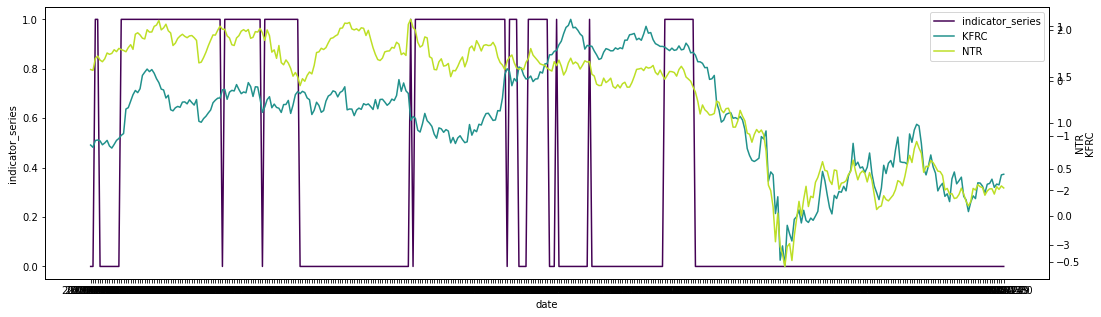

In [66]:
plot_triple_curves(X,Y,indicator_series, "date", "price1", "price2", "KFRC", "NTR","indicator_series")

Co-integration series = X


/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

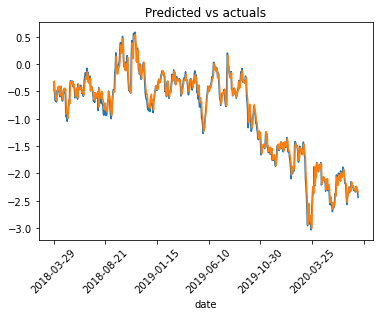

In [71]:
## Check co-integration quality with spread reversions. Execute trade
# Step 1: Create difference series
residual_series = econometrics.get_stationary_series(Y,X)
forecasted_deviations = econometrics.rolling_window_single_series_forecast(residual_series,60)
econometrics.plot_common_series(residual_series, forecasted_deviations, "Predicted vs actuals")

## Rahul pairs

In [74]:
rahul_pair = [('FB', 'GOOG'),
 ('KBH', 'TOL'),
 ('DHI', 'LEN'),
 ('CL', 'PG'),
 ('HAL', 'SLB'),
 ('CVX', 'XOM'),
 ('CSX', 'NSC'),
 ('ITT', 'PH'),
 ('TKR', 'URI'),
 ('RTX', 'WWD'),
 ('LRCX', 'MKSI'),
 ('ADI', 'MCHP'),
 ('QRVO', 'SWKS'),
 ('IP', 'WRK'),
 ('CE', 'EMN'),
 ('CDE', 'HL'),
 ('NUE', 'STLD'),
 ('CC', 'TROX'),
 ('IVV', 'SPY'),
 ('IWF', 'VUG'),
 ('RYN', 'WY')]

In [75]:
r_perf_df, r_rejected_pair = generate_coint_performance_df(df, rahul_pair, "2019-01-01","2021-07-31")

['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12', '2019

Cointegration test base with no trend, pvalue =  0.5023819469182134
Cointegration test base with constant trend, pvalue =  0.8050112419124651
Cointegration test base with linear trend, pvalue =  0.8050112419124651
Cointegration test base with quadratic trend, pvalue =  0.6689011144158097
Cointegration test base with no trend, pvalue =  0.5282877489352825
Cointegration test base with constant trend, pvalue =  0.8493994477952685
Cointegration test base with linear trend, pvalue =  0.8493994477952685
Cointegration test base with quadratic trend, pvalue =  0.674630988919202
Cointegration test base with no trend, pvalue =  0.5988507902632944
Cointegration test base with constant trend, pvalue =  0.8558864539447899
Cointegration test base with linear trend, pvalue =  0.8558864539447899
Cointegration test base with quadratic trend, pvalue =  0.6355405797970942
Cointegration test base with no trend, pvalue =  0.6101052270147629
Cointegration test base with constant trend, pvalue =  0.863420794

Cointegration test base with no trend, pvalue =  0.34743381060975187
Cointegration test base with constant trend, pvalue =  0.710016639828547
Cointegration test base with linear trend, pvalue =  0.710016639828547
Cointegration test base with quadratic trend, pvalue =  0.4379024893451719
Cointegration test base with no trend, pvalue =  0.4027640744717198
Cointegration test base with constant trend, pvalue =  0.7431427441266731
Cointegration test base with linear trend, pvalue =  0.7431427441266731
Cointegration test base with quadratic trend, pvalue =  0.5573774097399087
Cointegration test base with no trend, pvalue =  0.4423789791875098
Cointegration test base with constant trend, pvalue =  0.7655236673762005
Cointegration test base with linear trend, pvalue =  0.7655236673762005
Cointegration test base with quadratic trend, pvalue =  0.4239907277980852
Cointegration test base with no trend, pvalue =  0.473250286746018
Cointegration test base with constant trend, pvalue =  0.7106480618

Cointegration test base with no trend, pvalue =  0.32967586960351986
Cointegration test base with constant trend, pvalue =  0.6775125337549034
Cointegration test base with linear trend, pvalue =  0.6775125337549034
Cointegration test base with quadratic trend, pvalue =  0.45980347288832735
Cointegration test base with no trend, pvalue =  0.36729550316498205
Cointegration test base with constant trend, pvalue =  0.6843126441523582
Cointegration test base with linear trend, pvalue =  0.6843126441523582
Cointegration test base with quadratic trend, pvalue =  0.44769177510547326
Cointegration test base with no trend, pvalue =  0.37446271480929094
Cointegration test base with constant trend, pvalue =  0.7011684707107838
Cointegration test base with linear trend, pvalue =  0.7011684707107838
Cointegration test base with quadratic trend, pvalue =  0.43518212606440276
Cointegration test base with no trend, pvalue =  0.39279775726908056
Cointegration test base with constant trend, pvalue =  0.7

Cointegration test base with no trend, pvalue =  0.3248993444824688
Cointegration test base with constant trend, pvalue =  0.6259438542882245
Cointegration test base with linear trend, pvalue =  0.6259438542882245
Cointegration test base with quadratic trend, pvalue =  0.30260757870818245
Cointegration test base with no trend, pvalue =  0.3167934679278842
Cointegration test base with constant trend, pvalue =  0.5993702431612172
Cointegration test base with linear trend, pvalue =  0.5993702431612172
Cointegration test base with quadratic trend, pvalue =  0.3039338176990046
Cointegration test base with no trend, pvalue =  0.29313381513466785
Cointegration test base with constant trend, pvalue =  0.5776541019935353
Cointegration test base with linear trend, pvalue =  0.5776541019935353
Cointegration test base with quadratic trend, pvalue =  0.2529316241349348
Cointegration test base with no trend, pvalue =  0.27484737285868754
Cointegration test base with constant trend, pvalue =  0.59002

Cointegration test base with no trend, pvalue =  0.036698963066186856
Cointegration test base with constant trend, pvalue =  0.0984855886994096
Cointegration test base with linear trend, pvalue =  0.0984855886994096
Cointegration test base with quadratic trend, pvalue =  0.028682592779025413
Cointegration test base with no trend, pvalue =  0.023486188516498377
Cointegration test base with constant trend, pvalue =  0.1294825089352597
Cointegration test base with linear trend, pvalue =  0.1294825089352597
Cointegration test base with quadratic trend, pvalue =  0.052237244827992656
Cointegration test base with no trend, pvalue =  0.033141862771416
Cointegration test base with constant trend, pvalue =  0.12628527765301306
Cointegration test base with linear trend, pvalue =  0.12628527765301306
Cointegration test base with quadratic trend, pvalue =  0.05630214619627231
Cointegration test base with no trend, pvalue =  0.03210557449038846
Cointegration test base with constant trend, pvalue = 

Cointegration test base with no trend, pvalue =  0.04497460143012495
Cointegration test base with constant trend, pvalue =  0.17207673918049793
Cointegration test base with linear trend, pvalue =  0.17207673918049793
Cointegration test base with quadratic trend, pvalue =  0.05351753946479619
Cointegration test base with no trend, pvalue =  0.04780075206639229
Cointegration test base with constant trend, pvalue =  0.17136942663413068
Cointegration test base with linear trend, pvalue =  0.17136942663413068
Cointegration test base with quadratic trend, pvalue =  0.055741726432914744
Cointegration test base with no trend, pvalue =  0.04754455712013658
Cointegration test base with constant trend, pvalue =  0.15969430333897222
Cointegration test base with linear trend, pvalue =  0.15969430333897222
Cointegration test base with quadratic trend, pvalue =  0.051502785543723735
Cointegration test base with no trend, pvalue =  0.043377558587055075
Cointegration test base with constant trend, pval

Cointegration test base with no trend, pvalue =  0.09533778486034561
Cointegration test base with constant trend, pvalue =  0.336411050256477
Cointegration test base with linear trend, pvalue =  0.336411050256477
Cointegration test base with quadratic trend, pvalue =  0.03426756605375702
Cointegration test base with no trend, pvalue =  0.11903047692882646
Cointegration test base with constant trend, pvalue =  0.3242427605522283
Cointegration test base with linear trend, pvalue =  0.3242427605522283
Cointegration test base with quadratic trend, pvalue =  0.03087939809944061
Cointegration test base with no trend, pvalue =  0.11296727201382295
Cointegration test base with constant trend, pvalue =  0.34822783082895936
Cointegration test base with linear trend, pvalue =  0.34822783082895936
Cointegration test base with quadratic trend, pvalue =  0.027848302249420146
Cointegration test base with no trend, pvalue =  0.12505584259119462
Cointegration test base with constant trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.18008649503759855
Cointegration test base with constant trend, pvalue =  0.5474385722713774
Cointegration test base with linear trend, pvalue =  0.5474385722713774
Cointegration test base with quadratic trend, pvalue =  0.7718674572060633
Cointegration test base with no trend, pvalue =  0.250832918250842
Cointegration test base with constant trend, pvalue =  0.5616435963356934
Cointegration test base with linear trend, pvalue =  0.5616435963356934
Cointegration test base with quadratic trend, pvalue =  0.7581420248467747
Cointegration test base with no trend, pvalue =  0.2619243832533127
Cointegration test base with constant trend, pvalue =  0.5803692431466038
Cointegration test base with linear trend, pvalue =  0.5803692431466038
Cointegration test base with quadratic trend, pvalue =  0.7890196715968376
Cointegration test base with no trend, pvalue =  0.2770849218781653
Cointegration test base with constant trend, pvalue =  0.53670625

Cointegration test base with quadratic trend, pvalue =  0.6125919484385212
Cointegration test base with no trend, pvalue =  0.3243351316426659
Cointegration test base with constant trend, pvalue =  0.5978850948154982
Cointegration test base with linear trend, pvalue =  0.5978850948154982
Cointegration test base with quadratic trend, pvalue =  0.5700567270828822
Cointegration test base with no trend, pvalue =  0.29185421186589466
Cointegration test base with constant trend, pvalue =  0.5966028054446607
Cointegration test base with linear trend, pvalue =  0.5966028054446607
Cointegration test base with quadratic trend, pvalue =  0.533812248317085
Cointegration test base with no trend, pvalue =  0.29075289642450675
Cointegration test base with constant trend, pvalue =  0.6122203151380122
Cointegration test base with linear trend, pvalue =  0.6122203151380122
Cointegration test base with quadratic trend, pvalue =  0.5144281703840597
Cointegration test base with no trend, pvalue =  0.304390

Cointegration test base with quadratic trend, pvalue =  0.8127710451374326
Cointegration test base with no trend, pvalue =  0.9507739466916225
Cointegration test base with constant trend, pvalue =  0.9874767500650191
Cointegration test base with linear trend, pvalue =  0.9874767500650191
Cointegration test base with quadratic trend, pvalue =  0.7663416244716078
Cointegration test base with no trend, pvalue =  0.9473703849341765
Cointegration test base with constant trend, pvalue =  0.9907547088700794
Cointegration test base with linear trend, pvalue =  0.9907547088700794
Cointegration test base with quadratic trend, pvalue =  0.7664904170181015
Cointegration test base with no trend, pvalue =  0.9629726337323051
Cointegration test base with constant trend, pvalue =  0.9904137568606531
Cointegration test base with linear trend, pvalue =  0.9904137568606531
Cointegration test base with quadratic trend, pvalue =  0.7798349124260875
Cointegration test base with no trend, pvalue =  0.9612634

Cointegration test base with quadratic trend, pvalue =  0.6360057084062558
Cointegration test base with no trend, pvalue =  0.7705942398595587
Cointegration test base with constant trend, pvalue =  0.910411169546725
Cointegration test base with linear trend, pvalue =  0.910411169546725
Cointegration test base with quadratic trend, pvalue =  0.7444157348042862
Cointegration test base with no trend, pvalue =  0.7175239658174023
Cointegration test base with constant trend, pvalue =  0.8949565222876561
Cointegration test base with linear trend, pvalue =  0.8949565222876561
Cointegration test base with quadratic trend, pvalue =  0.751354917482663
Cointegration test base with no trend, pvalue =  0.68438222222391
Cointegration test base with constant trend, pvalue =  0.9033766793327962
Cointegration test base with linear trend, pvalue =  0.9033766793327962
Cointegration test base with quadratic trend, pvalue =  0.7220839263747426
Cointegration test base with no trend, pvalue =  0.702126765129

Cointegration test base with quadratic trend, pvalue =  0.23015467993030142
Cointegration test base with no trend, pvalue =  0.49456407772691663
Cointegration test base with constant trend, pvalue =  0.8000144497082771
Cointegration test base with linear trend, pvalue =  0.8000144497082771
Cointegration test base with quadratic trend, pvalue =  0.25680757276349453
Cointegration test base with no trend, pvalue =  0.5209619485434039
Cointegration test base with constant trend, pvalue =  0.7643213374583442
Cointegration test base with linear trend, pvalue =  0.7643213374583442
Cointegration test base with quadratic trend, pvalue =  0.4361631281828593
Cointegration test base with no trend, pvalue =  0.4716703872882715
Cointegration test base with constant trend, pvalue =  0.7384193996464639
Cointegration test base with linear trend, pvalue =  0.7384193996464639
Cointegration test base with quadratic trend, pvalue =  0.2968757074467421
Cointegration test base with no trend, pvalue =  0.4364

Cointegration test base with quadratic trend, pvalue =  0.2399963280332047
Cointegration test base with no trend, pvalue =  0.19021384857079116
Cointegration test base with constant trend, pvalue =  0.43190372766637325
Cointegration test base with linear trend, pvalue =  0.43190372766637325
Cointegration test base with quadratic trend, pvalue =  0.23683612405663884
Cointegration test base with no trend, pvalue =  0.17189221745245487
Cointegration test base with constant trend, pvalue =  0.4352206565062344
Cointegration test base with linear trend, pvalue =  0.4352206565062344
Cointegration test base with quadratic trend, pvalue =  0.24091562479416734
Cointegration test base with no trend, pvalue =  0.17391081066645103
Cointegration test base with constant trend, pvalue =  0.4394910561049036
Cointegration test base with linear trend, pvalue =  0.4394910561049036
Cointegration test base with quadratic trend, pvalue =  0.23416083103356888
Cointegration test base with no trend, pvalue =  0

Cointegration test base with no trend, pvalue =  0.009486767576524257
Cointegration test base with constant trend, pvalue =  0.11738317018201472
Cointegration test base with linear trend, pvalue =  0.11738317018201472
Cointegration test base with quadratic trend, pvalue =  0.15180992642746544
Cointegration test base with no trend, pvalue =  0.02926849676174064
Cointegration test base with constant trend, pvalue =  0.0722540848350134
Cointegration test base with linear trend, pvalue =  0.0722540848350134
Cointegration test base with quadratic trend, pvalue =  0.05949747425760836
Cointegration test base with no trend, pvalue =  0.016027897511938772
Cointegration test base with constant trend, pvalue =  0.11623776158115079
Cointegration test base with linear trend, pvalue =  0.11623776158115079
Cointegration test base with quadratic trend, pvalue =  0.10276141670364647
Cointegration test base with no trend, pvalue =  0.02890865719401227
Cointegration test base with constant trend, pvalue 

Cointegration test base with constant trend, pvalue =  0.11496295087863562
Cointegration test base with linear trend, pvalue =  0.11496295087863562
Cointegration test base with quadratic trend, pvalue =  0.24565706835482892
Cointegration test base with no trend, pvalue =  0.028509568817003176
Cointegration test base with constant trend, pvalue =  0.1194432011776948
Cointegration test base with linear trend, pvalue =  0.1194432011776948
Cointegration test base with quadratic trend, pvalue =  0.272035120379566
Cointegration test base with no trend, pvalue =  0.02991866835514465
Cointegration test base with constant trend, pvalue =  0.07675885947082657
Cointegration test base with linear trend, pvalue =  0.07675885947082657
Cointegration test base with quadratic trend, pvalue =  0.2084722582901235
Cointegration test base with no trend, pvalue =  0.01725956691136516
Cointegration test base with constant trend, pvalue =  0.11974541573030706
Cointegration test base with linear trend, pvalue 

Cointegration test base with constant trend, pvalue =  0.8739754931658155
Cointegration test base with linear trend, pvalue =  0.8739754931658155
Cointegration test base with quadratic trend, pvalue =  0.2776454118279088
Cointegration test base with no trend, pvalue =  0.6430050435332081
Cointegration test base with constant trend, pvalue =  0.8944549258519967
Cointegration test base with linear trend, pvalue =  0.8944549258519967
Cointegration test base with quadratic trend, pvalue =  0.3467747434687818
Cointegration test base with no trend, pvalue =  0.6833472981772097
Cointegration test base with constant trend, pvalue =  0.8914478061694294
Cointegration test base with linear trend, pvalue =  0.8914478061694294
Cointegration test base with quadratic trend, pvalue =  0.3456999010112068
Cointegration test base with no trend, pvalue =  0.6771927111025045
Cointegration test base with constant trend, pvalue =  0.9179397423832627
Cointegration test base with linear trend, pvalue =  0.9179

Cointegration test base with constant trend, pvalue =  0.9570212641184842
Cointegration test base with linear trend, pvalue =  0.9570212641184842
Cointegration test base with quadratic trend, pvalue =  0.7677439338152491
Cointegration test base with no trend, pvalue =  0.8374835655534134
Cointegration test base with constant trend, pvalue =  0.9298377688067149
Cointegration test base with linear trend, pvalue =  0.9298377688067149
Cointegration test base with quadratic trend, pvalue =  0.7036326562234789
Cointegration test base with no trend, pvalue =  0.7631990129015265
Cointegration test base with constant trend, pvalue =  0.9370955297581336
Cointegration test base with linear trend, pvalue =  0.9370955297581336
Cointegration test base with quadratic trend, pvalue =  0.6790733082069947
Cointegration test base with no trend, pvalue =  0.7816623728663076
Cointegration test base with constant trend, pvalue =  0.9625173729006855
Cointegration test base with linear trend, pvalue =  0.9625

Cointegration test base with constant trend, pvalue =  0.5461165946992502
Cointegration test base with linear trend, pvalue =  0.5461165946992502
Cointegration test base with quadratic trend, pvalue =  0.7552304632019218
Cointegration test base with no trend, pvalue =  0.2498179804305602
Cointegration test base with constant trend, pvalue =  0.5492307870937889
Cointegration test base with linear trend, pvalue =  0.5492307870937889
Cointegration test base with quadratic trend, pvalue =  0.7489124126740896
Cointegration test base with no trend, pvalue =  0.25221351195262715
Cointegration test base with constant trend, pvalue =  0.5278490415931014
Cointegration test base with linear trend, pvalue =  0.5278490415931014
Cointegration test base with quadratic trend, pvalue =  0.7200034722831709
Cointegration test base with no trend, pvalue =  0.23608370209006613
Cointegration test base with constant trend, pvalue =  0.5351223549368948
Cointegration test base with linear trend, pvalue =  0.53

Cointegration test base with constant trend, pvalue =  0.3556962155201198
Cointegration test base with linear trend, pvalue =  0.3556962155201198
Cointegration test base with quadratic trend, pvalue =  0.7844361993819313
Cointegration test base with no trend, pvalue =  0.1289351642465305
Cointegration test base with constant trend, pvalue =  0.3635591107290538
Cointegration test base with linear trend, pvalue =  0.3635591107290538
Cointegration test base with quadratic trend, pvalue =  0.8130293692174473
Cointegration test base with no trend, pvalue =  0.13308008053252923
Cointegration test base with constant trend, pvalue =  0.3703189783329244
Cointegration test base with linear trend, pvalue =  0.3703189783329244
Cointegration test base with quadratic trend, pvalue =  0.8635685650021239
Cointegration test base with no trend, pvalue =  0.1366940418290999
Cointegration test base with constant trend, pvalue =  0.3448283388668167
Cointegration test base with linear trend, pvalue =  0.344

Cointegration test base with constant trend, pvalue =  0.1428578638310909
Cointegration test base with linear trend, pvalue =  0.1428578638310909
Cointegration test base with quadratic trend, pvalue =  0.5951902774165401
Cointegration test base with no trend, pvalue =  0.03757514551884707
Cointegration test base with constant trend, pvalue =  0.14553996712587847
Cointegration test base with linear trend, pvalue =  0.14553996712587847
Cointegration test base with quadratic trend, pvalue =  0.5764226541615562
Cointegration test base with no trend, pvalue =  0.03848302249843111
Cointegration test base with constant trend, pvalue =  0.13701618092611106
Cointegration test base with linear trend, pvalue =  0.13701618092611106
Cointegration test base with quadratic trend, pvalue =  0.5471872776411214
Cointegration test base with no trend, pvalue =  0.03561953922007026
Cointegration test base with constant trend, pvalue =  0.15027264271138108
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.504963305326372
Cointegration test base with linear trend, pvalue =  0.504963305326372
Cointegration test base with quadratic trend, pvalue =  0.36207874776087035
Cointegration test base with no trend, pvalue =  0.21960889395993666
Cointegration test base with constant trend, pvalue =  0.4898191827850523
Cointegration test base with linear trend, pvalue =  0.4898191827850523
Cointegration test base with quadratic trend, pvalue =  0.3302991125340188
Cointegration test base with no trend, pvalue =  0.209129718122188
Cointegration test base with constant trend, pvalue =  0.5104632810318875
Cointegration test base with linear trend, pvalue =  0.5104632810318875
Cointegration test base with quadratic trend, pvalue =  0.3989132657054124
Cointegration test base with no trend, pvalue =  0.22349656582300076
Cointegration test base with constant trend, pvalue =  0.4817007352666095
Cointegration test base with linear trend, pvalue =  0.4817

Cointegration test base with constant trend, pvalue =  0.49296578112442674
Cointegration test base with linear trend, pvalue =  0.49296578112442674
Cointegration test base with quadratic trend, pvalue =  0.43900571133908073
Cointegration test base with no trend, pvalue =  0.21128027918459918
Cointegration test base with constant trend, pvalue =  0.49702910245479176
Cointegration test base with linear trend, pvalue =  0.49702910245479176
Cointegration test base with quadratic trend, pvalue =  0.45764857893851213
Cointegration test base with no trend, pvalue =  0.21407799515937082
Cointegration test base with constant trend, pvalue =  0.4990251503605325
Cointegration test base with linear trend, pvalue =  0.4990251503605325
Cointegration test base with quadratic trend, pvalue =  0.4772688027888622
Cointegration test base with no trend, pvalue =  0.21546091896168323
Cointegration test base with constant trend, pvalue =  0.47105000458635754
Cointegration test base with linear trend, pvalue

Cointegration test base with constant trend, pvalue =  0.38179187077500876
Cointegration test base with linear trend, pvalue =  0.38179187077500876
Cointegration test base with quadratic trend, pvalue =  0.9746643298148739
Cointegration test base with no trend, pvalue =  0.14293652554506214
Cointegration test base with constant trend, pvalue =  0.39341869733075985
Cointegration test base with linear trend, pvalue =  0.39341869733075985
Cointegration test base with quadratic trend, pvalue =  0.6823151906656509
Cointegration test base with no trend, pvalue =  0.14940554343480106
Cointegration test base with constant trend, pvalue =  0.40605306056176527
Cointegration test base with linear trend, pvalue =  0.40605306056176527
Cointegration test base with quadratic trend, pvalue =  0.5274775835592758
Cointegration test base with no trend, pvalue =  0.15660245381429672
Cointegration test base with constant trend, pvalue =  0.42549136973846896
Cointegration test base with linear trend, pvalue

Cointegration test base with linear trend, pvalue =  0.3455138438777967
Cointegration test base with quadratic trend, pvalue =  0.17059867820599706
Cointegration test base with no trend, pvalue =  0.12365985173559274
Cointegration test base with constant trend, pvalue =  0.20631667015780275
Cointegration test base with linear trend, pvalue =  0.20631667015780275
Cointegration test base with quadratic trend, pvalue =  0.11495658595140446
Cointegration test base with no trend, pvalue =  0.060711467891303855
Cointegration test base with constant trend, pvalue =  0.1700004843174378
Cointegration test base with linear trend, pvalue =  0.1700004843174378
Cointegration test base with quadratic trend, pvalue =  0.06083710015654457
Cointegration test base with no trend, pvalue =  0.04704992735172196
Cointegration test base with constant trend, pvalue =  0.19178274125496692
Cointegration test base with linear trend, pvalue =  0.19178274125496692
Cointegration test base with quadratic trend, pval

Cointegration test base with linear trend, pvalue =  0.24666951543564997
Cointegration test base with quadratic trend, pvalue =  0.32133759062868195
Cointegration test base with no trend, pvalue =  0.07749563708983707
Cointegration test base with constant trend, pvalue =  0.24018949923691618
Cointegration test base with linear trend, pvalue =  0.24018949923691618
Cointegration test base with quadratic trend, pvalue =  0.2761977949572655
Cointegration test base with no trend, pvalue =  0.07476948746623362
Cointegration test base with constant trend, pvalue =  0.3100978025712571
Cointegration test base with linear trend, pvalue =  0.3100978025712571
Cointegration test base with quadratic trend, pvalue =  0.26823872402700083
Cointegration test base with no trend, pvalue =  0.10609526278478848
Cointegration test base with constant trend, pvalue =  0.29411354114635974
Cointegration test base with linear trend, pvalue =  0.29411354114635974
Cointegration test base with quadratic trend, pvalu

Cointegration test base with linear trend, pvalue =  0.2338611521314769
Cointegration test base with quadratic trend, pvalue =  0.4162741760970039
Cointegration test base with no trend, pvalue =  0.0721410234320475
Cointegration test base with constant trend, pvalue =  0.1499687270882311
Cointegration test base with linear trend, pvalue =  0.1499687270882311
Cointegration test base with quadratic trend, pvalue =  0.427884734562528
Cointegration test base with no trend, pvalue =  0.03999583634031771
Cointegration test base with constant trend, pvalue =  0.12415842557172174
Cointegration test base with linear trend, pvalue =  0.12415842557172174
Cointegration test base with quadratic trend, pvalue =  0.26601716340772597
Cointegration test base with no trend, pvalue =  0.031421273981383925
Cointegration test base with constant trend, pvalue =  0.22013895011810264
Cointegration test base with linear trend, pvalue =  0.22013895011810264
Cointegration test base with quadratic trend, pvalue =

Cointegration test base with no trend, pvalue =  0.14802634282469795
Cointegration test base with constant trend, pvalue =  0.4802858527578906
Cointegration test base with linear trend, pvalue =  0.4802858527578906
Cointegration test base with quadratic trend, pvalue =  0.5261749138911488
Cointegration test base with no trend, pvalue =  0.20269783293401156
Cointegration test base with constant trend, pvalue =  0.3879394563644983
Cointegration test base with linear trend, pvalue =  0.3879394563644983
Cointegration test base with quadratic trend, pvalue =  0.5404258932626166
Cointegration test base with no trend, pvalue =  0.14633882593513453
Cointegration test base with constant trend, pvalue =  0.5197546635352746
Cointegration test base with linear trend, pvalue =  0.5197546635352746
Cointegration test base with quadratic trend, pvalue =  0.5717007511032363
Cointegration test base with no trend, pvalue =  0.2301662822375125
Cointegration test base with constant trend, pvalue =  0.57191

Cointegration test base with no trend, pvalue =  0.23927803793999858
Cointegration test base with constant trend, pvalue =  0.5451957244491884
Cointegration test base with linear trend, pvalue =  0.5451957244491884
Cointegration test base with quadratic trend, pvalue =  0.5834805461159434
Cointegration test base with no trend, pvalue =  0.24911269730054297
Cointegration test base with constant trend, pvalue =  0.4724597630361599
Cointegration test base with linear trend, pvalue =  0.4724597630361599
Cointegration test base with quadratic trend, pvalue =  0.6084069357918409
Cointegration test base with no trend, pvalue =  0.19751009011083753
Cointegration test base with constant trend, pvalue =  0.5123534061350336
Cointegration test base with linear trend, pvalue =  0.5123534061350336
Cointegration test base with quadratic trend, pvalue =  0.5576333436761189
Cointegration test base with no trend, pvalue =  0.22484290406711172
Cointegration test base with constant trend, pvalue =  0.5464

Cointegration test base with no trend, pvalue =  0.1201571859569146
Cointegration test base with constant trend, pvalue =  0.28993757207359716
Cointegration test base with linear trend, pvalue =  0.28993757207359716
Cointegration test base with quadratic trend, pvalue =  0.49657008139766134
Cointegration test base with no trend, pvalue =  0.09661939507206985
Cointegration test base with constant trend, pvalue =  0.3068432898911841
Cointegration test base with linear trend, pvalue =  0.3068432898911841
Cointegration test base with quadratic trend, pvalue =  0.5045444583199028
Cointegration test base with no trend, pvalue =  0.10454046077911339
Cointegration test base with constant trend, pvalue =  0.2870487418911989
Cointegration test base with linear trend, pvalue =  0.2870487418911989
Cointegration test base with quadratic trend, pvalue =  0.5202102774542148
Cointegration test base with no trend, pvalue =  0.09529160494189826
Cointegration test base with constant trend, pvalue =  0.29

Cointegration test base with no trend, pvalue =  0.03829666121372173
Cointegration test base with constant trend, pvalue =  0.14089948497934324
Cointegration test base with linear trend, pvalue =  0.14089948497934324
Cointegration test base with quadratic trend, pvalue =  0.7093040566789814
Cointegration test base with no trend, pvalue =  0.03691621260040338
Cointegration test base with constant trend, pvalue =  0.14387847034750106
Cointegration test base with linear trend, pvalue =  0.14387847034750106
Cointegration test base with quadratic trend, pvalue =  0.7411570430835777
Cointegration test base with no trend, pvalue =  0.037919875657684676
Cointegration test base with constant trend, pvalue =  0.12417753136403803
Cointegration test base with linear trend, pvalue =  0.12417753136403803
Cointegration test base with quadratic trend, pvalue =  0.6683589249922066
Cointegration test base with no trend, pvalue =  0.0314274031101134
Cointegration test base with constant trend, pvalue =  

Cointegration test base with quadratic trend, pvalue =  0.1526051502269296
Cointegration test base with no trend, pvalue =  0.012405764738678608
Cointegration test base with constant trend, pvalue =  0.06405253050071522
Cointegration test base with linear trend, pvalue =  0.06405253050071522
Cointegration test base with quadratic trend, pvalue =  0.15132283727386836
Cointegration test base with no trend, pvalue =  0.01384053106593253
Cointegration test base with constant trend, pvalue =  0.053003924292528266
Cointegration test base with linear trend, pvalue =  0.053003924292528266
Cointegration test base with quadratic trend, pvalue =  0.11139819515208182
Cointegration test base with no trend, pvalue =  0.01101140698046863
Cointegration test base with constant trend, pvalue =  0.05063827749169723
Cointegration test base with linear trend, pvalue =  0.05063827749169723
Cointegration test base with quadratic trend, pvalue =  0.09126369678601848
Cointegration test base with no trend, pval

Cointegration test base with linear trend, pvalue =  0.4160786562188853
Cointegration test base with quadratic trend, pvalue =  0.5238909312089647
Cointegration test base with no trend, pvalue =  0.162440615869739
Cointegration test base with constant trend, pvalue =  0.468554536854605
Cointegration test base with linear trend, pvalue =  0.468554536854605
Cointegration test base with quadratic trend, pvalue =  0.5824043486717128
Cointegration test base with no trend, pvalue =  0.19495192631449054
Cointegration test base with constant trend, pvalue =  0.47562096381659397
Cointegration test base with linear trend, pvalue =  0.47562096381659397
Cointegration test base with quadratic trend, pvalue =  0.6189195323616411
Cointegration test base with no trend, pvalue =  0.19959569161114504
Cointegration test base with constant trend, pvalue =  0.40365012943914735
Cointegration test base with linear trend, pvalue =  0.40365012943914735
Cointegration test base with quadratic trend, pvalue =  0.

Cointegration test base with linear trend, pvalue =  0.12956399710018235
Cointegration test base with quadratic trend, pvalue =  0.27574266747042175
Cointegration test base with no trend, pvalue =  0.03316839370756798
Cointegration test base with constant trend, pvalue =  0.12017913377481804
Cointegration test base with linear trend, pvalue =  0.12017913377481804
Cointegration test base with quadratic trend, pvalue =  0.2629748036455474
Cointegration test base with no trend, pvalue =  0.030151869067717243
Cointegration test base with constant trend, pvalue =  0.11166097494043581
Cointegration test base with linear trend, pvalue =  0.11166097494043581
Cointegration test base with quadratic trend, pvalue =  0.2926432726570223
Cointegration test base with no trend, pvalue =  0.027482766043191015
Cointegration test base with constant trend, pvalue =  0.100856425450425
Cointegration test base with linear trend, pvalue =  0.100856425450425
Cointegration test base with quadratic trend, pvalue

Cointegration test base with linear trend, pvalue =  0.0668883967303518
Cointegration test base with quadratic trend, pvalue =  0.092801634106225
Cointegration test base with no trend, pvalue =  0.014588682957216638
Cointegration test base with constant trend, pvalue =  0.09114806098067446
Cointegration test base with linear trend, pvalue =  0.09114806098067446
Cointegration test base with quadratic trend, pvalue =  0.11111280943713286
Cointegration test base with no trend, pvalue =  0.021331584257134703
Cointegration test base with constant trend, pvalue =  0.14897285263142707
Cointegration test base with linear trend, pvalue =  0.14897285263142707
Cointegration test base with quadratic trend, pvalue =  0.14643948698393666
Cointegration test base with no trend, pvalue =  0.039654172521360415
Cointegration test base with constant trend, pvalue =  0.12143052883696914
Cointegration test base with linear trend, pvalue =  0.12143052883696914
Cointegration test base with quadratic trend, pv

Cointegration test base with linear trend, pvalue =  0.14957422518950275
Cointegration test base with quadratic trend, pvalue =  0.5216284654650682
Cointegration test base with no trend, pvalue =  0.03986038806346634
Cointegration test base with constant trend, pvalue =  0.14087442926913046
Cointegration test base with linear trend, pvalue =  0.14087442926913046
Cointegration test base with quadratic trend, pvalue =  0.4694714230175032
Cointegration test base with no trend, pvalue =  0.03690780387564155
Cointegration test base with constant trend, pvalue =  0.1395989385534956
Cointegration test base with linear trend, pvalue =  0.1395989385534956
Cointegration test base with quadratic trend, pvalue =  0.42721655809063735
Cointegration test base with no trend, pvalue =  0.03648047414812946
Cointegration test base with constant trend, pvalue =  0.12359359028370931
Cointegration test base with linear trend, pvalue =  0.12359359028370931
Cointegration test base with quadratic trend, pvalue

Cointegration test base with linear trend, pvalue =  0.2399642521556245
Cointegration test base with quadratic trend, pvalue =  0.3368192692816255
Cointegration test base with no trend, pvalue =  0.07467535848011157
Cointegration test base with constant trend, pvalue =  0.23468745294190768
Cointegration test base with linear trend, pvalue =  0.23468745294190768
Cointegration test base with quadratic trend, pvalue =  0.3325779564024725
Cointegration test base with no trend, pvalue =  0.07248233366836514
Cointegration test base with constant trend, pvalue =  0.19030123922130426
Cointegration test base with linear trend, pvalue =  0.19030123922130426
Cointegration test base with quadratic trend, pvalue =  0.3011311342790063
Cointegration test base with no trend, pvalue =  0.05454871342826195
Cointegration test base with constant trend, pvalue =  0.15924378382966753
Cointegration test base with linear trend, pvalue =  0.15924378382966753
Cointegration test base with quadratic trend, pvalue

Cointegration test base with linear trend, pvalue =  0.13248684419655915
Cointegration test base with quadratic trend, pvalue =  0.16341283625921815
Cointegration test base with no trend, pvalue =  0.03412391207061156
Cointegration test base with constant trend, pvalue =  0.1579099336741116
Cointegration test base with linear trend, pvalue =  0.1579099336741116
Cointegration test base with quadratic trend, pvalue =  0.16092233733447653
Cointegration test base with no trend, pvalue =  0.042750997239739505
Cointegration test base with constant trend, pvalue =  0.12044678052426316
Cointegration test base with linear trend, pvalue =  0.12044678052426316
Cointegration test base with quadratic trend, pvalue =  0.12955232670123845
Cointegration test base with no trend, pvalue =  0.030236801704408373
Cointegration test base with constant trend, pvalue =  0.1420195943388628
Cointegration test base with linear trend, pvalue =  0.1420195943388628
Cointegration test base with quadratic trend, pval

Cointegration test base with linear trend, pvalue =  0.06218193464094737
Cointegration test base with quadratic trend, pvalue =  0.39974481220421054
Cointegration test base with no trend, pvalue =  0.01335185697754899
Cointegration test base with constant trend, pvalue =  0.08393728208129875
Cointegration test base with linear trend, pvalue =  0.08393728208129875
Cointegration test base with quadratic trend, pvalue =  0.37997972725963736
Cointegration test base with no trend, pvalue =  0.01926517912002806
Cointegration test base with constant trend, pvalue =  0.07221358396732225
Cointegration test base with linear trend, pvalue =  0.07221358396732225
Cointegration test base with quadratic trend, pvalue =  0.3776441617112835
Cointegration test base with no trend, pvalue =  0.016016919913507708
Cointegration test base with constant trend, pvalue =  0.06714494089330092
Cointegration test base with linear trend, pvalue =  0.06714494089330092
Cointegration test base with quadratic trend, pv

Cointegration test base with linear trend, pvalue =  0.08007329912867961
Cointegration test base with quadratic trend, pvalue =  0.5031932535654358
Cointegration test base with no trend, pvalue =  0.01817912199076857
Cointegration test base with constant trend, pvalue =  0.08124191663180996
Cointegration test base with linear trend, pvalue =  0.08124191663180996
Cointegration test base with quadratic trend, pvalue =  0.5227705388053875
Cointegration test base with no trend, pvalue =  0.01850600336539321
Cointegration test base with constant trend, pvalue =  0.08375283996620403
Cointegration test base with linear trend, pvalue =  0.08375283996620403
Cointegration test base with quadratic trend, pvalue =  0.4692378535142998
Cointegration test base with no trend, pvalue =  0.01921299743102979
Cointegration test base with constant trend, pvalue =  0.08104163758196875
Cointegration test base with linear trend, pvalue =  0.08104163758196875
Cointegration test base with quadratic trend, pvalu

Cointegration test base with no trend, pvalue =  0.8465599178452359
Cointegration test base with constant trend, pvalue =  0.9601648922198055
Cointegration test base with linear trend, pvalue =  0.9601648922198055
Cointegration test base with quadratic trend, pvalue =  0.05054434467086035
Cointegration test base with no trend, pvalue =  0.8471385029969583
Cointegration test base with constant trend, pvalue =  0.9556899615157004
Cointegration test base with linear trend, pvalue =  0.9556899615157004
Cointegration test base with quadratic trend, pvalue =  0.04874175707519083
Cointegration test base with no trend, pvalue =  0.8334748120730526
Cointegration test base with constant trend, pvalue =  0.9446927527062234
Cointegration test base with linear trend, pvalue =  0.9446927527062234
Cointegration test base with quadratic trend, pvalue =  0.05559107327501232
Cointegration test base with no trend, pvalue =  0.8019712630522688
Cointegration test base with constant trend, pvalue =  0.94722

Cointegration test base with constant trend, pvalue =  0.8028794537893627
Cointegration test base with linear trend, pvalue =  0.8028794537893627
Cointegration test base with quadratic trend, pvalue =  0.016515469803160675
Cointegration test base with no trend, pvalue =  0.5251485674321154
Cointegration test base with constant trend, pvalue =  0.8033433641177232
Cointegration test base with linear trend, pvalue =  0.8033433641177232
Cointegration test base with quadratic trend, pvalue =  0.057720252220384426
Cointegration test base with no trend, pvalue =  0.5258299463951421
Cointegration test base with constant trend, pvalue =  0.810680919140533
Cointegration test base with linear trend, pvalue =  0.810680919140533
Cointegration test base with quadratic trend, pvalue =  0.007364966494055564
Cointegration test base with no trend, pvalue =  0.5367386066240617
Cointegration test base with constant trend, pvalue =  0.8103744265410396
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.7751701012485093
Cointegration test base with linear trend, pvalue =  0.7751701012485093
Cointegration test base with quadratic trend, pvalue =  0.520781549072459
Cointegration test base with no trend, pvalue =  0.48611995412984743
Cointegration test base with constant trend, pvalue =  0.7819180587662657
Cointegration test base with linear trend, pvalue =  0.7819180587662657
Cointegration test base with quadratic trend, pvalue =  0.47222056494759396
Cointegration test base with no trend, pvalue =  0.4953342543072262
Cointegration test base with constant trend, pvalue =  0.7758360997887759
Cointegration test base with linear trend, pvalue =  0.7758360997887759
Cointegration test base with quadratic trend, pvalue =  0.46445576403112104
Cointegration test base with no trend, pvalue =  0.4870214791195996
Cointegration test base with constant trend, pvalue =  0.7926093457583643
Cointegration test base with linear trend, pvalue =  0.79

Cointegration test base with constant trend, pvalue =  0.3956028302379432
Cointegration test base with linear trend, pvalue =  0.3956028302379432
Cointegration test base with quadratic trend, pvalue =  0.684938620914306
Cointegration test base with no trend, pvalue =  0.150637102757118
Cointegration test base with constant trend, pvalue =  0.3932269524029267
Cointegration test base with linear trend, pvalue =  0.3932269524029267
Cointegration test base with quadratic trend, pvalue =  0.7019482132293842
Cointegration test base with no trend, pvalue =  0.14929767371084846
Cointegration test base with constant trend, pvalue =  0.29861070316014393
Cointegration test base with linear trend, pvalue =  0.29861070316014393
Cointegration test base with quadratic trend, pvalue =  0.7425460629379542
Cointegration test base with no trend, pvalue =  0.10065077898336777
Cointegration test base with constant trend, pvalue =  0.25275116632312566
Cointegration test base with linear trend, pvalue =  0.2

Cointegration test base with no trend, pvalue =  0.17012567417657576
Cointegration test base with constant trend, pvalue =  0.4461273912527432
Cointegration test base with linear trend, pvalue =  0.4461273912527432
Cointegration test base with quadratic trend, pvalue =  0.9921727713369989
Cointegration test base with no trend, pvalue =  0.1806423885579994
Cointegration test base with constant trend, pvalue =  0.4640814586880237
Cointegration test base with linear trend, pvalue =  0.4640814586880237
Cointegration test base with quadratic trend, pvalue =  0.9941058185445503
Cointegration test base with no trend, pvalue =  0.19204638975233163
Cointegration test base with constant trend, pvalue =  0.47935923723225293
Cointegration test base with linear trend, pvalue =  0.47935923723225293
Cointegration test base with quadratic trend, pvalue =  0.9951325980310071
Cointegration test base with no trend, pvalue =  0.2020792978940511
Cointegration test base with constant trend, pvalue =  0.4966

Cointegration test base with quadratic trend, pvalue =  0.9958546429356349
Cointegration test base with no trend, pvalue =  0.6996563109638315
Cointegration test base with constant trend, pvalue =  0.9134153200476516
Cointegration test base with linear trend, pvalue =  0.9134153200476516
Cointegration test base with quadratic trend, pvalue =  0.9959305418269125
Cointegration test base with no trend, pvalue =  0.7242708686933486
Cointegration test base with constant trend, pvalue =  0.9046762290466088
Cointegration test base with linear trend, pvalue =  0.9046762290466088
Cointegration test base with quadratic trend, pvalue =  0.9938215060999671
Cointegration test base with no trend, pvalue =  0.7049304266364884
Cointegration test base with constant trend, pvalue =  0.9115235763426026
Cointegration test base with linear trend, pvalue =  0.9115235763426026
Cointegration test base with quadratic trend, pvalue =  0.993339944720783
Cointegration test base with no trend, pvalue =  0.72000989

Cointegration test base with linear trend, pvalue =  0.8805460613811205
Cointegration test base with quadratic trend, pvalue =  0.7954959017663741
Cointegration test base with no trend, pvalue =  0.6555615425024184
Cointegration test base with constant trend, pvalue =  0.8463634870408572
Cointegration test base with linear trend, pvalue =  0.8463634870408572
Cointegration test base with quadratic trend, pvalue =  0.7277401157572636
Cointegration test base with no trend, pvalue =  0.593674900141961
Cointegration test base with constant trend, pvalue =  0.8371705716528484
Cointegration test base with linear trend, pvalue =  0.8371705716528484
Cointegration test base with quadratic trend, pvalue =  0.7296482561492748
Cointegration test base with no trend, pvalue =  0.5783401190594109
Cointegration test base with constant trend, pvalue =  0.8642966705807921
Cointegration test base with linear trend, pvalue =  0.8642966705807921
Cointegration test base with quadratic trend, pvalue =  0.5915

Cointegration test base with constant trend, pvalue =  0.6396784559691583
Cointegration test base with linear trend, pvalue =  0.6396784559691583
Cointegration test base with quadratic trend, pvalue =  0.9278279897015357
Cointegration test base with no trend, pvalue =  0.3296202294520435
Cointegration test base with constant trend, pvalue =  0.6367555957020193
Cointegration test base with linear trend, pvalue =  0.6367555957020193
Cointegration test base with quadratic trend, pvalue =  0.9117361491598684
Cointegration test base with no trend, pvalue =  0.3268547292965458
Cointegration test base with constant trend, pvalue =  0.6395874952593369
Cointegration test base with linear trend, pvalue =  0.6395874952593369
Cointegration test base with quadratic trend, pvalue =  0.9455287706665123
Cointegration test base with no trend, pvalue =  0.32953386837990595
Cointegration test base with constant trend, pvalue =  0.626202087384442
Cointegration test base with linear trend, pvalue =  0.6262

Cointegration test base with constant trend, pvalue =  0.5504758040340577
Cointegration test base with linear trend, pvalue =  0.5504758040340577
Cointegration test base with quadratic trend, pvalue =  0.9600163940179849
Cointegration test base with no trend, pvalue =  0.2531757387671649
Cointegration test base with constant trend, pvalue =  0.5968064324034501
Cointegration test base with linear trend, pvalue =  0.5968064324034501
Cointegration test base with quadratic trend, pvalue =  0.9630441482221624
Cointegration test base with no trend, pvalue =  0.2909275685643603
Cointegration test base with constant trend, pvalue =  0.5887304234580302
Cointegration test base with linear trend, pvalue =  0.5887304234580302
Cointegration test base with quadratic trend, pvalue =  0.9593733807903781
Cointegration test base with no trend, pvalue =  0.28406183635225396
Cointegration test base with constant trend, pvalue =  0.6001152122651706
Cointegration test base with linear trend, pvalue =  0.600

Cointegration test base with constant trend, pvalue =  0.5509537645991627
Cointegration test base with linear trend, pvalue =  0.5509537645991627
Cointegration test base with quadratic trend, pvalue =  0.7759241090134382
Cointegration test base with no trend, pvalue =  0.2535458262742256
Cointegration test base with constant trend, pvalue =  0.5285969405943663
Cointegration test base with linear trend, pvalue =  0.5285969405943663
Cointegration test base with quadratic trend, pvalue =  0.7851685000888005
Cointegration test base with no trend, pvalue =  0.236635575773109
Cointegration test base with constant trend, pvalue =  0.5380833526974586
Cointegration test base with linear trend, pvalue =  0.5380833526974586
Cointegration test base with quadratic trend, pvalue =  0.7806075998252532
Cointegration test base with no trend, pvalue =  0.2437121903027844
Cointegration test base with constant trend, pvalue =  0.5180628087789622
Cointegration test base with linear trend, pvalue =  0.51806

Cointegration test base with constant trend, pvalue =  0.7125829481051731
Cointegration test base with linear trend, pvalue =  0.7125829481051731
Cointegration test base with quadratic trend, pvalue =  0.684120614124094
Cointegration test base with no trend, pvalue =  0.4057007262523548
Cointegration test base with constant trend, pvalue =  0.681256473773374
Cointegration test base with linear trend, pvalue =  0.681256473773374
Cointegration test base with quadratic trend, pvalue =  0.7172708787444747
Cointegration test base with no trend, pvalue =  0.3712257179459181
Cointegration test base with constant trend, pvalue =  0.7055139785421138
Cointegration test base with linear trend, pvalue =  0.7055139785421138
Cointegration test base with quadratic trend, pvalue =  0.7156725151949973
Cointegration test base with no trend, pvalue =  0.3976620119877143
Cointegration test base with constant trend, pvalue =  0.6971809976944553
Cointegration test base with linear trend, pvalue =  0.6971809

Cointegration test base with no trend, pvalue =  0.37670842739841803
Cointegration test base with constant trend, pvalue =  0.6704776262858796
Cointegration test base with linear trend, pvalue =  0.6704776262858796
Cointegration test base with quadratic trend, pvalue =  0.9725538022199259
Cointegration test base with no trend, pvalue =  0.3600134062227231
Cointegration test base with constant trend, pvalue =  0.6905197645788499
Cointegration test base with linear trend, pvalue =  0.6905197645788499
Cointegration test base with quadratic trend, pvalue =  0.9775174353834963
Cointegration test base with no trend, pvalue =  0.3811182884604586
Cointegration test base with constant trend, pvalue =  0.6874655922137652
Cointegration test base with linear trend, pvalue =  0.6874655922137652
Cointegration test base with quadratic trend, pvalue =  0.9768383945360197
Cointegration test base with no trend, pvalue =  0.37782973016209975
Cointegration test base with constant trend, pvalue =  0.704375

Cointegration test base with constant trend, pvalue =  0.44392861258849026
Cointegration test base with linear trend, pvalue =  0.44392861258849026
Cointegration test base with quadratic trend, pvalue =  0.9214991928838292
Cointegration test base with no trend, pvalue =  0.1792735904205801
Cointegration test base with constant trend, pvalue =  0.3834350439691879
Cointegration test base with linear trend, pvalue =  0.3834350439691879
Cointegration test base with quadratic trend, pvalue =  0.8987393568826648
Cointegration test base with no trend, pvalue =  0.1438419618899182
Cointegration test base with constant trend, pvalue =  0.4114490668293754
Cointegration test base with linear trend, pvalue =  0.4114490668293754
Cointegration test base with quadratic trend, pvalue =  0.919633015886117
Cointegration test base with no trend, pvalue =  0.1597304938002404
Cointegration test base with constant trend, pvalue =  0.4495157360589791
Cointegration test base with linear trend, pvalue =  0.449

Cointegration test base with no trend, pvalue =  0.008266590884210112
Cointegration test base with constant trend, pvalue =  0.04712823817843498
Cointegration test base with linear trend, pvalue =  0.04712823817843498
Cointegration test base with quadratic trend, pvalue =  0.08846175508610243
Cointegration test base with no trend, pvalue =  0.009565053969989034
Cointegration test base with constant trend, pvalue =  0.03549886451354772
Cointegration test base with linear trend, pvalue =  0.03549886451354772
Cointegration test base with quadratic trend, pvalue =  0.08650359338276481
Cointegration test base with no trend, pvalue =  0.006831801539583483
Cointegration test base with constant trend, pvalue =  0.02175250940628058
Cointegration test base with linear trend, pvalue =  0.02175250940628058
Cointegration test base with quadratic trend, pvalue =  0.12536796564791064
Cointegration test base with no trend, pvalue =  0.0038532151836700268
Cointegration test base with constant trend, pv

Cointegration test base with no trend, pvalue =  0.13033375091182958
Cointegration test base with constant trend, pvalue =  0.2801986382870952
Cointegration test base with linear trend, pvalue =  0.2801986382870952
Cointegration test base with quadratic trend, pvalue =  0.1289321888412588
Cointegration test base with no trend, pvalue =  0.09217272580253844
Cointegration test base with constant trend, pvalue =  0.27906266881016684
Cointegration test base with linear trend, pvalue =  0.27906266881016684
Cointegration test base with quadratic trend, pvalue =  0.14632062322772127
Cointegration test base with no trend, pvalue =  0.09165952116074216
Cointegration test base with constant trend, pvalue =  0.18371398217542878
Cointegration test base with linear trend, pvalue =  0.18371398217542878
Cointegration test base with quadratic trend, pvalue =  0.1422516311812228
Cointegration test base with no trend, pvalue =  0.052077071176684434
Cointegration test base with constant trend, pvalue =  

Cointegration test base with no trend, pvalue =  0.12870106970273038
Cointegration test base with constant trend, pvalue =  0.2657309597597299
Cointegration test base with linear trend, pvalue =  0.2657309597597299
Cointegration test base with quadratic trend, pvalue =  0.0582610315843856
Cointegration test base with no trend, pvalue =  0.08572086806306334
Cointegration test base with constant trend, pvalue =  0.22929849106463807
Cointegration test base with linear trend, pvalue =  0.22929849106463807
Cointegration test base with quadratic trend, pvalue =  0.06008399037621818
Cointegration test base with no trend, pvalue =  0.07026657200579518
Cointegration test base with constant trend, pvalue =  0.2465884164606445
Cointegration test base with linear trend, pvalue =  0.2465884164606445
Cointegration test base with quadratic trend, pvalue =  0.05568944599382289
Cointegration test base with no trend, pvalue =  0.07746130072192076
Cointegration test base with constant trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.08691832574611602
Cointegration test base with constant trend, pvalue =  0.24957067222903978
Cointegration test base with linear trend, pvalue =  0.24957067222903978
Cointegration test base with quadratic trend, pvalue =  0.03922939161536441
Cointegration test base with no trend, pvalue =  0.07872760028764336
Cointegration test base with constant trend, pvalue =  0.27833412408447433
Cointegration test base with linear trend, pvalue =  0.27833412408447433
Cointegration test base with quadratic trend, pvalue =  0.034997474733709205
Cointegration test base with no trend, pvalue =  0.09133097890947511
Cointegration test base with constant trend, pvalue =  0.27314714031840914
Cointegration test base with linear trend, pvalue =  0.27314714031840914
Cointegration test base with quadratic trend, pvalue =  0.03785231623018927
Cointegration test base with no trend, pvalue =  0.08900531963197117
Cointegration test base with constant trend, pvalue

Cointegration test base with constant trend, pvalue =  0.612218726516477
Cointegration test base with linear trend, pvalue =  0.612218726516477
Cointegration test base with quadratic trend, pvalue =  0.013789457566781982
Cointegration test base with no trend, pvalue =  0.30438947718652876
Cointegration test base with constant trend, pvalue =  0.6202049124504012
Cointegration test base with linear trend, pvalue =  0.6202049124504012
Cointegration test base with quadratic trend, pvalue =  0.01793486845701888
Cointegration test base with no trend, pvalue =  0.311557869625651
Cointegration test base with constant trend, pvalue =  0.6110159099222676
Cointegration test base with linear trend, pvalue =  0.6110159099222676
Cointegration test base with quadratic trend, pvalue =  0.01824281895600922
Cointegration test base with no trend, pvalue =  0.30332143966759767
Cointegration test base with constant trend, pvalue =  0.618156073081501
Cointegration test base with linear trend, pvalue =  0.61

Cointegration test base with constant trend, pvalue =  0.9826602802525868
Cointegration test base with linear trend, pvalue =  0.9826602802525868
Cointegration test base with quadratic trend, pvalue =  0.03423816190453306
Cointegration test base with no trend, pvalue =  0.9266569649844939
Cointegration test base with constant trend, pvalue =  0.9780772807290948
Cointegration test base with linear trend, pvalue =  0.9780772807290948
Cointegration test base with quadratic trend, pvalue =  0.0325649498190356
Cointegration test base with no trend, pvalue =  0.9085417597869754
Cointegration test base with constant trend, pvalue =  0.9780149761913173
Cointegration test base with linear trend, pvalue =  0.9780149761913173
Cointegration test base with quadratic trend, pvalue =  0.02599730000875476
Cointegration test base with no trend, pvalue =  0.9083041277905364
Cointegration test base with constant trend, pvalue =  0.9805202553560074
Cointegration test base with linear trend, pvalue =  0.98

Cointegration test base with constant trend, pvalue =  0.7577752311793082
Cointegration test base with linear trend, pvalue =  0.7577752311793082
Cointegration test base with quadratic trend, pvalue =  0.44629693972368845
Cointegration test base with no trend, pvalue =  0.4631597868132617
Cointegration test base with constant trend, pvalue =  0.7909772070700639
Cointegration test base with linear trend, pvalue =  0.7909772070700639
Cointegration test base with quadratic trend, pvalue =  0.4173244988586149
Cointegration test base with no trend, pvalue =  0.5079915087550145
Cointegration test base with constant trend, pvalue =  0.8267480577762553
Cointegration test base with linear trend, pvalue =  0.8267480577762553
Cointegration test base with quadratic trend, pvalue =  0.39013673913126934
Cointegration test base with no trend, pvalue =  0.5615347921979853
Cointegration test base with constant trend, pvalue =  0.7754023975040594
Cointegration test base with linear trend, pvalue =  0.77

Cointegration test base with constant trend, pvalue =  0.8700361296292185
Cointegration test base with linear trend, pvalue =  0.8700361296292185
Cointegration test base with quadratic trend, pvalue =  0.11832369897017597
Cointegration test base with no trend, pvalue =  0.6356384260391441
Cointegration test base with constant trend, pvalue =  0.8559913761616911
Cointegration test base with linear trend, pvalue =  0.8559913761616911
Cointegration test base with quadratic trend, pvalue =  0.13074486764340693
Cointegration test base with no trend, pvalue =  0.6102894993023014
Cointegration test base with constant trend, pvalue =  0.8918299198647138
Cointegration test base with linear trend, pvalue =  0.8918299198647138
Cointegration test base with quadratic trend, pvalue =  0.10250301722157462
Cointegration test base with no trend, pvalue =  0.6779700843195574
Cointegration test base with constant trend, pvalue =  0.8775446570794152
Cointegration test base with linear trend, pvalue =  0.8

Cointegration test base with constant trend, pvalue =  0.9268476868029618
Cointegration test base with linear trend, pvalue =  0.9268476868029618
Cointegration test base with quadratic trend, pvalue =  0.0854880496854753
Cointegration test base with no trend, pvalue =  0.7558326786113388
Cointegration test base with constant trend, pvalue =  0.9221036254240582
Cointegration test base with linear trend, pvalue =  0.9221036254240582
Cointegration test base with quadratic trend, pvalue =  0.0908796797819133
Cointegration test base with no trend, pvalue =  0.7444106969132288
Cointegration test base with constant trend, pvalue =  0.9111598196735505
Cointegration test base with linear trend, pvalue =  0.9111598196735505
Cointegration test base with quadratic trend, pvalue =  0.02848420881938587
Cointegration test base with no trend, pvalue =  0.7191954120722397
Cointegration test base with constant trend, pvalue =  0.8385855074946458
Cointegration test base with linear trend, pvalue =  0.838

Cointegration test base with constant trend, pvalue =  0.060994769884095155
Cointegration test base with linear trend, pvalue =  0.060994769884095155
Cointegration test base with quadratic trend, pvalue =  0.10738640789489601
Cointegration test base with no trend, pvalue =  0.013043734443103524
Cointegration test base with constant trend, pvalue =  0.058410547387858856
Cointegration test base with linear trend, pvalue =  0.058410547387858856
Cointegration test base with quadratic trend, pvalue =  0.08791914325645672
Cointegration test base with no trend, pvalue =  0.012378480159488755
Cointegration test base with constant trend, pvalue =  0.05313716231175897
Cointegration test base with linear trend, pvalue =  0.05313716231175897
Cointegration test base with quadratic trend, pvalue =  0.07007524759301044
Cointegration test base with no trend, pvalue =  0.011044686245689482
Cointegration test base with constant trend, pvalue =  0.06810490604094749
Cointegration test base with linear tre

Cointegration test base with constant trend, pvalue =  0.5628663251691872
Cointegration test base with linear trend, pvalue =  0.5628663251691872
Cointegration test base with quadratic trend, pvalue =  0.07995175981835251
Cointegration test base with no trend, pvalue =  0.26289528029326587
Cointegration test base with constant trend, pvalue =  0.5929084631692212
Cointegration test base with linear trend, pvalue =  0.5929084631692212
Cointegration test base with quadratic trend, pvalue =  0.06464895766686095
Cointegration test base with no trend, pvalue =  0.28759796488298095
Cointegration test base with constant trend, pvalue =  0.3535221426271449
Cointegration test base with linear trend, pvalue =  0.3535221426271449
Cointegration test base with quadratic trend, pvalue =  0.1368435986464071
Cointegration test base with no trend, pvalue =  0.1278001259728172
Cointegration test base with constant trend, pvalue =  0.30536235827926406
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.8147569770526335
Cointegration test base with linear trend, pvalue =  0.8147569770526335
Cointegration test base with quadratic trend, pvalue =  0.16618876863378168
Cointegration test base with no trend, pvalue =  0.5429079927487079
Cointegration test base with constant trend, pvalue =  0.9076876985763783
Cointegration test base with linear trend, pvalue =  0.9076876985763783
Cointegration test base with quadratic trend, pvalue =  0.183017278213293
Cointegration test base with no trend, pvalue =  0.7114976873481584
Cointegration test base with constant trend, pvalue =  0.8892371339093339
Cointegration test base with linear trend, pvalue =  0.8892371339093339
Cointegration test base with quadratic trend, pvalue =  0.18299464716761438
Cointegration test base with no trend, pvalue =  0.6727216006181095
Cointegration test base with constant trend, pvalue =  0.8997867044154586
Cointegration test base with linear trend, pvalue =  0.899

Cointegration test base with linear trend, pvalue =  0.597102255858987
Cointegration test base with quadratic trend, pvalue =  0.19727133949871212
Cointegration test base with no trend, pvalue =  0.29118147260462357
Cointegration test base with constant trend, pvalue =  0.5895025171750867
Cointegration test base with linear trend, pvalue =  0.5895025171750867
Cointegration test base with quadratic trend, pvalue =  0.22599878350487324
Cointegration test base with no trend, pvalue =  0.2847127792285695
Cointegration test base with constant trend, pvalue =  0.5786728943214647
Cointegration test base with linear trend, pvalue =  0.5786728943214647
Cointegration test base with quadratic trend, pvalue =  0.23010141383567229
Cointegration test base with no trend, pvalue =  0.2756853655079462
Cointegration test base with constant trend, pvalue =  0.6094283359373266
Cointegration test base with linear trend, pvalue =  0.6094283359373266
Cointegration test base with quadratic trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.599519652766156
Cointegration test base with constant trend, pvalue =  0.8650395444348937
Cointegration test base with linear trend, pvalue =  0.8650395444348937
Cointegration test base with quadratic trend, pvalue =  0.5013294369150079
Cointegration test base with no trend, pvalue =  0.6264608497770807
Cointegration test base with constant trend, pvalue =  0.8522786705680176
Cointegration test base with linear trend, pvalue =  0.8522786705680176
Cointegration test base with quadratic trend, pvalue =  0.5932186952873377
Cointegration test base with no trend, pvalue =  0.6038126997343639
Cointegration test base with constant trend, pvalue =  0.8535105852337945
Cointegration test base with linear trend, pvalue =  0.8535105852337945
Cointegration test base with quadratic trend, pvalue =  0.595196832631796
Cointegration test base with no trend, pvalue =  0.6059518565726981
Cointegration test base with constant trend, pvalue =  0.8610598985

Cointegration test base with quadratic trend, pvalue =  0.6049653291882695
Cointegration test base with no trend, pvalue =  0.22672457867759832
Cointegration test base with constant trend, pvalue =  0.4472315883414876
Cointegration test base with linear trend, pvalue =  0.4472315883414876
Cointegration test base with quadratic trend, pvalue =  0.4250607850880238
Cointegration test base with no trend, pvalue =  0.181332036628147
Cointegration test base with constant trend, pvalue =  0.47335201797607374
Cointegration test base with linear trend, pvalue =  0.47335201797607374
Cointegration test base with quadratic trend, pvalue =  0.3872594295900154
Cointegration test base with no trend, pvalue =  0.19809740611553167
Cointegration test base with constant trend, pvalue =  0.4462588458825408
Cointegration test base with linear trend, pvalue =  0.4462588458825408
Cointegration test base with quadratic trend, pvalue =  0.40640634630684913
Cointegration test base with no trend, pvalue =  0.180

Cointegration test base with constant trend, pvalue =  0.3502141726674664
Cointegration test base with linear trend, pvalue =  0.3502141726674664
Cointegration test base with quadratic trend, pvalue =  0.2971867301505401
Cointegration test base with no trend, pvalue =  0.12608218131348498
Cointegration test base with constant trend, pvalue =  0.18434362519115655
Cointegration test base with linear trend, pvalue =  0.18434362519115655
Cointegration test base with quadratic trend, pvalue =  0.3663158706141233
Cointegration test base with no trend, pvalue =  0.05231173043177789
Cointegration test base with constant trend, pvalue =  0.1881079704812012
Cointegration test base with linear trend, pvalue =  0.1881079704812012
Cointegration test base with quadratic trend, pvalue =  0.3539581645531316
Cointegration test base with no trend, pvalue =  0.053721673955645685
Cointegration test base with constant trend, pvalue =  0.20724281779051817
Cointegration test base with linear trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.09263731675886988
Cointegration test base with linear trend, pvalue =  0.09263731675886988
Cointegration test base with quadratic trend, pvalue =  0.34295002371976013
Cointegration test base with no trend, pvalue =  0.021764699856479917
Cointegration test base with constant trend, pvalue =  0.11633260282136065
Cointegration test base with linear trend, pvalue =  0.11633260282136065
Cointegration test base with quadratic trend, pvalue =  0.34960063609706693
Cointegration test base with no trend, pvalue =  0.028938407055898042
Cointegration test base with constant trend, pvalue =  0.18598000843398682
Cointegration test base with linear trend, pvalue =  0.18598000843398682
Cointegration test base with quadratic trend, pvalue =  0.34459207939793945
Cointegration test base with no trend, pvalue =  0.05292316280699956
Cointegration test base with constant trend, pvalue =  0.10863543291333017
Cointegration test base with linear trend, p

Cointegration test base with linear trend, pvalue =  0.07003032865513806
Cointegration test base with quadratic trend, pvalue =  0.22480889822936262
Cointegration test base with no trend, pvalue =  0.015427714791187607
Cointegration test base with constant trend, pvalue =  0.061777932762281586
Cointegration test base with linear trend, pvalue =  0.061777932762281586
Cointegration test base with quadratic trend, pvalue =  0.3373693603947989
Cointegration test base with no trend, pvalue =  0.013246824147061353
Cointegration test base with constant trend, pvalue =  0.05609841787775951
Cointegration test base with linear trend, pvalue =  0.05609841787775951
Cointegration test base with quadratic trend, pvalue =  0.3241933998078358
Cointegration test base with no trend, pvalue =  0.011789708305159548
Cointegration test base with constant trend, pvalue =  0.056786318352607335
Cointegration test base with linear trend, pvalue =  0.056786318352607335
Cointegration test base with quadratic tren

Cointegration test base with constant trend, pvalue =  0.13456826536169025
Cointegration test base with linear trend, pvalue =  0.13456826536169025
Cointegration test base with quadratic trend, pvalue =  0.20868101608805129
Cointegration test base with no trend, pvalue =  0.034808968042568826
Cointegration test base with constant trend, pvalue =  0.12111410385213417
Cointegration test base with linear trend, pvalue =  0.12111410385213417
Cointegration test base with quadratic trend, pvalue =  0.22910914195733578
Cointegration test base with no trend, pvalue =  0.030448845664584914
Cointegration test base with constant trend, pvalue =  0.10396843661360511
Cointegration test base with linear trend, pvalue =  0.10396843661360511
Cointegration test base with quadratic trend, pvalue =  0.2532773389329248
Cointegration test base with no trend, pvalue =  0.025129634660339812
Cointegration test base with constant trend, pvalue =  0.10356422446353702
Cointegration test base with linear trend, p

Cointegration test base with constant trend, pvalue =  0.10191263192416983
Cointegration test base with linear trend, pvalue =  0.10191263192416983
Cointegration test base with quadratic trend, pvalue =  0.20410134546058328
Cointegration test base with no trend, pvalue =  0.02451010251575206
Cointegration test base with constant trend, pvalue =  0.10122795723661021
Cointegration test base with linear trend, pvalue =  0.10122795723661021
Cointegration test base with quadratic trend, pvalue =  0.2747301908364539
Cointegration test base with no trend, pvalue =  0.024304652341021114
Cointegration test base with constant trend, pvalue =  0.0909697882700134
Cointegration test base with linear trend, pvalue =  0.0909697882700134
Cointegration test base with quadratic trend, pvalue =  0.21396062786219866
Cointegration test base with no trend, pvalue =  0.021279881990566907
Cointegration test base with constant trend, pvalue =  0.08499598540557424
Cointegration test base with linear trend, pval

Cointegration test base with quadratic trend, pvalue =  0.19756998474394077
Cointegration test base with no trend, pvalue =  0.02489358651688551
Cointegration test base with constant trend, pvalue =  0.10832194849272192
Cointegration test base with linear trend, pvalue =  0.10832194849272192
Cointegration test base with quadratic trend, pvalue =  0.2413642316966953
Cointegration test base with no trend, pvalue =  0.026454629690814167
Cointegration test base with constant trend, pvalue =  0.12415717597086329
Cointegration test base with linear trend, pvalue =  0.12415717597086329
Cointegration test base with quadratic trend, pvalue =  0.21511373762775587
Cointegration test base with no trend, pvalue =  0.03142087312145021
Cointegration test base with constant trend, pvalue =  0.13948212035834912
Cointegration test base with linear trend, pvalue =  0.13948212035834912
Cointegration test base with quadratic trend, pvalue =  0.21752465938412646
Cointegration test base with no trend, pvalue

Cointegration test base with linear trend, pvalue =  0.17913725674813197
Cointegration test base with quadratic trend, pvalue =  0.32398621288076385
Cointegration test base with no trend, pvalue =  0.05038151600282578
Cointegration test base with constant trend, pvalue =  0.1708482788531248
Cointegration test base with linear trend, pvalue =  0.1708482788531248
Cointegration test base with quadratic trend, pvalue =  0.33121722353085403
Cointegration test base with no trend, pvalue =  0.04735606599822054
Cointegration test base with constant trend, pvalue =  0.18380934794900966
Cointegration test base with linear trend, pvalue =  0.18380934794900966
Cointegration test base with quadratic trend, pvalue =  0.31931237332346174
Cointegration test base with no trend, pvalue =  0.05211259103824743
Cointegration test base with constant trend, pvalue =  0.18953952092796644
Cointegration test base with linear trend, pvalue =  0.18953952092796644
Cointegration test base with quadratic trend, pval

Cointegration test base with linear trend, pvalue =  0.20166726567676685
Cointegration test base with quadratic trend, pvalue =  0.4335547395905224
Cointegration test base with no trend, pvalue =  0.05889997469246769
Cointegration test base with constant trend, pvalue =  0.18637081629080932
Cointegration test base with linear trend, pvalue =  0.18637081629080932
Cointegration test base with quadratic trend, pvalue =  0.546796075747839
Cointegration test base with no trend, pvalue =  0.05306952404570538
Cointegration test base with constant trend, pvalue =  0.26083229879805186
Cointegration test base with linear trend, pvalue =  0.26083229879805186
Cointegration test base with quadratic trend, pvalue =  0.6986463891732473
Cointegration test base with no trend, pvalue =  0.08357742247492556
Cointegration test base with constant trend, pvalue =  0.3744815067625431
Cointegration test base with linear trend, pvalue =  0.3744815067625431
Cointegration test base with quadratic trend, pvalue =

Cointegration test base with linear trend, pvalue =  0.39016817380160707
Cointegration test base with quadratic trend, pvalue =  0.2400308239347
Cointegration test base with no trend, pvalue =  0.14758230840153547
Cointegration test base with constant trend, pvalue =  0.08729381314097684
Cointegration test base with linear trend, pvalue =  0.08729381314097684
Cointegration test base with quadratic trend, pvalue =  0.5515739380290033
Cointegration test base with no trend, pvalue =  0.020220698998802175
Cointegration test base with constant trend, pvalue =  0.09323183256140116
Cointegration test base with linear trend, pvalue =  0.09323183256140116
Cointegration test base with quadratic trend, pvalue =  0.6838263124668066
Cointegration test base with no trend, pvalue =  0.021938200589139766
Cointegration test base with constant trend, pvalue =  0.039390848227000286
Cointegration test base with linear trend, pvalue =  0.039390848227000286
Cointegration test base with quadratic trend, pval

Cointegration test base with linear trend, pvalue =  0.2617924702465608
Cointegration test base with quadratic trend, pvalue =  0.7884888520341071
Cointegration test base with no trend, pvalue =  0.08399592769334241
Cointegration test base with constant trend, pvalue =  0.27326660454787965
Cointegration test base with linear trend, pvalue =  0.27326660454787965
Cointegration test base with quadratic trend, pvalue =  0.7812898431097257
Cointegration test base with no trend, pvalue =  0.08905861859015074
Cointegration test base with constant trend, pvalue =  0.27447742424559884
Cointegration test base with linear trend, pvalue =  0.27447742424559884
Cointegration test base with quadratic trend, pvalue =  0.7821458815403877
Cointegration test base with no trend, pvalue =  0.08959952831757034
Cointegration test base with constant trend, pvalue =  0.25974689300476705
Cointegration test base with linear trend, pvalue =  0.25974689300476705
Cointegration test base with quadratic trend, pvalue

Cointegration test base with linear trend, pvalue =  0.27333204686295687
Cointegration test base with quadratic trend, pvalue =  0.8030122099716377
Cointegration test base with no trend, pvalue =  0.0890878209501666
Cointegration test base with constant trend, pvalue =  0.3099000484122351
Cointegration test base with linear trend, pvalue =  0.3099000484122351
Cointegration test base with quadratic trend, pvalue =  0.7816600559281687
Cointegration test base with no trend, pvalue =  0.10600050951124251
Cointegration test base with constant trend, pvalue =  0.3316594754997433
Cointegration test base with linear trend, pvalue =  0.3316594754997433
Cointegration test base with quadratic trend, pvalue =  0.7884666298257983
Cointegration test base with no trend, pvalue =  0.11664597071290966
Cointegration test base with constant trend, pvalue =  0.21010452519360123
Cointegration test base with linear trend, pvalue =  0.21010452519360123
Cointegration test base with quadratic trend, pvalue =  

Cointegration test base with linear trend, pvalue =  0.1984193136816212
Cointegration test base with quadratic trend, pvalue =  0.6658101323787506
Cointegration test base with no trend, pvalue =  0.05764538317613604
Cointegration test base with constant trend, pvalue =  0.12768908879273427
Cointegration test base with linear trend, pvalue =  0.12768908879273427
Cointegration test base with quadratic trend, pvalue =  0.6596912944209857
Cointegration test base with no trend, pvalue =  0.032559456525611194
['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-19', '2019-02-20', '2019-02-21', 

Cointegration test base with no trend, pvalue =  0.0681536803050319
Cointegration test base with constant trend, pvalue =  0.2533360765335358
Cointegration test base with linear trend, pvalue =  0.2533360765335358
Cointegration test base with quadratic trend, pvalue =  0.2340778532213611
Cointegration test base with no trend, pvalue =  0.08033717214617486
Cointegration test base with constant trend, pvalue =  0.45934068568609193
Cointegration test base with linear trend, pvalue =  0.45934068568609193
Cointegration test base with quadratic trend, pvalue =  0.32378254871545453
Cointegration test base with no trend, pvalue =  0.18899531215698445
Cointegration test base with constant trend, pvalue =  0.4466338052821017
Cointegration test base with linear trend, pvalue =  0.4466338052821017
Cointegration test base with quadratic trend, pvalue =  0.3025664208843572
Cointegration test base with no trend, pvalue =  0.18095849173450457
Cointegration test base with constant trend, pvalue =  0.42

Cointegration test base with no trend, pvalue =  0.09988834907969524
Cointegration test base with constant trend, pvalue =  0.27786026836648725
Cointegration test base with linear trend, pvalue =  0.27786026836648725
Cointegration test base with quadratic trend, pvalue =  0.33433325196468117
Cointegration test base with no trend, pvalue =  0.09111754068097133
Cointegration test base with constant trend, pvalue =  0.304981327729694
Cointegration test base with linear trend, pvalue =  0.304981327729694
Cointegration test base with quadratic trend, pvalue =  0.3402340652999497
Cointegration test base with no trend, pvalue =  0.10365531278794404
Cointegration test base with constant trend, pvalue =  0.2755331009535331
Cointegration test base with linear trend, pvalue =  0.2755331009535331
Cointegration test base with quadratic trend, pvalue =  0.3683271083833286
Cointegration test base with no trend, pvalue =  0.09007217586347155
Cointegration test base with constant trend, pvalue =  0.274

Cointegration test base with no trend, pvalue =  0.031048524139995672
Cointegration test base with constant trend, pvalue =  0.15896071360800745
Cointegration test base with linear trend, pvalue =  0.15896071360800745
Cointegration test base with quadratic trend, pvalue =  0.22641638747907378
Cointegration test base with no trend, pvalue =  0.04311963519106438
Cointegration test base with constant trend, pvalue =  0.12687199712787095
Cointegration test base with linear trend, pvalue =  0.12687199712787095
Cointegration test base with quadratic trend, pvalue =  0.19170718324493707
Cointegration test base with no trend, pvalue =  0.03229505945004138
Cointegration test base with constant trend, pvalue =  0.1383382314880937
Cointegration test base with linear trend, pvalue =  0.1383382314880937
Cointegration test base with quadratic trend, pvalue =  0.17559686542284936
Cointegration test base with no trend, pvalue =  0.03605949900558647
Cointegration test base with constant trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.10688136067512255
Cointegration test base with linear trend, pvalue =  0.10688136067512255
Cointegration test base with quadratic trend, pvalue =  0.22790340869483988
Cointegration test base with no trend, pvalue =  0.026014233886869634
Cointegration test base with constant trend, pvalue =  0.09383951948017327
Cointegration test base with linear trend, pvalue =  0.09383951948017327
Cointegration test base with quadratic trend, pvalue =  0.23867816338539138
Cointegration test base with no trend, pvalue =  0.022115897669040874
Cointegration test base with constant trend, pvalue =  0.13458520094580123
Cointegration test base with linear trend, pvalue =  0.13458520094580123
Cointegration test base with quadratic trend, pvalue =  0.24778599165818815
Cointegration test base with no trend, pvalue =  0.03481455772835321
Cointegration test base with constant trend, pvalue =  0.10843912907291647
Cointegration test base with linear trend, p

Cointegration test base with constant trend, pvalue =  0.05211017840266124
Cointegration test base with linear trend, pvalue =  0.05211017840266124
Cointegration test base with quadratic trend, pvalue =  0.08211533680916555
Cointegration test base with no trend, pvalue =  0.010788717845646376
Cointegration test base with constant trend, pvalue =  0.023431911176285528
Cointegration test base with linear trend, pvalue =  0.023431911176285528
Cointegration test base with quadratic trend, pvalue =  0.10753578110432871
Cointegration test base with no trend, pvalue =  0.004200523698071744
Cointegration test base with constant trend, pvalue =  0.021302819985202497
Cointegration test base with linear trend, pvalue =  0.021302819985202497
Cointegration test base with quadratic trend, pvalue =  0.061164225802101575
Cointegration test base with no trend, pvalue =  0.0037610799907887805
Cointegration test base with constant trend, pvalue =  0.021256559504214675
Cointegration test base with linear 

Cointegration test base with constant trend, pvalue =  0.06281011967130994
Cointegration test base with linear trend, pvalue =  0.06281011967130994
Cointegration test base with quadratic trend, pvalue =  0.3513640379630828
Cointegration test base with no trend, pvalue =  0.013515532920320202
Cointegration test base with constant trend, pvalue =  0.10634051757949259
Cointegration test base with linear trend, pvalue =  0.10634051757949259
Cointegration test base with quadratic trend, pvalue =  0.45537988412759356
Cointegration test base with no trend, pvalue =  0.02584939255484684
Cointegration test base with constant trend, pvalue =  0.11543327327534825
Cointegration test base with linear trend, pvalue =  0.11543327327534825
Cointegration test base with quadratic trend, pvalue =  0.4652504032853327
Cointegration test base with no trend, pvalue =  0.028656634124240975
Cointegration test base with constant trend, pvalue =  0.12367885725007516
Cointegration test base with linear trend, pva

Cointegration test base with constant trend, pvalue =  0.08470357046539845
Cointegration test base with linear trend, pvalue =  0.08470357046539845
Cointegration test base with quadratic trend, pvalue =  0.3090368931915013
Cointegration test base with no trend, pvalue =  0.01948233760651986
Cointegration test base with constant trend, pvalue =  0.08766727547581016
Cointegration test base with linear trend, pvalue =  0.08766727547581016
Cointegration test base with quadratic trend, pvalue =  0.3265885583899493
Cointegration test base with no trend, pvalue =  0.020327702748585422
Cointegration test base with constant trend, pvalue =  0.09570728441969223
Cointegration test base with linear trend, pvalue =  0.09570728441969223
Cointegration test base with quadratic trend, pvalue =  0.30403463225501615
Cointegration test base with no trend, pvalue =  0.022664285125598423
Cointegration test base with constant trend, pvalue =  0.10799597520585685
Cointegration test base with linear trend, pva

Cointegration test base with linear trend, pvalue =  0.6498333978483262
Cointegration test base with quadratic trend, pvalue =  0.9789056423466392
Cointegration test base with no trend, pvalue =  0.33938397901285466
Cointegration test base with constant trend, pvalue =  0.7051248748689506
Cointegration test base with linear trend, pvalue =  0.7051248748689506
Cointegration test base with quadratic trend, pvalue =  0.9861086017953886
Cointegration test base with no trend, pvalue =  0.3972240862427081
Cointegration test base with constant trend, pvalue =  0.37512810852225165
Cointegration test base with linear trend, pvalue =  0.37512810852225165
Cointegration test base with quadratic trend, pvalue =  0.9407636842953344
Cointegration test base with no trend, pvalue =  0.13929391246483813
Cointegration test base with constant trend, pvalue =  0.3563709274247972
Cointegration test base with linear trend, pvalue =  0.3563709274247972
Cointegration test base with quadratic trend, pvalue =  0

Cointegration test base with linear trend, pvalue =  0.6699235701247686
Cointegration test base with quadratic trend, pvalue =  0.9288756003795673
Cointegration test base with no trend, pvalue =  0.35944548821450606
Cointegration test base with constant trend, pvalue =  0.6543436275851338
Cointegration test base with linear trend, pvalue =  0.6543436275851338
Cointegration test base with quadratic trend, pvalue =  0.9220398435892642
Cointegration test base with no trend, pvalue =  0.34379981550714556
Cointegration test base with constant trend, pvalue =  0.6362369543990356
Cointegration test base with linear trend, pvalue =  0.6362369543990356
Cointegration test base with quadratic trend, pvalue =  0.9124571133836434
Cointegration test base with no trend, pvalue =  0.32636606247634803
Cointegration test base with constant trend, pvalue =  0.6450056875392001
Cointegration test base with linear trend, pvalue =  0.6450056875392001
Cointegration test base with quadratic trend, pvalue =  0.

Cointegration test base with linear trend, pvalue =  0.7116889952400212
Cointegration test base with quadratic trend, pvalue =  0.9370466005566085
Cointegration test base with no trend, pvalue =  0.4046753769128161
Cointegration test base with constant trend, pvalue =  0.6949185466367616
Cointegration test base with linear trend, pvalue =  0.6949185466367616
Cointegration test base with quadratic trend, pvalue =  0.9068191651740458
Cointegration test base with no trend, pvalue =  0.3859021541822764
Cointegration test base with constant trend, pvalue =  0.7254000534892497
Cointegration test base with linear trend, pvalue =  0.7254000534892497
Cointegration test base with quadratic trend, pvalue =  0.9015406698174839
Cointegration test base with no trend, pvalue =  0.42069005742011223
Cointegration test base with constant trend, pvalue =  0.770924235713472
Cointegration test base with linear trend, pvalue =  0.770924235713472
Cointegration test base with quadratic trend, pvalue =  0.9167

Cointegration test base with constant trend, pvalue =  0.6710947616543431
Cointegration test base with linear trend, pvalue =  0.6710947616543431
Cointegration test base with quadratic trend, pvalue =  0.7095597771388658
Cointegration test base with no trend, pvalue =  0.36064693622451427
Cointegration test base with constant trend, pvalue =  0.662472908781872
Cointegration test base with linear trend, pvalue =  0.662472908781872
Cointegration test base with quadratic trend, pvalue =  0.7296915302701397
Cointegration test base with no trend, pvalue =  0.3518862077003109
Cointegration test base with constant trend, pvalue =  0.6843342242852011
Cointegration test base with linear trend, pvalue =  0.6843342242852011
Cointegration test base with quadratic trend, pvalue =  0.7338454835293721
Cointegration test base with no trend, pvalue =  0.3744856646906175
Cointegration test base with constant trend, pvalue =  0.6884166810078136
Cointegration test base with linear trend, pvalue =  0.68841

Cointegration test base with no trend, pvalue =  0.34692828087069283
Cointegration test base with constant trend, pvalue =  0.6750976005306285
Cointegration test base with linear trend, pvalue =  0.6750976005306285
Cointegration test base with quadratic trend, pvalue =  0.7596448841590454
Cointegration test base with no trend, pvalue =  0.36478072493558256
Cointegration test base with constant trend, pvalue =  0.6696357175555571
Cointegration test base with linear trend, pvalue =  0.6696357175555571
Cointegration test base with quadratic trend, pvalue =  0.7953340583579083
Cointegration test base with no trend, pvalue =  0.3591507532994643
Cointegration test base with constant trend, pvalue =  0.6856275638752025
Cointegration test base with linear trend, pvalue =  0.6856275638752025
Cointegration test base with quadratic trend, pvalue =  0.7932829898991184
Cointegration test base with no trend, pvalue =  0.3758634906279352
Cointegration test base with constant trend, pvalue =  0.696600

Cointegration test base with no trend, pvalue =  0.3307570126852253
Cointegration test base with constant trend, pvalue =  0.6502945138666506
Cointegration test base with linear trend, pvalue =  0.6502945138666506
Cointegration test base with quadratic trend, pvalue =  0.9505429992587733
Cointegration test base with no trend, pvalue =  0.3398331715514138
Cointegration test base with constant trend, pvalue =  0.6464485865593921
Cointegration test base with linear trend, pvalue =  0.6464485865593921
Cointegration test base with quadratic trend, pvalue =  0.9438834296967449
Cointegration test base with no trend, pvalue =  0.33610236595432064
Cointegration test base with constant trend, pvalue =  0.6190237163865636
Cointegration test base with linear trend, pvalue =  0.6190237163865636
Cointegration test base with quadratic trend, pvalue =  0.9467336130446896
Cointegration test base with no trend, pvalue =  0.3104890999800881
Cointegration test base with constant trend, pvalue =  0.6196309

Cointegration test base with no trend, pvalue =  0.46840976315442223
Cointegration test base with constant trend, pvalue =  0.7074743198594274
Cointegration test base with linear trend, pvalue =  0.7074743198594274
Cointegration test base with quadratic trend, pvalue =  0.8144386467490086
Cointegration test base with no trend, pvalue =  0.3998754948074957
Cointegration test base with constant trend, pvalue =  0.6942839888634386
Cointegration test base with linear trend, pvalue =  0.6942839888634386
Cointegration test base with quadratic trend, pvalue =  0.8290489564335914
Cointegration test base with no trend, pvalue =  0.38520854679726224
Cointegration test base with constant trend, pvalue =  0.6726552296081271
Cointegration test base with linear trend, pvalue =  0.6726552296081271
Cointegration test base with quadratic trend, pvalue =  0.8803546764879704
Cointegration test base with no trend, pvalue =  0.36225336517662343
Cointegration test base with constant trend, pvalue =  0.66338

Cointegration test base with quadratic trend, pvalue =  0.5205483691960503
Cointegration test base with no trend, pvalue =  0.3935105294382445
Cointegration test base with constant trend, pvalue =  0.7970794814967687
Cointegration test base with linear trend, pvalue =  0.7970794814967687
Cointegration test base with quadratic trend, pvalue =  0.7171417835712449
Cointegration test base with no trend, pvalue =  0.5167108410407792
Cointegration test base with constant trend, pvalue =  0.8103849659508692
Cointegration test base with linear trend, pvalue =  0.8103849659508692
Cointegration test base with quadratic trend, pvalue =  0.7506203162251686
Cointegration test base with no trend, pvalue =  0.5362937545504098
Cointegration test base with constant trend, pvalue =  0.8823901365959435
Cointegration test base with linear trend, pvalue =  0.8823901365959435
Cointegration test base with quadratic trend, pvalue =  0.7044029281329662
Cointegration test base with no trend, pvalue =  0.6591486

Cointegration test base with quadratic trend, pvalue =  0.7888115821293045
Cointegration test base with no trend, pvalue =  0.16107215667522456
Cointegration test base with constant trend, pvalue =  0.4113507980018224
Cointegration test base with linear trend, pvalue =  0.4113507980018224
Cointegration test base with quadratic trend, pvalue =  0.7661713828742023
Cointegration test base with no trend, pvalue =  0.15967323313091292
Cointegration test base with constant trend, pvalue =  0.3902819633428174
Cointegration test base with linear trend, pvalue =  0.3902819633428174
Cointegration test base with quadratic trend, pvalue =  0.7478700557175075
Cointegration test base with no trend, pvalue =  0.14764593980584256
Cointegration test base with constant trend, pvalue =  0.4068459515757035
Cointegration test base with linear trend, pvalue =  0.4068459515757035
Cointegration test base with quadratic trend, pvalue =  0.7677338390831223
Cointegration test base with no trend, pvalue =  0.1570

Cointegration test base with constant trend, pvalue =  0.4252156315213119
Cointegration test base with linear trend, pvalue =  0.4252156315213119
Cointegration test base with quadratic trend, pvalue =  0.6340083499744287
Cointegration test base with no trend, pvalue =  0.16786188245298045
Cointegration test base with constant trend, pvalue =  0.4186301152543266
Cointegration test base with linear trend, pvalue =  0.4186301152543266
Cointegration test base with quadratic trend, pvalue =  0.5966345959751221
Cointegration test base with no trend, pvalue =  0.16394473173820445
Cointegration test base with constant trend, pvalue =  0.4021998195504529
Cointegration test base with linear trend, pvalue =  0.4021998195504529
Cointegration test base with quadratic trend, pvalue =  0.5612005044896513
Cointegration test base with no trend, pvalue =  0.15438877809053164
Cointegration test base with constant trend, pvalue =  0.4728620561027783
Cointegration test base with linear trend, pvalue =  0.4

Cointegration test base with constant trend, pvalue =  0.29883612631947376
Cointegration test base with linear trend, pvalue =  0.29883612631947376
Cointegration test base with quadratic trend, pvalue =  0.5778057447807281
Cointegration test base with no trend, pvalue =  0.10075646363245283
Cointegration test base with constant trend, pvalue =  0.26418372197861173
Cointegration test base with linear trend, pvalue =  0.26418372197861173
Cointegration test base with quadratic trend, pvalue =  0.5249391486564902
Cointegration test base with no trend, pvalue =  0.08504163209921783
Cointegration test base with constant trend, pvalue =  0.22050890192971384
Cointegration test base with linear trend, pvalue =  0.22050890192971384
Cointegration test base with quadratic trend, pvalue =  0.4941609236368272
Cointegration test base with no trend, pvalue =  0.06635439251809644
Cointegration test base with constant trend, pvalue =  0.16335641709849974
Cointegration test base with linear trend, pvalue

Cointegration test base with constant trend, pvalue =  0.6117967274837878
Cointegration test base with linear trend, pvalue =  0.6117967274837878
Cointegration test base with quadratic trend, pvalue =  0.259529301096906
Cointegration test base with no trend, pvalue =  0.3040144219360563
Cointegration test base with constant trend, pvalue =  0.6303477118043173
Cointegration test base with linear trend, pvalue =  0.6303477118043173
Cointegration test base with quadratic trend, pvalue =  0.2359994649306621
Cointegration test base with no trend, pvalue =  0.3208600317177846
Cointegration test base with constant trend, pvalue =  0.6935612769564113
Cointegration test base with linear trend, pvalue =  0.6935612769564113
Cointegration test base with quadratic trend, pvalue =  0.24331499638455023
Cointegration test base with no trend, pvalue =  0.3844200254663155
Cointegration test base with constant trend, pvalue =  0.6939327734436974
Cointegration test base with linear trend, pvalue =  0.6939

Cointegration test base with constant trend, pvalue =  0.7911880761848691
Cointegration test base with linear trend, pvalue =  0.7911880761848691
Cointegration test base with quadratic trend, pvalue =  0.22522866579545142
Cointegration test base with no trend, pvalue =  0.5082901692635888
Cointegration test base with constant trend, pvalue =  0.8626959352851955
Cointegration test base with linear trend, pvalue =  0.8626959352851955
Cointegration test base with quadratic trend, pvalue =  0.21808443154437335
Cointegration test base with no trend, pvalue =  0.6222180156554674
Cointegration test base with constant trend, pvalue =  0.8740080655588338
Cointegration test base with linear trend, pvalue =  0.8740080655588338
Cointegration test base with quadratic trend, pvalue =  0.21838095452350476
Cointegration test base with no trend, pvalue =  0.6430664485029128
Cointegration test base with constant trend, pvalue =  0.8153394067815347
Cointegration test base with linear trend, pvalue =  0.8

Cointegration test base with constant trend, pvalue =  0.9822885999852202
Cointegration test base with linear trend, pvalue =  0.9822885999852202
Cointegration test base with quadratic trend, pvalue =  0.33984730190792467
Cointegration test base with no trend, pvalue =  0.9251370681477136
Cointegration test base with constant trend, pvalue =  0.9804033575805526
Cointegration test base with linear trend, pvalue =  0.9804033575805526
Cointegration test base with quadratic trend, pvalue =  0.25929613398242873
Cointegration test base with no trend, pvalue =  0.9175722282567542
Cointegration test base with constant trend, pvalue =  0.973634405108221
Cointegration test base with linear trend, pvalue =  0.973634405108221
Cointegration test base with quadratic trend, pvalue =  0.2292205984228029
Cointegration test base with no trend, pvalue =  0.8920943170351024
Cointegration test base with constant trend, pvalue =  0.9582484622355641
Cointegration test base with linear trend, pvalue =  0.9582

Cointegration test base with constant trend, pvalue =  0.5545402904544331
Cointegration test base with linear trend, pvalue =  0.5545402904544331
Cointegration test base with quadratic trend, pvalue =  0.2106285727164124
Cointegration test base with no trend, pvalue =  0.2563351734445909
Cointegration test base with constant trend, pvalue =  0.4682362993720352
Cointegration test base with linear trend, pvalue =  0.4682362993720352
Cointegration test base with quadratic trend, pvalue =  0.23702229628231147
Cointegration test base with no trend, pvalue =  0.1947443468992166
Cointegration test base with constant trend, pvalue =  0.4324225353933634
Cointegration test base with linear trend, pvalue =  0.4324225353933634
Cointegration test base with quadratic trend, pvalue =  0.22481387707006723
Cointegration test base with no trend, pvalue =  0.17220707992101303
Cointegration test base with constant trend, pvalue =  0.39463984403913577
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.032011993671772127
Cointegration test base with linear trend, pvalue =  0.032011993671772127
Cointegration test base with quadratic trend, pvalue =  0.05971245514055303
Cointegration test base with no trend, pvalue =  0.006048475889218521
Cointegration test base with constant trend, pvalue =  0.05014938696278568
Cointegration test base with linear trend, pvalue =  0.05014938696278568
Cointegration test base with quadratic trend, pvalue =  0.05386125728554384
Cointegration test base with no trend, pvalue =  0.01030350677393936
Cointegration test base with constant trend, pvalue =  0.04366195115084704
Cointegration test base with linear trend, pvalue =  0.04366195115084704
Cointegration test base with quadratic trend, pvalue =  0.0571160649614744
Cointegration test base with no trend, pvalue =  0.008731820275608652
Cointegration test base with constant trend, pvalue =  0.04765981251022874
Cointegration test base with linear trend, 

Cointegration test base with constant trend, pvalue =  0.011847956192584766
Cointegration test base with linear trend, pvalue =  0.011847956192584766
Cointegration test base with quadratic trend, pvalue =  0.08872579875137093
Cointegration test base with no trend, pvalue =  0.001918327148171149
Cointegration test base with constant trend, pvalue =  0.015212506565552984
Cointegration test base with linear trend, pvalue =  0.015212506565552984
Cointegration test base with quadratic trend, pvalue =  0.07059567416475301
Cointegration test base with no trend, pvalue =  0.002551918662915322
Cointegration test base with constant trend, pvalue =  0.012955608273582577
Cointegration test base with linear trend, pvalue =  0.012955608273582577
Cointegration test base with quadratic trend, pvalue =  0.06827517440368554
Cointegration test base with no trend, pvalue =  0.0021239167034651295
Cointegration test base with constant trend, pvalue =  0.016111666661787653
Cointegration test base with linear

Cointegration test base with constant trend, pvalue =  0.24348388020614015
Cointegration test base with linear trend, pvalue =  0.24348388020614015
Cointegration test base with quadratic trend, pvalue =  0.3744001025996569
Cointegration test base with no trend, pvalue =  0.07615103477724687
Cointegration test base with constant trend, pvalue =  0.35522763264360124
Cointegration test base with linear trend, pvalue =  0.35522763264360124
Cointegration test base with quadratic trend, pvalue =  0.5292245474492825
Cointegration test base with no trend, pvalue =  0.12869012547896996
Cointegration test base with constant trend, pvalue =  0.2649528837515722
Cointegration test base with linear trend, pvalue =  0.2649528837515722
Cointegration test base with quadratic trend, pvalue =  0.3348078863319489
Cointegration test base with no trend, pvalue =  0.085379035500386
Cointegration test base with constant trend, pvalue =  0.30649736932189253
Cointegration test base with linear trend, pvalue =  

Cointegration test base with quadratic trend, pvalue =  0.12665708501795214
Cointegration test base with no trend, pvalue =  0.2598397058720151
Cointegration test base with constant trend, pvalue =  0.6536409260490907
Cointegration test base with linear trend, pvalue =  0.6536409260490907
Cointegration test base with quadratic trend, pvalue =  0.08825179855523668
Cointegration test base with no trend, pvalue =  0.34310854827450377
Cointegration test base with constant trend, pvalue =  0.6684870632339271
Cointegration test base with linear trend, pvalue =  0.6684870632339271
Cointegration test base with quadratic trend, pvalue =  0.06061089378587553
Cointegration test base with no trend, pvalue =  0.35797680380829966
Cointegration test base with constant trend, pvalue =  0.5446444454603427
Cointegration test base with linear trend, pvalue =  0.5446444454603427
Cointegration test base with quadratic trend, pvalue =  0.09616711942993295
Cointegration test base with no trend, pvalue =  0.2

Cointegration test base with no trend, pvalue =  0.11522167172925607
Cointegration test base with constant trend, pvalue =  0.29721326921485924
Cointegration test base with linear trend, pvalue =  0.29721326921485924
Cointegration test base with quadratic trend, pvalue =  0.13026352105832933
Cointegration test base with no trend, pvalue =  0.09999665027231919
Cointegration test base with constant trend, pvalue =  0.27503664203844325
Cointegration test base with linear trend, pvalue =  0.27503664203844325
Cointegration test base with quadratic trend, pvalue =  0.09289615888108038
Cointegration test base with no trend, pvalue =  0.0898497799495801
Cointegration test base with constant trend, pvalue =  0.2750218655289881
Cointegration test base with linear trend, pvalue =  0.2750218655289881
Cointegration test base with quadratic trend, pvalue =  0.14402989468347888
Cointegration test base with no trend, pvalue =  0.08984316390216307
Cointegration test base with constant trend, pvalue =  

Cointegration test base with no trend, pvalue =  0.0014458499720616908
Cointegration test base with constant trend, pvalue =  0.01082117811396851
Cointegration test base with linear trend, pvalue =  0.01082117811396851
Cointegration test base with quadratic trend, pvalue =  0.17106325135688422
Cointegration test base with no trend, pvalue =  0.0017305592262593997
Cointegration test base with constant trend, pvalue =  0.009037792141190623
Cointegration test base with linear trend, pvalue =  0.009037792141190623
Cointegration test base with quadratic trend, pvalue =  0.12986283297215973
Cointegration test base with no trend, pvalue =  0.0014113254656850122
Cointegration test base with constant trend, pvalue =  0.005476233503395597
Cointegration test base with linear trend, pvalue =  0.005476233503395597
Cointegration test base with quadratic trend, pvalue =  0.12498814127839375
Cointegration test base with no trend, pvalue =  0.0008040638920640106
Cointegration test base with constant tr

Cointegration test base with no trend, pvalue =  0.002151601225827375
Cointegration test base with constant trend, pvalue =  0.028861998984795103
Cointegration test base with linear trend, pvalue =  0.028861998984795103
Cointegration test base with quadratic trend, pvalue =  0.05026183658940607
Cointegration test base with no trend, pvalue =  0.0053564018915678874
Cointegration test base with constant trend, pvalue =  0.023265380306415354
Cointegration test base with linear trend, pvalue =  0.023265380306415354
Cointegration test base with quadratic trend, pvalue =  0.05180888448696742
Cointegration test base with no trend, pvalue =  0.004165860777718321
Cointegration test base with constant trend, pvalue =  0.01908541233972856
Cointegration test base with linear trend, pvalue =  0.01908541233972856
Cointegration test base with quadratic trend, pvalue =  0.042143190112383405
Cointegration test base with no trend, pvalue =  0.003312291703853526
Cointegration test base with constant tren

Cointegration test base with constant trend, pvalue =  0.40462915902005325
Cointegration test base with linear trend, pvalue =  0.40462915902005325
Cointegration test base with quadratic trend, pvalue =  0.231150221276211
Cointegration test base with no trend, pvalue =  0.15578249267460148
Cointegration test base with constant trend, pvalue =  0.40401658770251225
Cointegration test base with linear trend, pvalue =  0.40401658770251225
Cointegration test base with quadratic trend, pvalue =  0.25748676596434406
Cointegration test base with no trend, pvalue =  0.15543043867460105
Cointegration test base with constant trend, pvalue =  0.4272222244150302
Cointegration test base with linear trend, pvalue =  0.4272222244150302
Cointegration test base with quadratic trend, pvalue =  0.2729314995430999
Cointegration test base with no trend, pvalue =  0.1690655228490161
Cointegration test base with constant trend, pvalue =  0.4739255991841673
Cointegration test base with linear trend, pvalue =  

Cointegration test base with constant trend, pvalue =  0.348980206947882
Cointegration test base with linear trend, pvalue =  0.348980206947882
Cointegration test base with quadratic trend, pvalue =  0.08179544232399788
Cointegration test base with no trend, pvalue =  0.12544413272632515
Cointegration test base with constant trend, pvalue =  0.8022195233722555
Cointegration test base with linear trend, pvalue =  0.8022195233722555
Cointegration test base with quadratic trend, pvalue =  0.08997550989946834
Cointegration test base with no trend, pvalue =  0.5241809528244344
Cointegration test base with constant trend, pvalue =  0.7930978964375597
Cointegration test base with linear trend, pvalue =  0.7930978964375597
Cointegration test base with quadratic trend, pvalue =  0.07193214390277261
Cointegration test base with no trend, pvalue =  0.5110036570295503
Cointegration test base with constant trend, pvalue =  0.42223367736932305
Cointegration test base with linear trend, pvalue =  0.4

Cointegration test base with constant trend, pvalue =  0.8412439835486394
Cointegration test base with linear trend, pvalue =  0.8412439835486394
Cointegration test base with quadratic trend, pvalue =  0.06688919240219131
Cointegration test base with no trend, pvalue =  0.5850736437944257
Cointegration test base with constant trend, pvalue =  0.5423332001753993
Cointegration test base with linear trend, pvalue =  0.5423332001753993
Cointegration test base with quadratic trend, pvalue =  0.07739856808892355
Cointegration test base with no trend, pvalue =  0.24692923103153197
Cointegration test base with constant trend, pvalue =  0.4974849655170816
Cointegration test base with linear trend, pvalue =  0.4974849655170816
Cointegration test base with quadratic trend, pvalue =  0.0709958379153694
Cointegration test base with no trend, pvalue =  0.21439333059799742
Cointegration test base with constant trend, pvalue =  0.8297984565034824
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.47356265627067495
Cointegration test base with linear trend, pvalue =  0.47356265627067495
Cointegration test base with quadratic trend, pvalue =  0.3025256188247114
Cointegration test base with no trend, pvalue =  0.19823621072870468
Cointegration test base with constant trend, pvalue =  0.5144022002229789
Cointegration test base with linear trend, pvalue =  0.5144022002229789
Cointegration test base with quadratic trend, pvalue =  0.2681593976160057
Cointegration test base with no trend, pvalue =  0.2263082682723514
Cointegration test base with constant trend, pvalue =  0.5906788496403533
Cointegration test base with linear trend, pvalue =  0.5906788496403533
Cointegration test base with quadratic trend, pvalue =  0.2406360657881612
Cointegration test base with no trend, pvalue =  0.2857067274127109
Cointegration test base with constant trend, pvalue =  0.6972601362883262
Cointegration test base with linear trend, pvalue =  0.6

Cointegration test base with constant trend, pvalue =  0.468524168587375
Cointegration test base with linear trend, pvalue =  0.468524168587375
Cointegration test base with quadratic trend, pvalue =  0.7330734341922884
Cointegration test base with no trend, pvalue =  0.19493211201109384
Cointegration test base with constant trend, pvalue =  0.4841853337781079
Cointegration test base with linear trend, pvalue =  0.4841853337781079
Cointegration test base with quadratic trend, pvalue =  0.4591167579516654
Cointegration test base with no trend, pvalue =  0.20531361864780223
Cointegration test base with constant trend, pvalue =  0.5081619669967994
Cointegration test base with linear trend, pvalue =  0.5081619669967994
Cointegration test base with quadratic trend, pvalue =  0.4884645160704661
Cointegration test base with no trend, pvalue =  0.22186447140291987
Cointegration test base with constant trend, pvalue =  0.5268325844985955
Cointegration test base with linear trend, pvalue =  0.526

Cointegration test base with no trend, pvalue =  0.06895744730498794
Cointegration test base with constant trend, pvalue =  0.2496338222665339
Cointegration test base with linear trend, pvalue =  0.2496338222665339
Cointegration test base with quadratic trend, pvalue =  0.036234837089995954
Cointegration test base with no trend, pvalue =  0.07875449566983816
Cointegration test base with constant trend, pvalue =  0.2677377945858208
Cointegration test base with linear trend, pvalue =  0.2677377945858208
Cointegration test base with quadratic trend, pvalue =  0.03560932388231426
Cointegration test base with no trend, pvalue =  0.08660494433710453
Cointegration test base with constant trend, pvalue =  0.2570583606254402
Cointegration test base with linear trend, pvalue =  0.2570583606254402
Cointegration test base with quadratic trend, pvalue =  0.022394557758274293
Cointegration test base with no trend, pvalue =  0.08194014228462282
Cointegration test base with constant trend, pvalue =  0

Cointegration test base with no trend, pvalue =  0.2664176030755207
Cointegration test base with constant trend, pvalue =  0.4103767366797243
Cointegration test base with linear trend, pvalue =  0.4103767366797243
Cointegration test base with quadratic trend, pvalue =  0.9115257386699316
Cointegration test base with no trend, pvalue =  0.1591062465534906
Cointegration test base with constant trend, pvalue =  0.4604057180288936
Cointegration test base with linear trend, pvalue =  0.4604057180288936
Cointegration test base with quadratic trend, pvalue =  0.8957629187787396
Cointegration test base with no trend, pvalue =  0.1896782263368928
Cointegration test base with constant trend, pvalue =  0.5360792167550666
Cointegration test base with linear trend, pvalue =  0.5360792167550666
Cointegration test base with quadratic trend, pvalue =  0.9131825929502144
Cointegration test base with no trend, pvalue =  0.24220522363689362
Cointegration test base with constant trend, pvalue =  0.7224831

Cointegration test base with linear trend, pvalue =  0.7556666046473592
Cointegration test base with quadratic trend, pvalue =  0.22581890362390805
Cointegration test base with no trend, pvalue =  0.4604506208905451
Cointegration test base with constant trend, pvalue =  0.7995255421391274
Cointegration test base with linear trend, pvalue =  0.7995255421391274
Cointegration test base with quadratic trend, pvalue =  0.2544959111042314
Cointegration test base with no trend, pvalue =  0.5202511642601487
Cointegration test base with constant trend, pvalue =  0.8384442696911918
Cointegration test base with linear trend, pvalue =  0.8384442696911918
Cointegration test base with quadratic trend, pvalue =  0.24146696968191894
Cointegration test base with no trend, pvalue =  0.5804353112413383
Cointegration test base with constant trend, pvalue =  0.9082211548363515
Cointegration test base with linear trend, pvalue =  0.9082211548363515
Cointegration test base with quadratic trend, pvalue =  0.2

Cointegration test base with linear trend, pvalue =  0.7195079762057277
Cointegration test base with quadratic trend, pvalue =  0.11785299965156909
Cointegration test base with no trend, pvalue =  0.41373157227983215
Cointegration test base with constant trend, pvalue =  0.7467140579281272
Cointegration test base with linear trend, pvalue =  0.7467140579281272
Cointegration test base with quadratic trend, pvalue =  0.1023868841926408
Cointegration test base with no trend, pvalue =  0.44688460072030256
Cointegration test base with constant trend, pvalue =  0.7495064872308845
Cointegration test base with linear trend, pvalue =  0.7495064872308845
Cointegration test base with quadratic trend, pvalue =  0.11612353280426763
Cointegration test base with no trend, pvalue =  0.45044170535413464
Cointegration test base with constant trend, pvalue =  0.7859837109210763
Cointegration test base with linear trend, pvalue =  0.7859837109210763
Cointegration test base with quadratic trend, pvalue =  

Cointegration test base with constant trend, pvalue =  0.6818192332298298
Cointegration test base with linear trend, pvalue =  0.6818192332298298
Cointegration test base with quadratic trend, pvalue =  0.9506142065581238
Cointegration test base with no trend, pvalue =  0.37181981934780806
Cointegration test base with constant trend, pvalue =  0.6640973774603511
Cointegration test base with linear trend, pvalue =  0.6640973774603511
Cointegration test base with quadratic trend, pvalue =  0.9708307104631274
Cointegration test base with no trend, pvalue =  0.3535221282575455
Cointegration test base with constant trend, pvalue =  0.6493945660736385
Cointegration test base with linear trend, pvalue =  0.6493945660736385
Cointegration test base with quadratic trend, pvalue =  0.9422301750297115
Cointegration test base with no trend, pvalue =  0.3389569719517982
Cointegration test base with constant trend, pvalue =  0.6610142120870615
Cointegration test base with linear trend, pvalue =  0.661

['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12', '2019

Cointegration test base with no trend, pvalue =  0.29684448163683674
Cointegration test base with constant trend, pvalue =  0.577669810855987
Cointegration test base with linear trend, pvalue =  0.577669810855987
Cointegration test base with quadratic trend, pvalue =  0.9660381977836693
Cointegration test base with no trend, pvalue =  0.2748602794595305
Cointegration test base with constant trend, pvalue =  0.5681541464861003
Cointegration test base with linear trend, pvalue =  0.5681541464861003
Cointegration test base with quadratic trend, pvalue =  0.963344595084233
Cointegration test base with no trend, pvalue =  0.26712423340481245
Cointegration test base with constant trend, pvalue =  0.48492343190768605
Cointegration test base with linear trend, pvalue =  0.48492343190768605
Cointegration test base with quadratic trend, pvalue =  0.9457257424947687
Cointegration test base with no trend, pvalue =  0.20581107800302034
Cointegration test base with constant trend, pvalue =  0.472673

Cointegration test base with no trend, pvalue =  0.18286597017358863
Cointegration test base with constant trend, pvalue =  0.4987638323025276
Cointegration test base with linear trend, pvalue =  0.4987638323025276
Cointegration test base with quadratic trend, pvalue =  0.8300861748737418
Cointegration test base with no trend, pvalue =  0.21527954610417732
Cointegration test base with constant trend, pvalue =  0.4887572372231757
Cointegration test base with linear trend, pvalue =  0.4887572372231757
Cointegration test base with quadratic trend, pvalue =  0.8262430761052204
Cointegration test base with no trend, pvalue =  0.2084070454417425
Cointegration test base with constant trend, pvalue =  0.4771138934342451
Cointegration test base with linear trend, pvalue =  0.4771138934342451
Cointegration test base with quadratic trend, pvalue =  0.8187796866218038
Cointegration test base with no trend, pvalue =  0.20058529747892762
Cointegration test base with constant trend, pvalue =  0.47907

Cointegration test base with constant trend, pvalue =  0.9893913267142519
Cointegration test base with linear trend, pvalue =  0.9893913267142519
Cointegration test base with quadratic trend, pvalue =  0.9739544538407111
Cointegration test base with no trend, pvalue =  0.956277120383702
Cointegration test base with constant trend, pvalue =  0.9851840916592429
Cointegration test base with linear trend, pvalue =  0.9851840916592429
Cointegration test base with quadratic trend, pvalue =  0.9691961227741872
Cointegration test base with no trend, pvalue =  0.9372550845928789
Cointegration test base with constant trend, pvalue =  0.9782693866066595
Cointegration test base with linear trend, pvalue =  0.9782693866066595
Cointegration test base with quadratic trend, pvalue =  0.9726065782735067
Cointegration test base with no trend, pvalue =  0.9092758039030131
Cointegration test base with constant trend, pvalue =  0.9846195708267858
Cointegration test base with linear trend, pvalue =  0.98461

Cointegration test base with constant trend, pvalue =  0.9717263034683001
Cointegration test base with linear trend, pvalue =  0.9717263034683001
Cointegration test base with quadratic trend, pvalue =  0.26083440176439454
Cointegration test base with no trend, pvalue =  0.8853131935081018
Cointegration test base with constant trend, pvalue =  0.9717906726480559
Cointegration test base with linear trend, pvalue =  0.9717906726480559
Cointegration test base with quadratic trend, pvalue =  0.25929358826794935
Cointegration test base with no trend, pvalue =  0.8855394185504528
Cointegration test base with constant trend, pvalue =  0.9056542769110583
Cointegration test base with linear trend, pvalue =  0.9056542769110583
Cointegration test base with quadratic trend, pvalue =  0.26417610472805997
Cointegration test base with no trend, pvalue =  0.7070524361397422
Cointegration test base with constant trend, pvalue =  0.8440464272906774
Cointegration test base with linear trend, pvalue =  0.8

Cointegration test base with constant trend, pvalue =  0.5172640723631048
Cointegration test base with linear trend, pvalue =  0.5172640723631048
Cointegration test base with quadratic trend, pvalue =  0.44993980148574264
Cointegration test base with no trend, pvalue =  0.22836570276846968
Cointegration test base with constant trend, pvalue =  0.5380987282564974
Cointegration test base with linear trend, pvalue =  0.5380987282564974
Cointegration test base with quadratic trend, pvalue =  0.454128737905921
Cointegration test base with no trend, pvalue =  0.2437237765805625
Cointegration test base with constant trend, pvalue =  0.52851031070732
Cointegration test base with linear trend, pvalue =  0.52851031070732
Cointegration test base with quadratic trend, pvalue =  0.4657562631585126
Cointegration test base with no trend, pvalue =  0.23657160694347107
Cointegration test base with constant trend, pvalue =  0.49880039024593587
Cointegration test base with linear trend, pvalue =  0.49880

Cointegration test base with constant trend, pvalue =  0.22675290861966285
Cointegration test base with linear trend, pvalue =  0.22675290861966285
Cointegration test base with quadratic trend, pvalue =  0.5772476919392904
Cointegration test base with no trend, pvalue =  0.06889121873694948
Cointegration test base with constant trend, pvalue =  0.20256205106359382
Cointegration test base with linear trend, pvalue =  0.20256205106359382
Cointegration test base with quadratic trend, pvalue =  0.5863700004269838
Cointegration test base with no trend, pvalue =  0.05924717575076623
Cointegration test base with constant trend, pvalue =  0.21827288028047975
Cointegration test base with linear trend, pvalue =  0.21827288028047975
Cointegration test base with quadratic trend, pvalue =  0.5733210061575449
Cointegration test base with no trend, pvalue =  0.0654539933255488
Cointegration test base with constant trend, pvalue =  0.21768124543577122
Cointegration test base with linear trend, pvalue 

Cointegration test base with constant trend, pvalue =  0.14107071337937382
Cointegration test base with linear trend, pvalue =  0.14107071337937382
Cointegration test base with quadratic trend, pvalue =  0.5435126539940485
Cointegration test base with no trend, pvalue =  0.0369736917545514
Cointegration test base with constant trend, pvalue =  0.1428099151329576
Cointegration test base with linear trend, pvalue =  0.1428099151329576
Cointegration test base with quadratic trend, pvalue =  0.561780460613741
Cointegration test base with no trend, pvalue =  0.03755897225807931
Cointegration test base with constant trend, pvalue =  0.07441405646074727
Cointegration test base with linear trend, pvalue =  0.07441405646074727
Cointegration test base with quadratic trend, pvalue =  0.5593223451238504
Cointegration test base with no trend, pvalue =  0.016615834852587486
Cointegration test base with constant trend, pvalue =  0.08323436918775917
Cointegration test base with linear trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.2691903592754403
Cointegration test base with linear trend, pvalue =  0.2691903592754403
Cointegration test base with quadratic trend, pvalue =  0.583647556546907
Cointegration test base with no trend, pvalue =  0.08724701976411314
Cointegration test base with constant trend, pvalue =  0.2576238280541676
Cointegration test base with linear trend, pvalue =  0.2576238280541676
Cointegration test base with quadratic trend, pvalue =  0.5780590491996833
Cointegration test base with no trend, pvalue =  0.08218468869710455
Cointegration test base with constant trend, pvalue =  0.26874837193722856
Cointegration test base with linear trend, pvalue =  0.26874837193722856
Cointegration test base with quadratic trend, pvalue =  0.49514876540478525
Cointegration test base with no trend, pvalue =  0.08705145518692714
Cointegration test base with constant trend, pvalue =  0.24940833925123473
Cointegration test base with linear trend, pvalue =  

Cointegration test base with constant trend, pvalue =  0.3265596436884197
Cointegration test base with linear trend, pvalue =  0.3265596436884197
Cointegration test base with quadratic trend, pvalue =  0.6488778202670324
Cointegration test base with no trend, pvalue =  0.11411081811623602
Cointegration test base with constant trend, pvalue =  0.30280811622600345
Cointegration test base with linear trend, pvalue =  0.30280811622600345
Cointegration test base with quadratic trend, pvalue =  0.6697027415230624
Cointegration test base with no trend, pvalue =  0.10262621763233926
Cointegration test base with constant trend, pvalue =  0.28809318288909813
Cointegration test base with linear trend, pvalue =  0.28809318288909813
Cointegration test base with quadratic trend, pvalue =  0.6903977432611378
Cointegration test base with no trend, pvalue =  0.09577080135738647
Cointegration test base with constant trend, pvalue =  0.37469878816465413
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.33056866247397954
Cointegration test base with linear trend, pvalue =  0.33056866247397954
Cointegration test base with quadratic trend, pvalue =  0.6922358742784942
Cointegration test base with no trend, pvalue =  0.1161016299766438
Cointegration test base with constant trend, pvalue =  0.32260640770197213
Cointegration test base with linear trend, pvalue =  0.32260640770197213
Cointegration test base with quadratic trend, pvalue =  0.6332987071982265
Cointegration test base with no trend, pvalue =  0.11216268147515934
Cointegration test base with constant trend, pvalue =  0.30967667826100886
Cointegration test base with linear trend, pvalue =  0.30967667826100886
Cointegration test base with quadratic trend, pvalue =  0.6459205647623483
Cointegration test base with no trend, pvalue =  0.10589352586291029
Cointegration test base with constant trend, pvalue =  0.30548005158443375
Cointegration test base with linear trend, pvalue 

Cointegration test base with constant trend, pvalue =  0.48158986479738
Cointegration test base with linear trend, pvalue =  0.48158986479738
Cointegration test base with quadratic trend, pvalue =  0.4042957103270777
Cointegration test base with no trend, pvalue =  0.20357026181443244
Cointegration test base with constant trend, pvalue =  0.36676353252027416
Cointegration test base with linear trend, pvalue =  0.36676353252027416
Cointegration test base with quadratic trend, pvalue =  0.6864098173545325
Cointegration test base with no trend, pvalue =  0.13478736322748297
Cointegration test base with constant trend, pvalue =  0.4081102307014751
Cointegration test base with linear trend, pvalue =  0.4081102307014751
Cointegration test base with quadratic trend, pvalue =  0.6577222982326021
Cointegration test base with no trend, pvalue =  0.15779110782493994
Cointegration test base with constant trend, pvalue =  0.41081090916748697
Cointegration test base with linear trend, pvalue =  0.41

Cointegration test base with constant trend, pvalue =  0.1288238698529784
Cointegration test base with linear trend, pvalue =  0.1288238698529784
Cointegration test base with quadratic trend, pvalue =  0.6668075883265118
Cointegration test base with no trend, pvalue =  0.03292763964402211
Cointegration test base with constant trend, pvalue =  0.26891310350607095
Cointegration test base with linear trend, pvalue =  0.26891310350607095
Cointegration test base with quadratic trend, pvalue =  0.7225411809417156
Cointegration test base with no trend, pvalue =  0.0871243235915154
Cointegration test base with constant trend, pvalue =  0.5053412026853277
Cointegration test base with linear trend, pvalue =  0.5053412026853277
Cointegration test base with quadratic trend, pvalue =  0.784352819946757
Cointegration test base with no trend, pvalue =  0.21987459443584334
Cointegration test base with constant trend, pvalue =  0.5925253523265338
Cointegration test base with linear trend, pvalue =  0.5

Cointegration test base with constant trend, pvalue =  0.6791631948665666
Cointegration test base with linear trend, pvalue =  0.6791631948665666
Cointegration test base with quadratic trend, pvalue =  0.6913652650786151
Cointegration test base with no trend, pvalue =  0.3690235443469493
Cointegration test base with constant trend, pvalue =  0.7271707673839904
Cointegration test base with linear trend, pvalue =  0.7271707673839904
Cointegration test base with quadratic trend, pvalue =  0.6845117636743454
Cointegration test base with no trend, pvalue =  0.4228043740289713
Cointegration test base with constant trend, pvalue =  0.6791596603070003
Cointegration test base with linear trend, pvalue =  0.6791596603070003
Cointegration test base with quadratic trend, pvalue =  0.7219512125484668
Cointegration test base with no trend, pvalue =  0.36901983612146116
Cointegration test base with constant trend, pvalue =  0.597837490391192
Cointegration test base with linear trend, pvalue =  0.5978

Cointegration test base with no trend, pvalue =  0.3323198538768284
Cointegration test base with constant trend, pvalue =  0.6498445414056991
Cointegration test base with linear trend, pvalue =  0.6498445414056991
Cointegration test base with quadratic trend, pvalue =  0.18422081741217022
Cointegration test base with no trend, pvalue =  0.3393948283555636
Cointegration test base with constant trend, pvalue =  0.6484128046624078
Cointegration test base with linear trend, pvalue =  0.6484128046624078
Cointegration test base with quadratic trend, pvalue =  0.393880274067811
Cointegration test base with no trend, pvalue =  0.33800334672910076
Cointegration test base with constant trend, pvalue =  0.6533874664205153
Cointegration test base with linear trend, pvalue =  0.6533874664205153
Cointegration test base with quadratic trend, pvalue =  0.3697600471849927
Cointegration test base with no trend, pvalue =  0.34285951079823485
Cointegration test base with constant trend, pvalue =  0.654406

Cointegration test base with linear trend, pvalue =  0.7081266035129317
Cointegration test base with quadratic trend, pvalue =  0.3032473080475645
Cointegration test base with no trend, pvalue =  0.40061467517749993
Cointegration test base with constant trend, pvalue =  0.7192288297624579
Cointegration test base with linear trend, pvalue =  0.7192288297624579
Cointegration test base with quadratic trend, pvalue =  0.2980142667277902
Cointegration test base with no trend, pvalue =  0.41340479888513887
Cointegration test base with constant trend, pvalue =  0.7193812637410435
Cointegration test base with linear trend, pvalue =  0.7193812637410435
Cointegration test base with quadratic trend, pvalue =  0.29672472196269983
Cointegration test base with no trend, pvalue =  0.4135832084577131
Cointegration test base with constant trend, pvalue =  0.7188166850661971
Cointegration test base with linear trend, pvalue =  0.7188166850661971
Cointegration test base with quadratic trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.28630358684453094
Cointegration test base with linear trend, pvalue =  0.28630358684453094
Cointegration test base with quadratic trend, pvalue =  0.30177816157242826
Cointegration test base with no trend, pvalue =  0.09495031639546248
Cointegration test base with constant trend, pvalue =  0.2932874632112439
Cointegration test base with linear trend, pvalue =  0.2932874632112439
Cointegration test base with quadratic trend, pvalue =  0.3116991442810242
Cointegration test base with no trend, pvalue =  0.09816844626297933
Cointegration test base with constant trend, pvalue =  0.34400957961683143
Cointegration test base with linear trend, pvalue =  0.34400957961683143
Cointegration test base with quadratic trend, pvalue =  0.3160227429673062
Cointegration test base with no trend, pvalue =  0.12288923600475027
Cointegration test base with constant trend, pvalue =  0.1936130005827058
Cointegration test base with linear trend, pvalue =

Cointegration test base with constant trend, pvalue =  0.3366971887479579
Cointegration test base with linear trend, pvalue =  0.3366971887479579
Cointegration test base with quadratic trend, pvalue =  0.804535770573481
Cointegration test base with no trend, pvalue =  0.11917476768324953
Cointegration test base with constant trend, pvalue =  0.3327410762459241
Cointegration test base with linear trend, pvalue =  0.3327410762459241
Cointegration test base with quadratic trend, pvalue =  0.7530095743491343
Cointegration test base with no trend, pvalue =  0.11718684264215684
Cointegration test base with constant trend, pvalue =  0.3489327194213684
Cointegration test base with linear trend, pvalue =  0.3489327194213684
Cointegration test base with quadratic trend, pvalue =  0.770196354202669
Cointegration test base with no trend, pvalue =  0.1254196085105247
Cointegration test base with constant trend, pvalue =  0.3553398812725648
Cointegration test base with linear trend, pvalue =  0.3553

Cointegration test base with constant trend, pvalue =  0.33894166870911047
Cointegration test base with linear trend, pvalue =  0.33894166870911047
Cointegration test base with quadratic trend, pvalue =  0.6017338091236607
Cointegration test base with no trend, pvalue =  0.120309346136585
Cointegration test base with constant trend, pvalue =  0.3556484215061988
Cointegration test base with linear trend, pvalue =  0.3556484215061988
Cointegration test base with quadratic trend, pvalue =  0.6136685628296883
Cointegration test base with no trend, pvalue =  0.12891016092956387
Cointegration test base with constant trend, pvalue =  0.40096245965581223
Cointegration test base with linear trend, pvalue =  0.40096245965581223
Cointegration test base with quadratic trend, pvalue =  0.6857363129311275
Cointegration test base with no trend, pvalue =  0.15368142996270462
Cointegration test base with constant trend, pvalue =  0.4361036304043275
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.4163349380810283
Cointegration test base with linear trend, pvalue =  0.4163349380810283
Cointegration test base with quadratic trend, pvalue =  0.5706919972773142
Cointegration test base with no trend, pvalue =  0.16259135828125143
Cointegration test base with constant trend, pvalue =  0.4081813274197008
Cointegration test base with linear trend, pvalue =  0.4081813274197008
Cointegration test base with quadratic trend, pvalue =  0.5461606792495579
Cointegration test base with no trend, pvalue =  0.1578322734529179
Cointegration test base with constant trend, pvalue =  0.38535380864676566
Cointegration test base with linear trend, pvalue =  0.38535380864676566
Cointegration test base with quadratic trend, pvalue =  0.5157100695507104
Cointegration test base with no trend, pvalue =  0.14490290342984063
Cointegration test base with constant trend, pvalue =  0.36663908502620207
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.5179770644767208
Cointegration test base with linear trend, pvalue =  0.5179770644767208
Cointegration test base with quadratic trend, pvalue =  0.4364986651371051
Cointegration test base with no trend, pvalue =  0.228880202084698
Cointegration test base with constant trend, pvalue =  0.5188587171740474
Cointegration test base with linear trend, pvalue =  0.5188587171740474
Cointegration test base with quadratic trend, pvalue =  0.4206922800508146
Cointegration test base with no trend, pvalue =  0.22951747206110712
Cointegration test base with constant trend, pvalue =  0.5464169438436974
Cointegration test base with linear trend, pvalue =  0.5464169438436974
Cointegration test base with quadratic trend, pvalue =  0.45736000766310414
Cointegration test base with no trend, pvalue =  0.2500483170658467
Cointegration test base with constant trend, pvalue =  0.5375248969988541
Cointegration test base with linear trend, pvalue =  0.537

Cointegration test base with constant trend, pvalue =  0.3831448686040006
Cointegration test base with linear trend, pvalue =  0.3831448686040006
Cointegration test base with quadratic trend, pvalue =  0.7864229553905252
Cointegration test base with no trend, pvalue =  0.14368185768215708
Cointegration test base with constant trend, pvalue =  0.39286090704525
Cointegration test base with linear trend, pvalue =  0.39286090704525
Cointegration test base with quadratic trend, pvalue =  0.7953678410538643
Cointegration test base with no trend, pvalue =  0.14909185927896695
Cointegration test base with constant trend, pvalue =  0.3630231251810816
Cointegration test base with linear trend, pvalue =  0.3630231251810816
Cointegration test base with quadratic trend, pvalue =  0.7702145010801457
Cointegration test base with no trend, pvalue =  0.13279553993781784
Cointegration test base with constant trend, pvalue =  0.2835998059917511
Cointegration test base with linear trend, pvalue =  0.28359

Cointegration test base with constant trend, pvalue =  0.2575732679101379
Cointegration test base with linear trend, pvalue =  0.2575732679101379
Cointegration test base with quadratic trend, pvalue =  0.382872367797616
Cointegration test base with no trend, pvalue =  0.0821628119586077
Cointegration test base with constant trend, pvalue =  0.25786508251722734
Cointegration test base with linear trend, pvalue =  0.25786508251722734
Cointegration test base with quadratic trend, pvalue =  0.38924578720852754
Cointegration test base with no trend, pvalue =  0.08228910651852966
Cointegration test base with constant trend, pvalue =  0.2377759336468961
Cointegration test base with linear trend, pvalue =  0.2377759336468961
Cointegration test base with quadratic trend, pvalue =  0.3594476314691611
Cointegration test base with no trend, pvalue =  0.07376308252645086
Cointegration test base with constant trend, pvalue =  0.23464130041030024
Cointegration test base with linear trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.14560749399222334
Cointegration test base with linear trend, pvalue =  0.14560749399222334
Cointegration test base with quadratic trend, pvalue =  0.33460563635802953
Cointegration test base with no trend, pvalue =  0.03850596088189306
Cointegration test base with constant trend, pvalue =  0.1304991510116445
Cointegration test base with linear trend, pvalue =  0.1304991510116445
Cointegration test base with quadratic trend, pvalue =  0.36608799079288634
Cointegration test base with no trend, pvalue =  0.033473283688380026
Cointegration test base with constant trend, pvalue =  0.11662395030162698
Cointegration test base with linear trend, pvalue =  0.11662395030162698
Cointegration test base with quadratic trend, pvalue =  0.3607546596853724
Cointegration test base with no trend, pvalue =  0.029029848300000653
Cointegration test base with constant trend, pvalue =  0.0743514180642622
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.10458688940684535
Cointegration test base with linear trend, pvalue =  0.10458688940684535
Cointegration test base with quadratic trend, pvalue =  0.3519556689742064
Cointegration test base with no trend, pvalue =  0.025316784909757823
Cointegration test base with constant trend, pvalue =  0.08029078881059304
Cointegration test base with linear trend, pvalue =  0.08029078881059304
Cointegration test base with quadratic trend, pvalue =  0.43271257607509145
Cointegration test base with no trend, pvalue =  0.018239852846911372
Cointegration test base with constant trend, pvalue =  0.10760262786364122
Cointegration test base with linear trend, pvalue =  0.10760262786364122
Cointegration test base with quadratic trend, pvalue =  0.376545698007528
Cointegration test base with no trend, pvalue =  0.026234488737807433
Cointegration test base with constant trend, pvalue =  0.14827115367565108
Cointegration test base with linear trend, pva

Cointegration test base with constant trend, pvalue =  0.04792295194075416
Cointegration test base with linear trend, pvalue =  0.04792295194075416
Cointegration test base with quadratic trend, pvalue =  0.07491692643842994
Cointegration test base with no trend, pvalue =  0.009758215216320398
Cointegration test base with constant trend, pvalue =  0.045533803843612386
Cointegration test base with linear trend, pvalue =  0.045533803843612386
Cointegration test base with quadratic trend, pvalue =  0.11881348676350917
Cointegration test base with no trend, pvalue =  0.009179892050344002
Cointegration test base with constant trend, pvalue =  0.04631986119230987
Cointegration test base with linear trend, pvalue =  0.04631986119230987
Cointegration test base with quadratic trend, pvalue =  0.1288759740263017
Cointegration test base with no trend, pvalue =  0.009369378588017797
Cointegration test base with constant trend, pvalue =  0.04571387601513732
Cointegration test base with linear trend,

Cointegration test base with constant trend, pvalue =  0.11619377589363661
Cointegration test base with linear trend, pvalue =  0.11619377589363661
Cointegration test base with quadratic trend, pvalue =  0.07721855389874288
Cointegration test base with no trend, pvalue =  0.028894862513230587
Cointegration test base with constant trend, pvalue =  0.12374804059853323
Cointegration test base with linear trend, pvalue =  0.12374804059853323
Cointegration test base with quadratic trend, pvalue =  0.07619497475072806
Cointegration test base with no trend, pvalue =  0.03128970172533124
Cointegration test base with constant trend, pvalue =  0.12242052089243782
Cointegration test base with linear trend, pvalue =  0.12242052089243782
Cointegration test base with quadratic trend, pvalue =  0.07409951828887677
Cointegration test base with no trend, pvalue =  0.030865125387934095
Cointegration test base with constant trend, pvalue =  0.11736452236858119
Cointegration test base with linear trend, p

Cointegration test base with no trend, pvalue =  0.25584842746343617
Cointegration test base with constant trend, pvalue =  0.5423827391938265
Cointegration test base with linear trend, pvalue =  0.5423827391938265
Cointegration test base with quadratic trend, pvalue =  0.22201043390600445
Cointegration test base with no trend, pvalue =  0.24696690409808447
Cointegration test base with constant trend, pvalue =  0.7160335429803057
Cointegration test base with linear trend, pvalue =  0.7160335429803057
Cointegration test base with quadratic trend, pvalue =  0.22766836313501915
Cointegration test base with no trend, pvalue =  0.40968271144298296
Cointegration test base with constant trend, pvalue =  0.7047845419112906
Cointegration test base with linear trend, pvalue =  0.7047845419112906
Cointegration test base with quadratic trend, pvalue =  0.21860895483688425
Cointegration test base with no trend, pvalue =  0.3968414354803236
Cointegration test base with constant trend, pvalue =  0.65

Cointegration test base with no trend, pvalue =  0.04420555543000185
Cointegration test base with constant trend, pvalue =  0.22812187431204545
Cointegration test base with linear trend, pvalue =  0.22812187431204545
Cointegration test base with quadratic trend, pvalue =  0.35896980257045785
Cointegration test base with no trend, pvalue =  0.06945183613451247
Cointegration test base with constant trend, pvalue =  0.20593526942870005
Cointegration test base with linear trend, pvalue =  0.20593526942870005
Cointegration test base with quadratic trend, pvalue =  0.8190072580652342
Cointegration test base with no trend, pvalue =  0.060562177317275846
Cointegration test base with constant trend, pvalue =  0.21263316483229727
Cointegration test base with linear trend, pvalue =  0.21263316483229727
Cointegration test base with quadratic trend, pvalue =  0.8577607963391243
Cointegration test base with no trend, pvalue =  0.0632018483569481
Cointegration test base with constant trend, pvalue = 

Cointegration test base with no trend, pvalue =  0.07345586707883184
Cointegration test base with constant trend, pvalue =  0.23956740537546267
Cointegration test base with linear trend, pvalue =  0.23956740537546267
Cointegration test base with quadratic trend, pvalue =  0.605836451552938
Cointegration test base with no trend, pvalue =  0.07450962246995652
Cointegration test base with constant trend, pvalue =  0.24199702388532335
Cointegration test base with linear trend, pvalue =  0.24199702388532335
Cointegration test base with quadratic trend, pvalue =  0.616832300484919
Cointegration test base with no trend, pvalue =  0.07552637429112954
Cointegration test base with constant trend, pvalue =  0.26213623905793726
Cointegration test base with linear trend, pvalue =  0.26213623905793726
Cointegration test base with quadratic trend, pvalue =  0.6739793379464628
Cointegration test base with no trend, pvalue =  0.08414595682339443
Cointegration test base with constant trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.07386153510814511
Cointegration test base with constant trend, pvalue =  0.2241679549181862
Cointegration test base with linear trend, pvalue =  0.2241679549181862
Cointegration test base with quadratic trend, pvalue =  0.45784085276057446
Cointegration test base with no trend, pvalue =  0.067836978721002
Cointegration test base with constant trend, pvalue =  0.20898779283778135
Cointegration test base with linear trend, pvalue =  0.20898779283778135
Cointegration test base with quadratic trend, pvalue =  0.33819155222714425
Cointegration test base with no trend, pvalue =  0.06176047351110641
Cointegration test base with constant trend, pvalue =  0.20639028834636197
Cointegration test base with linear trend, pvalue =  0.20639028834636197
Cointegration test base with quadratic trend, pvalue =  0.37374901925829573
Cointegration test base with no trend, pvalue =  0.06074029824090225
Cointegration test base with constant trend, pvalue =  0

Cointegration test base with no trend, pvalue =  0.035882104312212205
Cointegration test base with constant trend, pvalue =  0.15416250768835643
Cointegration test base with linear trend, pvalue =  0.15416250768835643
Cointegration test base with quadratic trend, pvalue =  0.06326431362748298
Cointegration test base with no trend, pvalue =  0.04144405965649712
Cointegration test base with constant trend, pvalue =  0.1716429064356551
Cointegration test base with linear trend, pvalue =  0.1716429064356551
Cointegration test base with quadratic trend, pvalue =  0.05998259007374817
Cointegration test base with no trend, pvalue =  0.0476435633188762
Cointegration test base with constant trend, pvalue =  0.14991325798635363
Cointegration test base with linear trend, pvalue =  0.14991325798635363
Cointegration test base with quadratic trend, pvalue =  0.09555450145133065
Cointegration test base with no trend, pvalue =  0.03997678342705329
Cointegration test base with constant trend, pvalue = 

Cointegration test base with no trend, pvalue =  0.028412372887459732
Cointegration test base with constant trend, pvalue =  0.10772188504421099
Cointegration test base with linear trend, pvalue =  0.10772188504421099
Cointegration test base with quadratic trend, pvalue =  0.4374500363662062
Cointegration test base with no trend, pvalue =  0.02627095305417959
Cointegration test base with constant trend, pvalue =  0.02956752192182231
Cointegration test base with linear trend, pvalue =  0.02956752192182231
Cointegration test base with quadratic trend, pvalue =  0.19782941882483568
Cointegration test base with no trend, pvalue =  0.005510084738746134
Cointegration test base with constant trend, pvalue =  0.02709037963462996
Cointegration test base with linear trend, pvalue =  0.02709037963462996
Cointegration test base with quadratic trend, pvalue =  0.18973630112612427
Cointegration test base with no trend, pvalue =  0.004973961052510488
Cointegration test base with constant trend, pvalu

Cointegration test base with no trend, pvalue =  0.014705866975255574
Cointegration test base with constant trend, pvalue =  0.08193060266622676
Cointegration test base with linear trend, pvalue =  0.08193060266622676
Cointegration test base with quadratic trend, pvalue =  0.0334458969673787
Cointegration test base with no trend, pvalue =  0.01869928513269637
Cointegration test base with constant trend, pvalue =  0.09465141881451533
Cointegration test base with linear trend, pvalue =  0.09465141881451533
Cointegration test base with quadratic trend, pvalue =  0.036522500417842725
Cointegration test base with no trend, pvalue =  0.022353864638878326
Cointegration test base with constant trend, pvalue =  0.09526573642228714
Cointegration test base with linear trend, pvalue =  0.09526573642228714
Cointegration test base with quadratic trend, pvalue =  0.04033221715959802
Cointegration test base with no trend, pvalue =  0.02253434159483228
Cointegration test base with constant trend, pvalu

Cointegration test base with no trend, pvalue =  0.0020757691469296164
Cointegration test base with constant trend, pvalue =  0.015231670190473431
Cointegration test base with linear trend, pvalue =  0.015231670190473431
Cointegration test base with quadratic trend, pvalue =  0.07761126393832006
Cointegration test base with no trend, pvalue =  0.0025556027373444144
Cointegration test base with constant trend, pvalue =  0.01445127058515
Cointegration test base with linear trend, pvalue =  0.01445127058515
Cointegration test base with quadratic trend, pvalue =  0.06866452804210324
Cointegration test base with no trend, pvalue =  0.0024062418065911276
Cointegration test base with constant trend, pvalue =  0.014060666291264982
Cointegration test base with linear trend, pvalue =  0.014060666291264982
Cointegration test base with quadratic trend, pvalue =  0.063541741667616
Cointegration test base with no trend, pvalue =  0.0023320040534789486
Cointegration test base with constant trend, pva

Cointegration test base with no trend, pvalue =  0.001333450521656769
Cointegration test base with constant trend, pvalue =  0.008938336553051339
Cointegration test base with linear trend, pvalue =  0.008938336553051339
Cointegration test base with quadratic trend, pvalue =  0.053820669596797086
Cointegration test base with no trend, pvalue =  0.0013937954193197523
Cointegration test base with constant trend, pvalue =  0.01173673384458602
Cointegration test base with linear trend, pvalue =  0.01173673384458602
Cointegration test base with quadratic trend, pvalue =  0.08059557846563115
Cointegration test base with no trend, pvalue =  0.00189785454923027
Cointegration test base with constant trend, pvalue =  0.014792864714517757
Cointegration test base with linear trend, pvalue =  0.014792864714517757
Cointegration test base with quadratic trend, pvalue =  0.09830305838697773
Cointegration test base with no trend, pvalue =  0.002471450796681555
Cointegration test base with constant trend

Cointegration test base with no trend, pvalue =  0.00286783492598868
Cointegration test base with constant trend, pvalue =  0.01301672368045402
Cointegration test base with linear trend, pvalue =  0.01301672368045402
Cointegration test base with quadratic trend, pvalue =  0.036244487308723296
Cointegration test base with no trend, pvalue =  0.002135348635303861
Cointegration test base with constant trend, pvalue =  0.009029591979084164
Cointegration test base with linear trend, pvalue =  0.009029591979084164
Cointegration test base with quadratic trend, pvalue =  0.022249710163980023
Cointegration test base with no trend, pvalue =  0.0014098789717112122
Cointegration test base with constant trend, pvalue =  0.007057837343623927
Cointegration test base with linear trend, pvalue =  0.007057837343623927
Cointegration test base with quadratic trend, pvalue =  0.04474488000569291
Cointegration test base with no trend, pvalue =  0.0010682545645066437
Cointegration test base with constant tre

Cointegration test base with no trend, pvalue =  0.014114934861699582
Cointegration test base with constant trend, pvalue =  0.06718119372643062
Cointegration test base with linear trend, pvalue =  0.06718119372643062
Cointegration test base with quadratic trend, pvalue =  0.030468844854870485
Cointegration test base with no trend, pvalue =  0.01466642491755359
Cointegration test base with constant trend, pvalue =  0.06589077450722486
Cointegration test base with linear trend, pvalue =  0.06589077450722486
Cointegration test base with quadratic trend, pvalue =  0.02685746018864283
Cointegration test base with no trend, pvalue =  0.014324495277028936
Cointegration test base with constant trend, pvalue =  0.004481834929656414
Cointegration test base with linear trend, pvalue =  0.004481834929656414
Cointegration test base with quadratic trend, pvalue =  0.02703232136610194
Cointegration test base with no trend, pvalue =  0.0006431655469240863
Cointegration test base with constant trend, 

Cointegration test base with quadratic trend, pvalue =  0.051764843495718166
Cointegration test base with no trend, pvalue =  0.012336670841724403
Cointegration test base with constant trend, pvalue =  0.06637096859750535
Cointegration test base with linear trend, pvalue =  0.06637096859750535
Cointegration test base with quadratic trend, pvalue =  0.05322834006858819
Cointegration test base with no trend, pvalue =  0.014451524495773652
Cointegration test base with constant trend, pvalue =  0.05974340186469291
Cointegration test base with linear trend, pvalue =  0.05974340186469291
Cointegration test base with quadratic trend, pvalue =  0.048812585914338305
Cointegration test base with no trend, pvalue =  0.01272065515156927
Cointegration test base with constant trend, pvalue =  0.07305528371998798
Cointegration test base with linear trend, pvalue =  0.07305528371998798
Cointegration test base with quadratic trend, pvalue =  0.0528556398710683
Cointegration test base with no trend, pva

Cointegration test base with quadratic trend, pvalue =  0.13071184857193924
Cointegration test base with no trend, pvalue =  0.038097497851201145
Cointegration test base with constant trend, pvalue =  0.2288803154920903
Cointegration test base with linear trend, pvalue =  0.2288803154920903
Cointegration test base with quadratic trend, pvalue =  0.16866764632346132
Cointegration test base with no trend, pvalue =  0.07009563709362467
Cointegration test base with constant trend, pvalue =  0.19453500171042548
Cointegration test base with linear trend, pvalue =  0.19453500171042548
Cointegration test base with quadratic trend, pvalue =  0.1544166601239288
Cointegration test base with no trend, pvalue =  0.05615672564536191
Cointegration test base with constant trend, pvalue =  0.28880559457867006
Cointegration test base with linear trend, pvalue =  0.28880559457867006
Cointegration test base with quadratic trend, pvalue =  0.1877175189589555
Cointegration test base with no trend, pvalue = 

Cointegration test base with no trend, pvalue =  0.07565392789061862
Cointegration test base with constant trend, pvalue =  0.4076305099086389
Cointegration test base with linear trend, pvalue =  0.4076305099086389
Cointegration test base with quadratic trend, pvalue =  0.723068034711942
Cointegration test base with no trend, pvalue =  0.15751349424159483
Cointegration test base with constant trend, pvalue =  0.39310353528295794
Cointegration test base with linear trend, pvalue =  0.39310353528295794
Cointegration test base with quadratic trend, pvalue =  0.671605369395166
Cointegration test base with no trend, pvalue =  0.14922826428736102
Cointegration test base with constant trend, pvalue =  0.3397340544197788
Cointegration test base with linear trend, pvalue =  0.3397340544197788
Cointegration test base with quadratic trend, pvalue =  0.5861694425449324
Cointegration test base with no trend, pvalue =  0.12071106540517101
Cointegration test base with constant trend, pvalue =  0.3490

Cointegration test base with no trend, pvalue =  0.032270217374191515
Cointegration test base with constant trend, pvalue =  0.18041471760365074
Cointegration test base with linear trend, pvalue =  0.18041471760365074
Cointegration test base with quadratic trend, pvalue =  0.45256682713268814
Cointegration test base with no trend, pvalue =  0.05085298930342072
Cointegration test base with constant trend, pvalue =  0.1736488929949268
Cointegration test base with linear trend, pvalue =  0.1736488929949268
Cointegration test base with quadratic trend, pvalue =  0.4014381527433115
Cointegration test base with no trend, pvalue =  0.048371729293589044
Cointegration test base with constant trend, pvalue =  0.180072162217852
Cointegration test base with linear trend, pvalue =  0.180072162217852
Cointegration test base with quadratic trend, pvalue =  0.3341501573312611
Cointegration test base with no trend, pvalue =  0.05072642594501038
Cointegration test base with constant trend, pvalue =  0.1

Cointegration test base with no trend, pvalue =  0.028053673706695408
Cointegration test base with constant trend, pvalue =  0.11151589924136929
Cointegration test base with linear trend, pvalue =  0.11151589924136929
Cointegration test base with quadratic trend, pvalue =  0.3668499498048139
Cointegration test base with no trend, pvalue =  0.027437881628459726
Cointegration test base with constant trend, pvalue =  0.11553769127932545
Cointegration test base with linear trend, pvalue =  0.11553769127932545
Cointegration test base with quadratic trend, pvalue =  0.3638364441947747
Cointegration test base with no trend, pvalue =  0.028689311990737744
Cointegration test base with constant trend, pvalue =  0.11995321660518038
Cointegration test base with linear trend, pvalue =  0.11995321660518038
Cointegration test base with quadratic trend, pvalue =  0.3613667506293241
Cointegration test base with no trend, pvalue =  0.030080228871302656
Cointegration test base with constant trend, pvalue

Cointegration test base with no trend, pvalue =  0.10838710135592639
Cointegration test base with constant trend, pvalue =  0.2827631877182106
Cointegration test base with linear trend, pvalue =  0.2827631877182106
Cointegration test base with quadratic trend, pvalue =  0.3767222540687649
Cointegration test base with no trend, pvalue =  0.0933355121507235
Cointegration test base with constant trend, pvalue =  0.475073118522778
Cointegration test base with linear trend, pvalue =  0.475073118522778
Cointegration test base with quadratic trend, pvalue =  0.5273072417020519
Cointegration test base with no trend, pvalue =  0.19923329529259615
Cointegration test base with constant trend, pvalue =  0.4561313036140626
Cointegration test base with linear trend, pvalue =  0.4561313036140626
Cointegration test base with quadratic trend, pvalue =  0.4084314724557424
Cointegration test base with no trend, pvalue =  0.1869461848033156
Cointegration test base with constant trend, pvalue =  0.49925285

Cointegration test base with no trend, pvalue =  0.4471726501354567
Cointegration test base with constant trend, pvalue =  0.7529889408125237
Cointegration test base with linear trend, pvalue =  0.7529889408125237
Cointegration test base with quadratic trend, pvalue =  0.5022527698056352
Cointegration test base with no trend, pvalue =  0.45703258184105344
Cointegration test base with constant trend, pvalue =  0.7334349648492514
Cointegration test base with linear trend, pvalue =  0.7334349648492514
Cointegration test base with quadratic trend, pvalue =  0.5060206299698037
Cointegration test base with no trend, pvalue =  0.43037198253428177
Cointegration test base with constant trend, pvalue =  0.7128254892409984
Cointegration test base with linear trend, pvalue =  0.7128254892409984
Cointegration test base with quadratic trend, pvalue =  0.5099057125802442
Cointegration test base with no trend, pvalue =  0.40597935974254923
Cointegration test base with constant trend, pvalue =  0.69969

Cointegration test base with constant trend, pvalue =  0.41462710513709383
Cointegration test base with linear trend, pvalue =  0.41462710513709383
Cointegration test base with quadratic trend, pvalue =  0.7311660055172217
Cointegration test base with no trend, pvalue =  0.16158825161048718
Cointegration test base with constant trend, pvalue =  0.4126389905323148
Cointegration test base with linear trend, pvalue =  0.4126389905323148
Cointegration test base with quadratic trend, pvalue =  0.6806456229510984
Cointegration test base with no trend, pvalue =  0.16042472750559933
Cointegration test base with constant trend, pvalue =  0.41397990942230517
Cointegration test base with linear trend, pvalue =  0.41397990942230517
Cointegration test base with quadratic trend, pvalue =  0.7197796845306648
Cointegration test base with no trend, pvalue =  0.16120899077941353
Cointegration test base with constant trend, pvalue =  0.4163992776038856
Cointegration test base with linear trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.27836851129447465
Cointegration test base with linear trend, pvalue =  0.27836851129447465
Cointegration test base with quadratic trend, pvalue =  0.3843135741518668
Cointegration test base with no trend, pvalue =  0.09134647557078757
Cointegration test base with constant trend, pvalue =  0.271232654469779
Cointegration test base with linear trend, pvalue =  0.271232654469779
Cointegration test base with quadratic trend, pvalue =  0.39179283258338876
Cointegration test base with no trend, pvalue =  0.08815286781591974
Cointegration test base with constant trend, pvalue =  0.2755089690702561
Cointegration test base with linear trend, pvalue =  0.2755089690702561
Cointegration test base with quadratic trend, pvalue =  0.3838314681978434
Cointegration test base with no trend, pvalue =  0.09006136065492504
Cointegration test base with constant trend, pvalue =  0.2644334507272431
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with constant trend, pvalue =  0.5565632035334729
Cointegration test base with linear trend, pvalue =  0.5565632035334729
Cointegration test base with quadratic trend, pvalue =  0.1810861953833932
Cointegration test base with no trend, pvalue =  0.25791807605172984
Cointegration test base with constant trend, pvalue =  0.5745946312762691
Cointegration test base with linear trend, pvalue =  0.5745946312762691
Cointegration test base with quadratic trend, pvalue =  0.2627756992438962
Cointegration test base with no trend, pvalue =  0.27234228564235996
Cointegration test base with constant trend, pvalue =  0.6359750004145283
Cointegration test base with linear trend, pvalue =  0.6359750004145283
Cointegration test base with quadratic trend, pvalue =  0.23637569510497003
Cointegration test base with no trend, pvalue =  0.32611948183888195
Cointegration test base with constant trend, pvalue =  0.5785726076922321
Cointegration test base with linear trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.40053102070915725
Cointegration test base with constant trend, pvalue =  0.7313184209186868
Cointegration test base with linear trend, pvalue =  0.7313184209186868
Cointegration test base with quadratic trend, pvalue =  0.3525841586739789
Cointegration test base with no trend, pvalue =  0.42779955989879115
Cointegration test base with constant trend, pvalue =  0.7703508747521512
Cointegration test base with linear trend, pvalue =  0.7703508747521512
Cointegration test base with quadratic trend, pvalue =  0.3706589141826854
Cointegration test base with no trend, pvalue =  0.4796468702571538
Cointegration test base with constant trend, pvalue =  0.7565497966642265
Cointegration test base with linear trend, pvalue =  0.7565497966642265
Cointegration test base with quadratic trend, pvalue =  0.35853252790367623
Cointegration test base with no trend, pvalue =  0.46158345885822577
Cointegration test base with constant trend, pvalue =  0.7700

Cointegration test base with no trend, pvalue =  0.5304484517375536
Cointegration test base with constant trend, pvalue =  0.757198644430884
Cointegration test base with linear trend, pvalue =  0.757198644430884
Cointegration test base with quadratic trend, pvalue =  0.8416840339062623
Cointegration test base with no trend, pvalue =  0.46241744465035467
Cointegration test base with constant trend, pvalue =  0.7434138564493654
Cointegration test base with linear trend, pvalue =  0.7434138564493654
Cointegration test base with quadratic trend, pvalue =  0.8063702924368317
Cointegration test base with no trend, pvalue =  0.44271931897529476
Cointegration test base with constant trend, pvalue =  0.6850372130275088
Cointegration test base with linear trend, pvalue =  0.6850372130275088
Cointegration test base with quadratic trend, pvalue =  0.9290261514816309
Cointegration test base with no trend, pvalue =  0.3752339905798556
Cointegration test base with constant trend, pvalue =  0.67357490

Cointegration test base with no trend, pvalue =  0.07989549825477987
Cointegration test base with constant trend, pvalue =  0.28644015223436947
Cointegration test base with linear trend, pvalue =  0.28644015223436947
Cointegration test base with quadratic trend, pvalue =  0.7771094493458655
Cointegration test base with no trend, pvalue =  0.09501282776628422
Cointegration test base with constant trend, pvalue =  0.38281311696582676
Cointegration test base with linear trend, pvalue =  0.38281311696582676
Cointegration test base with quadratic trend, pvalue =  0.7078284706006203
Cointegration test base with no trend, pvalue =  0.14349892375288537
Cointegration test base with constant trend, pvalue =  0.338441576352418
Cointegration test base with linear trend, pvalue =  0.338441576352418
Cointegration test base with quadratic trend, pvalue =  0.8257087295101122
Cointegration test base with no trend, pvalue =  0.12005612685567257
Cointegration test base with constant trend, pvalue =  0.38

Cointegration test base with no trend, pvalue =  0.047663556792147184
Cointegration test base with constant trend, pvalue =  0.20477774885284494
Cointegration test base with linear trend, pvalue =  0.20477774885284494
Cointegration test base with quadratic trend, pvalue =  0.6645953756243457
Cointegration test base with no trend, pvalue =  0.06010984736059129
Cointegration test base with constant trend, pvalue =  0.2138200588116032
Cointegration test base with linear trend, pvalue =  0.2138200588116032
Cointegration test base with quadratic trend, pvalue =  0.6415016652699624
Cointegration test base with no trend, pvalue =  0.063673576540969
Cointegration test base with constant trend, pvalue =  0.18606110903186207
Cointegration test base with linear trend, pvalue =  0.18606110903186207
Cointegration test base with quadratic trend, pvalue =  0.6460463199512906
Cointegration test base with no trend, pvalue =  0.05295352508372295
Cointegration test base with constant trend, pvalue =  0.2

Cointegration test base with quadratic trend, pvalue =  0.8963084157274048
Cointegration test base with no trend, pvalue =  0.2421765561970936
Cointegration test base with constant trend, pvalue =  0.5349974873219325
Cointegration test base with linear trend, pvalue =  0.5349974873219325
Cointegration test base with quadratic trend, pvalue =  0.8885277723830441
Cointegration test base with no trend, pvalue =  0.24139451496388337
Cointegration test base with constant trend, pvalue =  0.5456560697288758
Cointegration test base with linear trend, pvalue =  0.5456560697288758
Cointegration test base with quadratic trend, pvalue =  0.8988751250357598
Cointegration test base with no trend, pvalue =  0.24946509510151554
Cointegration test base with constant trend, pvalue =  0.5506086051251383
Cointegration test base with linear trend, pvalue =  0.5506086051251383
Cointegration test base with quadratic trend, pvalue =  0.8971146051872427
Cointegration test base with no trend, pvalue =  0.25327

Cointegration test base with no trend, pvalue =  0.35561093206744676
Cointegration test base with constant trend, pvalue =  0.7210185167250165
Cointegration test base with linear trend, pvalue =  0.7210185167250165
Cointegration test base with quadratic trend, pvalue =  0.012934336734938112
Cointegration test base with no trend, pvalue =  0.41550434622397786
Cointegration test base with constant trend, pvalue =  0.762742318441348
Cointegration test base with linear trend, pvalue =  0.762742318441348
Cointegration test base with quadratic trend, pvalue =  0.015353641796826788
Cointegration test base with no trend, pvalue =  0.4696034697058408
Cointegration test base with constant trend, pvalue =  0.622492107558839
Cointegration test base with linear trend, pvalue =  0.622492107558839
Cointegration test base with quadratic trend, pvalue =  0.013713410224028
Cointegration test base with no trend, pvalue =  0.3136358981413125
Cointegration test base with constant trend, pvalue =  0.6786664

Cointegration test base with quadratic trend, pvalue =  0.26804419404716523
Cointegration test base with no trend, pvalue =  0.2913085774403739
Cointegration test base with constant trend, pvalue =  0.6056302590611041
Cointegration test base with linear trend, pvalue =  0.6056302590611041
Cointegration test base with quadratic trend, pvalue =  0.27002859214727215
Cointegration test base with no trend, pvalue =  0.2985758579697538
Cointegration test base with constant trend, pvalue =  0.5764801998628437
Cointegration test base with linear trend, pvalue =  0.5764801998628437
Cointegration test base with quadratic trend, pvalue =  0.414690071342528
Cointegration test base with no trend, pvalue =  0.2738841611396722
Cointegration test base with constant trend, pvalue =  0.581406910674062
Cointegration test base with linear trend, pvalue =  0.581406910674062
Cointegration test base with quadratic trend, pvalue =  0.3392859538537931
Cointegration test base with no trend, pvalue =  0.27794366

Cointegration test base with quadratic trend, pvalue =  0.10806041922811688
Cointegration test base with no trend, pvalue =  0.13015174123140616
Cointegration test base with constant trend, pvalue =  0.4084070411550875
Cointegration test base with linear trend, pvalue =  0.4084070411550875
Cointegration test base with quadratic trend, pvalue =  0.10662295542826689
Cointegration test base with no trend, pvalue =  0.1579630014981458
Cointegration test base with constant trend, pvalue =  0.5083589865347765
Cointegration test base with linear trend, pvalue =  0.5083589865347765
Cointegration test base with quadratic trend, pvalue =  0.1213036378056166
Cointegration test base with no trend, pvalue =  0.2220038924527289
Cointegration test base with constant trend, pvalue =  0.5193179812973286
Cointegration test base with linear trend, pvalue =  0.5193179812973286
Cointegration test base with quadratic trend, pvalue =  0.1216002208055767
Cointegration test base with no trend, pvalue =  0.2298

Cointegration test base with quadratic trend, pvalue =  0.24374090897713835
Cointegration test base with no trend, pvalue =  0.048224022551427735
Cointegration test base with constant trend, pvalue =  0.15056880458711352
Cointegration test base with linear trend, pvalue =  0.15056880458711352
Cointegration test base with quadratic trend, pvalue =  0.1790408240501074
Cointegration test base with no trend, pvalue =  0.040202125617227295
Cointegration test base with constant trend, pvalue =  0.11871208224339819
Cointegration test base with linear trend, pvalue =  0.11871208224339819
Cointegration test base with quadratic trend, pvalue =  0.16251351751112975
Cointegration test base with no trend, pvalue =  0.029687477964565532
Cointegration test base with constant trend, pvalue =  0.10769600334259005
Cointegration test base with linear trend, pvalue =  0.10769600334259005
Cointegration test base with quadratic trend, pvalue =  0.16193628387826642
Cointegration test base with no trend, pval

Cointegration test base with quadratic trend, pvalue =  0.1473266530463519
Cointegration test base with no trend, pvalue =  0.040714160622535814
Cointegration test base with constant trend, pvalue =  0.15205653742073094
Cointegration test base with linear trend, pvalue =  0.15205653742073094
Cointegration test base with quadratic trend, pvalue =  0.15145708096951982
Cointegration test base with no trend, pvalue =  0.04071491031175111
Cointegration test base with constant trend, pvalue =  0.16601166112254767
Cointegration test base with linear trend, pvalue =  0.16601166112254767
Cointegration test base with quadratic trend, pvalue =  0.13946805762162212
Cointegration test base with no trend, pvalue =  0.04561780886163305
Cointegration test base with constant trend, pvalue =  0.17083585399171497
Cointegration test base with linear trend, pvalue =  0.17083585399171497
Cointegration test base with quadratic trend, pvalue =  0.13216581749056933
Cointegration test base with no trend, pvalue

Cointegration test base with quadratic trend, pvalue =  0.22152227837910649
Cointegration test base with no trend, pvalue =  0.23873217911914224
Cointegration test base with constant trend, pvalue =  0.5304230343125413
Cointegration test base with linear trend, pvalue =  0.5304230343125413
Cointegration test base with quadratic trend, pvalue =  0.2388157936585794
Cointegration test base with no trend, pvalue =  0.23798672703491885
Cointegration test base with constant trend, pvalue =  0.5189658773945371
Cointegration test base with linear trend, pvalue =  0.5189658773945371
Cointegration test base with quadratic trend, pvalue =  0.2547353625789034
Cointegration test base with no trend, pvalue =  0.22959500919852538
Cointegration test base with constant trend, pvalue =  0.4825342879088946
Cointegration test base with linear trend, pvalue =  0.4825342879088946
Cointegration test base with quadratic trend, pvalue =  0.2811352741689893
Cointegration test base with no trend, pvalue =  0.204

Cointegration test base with quadratic trend, pvalue =  0.33918778013452144
Cointegration test base with no trend, pvalue =  0.22851537163536528
Cointegration test base with constant trend, pvalue =  0.5079267939172972
Cointegration test base with linear trend, pvalue =  0.5079267939172972
Cointegration test base with quadratic trend, pvalue =  0.36683315404852956
Cointegration test base with no trend, pvalue =  0.22169812565507724
Cointegration test base with constant trend, pvalue =  0.4751732223525157
Cointegration test base with linear trend, pvalue =  0.4751732223525157
Cointegration test base with quadratic trend, pvalue =  0.434362485577764
Cointegration test base with no trend, pvalue =  0.19929948337801306
Cointegration test base with constant trend, pvalue =  0.47270130889396966
Cointegration test base with linear trend, pvalue =  0.47270130889396966
Cointegration test base with quadratic trend, pvalue =  0.4496765042073617
Cointegration test base with no trend, pvalue =  0.1

Cointegration test base with quadratic trend, pvalue =  0.6627988684358503
Cointegration test base with no trend, pvalue =  0.24258561693865172
Cointegration test base with constant trend, pvalue =  0.5173914576937004
Cointegration test base with linear trend, pvalue =  0.5173914576937004
Cointegration test base with quadratic trend, pvalue =  0.6519012052144003
Cointegration test base with no trend, pvalue =  0.22845756839290676
Cointegration test base with constant trend, pvalue =  0.5127880737538856
Cointegration test base with linear trend, pvalue =  0.5127880737538856
Cointegration test base with quadratic trend, pvalue =  0.5894812182950322
Cointegration test base with no trend, pvalue =  0.2251532691325937
Cointegration test base with constant trend, pvalue =  0.4648310592488391
Cointegration test base with linear trend, pvalue =  0.4648310592488391
Cointegration test base with quadratic trend, pvalue =  0.6796925773528748
Cointegration test base with no trend, pvalue =  0.19253

Cointegration test base with quadratic trend, pvalue =  0.08619837717921264
Cointegration test base with no trend, pvalue =  0.14007286719825518
Cointegration test base with constant trend, pvalue =  0.35036103147510567
Cointegration test base with linear trend, pvalue =  0.35036103147510567
Cointegration test base with quadratic trend, pvalue =  0.11239220727812765
Cointegration test base with no trend, pvalue =  0.1261582186734193
Cointegration test base with constant trend, pvalue =  0.3620255834627798
Cointegration test base with linear trend, pvalue =  0.3620255834627798
Cointegration test base with quadratic trend, pvalue =  0.09930870206122688
Cointegration test base with no trend, pvalue =  0.13226675239159463
Cointegration test base with constant trend, pvalue =  0.35103429353573096
Cointegration test base with linear trend, pvalue =  0.35103429353573096
Cointegration test base with quadratic trend, pvalue =  0.09806041463572063
Cointegration test base with no trend, pvalue = 

Cointegration test base with quadratic trend, pvalue =  0.05103279879512697
Cointegration test base with no trend, pvalue =  0.0050621680316237745
Cointegration test base with constant trend, pvalue =  0.026549074730077192
Cointegration test base with linear trend, pvalue =  0.026549074730077192
Cointegration test base with quadratic trend, pvalue =  0.04927005149021764
Cointegration test base with no trend, pvalue =  0.00485811677412992
Cointegration test base with constant trend, pvalue =  0.025082646023403658
Cointegration test base with linear trend, pvalue =  0.025082646023403658
Cointegration test base with quadratic trend, pvalue =  0.05107787847363083
Cointegration test base with no trend, pvalue =  0.004546714715456195
Cointegration test base with constant trend, pvalue =  0.02455361477274713
Cointegration test base with linear trend, pvalue =  0.02455361477274713
Cointegration test base with quadratic trend, pvalue =  0.04997206423198961
Cointegration test base with no trend,

Cointegration test base with quadratic trend, pvalue =  0.02434862238377189
Cointegration test base with no trend, pvalue =  0.037090258638630656
Cointegration test base with constant trend, pvalue =  0.19940497588825418
Cointegration test base with linear trend, pvalue =  0.19940497588825418
Cointegration test base with quadratic trend, pvalue =  0.003116521967962062
Cointegration test base with no trend, pvalue =  0.058025171467202444
Cointegration test base with constant trend, pvalue =  0.18776289921018857
Cointegration test base with linear trend, pvalue =  0.18776289921018857
Cointegration test base with quadratic trend, pvalue =  0.022350802145656542
Cointegration test base with no trend, pvalue =  0.05359192589267492
Cointegration test base with constant trend, pvalue =  0.2478391566173514
Cointegration test base with linear trend, pvalue =  0.2478391566173514
Cointegration test base with quadratic trend, pvalue =  0.03086590643065401
Cointegration test base with no trend, pval

Cointegration test base with quadratic trend, pvalue =  0.0008015120872455129
Cointegration test base with no trend, pvalue =  0.00023344630993520603
Cointegration test base with constant trend, pvalue =  0.0005720418810364984
Cointegration test base with linear trend, pvalue =  0.0005720418810364984
Cointegration test base with quadratic trend, pvalue =  0.00023558415407503038
Cointegration test base with no trend, pvalue =  6.786781635432198e-05
Cointegration test base with constant trend, pvalue =  0.00016729725992084915
Cointegration test base with linear trend, pvalue =  0.00016729725992084915
Cointegration test base with quadratic trend, pvalue =  0.00045146814676694485
Cointegration test base with no trend, pvalue =  1.8245191844839587e-05
Cointegration test base with constant trend, pvalue =  0.00015149432160471387
Cointegration test base with linear trend, pvalue =  0.00015149432160471387
Cointegration test base with quadratic trend, pvalue =  0.0001793103891722264
Cointegrati

Cointegration test base with linear trend, pvalue =  0.12374110477265365
Cointegration test base with quadratic trend, pvalue =  0.38518655254172646
Cointegration test base with no trend, pvalue =  0.03128747934998122
Cointegration test base with constant trend, pvalue =  0.151260935768934
Cointegration test base with linear trend, pvalue =  0.151260935768934
Cointegration test base with quadratic trend, pvalue =  0.4532791246705526
Cointegration test base with no trend, pvalue =  0.04044044772228227
Cointegration test base with constant trend, pvalue =  0.16995316432784763
Cointegration test base with linear trend, pvalue =  0.16995316432784763
Cointegration test base with quadratic trend, pvalue =  0.4901559362123543
Cointegration test base with no trend, pvalue =  0.04703285819217013
Cointegration test base with constant trend, pvalue =  0.15787633090717357
Cointegration test base with linear trend, pvalue =  0.15787633090717357
Cointegration test base with quadratic trend, pvalue =

Cointegration test base with no trend, pvalue =  0.14576700764185085
Cointegration test base with constant trend, pvalue =  0.3974155916078148
Cointegration test base with linear trend, pvalue =  0.3974155916078148
Cointegration test base with quadratic trend, pvalue =  0.4206466206471332
Cointegration test base with no trend, pvalue =  0.15166322781936153
Cointegration test base with constant trend, pvalue =  0.170925685587488
Cointegration test base with linear trend, pvalue =  0.170925685587488
Cointegration test base with quadratic trend, pvalue =  0.3712306350412199
Cointegration test base with no trend, pvalue =  0.04738404815658639
Cointegration test base with constant trend, pvalue =  0.38908108495934257
Cointegration test base with linear trend, pvalue =  0.38908108495934257
Cointegration test base with quadratic trend, pvalue =  0.3682087576765113
Cointegration test base with no trend, pvalue =  0.1469751117788859
Cointegration test base with constant trend, pvalue =  0.37751

Cointegration test base with no trend, pvalue =  0.18555535060574102
Cointegration test base with constant trend, pvalue =  0.427876589392349
Cointegration test base with linear trend, pvalue =  0.427876589392349
Cointegration test base with quadratic trend, pvalue =  0.8260700760019466
Cointegration test base with no trend, pvalue =  0.1694590660045996
Cointegration test base with constant trend, pvalue =  0.5057900706406697
Cointegration test base with linear trend, pvalue =  0.5057900706406697
Cointegration test base with quadratic trend, pvalue =  0.9092102900225597
Cointegration test base with no trend, pvalue =  0.220190464968528
Cointegration test base with constant trend, pvalue =  0.409746625374496
Cointegration test base with linear trend, pvalue =  0.409746625374496
Cointegration test base with quadratic trend, pvalue =  0.9048851375398786
Cointegration test base with no trend, pvalue =  0.1587400414841133
Cointegration test base with constant trend, pvalue =  0.253166995414

Cointegration test base with no trend, pvalue =  0.23333981184575636
Cointegration test base with constant trend, pvalue =  0.43123652937410567
Cointegration test base with linear trend, pvalue =  0.43123652937410567
Cointegration test base with quadratic trend, pvalue =  0.7142297378277882
Cointegration test base with no trend, pvalue =  0.1714877699091214
Cointegration test base with constant trend, pvalue =  0.42636244634573306
Cointegration test base with linear trend, pvalue =  0.42636244634573306
Cointegration test base with quadratic trend, pvalue =  0.7149191303176204
Cointegration test base with no trend, pvalue =  0.16854921028317904
Cointegration test base with constant trend, pvalue =  0.39369721411481184
Cointegration test base with linear trend, pvalue =  0.39369721411481184
Cointegration test base with quadratic trend, pvalue =  0.741862488329635
Cointegration test base with no trend, pvalue =  0.14956229973438917
Cointegration test base with constant trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.2714133411669528
Cointegration test base with constant trend, pvalue =  0.5272840953554467
Cointegration test base with linear trend, pvalue =  0.5272840953554467
Cointegration test base with quadratic trend, pvalue =  0.7651355114228335
Cointegration test base with no trend, pvalue =  0.23566740766956423
Cointegration test base with constant trend, pvalue =  0.5359785845821292
Cointegration test base with linear trend, pvalue =  0.5359785845821292
Cointegration test base with quadratic trend, pvalue =  0.7895200801732718
Cointegration test base with no trend, pvalue =  0.24212972532111182
Cointegration test base with constant trend, pvalue =  0.5971908692977205
Cointegration test base with linear trend, pvalue =  0.5971908692977205
Cointegration test base with quadratic trend, pvalue =  0.7778910547636075
Cointegration test base with no trend, pvalue =  0.29125756268082
Cointegration test base with constant trend, pvalue =  0.63225232

Cointegration test base with no trend, pvalue =  0.5727643278946233
Cointegration test base with constant trend, pvalue =  0.8074156006774396
Cointegration test base with linear trend, pvalue =  0.8074156006774396
Cointegration test base with quadratic trend, pvalue =  0.6278693296165735
Cointegration test base with no trend, pvalue =  0.5318532674755523
Cointegration test base with constant trend, pvalue =  0.8124355433098592
Cointegration test base with linear trend, pvalue =  0.8124355433098592
Cointegration test base with quadratic trend, pvalue =  0.5858306547768437
Cointegration test base with no trend, pvalue =  0.539384568140317
Cointegration test base with constant trend, pvalue =  0.8589423238771953
Cointegration test base with linear trend, pvalue =  0.8589423238771953
Cointegration test base with quadratic trend, pvalue =  0.5578357529958118
Cointegration test base with no trend, pvalue =  0.6155021668274266
Cointegration test base with constant trend, pvalue =  0.878196946

Cointegration test base with no trend, pvalue =  0.4693984801406216
Cointegration test base with constant trend, pvalue =  0.7277921389372013
Cointegration test base with linear trend, pvalue =  0.7277921389372013
Cointegration test base with quadratic trend, pvalue =  0.70397772353325
Cointegration test base with no trend, pvalue =  0.42354889032427917
Cointegration test base with constant trend, pvalue =  0.7282256779951413
Cointegration test base with linear trend, pvalue =  0.7282256779951413
Cointegration test base with quadratic trend, pvalue =  0.7465976407853497
Cointegration test base with no trend, pvalue =  0.4240691434535777
Cointegration test base with constant trend, pvalue =  0.6822669109805412
Cointegration test base with linear trend, pvalue =  0.6822669109805412
Cointegration test base with quadratic trend, pvalue =  0.773333555040983
Cointegration test base with no trend, pvalue =  0.37229305811538005
Cointegration test base with constant trend, pvalue =  0.721169733

Cointegration test base with no trend, pvalue =  0.4139793288836924
Cointegration test base with constant trend, pvalue =  0.703689161814025
Cointegration test base with linear trend, pvalue =  0.703689161814025
Cointegration test base with quadratic trend, pvalue =  0.7935176552810919
Cointegration test base with no trend, pvalue =  0.3956122840397006
Cointegration test base with constant trend, pvalue =  0.7711441047084832
Cointegration test base with linear trend, pvalue =  0.7711441047084832
Cointegration test base with quadratic trend, pvalue =  0.7713444924933284
Cointegration test base with no trend, pvalue =  0.48070627847568087
Cointegration test base with constant trend, pvalue =  0.7563504197986615
Cointegration test base with linear trend, pvalue =  0.7563504197986615
Cointegration test base with quadratic trend, pvalue =  0.861981885820027
Cointegration test base with no trend, pvalue =  0.4613274881853372
Cointegration test base with constant trend, pvalue =  0.7867687901

Cointegration test base with no trend, pvalue =  0.5722322171459523
Cointegration test base with constant trend, pvalue =  0.8491903192926534
Cointegration test base with linear trend, pvalue =  0.8491903192926534
Cointegration test base with quadratic trend, pvalue =  0.38309006441970805
Cointegration test base with no trend, pvalue =  0.598492422596342
Cointegration test base with constant trend, pvalue =  0.8692729965400616
Cointegration test base with linear trend, pvalue =  0.8692729965400616
Cointegration test base with quadratic trend, pvalue =  0.2788896581885375
Cointegration test base with no trend, pvalue =  0.6342248835267058
Cointegration test base with constant trend, pvalue =  0.863663900064159
Cointegration test base with linear trend, pvalue =  0.863663900064159
Cointegration test base with quadratic trend, pvalue =  0.24829549752962427
Cointegration test base with no trend, pvalue =  0.623965707528892
Cointegration test base with constant trend, pvalue =  0.8442136755

Cointegration test base with no trend, pvalue =  0.48982760519098295
Cointegration test base with constant trend, pvalue =  0.7314747395061423
Cointegration test base with linear trend, pvalue =  0.7314747395061423
Cointegration test base with quadratic trend, pvalue =  0.719797728776574
Cointegration test base with no trend, pvalue =  0.4279890031599622
Cointegration test base with constant trend, pvalue =  0.629816440069402
Cointegration test base with linear trend, pvalue =  0.629816440069402
Cointegration test base with quadratic trend, pvalue =  0.7403337925228549
Cointegration test base with no trend, pvalue =  0.3203671670847713
Cointegration test base with constant trend, pvalue =  0.6133084065687144
Cointegration test base with linear trend, pvalue =  0.6133084065687144
Cointegration test base with quadratic trend, pvalue =  0.7717164880818814
Cointegration test base with no trend, pvalue =  0.3053596564669741
Cointegration test base with constant trend, pvalue =  0.6323102689

Cointegration test base with no trend, pvalue =  0.37719698996643936
Cointegration test base with constant trend, pvalue =  0.6470028054374521
Cointegration test base with linear trend, pvalue =  0.6470028054374521
Cointegration test base with quadratic trend, pvalue =  0.8210776938719178
Cointegration test base with no trend, pvalue =  0.3366378071427076
Cointegration test base with constant trend, pvalue =  0.668519032695044
Cointegration test base with linear trend, pvalue =  0.668519032695044
Cointegration test base with quadratic trend, pvalue =  0.8486398745083156
Cointegration test base with no trend, pvalue =  0.35800943047039885
Cointegration test base with constant trend, pvalue =  0.7067011541420359
Cointegration test base with linear trend, pvalue =  0.7067011541420359
Cointegration test base with quadratic trend, pvalue =  0.8657792515535501
Cointegration test base with no trend, pvalue =  0.39900105632169547
Cointegration test base with constant trend, pvalue =  0.6292024

Cointegration test base with no trend, pvalue =  0.1665880052503403
Cointegration test base with constant trend, pvalue =  0.44350658233597035
Cointegration test base with linear trend, pvalue =  0.44350658233597035
Cointegration test base with quadratic trend, pvalue =  0.47369435515117014
Cointegration test base with no trend, pvalue =  0.1790115473893258
Cointegration test base with constant trend, pvalue =  0.6095454038000211
Cointegration test base with linear trend, pvalue =  0.6095454038000211
Cointegration test base with quadratic trend, pvalue =  0.758232161209986
Cointegration test base with no trend, pvalue =  0.3020197818001806
Cointegration test base with constant trend, pvalue =  0.4109056648132155
Cointegration test base with linear trend, pvalue =  0.4109056648132155
Cointegration test base with quadratic trend, pvalue =  0.6577255459575478
Cointegration test base with no trend, pvalue =  0.1594139940715153
Cointegration test base with constant trend, pvalue =  0.366150

Cointegration test base with linear trend, pvalue =  0.5086903228404809
Cointegration test base with quadratic trend, pvalue =  0.538460394523532
Cointegration test base with no trend, pvalue =  0.2222384916225525
Cointegration test base with constant trend, pvalue =  0.4789962562498409
Cointegration test base with linear trend, pvalue =  0.4789962562498409
Cointegration test base with quadratic trend, pvalue =  0.5473204724432205
Cointegration test base with no trend, pvalue =  0.2018373174609484
Cointegration test base with constant trend, pvalue =  0.44601381678536434
Cointegration test base with linear trend, pvalue =  0.44601381678536434
Cointegration test base with quadratic trend, pvalue =  0.5750530463662509
Cointegration test base with no trend, pvalue =  0.1805715390913255
Cointegration test base with constant trend, pvalue =  0.5054858244985769
Cointegration test base with linear trend, pvalue =  0.5054858244985769
Cointegration test base with quadratic trend, pvalue =  0.54

Cointegration test base with linear trend, pvalue =  0.6205832860211942
Cointegration test base with quadratic trend, pvalue =  0.31848966452397864
Cointegration test base with no trend, pvalue =  0.3119008624258102
Cointegration test base with constant trend, pvalue =  0.6281474462651649
Cointegration test base with linear trend, pvalue =  0.6281474462651649
Cointegration test base with quadratic trend, pvalue =  0.5327185987047809
Cointegration test base with no trend, pvalue =  0.31882291664331575
Cointegration test base with constant trend, pvalue =  0.5884453555487323
Cointegration test base with linear trend, pvalue =  0.5884453555487323
Cointegration test base with quadratic trend, pvalue =  0.541779709537349
Cointegration test base with no trend, pvalue =  0.2838217870843036
Cointegration test base with constant trend, pvalue =  0.5689953178078302
Cointegration test base with linear trend, pvalue =  0.5689953178078302
Cointegration test base with quadratic trend, pvalue =  0.56

Cointegration test base with no trend, pvalue =  0.47585525042284993
Cointegration test base with constant trend, pvalue =  0.7507049255559483
Cointegration test base with linear trend, pvalue =  0.7507049255559483
Cointegration test base with quadratic trend, pvalue =  0.2872481888214267
Cointegration test base with no trend, pvalue =  0.4541364593358729
Cointegration test base with constant trend, pvalue =  0.7827835752889098
Cointegration test base with linear trend, pvalue =  0.7827835752889098
Cointegration test base with quadratic trend, pvalue =  0.4704067680864477
Cointegration test base with no trend, pvalue =  0.49652911797407256
Cointegration test base with constant trend, pvalue =  0.7592776600991136
Cointegration test base with linear trend, pvalue =  0.7592776600991136
Cointegration test base with quadratic trend, pvalue =  0.5317276561326649
Cointegration test base with no trend, pvalue =  0.46509961819708984
Cointegration test base with constant trend, pvalue =  0.77411

Cointegration test base with no trend, pvalue =  0.5339119281566569
Cointegration test base with constant trend, pvalue =  0.8163208549302454
Cointegration test base with linear trend, pvalue =  0.8163208549302454
Cointegration test base with quadratic trend, pvalue =  0.006433310130898271
Cointegration test base with no trend, pvalue =  0.5452963826995987
Cointegration test base with constant trend, pvalue =  0.8775612059924802
Cointegration test base with linear trend, pvalue =  0.8775612059924802
Cointegration test base with quadratic trend, pvalue =  0.011085115722804259
Cointegration test base with no trend, pvalue =  0.6498146392225729
Cointegration test base with constant trend, pvalue =  0.8781694357893294
Cointegration test base with linear trend, pvalue =  0.8781694357893294
Cointegration test base with quadratic trend, pvalue =  0.013470688424038167
Cointegration test base with no trend, pvalue =  0.6509798405887882
Cointegration test base with constant trend, pvalue =  0.85

Cointegration test base with constant trend, pvalue =  0.6054603997997912
Cointegration test base with linear trend, pvalue =  0.6054603997997912
Cointegration test base with quadratic trend, pvalue =  0.6147617196233702
Cointegration test base with no trend, pvalue =  0.2984271509379802
Cointegration test base with constant trend, pvalue =  0.644295901859576
Cointegration test base with linear trend, pvalue =  0.644295901859576
Cointegration test base with quadratic trend, pvalue =  0.5265137360495232
Cointegration test base with no trend, pvalue =  0.3340295484313497
Cointegration test base with constant trend, pvalue =  0.584742780673658
Cointegration test base with linear trend, pvalue =  0.584742780673658
Cointegration test base with quadratic trend, pvalue =  0.6506234666277226
Cointegration test base with no trend, pvalue =  0.2807179644308754
Cointegration test base with constant trend, pvalue =  0.6069821764073464
Cointegration test base with linear trend, pvalue =  0.60698217

Cointegration test base with no trend, pvalue =  0.73043722383422
Cointegration test base with constant trend, pvalue =  0.8770480611216238
Cointegration test base with linear trend, pvalue =  0.8770480611216238
Cointegration test base with quadratic trend, pvalue =  0.4094991971449468
Cointegration test base with no trend, pvalue =  0.648833899321422
Cointegration test base with constant trend, pvalue =  0.8858656044078932
Cointegration test base with linear trend, pvalue =  0.8858656044078932
Cointegration test base with quadratic trend, pvalue =  0.4232364266825133
Cointegration test base with no trend, pvalue =  0.6659871512001097
Cointegration test base with constant trend, pvalue =  0.9358148246111259
Cointegration test base with linear trend, pvalue =  0.9358148246111259
Cointegration test base with quadratic trend, pvalue =  0.3633622964637545
Cointegration test base with no trend, pvalue =  0.7783412287644275
Cointegration test base with constant trend, pvalue =  0.93868457024

Cointegration test base with no trend, pvalue =  0.8966138618316006
Cointegration test base with constant trend, pvalue =  0.9862694151895183
Cointegration test base with linear trend, pvalue =  0.9862694151895183
Cointegration test base with quadratic trend, pvalue =  0.2687217793163053
Cointegration test base with no trend, pvalue =  0.9419786782806441
Cointegration test base with constant trend, pvalue =  0.9815343784288364
Cointegration test base with linear trend, pvalue =  0.9815343784288364
Cointegration test base with quadratic trend, pvalue =  0.2196345444807452
Cointegration test base with no trend, pvalue =  0.9220823801127478
Cointegration test base with constant trend, pvalue =  0.9869144445472782
Cointegration test base with linear trend, pvalue =  0.9869144445472782
Cointegration test base with quadratic trend, pvalue =  0.40293251644662886
Cointegration test base with no trend, pvalue =  0.9448400759170517
Cointegration test base with constant trend, pvalue =  0.9926582

Cointegration test base with quadratic trend, pvalue =  0.3558347162431408
Cointegration test base with no trend, pvalue =  0.7285384547496943
Cointegration test base with constant trend, pvalue =  0.8902690265686715
Cointegration test base with linear trend, pvalue =  0.8902690265686715
Cointegration test base with quadratic trend, pvalue =  0.3248052454709015
Cointegration test base with no trend, pvalue =  0.6748030681793465
Cointegration test base with constant trend, pvalue =  0.8816080879712704
Cointegration test base with linear trend, pvalue =  0.8816080879712704
Cointegration test base with quadratic trend, pvalue =  0.3275751104865934
Cointegration test base with no trend, pvalue =  0.6576239294736231
Cointegration test base with constant trend, pvalue =  0.8597676425924267
Cointegration test base with linear trend, pvalue =  0.8597676425924267
Cointegration test base with quadratic trend, pvalue =  0.36304192875651775
Cointegration test base with no trend, pvalue =  0.616970

Cointegration test base with constant trend, pvalue =  0.7818391281909007
Cointegration test base with linear trend, pvalue =  0.7818391281909007
Cointegration test base with quadratic trend, pvalue =  0.6532354189080106
Cointegration test base with no trend, pvalue =  0.49522543794969476
Cointegration test base with constant trend, pvalue =  0.798437399163783
Cointegration test base with linear trend, pvalue =  0.798437399163783
Cointegration test base with quadratic trend, pvalue =  0.604234211710514
Cointegration test base with no trend, pvalue =  0.5186729887177631
Cointegration test base with constant trend, pvalue =  0.8162175413454751
Cointegration test base with linear trend, pvalue =  0.8162175413454751
Cointegration test base with quadratic trend, pvalue =  0.6159175853281332
Cointegration test base with no trend, pvalue =  0.5451382300391604
Cointegration test base with constant trend, pvalue =  0.8301480912977144
Cointegration test base with linear trend, pvalue =  0.830148

Cointegration test base with constant trend, pvalue =  0.6551553443780279
Cointegration test base with linear trend, pvalue =  0.6551553443780279
Cointegration test base with quadratic trend, pvalue =  0.021447356592579816
Cointegration test base with no trend, pvalue =  0.344599838806644
Cointegration test base with constant trend, pvalue =  0.621779064493918
Cointegration test base with linear trend, pvalue =  0.621779064493918
Cointegration test base with quadratic trend, pvalue =  0.018817183023494655
Cointegration test base with no trend, pvalue =  0.31298685260699005
Cointegration test base with constant trend, pvalue =  0.6107044957958305
Cointegration test base with linear trend, pvalue =  0.6107044957958305
Cointegration test base with quadratic trend, pvalue =  0.02273548878961923
Cointegration test base with no trend, pvalue =  0.3030454097704212
Cointegration test base with constant trend, pvalue =  0.5939706898956694
Cointegration test base with linear trend, pvalue =  0.5

Cointegration test base with no trend, pvalue =  0.013752057457076335
Cointegration test base with constant trend, pvalue =  0.12006697586899406
Cointegration test base with linear trend, pvalue =  0.12006697586899406
Cointegration test base with quadratic trend, pvalue =  0.022051556356590948
Cointegration test base with no trend, pvalue =  0.030116297109073382
Cointegration test base with constant trend, pvalue =  0.021417679012423262
Cointegration test base with linear trend, pvalue =  0.021417679012423262
Cointegration test base with quadratic trend, pvalue =  0.02149582691871625
Cointegration test base with no trend, pvalue =  0.003784577802593767
Cointegration test base with constant trend, pvalue =  0.06900438571854993
Cointegration test base with linear trend, pvalue =  0.06900438571854993
Cointegration test base with quadratic trend, pvalue =  0.020995523341681133
Cointegration test base with no trend, pvalue =  0.015152582886831556
Cointegration test base with constant trend,

Cointegration test base with linear trend, pvalue =  0.044699228103008706
Cointegration test base with quadratic trend, pvalue =  0.11122461701375697
Cointegration test base with no trend, pvalue =  0.008979564733657856
Cointegration test base with constant trend, pvalue =  0.06179609814808607
Cointegration test base with linear trend, pvalue =  0.06179609814808607
Cointegration test base with quadratic trend, pvalue =  0.13500286530275007
Cointegration test base with no trend, pvalue =  0.013251542906207154
Cointegration test base with constant trend, pvalue =  0.049656834269090774
Cointegration test base with linear trend, pvalue =  0.049656834269090774
Cointegration test base with quadratic trend, pvalue =  0.15487982350395368
Cointegration test base with no trend, pvalue =  0.010182350633849816
Cointegration test base with constant trend, pvalue =  0.09651081036047365
Cointegration test base with linear trend, pvalue =  0.09651081036047365
Cointegration test base with quadratic tre

Cointegration test base with linear trend, pvalue =  0.027846176161938067
Cointegration test base with quadratic trend, pvalue =  0.10329986558317816
Cointegration test base with no trend, pvalue =  0.0051365024729709595
Cointegration test base with constant trend, pvalue =  0.0249737516192587
Cointegration test base with linear trend, pvalue =  0.0249737516192587
Cointegration test base with quadratic trend, pvalue =  0.10867391781652358
Cointegration test base with no trend, pvalue =  0.004523733984406924
Cointegration test base with constant trend, pvalue =  0.029654346334089917
Cointegration test base with linear trend, pvalue =  0.029654346334089917
Cointegration test base with quadratic trend, pvalue =  0.13057200283112635
Cointegration test base with no trend, pvalue =  0.005529051102090734
Cointegration test base with constant trend, pvalue =  0.030906441914975463
Cointegration test base with linear trend, pvalue =  0.030906441914975463
Cointegration test base with quadratic tr

Cointegration test base with linear trend, pvalue =  0.7426365409660914
Cointegration test base with quadratic trend, pvalue =  0.9825475847365072
Cointegration test base with no trend, pvalue =  0.44174426085833257
Cointegration test base with constant trend, pvalue =  0.7824854861011503
Cointegration test base with linear trend, pvalue =  0.7824854861011503
Cointegration test base with quadratic trend, pvalue =  0.9845145188295692
Cointegration test base with no trend, pvalue =  0.4961172612312139
Cointegration test base with constant trend, pvalue =  0.37763371092581016
Cointegration test base with linear trend, pvalue =  0.37763371092581016
Cointegration test base with quadratic trend, pvalue =  0.8163683525377836
Cointegration test base with no trend, pvalue =  0.14065805588786273
Cointegration test base with constant trend, pvalue =  0.8657799546859899
Cointegration test base with linear trend, pvalue =  0.8657799546859899
Cointegration test base with quadratic trend, pvalue =  0

Cointegration test base with quadratic trend, pvalue =  0.44802403134070606
Cointegration test base with no trend, pvalue =  0.6627973558766614
Cointegration test base with constant trend, pvalue =  0.7332662443087918
Cointegration test base with linear trend, pvalue =  0.7332662443087918
Cointegration test base with quadratic trend, pvalue =  0.385404151904149
Cointegration test base with no trend, pvalue =  0.43016633572644447
Cointegration test base with constant trend, pvalue =  0.9191593465622768
Cointegration test base with linear trend, pvalue =  0.9191593465622768
Cointegration test base with quadratic trend, pvalue =  0.360427912114187
Cointegration test base with no trend, pvalue =  0.7374770889482462
Cointegration test base with constant trend, pvalue =  0.9214592303909798
Cointegration test base with linear trend, pvalue =  0.9214592303909798
Cointegration test base with quadratic trend, pvalue =  0.41869457651781217
Cointegration test base with no trend, pvalue =  0.742883

['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12', '2019

Cointegration test base with no trend, pvalue =  0.05111354379162476
Cointegration test base with constant trend, pvalue =  0.1578766456796502
Cointegration test base with linear trend, pvalue =  0.1578766456796502
Cointegration test base with quadratic trend, pvalue =  0.16826266869518303
Cointegration test base with no trend, pvalue =  0.0427393345710446
Cointegration test base with constant trend, pvalue =  0.1782440226902854
Cointegration test base with linear trend, pvalue =  0.1782440226902854
Cointegration test base with quadratic trend, pvalue =  0.15946517833389268
Cointegration test base with no trend, pvalue =  0.05005267443961417
Cointegration test base with constant trend, pvalue =  0.19851372455117722
Cointegration test base with linear trend, pvalue =  0.19851372455117722
Cointegration test base with quadratic trend, pvalue =  0.1462740185114308
Cointegration test base with no trend, pvalue =  0.05768172523412553
Cointegration test base with constant trend, pvalue =  0.6

Cointegration test base with no trend, pvalue =  0.643075644046887
Cointegration test base with constant trend, pvalue =  0.76923550214551
Cointegration test base with linear trend, pvalue =  0.76923550214551
Cointegration test base with quadratic trend, pvalue =  0.15180895307585768
Cointegration test base with no trend, pvalue =  0.47816120517233884
Cointegration test base with constant trend, pvalue =  0.7457803483501821
Cointegration test base with linear trend, pvalue =  0.7457803483501821
Cointegration test base with quadratic trend, pvalue =  0.15017292460715514
Cointegration test base with no trend, pvalue =  0.4457019208994908
Cointegration test base with constant trend, pvalue =  0.633783294386617
Cointegration test base with linear trend, pvalue =  0.633783294386617
Cointegration test base with quadratic trend, pvalue =  0.10396315356401153
Cointegration test base with no trend, pvalue =  0.3240625283187011
Cointegration test base with constant trend, pvalue =  0.63603292364

Cointegration test base with no trend, pvalue =  0.1484683025021989
Cointegration test base with constant trend, pvalue =  0.4091077968661433
Cointegration test base with linear trend, pvalue =  0.4091077968661433
Cointegration test base with quadratic trend, pvalue =  0.05501216419073881
Cointegration test base with no trend, pvalue =  0.15836922917707413
Cointegration test base with constant trend, pvalue =  0.42003809800903613
Cointegration test base with linear trend, pvalue =  0.42003809800903613
Cointegration test base with quadratic trend, pvalue =  0.02818649096201707
Cointegration test base with no trend, pvalue =  0.16477797541505168
Cointegration test base with constant trend, pvalue =  0.6066978111247551
Cointegration test base with linear trend, pvalue =  0.6066978111247551
Cointegration test base with quadratic trend, pvalue =  0.021121025948233486
Cointegration test base with no trend, pvalue =  0.29951181348318323
Cointegration test base with constant trend, pvalue =  0

Cointegration test base with linear trend, pvalue =  0.5266423822749186
Cointegration test base with quadratic trend, pvalue =  0.011291866805752305
Cointegration test base with no trend, pvalue =  0.23519514863742763
Cointegration test base with constant trend, pvalue =  0.48488235575004374
Cointegration test base with linear trend, pvalue =  0.48488235575004374
Cointegration test base with quadratic trend, pvalue =  0.007296006029173827
Cointegration test base with no trend, pvalue =  0.20578337405722757
Cointegration test base with constant trend, pvalue =  0.40896134272486706
Cointegration test base with linear trend, pvalue =  0.40896134272486706
Cointegration test base with quadratic trend, pvalue =  0.00511126427853992
Cointegration test base with no trend, pvalue =  0.15828428393098293
Cointegration test base with constant trend, pvalue =  0.42746910667439453
Cointegration test base with linear trend, pvalue =  0.42746910667439453
Cointegration test base with quadratic trend, p

Cointegration test base with linear trend, pvalue =  0.1811030541815793
Cointegration test base with quadratic trend, pvalue =  0.0207679701267274
Cointegration test base with no trend, pvalue =  0.051107609615791555
Cointegration test base with constant trend, pvalue =  0.19180107697896365
Cointegration test base with linear trend, pvalue =  0.19180107697896365
Cointegration test base with quadratic trend, pvalue =  0.020887614352808663
Cointegration test base with no trend, pvalue =  0.05511662323670974
Cointegration test base with constant trend, pvalue =  0.1594369307868485
Cointegration test base with linear trend, pvalue =  0.1594369307868485
Cointegration test base with quadratic trend, pvalue =  0.02000313971781974
Cointegration test base with no trend, pvalue =  0.043287016060613574
Cointegration test base with constant trend, pvalue =  0.1876162242948627
Cointegration test base with linear trend, pvalue =  0.1876162242948627
Cointegration test base with quadratic trend, pvalu

Cointegration test base with linear trend, pvalue =  0.3787890373601152
Cointegration test base with quadratic trend, pvalue =  0.019678047421437375
Cointegration test base with no trend, pvalue =  0.1412892843378618
Cointegration test base with constant trend, pvalue =  0.32885509321456163
Cointegration test base with linear trend, pvalue =  0.32885509321456163
Cointegration test base with quadratic trend, pvalue =  0.020997209783139355
Cointegration test base with no trend, pvalue =  0.11524882166827771
Cointegration test base with constant trend, pvalue =  0.3524773031473595
Cointegration test base with linear trend, pvalue =  0.3524773031473595
Cointegration test base with quadratic trend, pvalue =  0.021311677438415527
Cointegration test base with no trend, pvalue =  0.1272563231051898
Cointegration test base with constant trend, pvalue =  0.34619891487473525
Cointegration test base with linear trend, pvalue =  0.34619891487473525
Cointegration test base with quadratic trend, pval

Cointegration test base with linear trend, pvalue =  0.28223986786334393
Cointegration test base with quadratic trend, pvalue =  0.03685113080422501
Cointegration test base with no trend, pvalue =  0.0930977633991002
Cointegration test base with constant trend, pvalue =  0.3044113693782141
Cointegration test base with linear trend, pvalue =  0.3044113693782141
Cointegration test base with quadratic trend, pvalue =  0.032989108397005806
Cointegration test base with no trend, pvalue =  0.10338499874938534
Cointegration test base with constant trend, pvalue =  0.3363346191004406
Cointegration test base with linear trend, pvalue =  0.3363346191004406
Cointegration test base with quadratic trend, pvalue =  0.02207405772443963
Cointegration test base with no trend, pvalue =  0.11899194849908101
Cointegration test base with constant trend, pvalue =  0.41957881969443905
Cointegration test base with linear trend, pvalue =  0.41957881969443905
Cointegration test base with quadratic trend, pvalue

Cointegration test base with linear trend, pvalue =  0.24134251411753221
Cointegration test base with quadratic trend, pvalue =  0.0018861852026454227
Cointegration test base with no trend, pvalue =  0.07525198770150099
Cointegration test base with constant trend, pvalue =  0.17331750877817692
Cointegration test base with linear trend, pvalue =  0.17331750877817692
Cointegration test base with quadratic trend, pvalue =  0.001924594792034593
Cointegration test base with no trend, pvalue =  0.04825120128920166
Cointegration test base with constant trend, pvalue =  0.20140346692900468
Cointegration test base with linear trend, pvalue =  0.20140346692900468
Cointegration test base with quadratic trend, pvalue =  0.0007950783592391312
Cointegration test base with no trend, pvalue =  0.05879774312556794
Cointegration test base with constant trend, pvalue =  0.2030483997807953
Cointegration test base with linear trend, pvalue =  0.2030483997807953
Cointegration test base with quadratic trend,

Cointegration test base with linear trend, pvalue =  0.11779032121172645
Cointegration test base with quadratic trend, pvalue =  0.0008512472891987129
Cointegration test base with no trend, pvalue =  0.02939669371678639
Cointegration test base with constant trend, pvalue =  0.09054533621795158
Cointegration test base with linear trend, pvalue =  0.09054533621795158
Cointegration test base with quadratic trend, pvalue =  0.0007053543257300233
Cointegration test base with no trend, pvalue =  0.021156907729897395
Cointegration test base with constant trend, pvalue =  0.12640240735160974
Cointegration test base with linear trend, pvalue =  0.12640240735160974
Cointegration test base with quadratic trend, pvalue =  0.0009886812920609916
Cointegration test base with no trend, pvalue =  0.03214337774329576
Cointegration test base with constant trend, pvalue =  0.080104379273021
Cointegration test base with linear trend, pvalue =  0.080104379273021
Cointegration test base with quadratic trend,

Cointegration test base with linear trend, pvalue =  0.01285852752741726
Cointegration test base with quadratic trend, pvalue =  0.0010742465341063811
Cointegration test base with no trend, pvalue =  0.0021057759917184286
Cointegration test base with constant trend, pvalue =  0.00805152629788563
Cointegration test base with linear trend, pvalue =  0.00805152629788563
Cointegration test base with quadratic trend, pvalue =  0.0011199599815880242
Cointegration test base with no trend, pvalue =  0.001238841268998334
Cointegration test base with constant trend, pvalue =  0.00477025262738351
Cointegration test base with linear trend, pvalue =  0.00477025262738351
Cointegration test base with quadratic trend, pvalue =  0.0010968163373672973
Cointegration test base with no trend, pvalue =  0.00068938044540497
Cointegration test base with constant trend, pvalue =  0.001871154879960155
Cointegration test base with linear trend, pvalue =  0.001871154879960155
Cointegration test base with quadrati

Cointegration test base with linear trend, pvalue =  0.16967711330603147
Cointegration test base with quadratic trend, pvalue =  0.15565814546175233
Cointegration test base with no trend, pvalue =  0.04693331982661371
Cointegration test base with constant trend, pvalue =  0.4943271195459024
Cointegration test base with linear trend, pvalue =  0.4943271195459024
Cointegration test base with quadratic trend, pvalue =  0.052760540739276725
Cointegration test base with no trend, pvalue =  0.21221500111968744
Cointegration test base with constant trend, pvalue =  0.9118139727011967
Cointegration test base with linear trend, pvalue =  0.9118139727011967
Cointegration test base with quadratic trend, pvalue =  0.06052024896708913
Cointegration test base with no trend, pvalue =  0.7206612346441451
Cointegration test base with constant trend, pvalue =  0.9141491113309312
Cointegration test base with linear trend, pvalue =  0.9141491113309312
Cointegration test base with quadratic trend, pvalue =

Cointegration test base with linear trend, pvalue =  0.4217075365389643
Cointegration test base with quadratic trend, pvalue =  0.02428758465315638
Cointegration test base with no trend, pvalue =  0.1657689301774865
Cointegration test base with constant trend, pvalue =  0.4571417610461025
Cointegration test base with linear trend, pvalue =  0.4571417610461025
Cointegration test base with quadratic trend, pvalue =  0.02897367647042793
Cointegration test base with no trend, pvalue =  0.18758992482151282
Cointegration test base with constant trend, pvalue =  0.5050743708378284
Cointegration test base with linear trend, pvalue =  0.5050743708378284
Cointegration test base with quadratic trend, pvalue =  0.027662201331094777
Cointegration test base with no trend, pvalue =  0.21968696278466698
Cointegration test base with constant trend, pvalue =  0.5031757948251245
Cointegration test base with linear trend, pvalue =  0.5031757948251245
Cointegration test base with quadratic trend, pvalue = 

Cointegration test base with linear trend, pvalue =  0.5463639383451502
Cointegration test base with quadratic trend, pvalue =  0.028525623951138813
Cointegration test base with no trend, pvalue =  0.25000765650535384
Cointegration test base with constant trend, pvalue =  0.49950607608402503
Cointegration test base with linear trend, pvalue =  0.49950607608402503
Cointegration test base with quadratic trend, pvalue =  0.046449791676199316
Cointegration test base with no trend, pvalue =  0.21579497021213812
Cointegration test base with constant trend, pvalue =  0.48349144783653075
Cointegration test base with linear trend, pvalue =  0.48349144783653075
Cointegration test base with quadratic trend, pvalue =  0.0395130004981925
Cointegration test base with no trend, pvalue =  0.20484663862348224
Cointegration test base with constant trend, pvalue =  0.46372395600979976
Cointegration test base with linear trend, pvalue =  0.46372395600979976
Cointegration test base with quadratic trend, pv

Cointegration test base with no trend, pvalue =  0.33056273818345094
Cointegration test base with constant trend, pvalue =  0.6173966671951162
Cointegration test base with linear trend, pvalue =  0.6173966671951162
Cointegration test base with quadratic trend, pvalue =  0.76865300961902
Cointegration test base with no trend, pvalue =  0.3090217940079574
Cointegration test base with constant trend, pvalue =  0.5427313995250023
Cointegration test base with linear trend, pvalue =  0.5427313995250023
Cointegration test base with quadratic trend, pvalue =  0.7307891214783626
Cointegration test base with no trend, pvalue =  0.24723216413997384
Cointegration test base with constant trend, pvalue =  0.4807172722135789
Cointegration test base with linear trend, pvalue =  0.4807172722135789
Cointegration test base with quadratic trend, pvalue =  0.6706869023218398
Cointegration test base with no trend, pvalue =  0.20298621160109798
Cointegration test base with constant trend, pvalue =  0.4797259

Cointegration test base with no trend, pvalue =  0.16813467808434612
Cointegration test base with constant trend, pvalue =  0.4172534696657286
Cointegration test base with linear trend, pvalue =  0.4172534696657286
Cointegration test base with quadratic trend, pvalue =  0.8182888215338449
Cointegration test base with no trend, pvalue =  0.16313225024265093
Cointegration test base with constant trend, pvalue =  0.5312621958446638
Cointegration test base with linear trend, pvalue =  0.5312621958446638
Cointegration test base with quadratic trend, pvalue =  0.827591127712277
Cointegration test base with no trend, pvalue =  0.23860939077443094
Cointegration test base with constant trend, pvalue =  0.44289696252515937
Cointegration test base with linear trend, pvalue =  0.44289696252515937
Cointegration test base with quadratic trend, pvalue =  0.8072258480831079
Cointegration test base with no trend, pvalue =  0.17863341475670236
Cointegration test base with constant trend, pvalue =  0.415

Cointegration test base with no trend, pvalue =  0.30185063669482565
Cointegration test base with constant trend, pvalue =  0.5705227425052039
Cointegration test base with linear trend, pvalue =  0.5705227425052039
Cointegration test base with quadratic trend, pvalue =  0.7498849075684375
Cointegration test base with no trend, pvalue =  0.2690345975650248
Cointegration test base with constant trend, pvalue =  0.6038391239679224
Cointegration test base with linear trend, pvalue =  0.6038391239679224
Cointegration test base with quadratic trend, pvalue =  0.7631268510234437
Cointegration test base with no trend, pvalue =  0.29701071233474263
Cointegration test base with constant trend, pvalue =  0.6424026002220291
Cointegration test base with linear trend, pvalue =  0.6424026002220291
Cointegration test base with quadratic trend, pvalue =  0.7346862061489916
Cointegration test base with no trend, pvalue =  0.33221554513813356
Cointegration test base with constant trend, pvalue =  0.42738

Cointegration test base with no trend, pvalue =  0.0838050200070895
Cointegration test base with constant trend, pvalue =  0.2840897756930796
Cointegration test base with linear trend, pvalue =  0.2840897756930796
Cointegration test base with quadratic trend, pvalue =  0.6103017174533875
Cointegration test base with no trend, pvalue =  0.09393927794766288
Cointegration test base with constant trend, pvalue =  0.2861940990339873
Cointegration test base with linear trend, pvalue =  0.2861940990339873
Cointegration test base with quadratic trend, pvalue =  0.6111733472954761
Cointegration test base with no trend, pvalue =  0.09490021147622041
Cointegration test base with constant trend, pvalue =  0.3164616217660235
Cointegration test base with linear trend, pvalue =  0.3164616217660235
Cointegration test base with quadratic trend, pvalue =  0.6091683176749205
Cointegration test base with no trend, pvalue =  0.10916382781080974
Cointegration test base with constant trend, pvalue =  0.28219

Cointegration test base with no trend, pvalue =  0.14185720069289515
Cointegration test base with constant trend, pvalue =  0.5972046456574056
Cointegration test base with linear trend, pvalue =  0.5972046456574056
Cointegration test base with quadratic trend, pvalue =  0.6361974315951828
Cointegration test base with no trend, pvalue =  0.29126939347490544
Cointegration test base with constant trend, pvalue =  0.6754326445416459
Cointegration test base with linear trend, pvalue =  0.6754326445416459
Cointegration test base with quadratic trend, pvalue =  0.6605464491038618
Cointegration test base with no trend, pvalue =  0.36512867811638955
Cointegration test base with constant trend, pvalue =  0.6843173886651572
Cointegration test base with linear trend, pvalue =  0.6843173886651572
Cointegration test base with quadratic trend, pvalue =  0.6696631015435324
Cointegration test base with no trend, pvalue =  0.3744677603567007
Cointegration test base with constant trend, pvalue =  0.70664

Cointegration test base with quadratic trend, pvalue =  0.4675291779299428
Cointegration test base with no trend, pvalue =  0.695427483374274
Cointegration test base with constant trend, pvalue =  0.8820524427064536
Cointegration test base with linear trend, pvalue =  0.8820524427064536
Cointegration test base with quadratic trend, pvalue =  0.4381213995846761
Cointegration test base with no trend, pvalue =  0.6584896211593368
Cointegration test base with constant trend, pvalue =  0.8657684325007118
Cointegration test base with linear trend, pvalue =  0.8657684325007118
Cointegration test base with quadratic trend, pvalue =  0.44015458904732885
Cointegration test base with no trend, pvalue =  0.6277883657717906
Cointegration test base with constant trend, pvalue =  0.8838314514194304
Cointegration test base with linear trend, pvalue =  0.8838314514194304
Cointegration test base with quadratic trend, pvalue =  0.48746131671668524
Cointegration test base with no trend, pvalue =  0.661972

Cointegration test base with quadratic trend, pvalue =  0.6253231005029829
Cointegration test base with no trend, pvalue =  0.6256802831797998
Cointegration test base with constant trend, pvalue =  0.8603642706391323
Cointegration test base with linear trend, pvalue =  0.8603642706391323
Cointegration test base with quadratic trend, pvalue =  0.6151168806695517
Cointegration test base with no trend, pvalue =  0.6180348902296013
Cointegration test base with constant trend, pvalue =  0.8573608643568518
Cointegration test base with linear trend, pvalue =  0.8573608643568518
Cointegration test base with quadratic trend, pvalue =  0.6353142763424517
Cointegration test base with no trend, pvalue =  0.6127013831932006
Cointegration test base with constant trend, pvalue =  0.8764053477736902
Cointegration test base with linear trend, pvalue =  0.8764053477736902
Cointegration test base with quadratic trend, pvalue =  0.6432639407143488
Cointegration test base with no trend, pvalue =  0.6476084

Cointegration test base with quadratic trend, pvalue =  0.16106571223650035
Cointegration test base with no trend, pvalue =  0.4597273485276327
Cointegration test base with constant trend, pvalue =  0.7574340662024022
Cointegration test base with linear trend, pvalue =  0.7574340662024022
Cointegration test base with quadratic trend, pvalue =  0.03975049014967622
Cointegration test base with no trend, pvalue =  0.46272040406550224
Cointegration test base with constant trend, pvalue =  0.7346335871253882
Cointegration test base with linear trend, pvalue =  0.7346335871253882
Cointegration test base with quadratic trend, pvalue =  0.22517396662134737
Cointegration test base with no trend, pvalue =  0.43183587471774276
Cointegration test base with constant trend, pvalue =  0.7185246646658605
Cointegration test base with linear trend, pvalue =  0.7185246646658605
Cointegration test base with quadratic trend, pvalue =  0.12111261183714722
Cointegration test base with no trend, pvalue =  0.4

Cointegration test base with constant trend, pvalue =  0.6118033543557919
Cointegration test base with linear trend, pvalue =  0.6118033543557919
Cointegration test base with quadratic trend, pvalue =  0.43000056467479864
Cointegration test base with no trend, pvalue =  0.3040203087618175
Cointegration test base with constant trend, pvalue =  0.5884735119323046
Cointegration test base with linear trend, pvalue =  0.5884735119323046
Cointegration test base with quadratic trend, pvalue =  0.421798152985926
Cointegration test base with no trend, pvalue =  0.2838454900355323
Cointegration test base with constant trend, pvalue =  0.7393020755781711
Cointegration test base with linear trend, pvalue =  0.7393020755781711
Cointegration test base with quadratic trend, pvalue =  0.4776250639763918
Cointegration test base with no trend, pvalue =  0.4375872034161666
Cointegration test base with constant trend, pvalue =  0.727061580307995
Cointegration test base with linear trend, pvalue =  0.72706

Cointegration test base with no trend, pvalue =  0.9403862233750546
Cointegration test base with constant trend, pvalue =  0.9861385197959421
Cointegration test base with linear trend, pvalue =  0.9861385197959421
Cointegration test base with quadratic trend, pvalue =  0.44555805369173285
Cointegration test base with no trend, pvalue =  0.9414031057826926
Cointegration test base with constant trend, pvalue =  0.9873091688947714
Cointegration test base with linear trend, pvalue =  0.9873091688947714
Cointegration test base with quadratic trend, pvalue =  0.4564912250767419
Cointegration test base with no trend, pvalue =  0.9466126388141529
Cointegration test base with constant trend, pvalue =  0.9923295914855301
Cointegration test base with linear trend, pvalue =  0.9923295914855301
Cointegration test base with quadratic trend, pvalue =  0.489679455167137
Cointegration test base with no trend, pvalue =  0.9713199705878048
Cointegration test base with constant trend, pvalue =  0.99253181

Cointegration test base with constant trend, pvalue =  0.8574262973072493
Cointegration test base with linear trend, pvalue =  0.8574262973072493
Cointegration test base with quadratic trend, pvalue =  0.8124674162573811
Cointegration test base with no trend, pvalue =  0.612816933120352
Cointegration test base with constant trend, pvalue =  0.8326661815611802
Cointegration test base with linear trend, pvalue =  0.8326661815611802
Cointegration test base with quadratic trend, pvalue =  0.8008444993423807
Cointegration test base with no trend, pvalue =  0.5710040361286515
Cointegration test base with constant trend, pvalue =  0.8465967215466688
Cointegration test base with linear trend, pvalue =  0.8465967215466688
Cointegration test base with quadratic trend, pvalue =  0.6957717014721546
Cointegration test base with no trend, pvalue =  0.5940705197591444
Cointegration test base with constant trend, pvalue =  0.8327674104597815
Cointegration test base with linear trend, pvalue =  0.83276

Cointegration test base with constant trend, pvalue =  0.5631861499287479
Cointegration test base with linear trend, pvalue =  0.5631861499287479
Cointegration test base with quadratic trend, pvalue =  0.34172732035347625
Cointegration test base with no trend, pvalue =  0.263149664761894
Cointegration test base with constant trend, pvalue =  0.5337692738496834
Cointegration test base with linear trend, pvalue =  0.5337692738496834
Cointegration test base with quadratic trend, pvalue =  0.3356553452574737
Cointegration test base with no trend, pvalue =  0.24047628565827356
Cointegration test base with constant trend, pvalue =  0.5533903163439711
Cointegration test base with linear trend, pvalue =  0.5533903163439711
Cointegration test base with quadratic trend, pvalue =  0.3204918828992151
Cointegration test base with no trend, pvalue =  0.2554384366046649
Cointegration test base with constant trend, pvalue =  0.5249589999141894
Cointegration test base with linear trend, pvalue =  0.524

Cointegration test base with no trend, pvalue =  0.23617537308101583
Cointegration test base with constant trend, pvalue =  0.4854916867391137
Cointegration test base with linear trend, pvalue =  0.4854916867391137
Cointegration test base with quadratic trend, pvalue =  0.5809211435041433
Cointegration test base with no trend, pvalue =  0.20619457735476154
Cointegration test base with constant trend, pvalue =  0.49499122396590595
Cointegration test base with linear trend, pvalue =  0.49499122396590595
Cointegration test base with quadratic trend, pvalue =  0.6030738340507271
Cointegration test base with no trend, pvalue =  0.2126719371227419
Cointegration test base with constant trend, pvalue =  0.4511447128054234
Cointegration test base with linear trend, pvalue =  0.4511447128054234
Cointegration test base with quadratic trend, pvalue =  0.7013306815700944
Cointegration test base with no trend, pvalue =  0.18378827595759178
Cointegration test base with constant trend, pvalue =  0.508

Cointegration test base with no trend, pvalue =  2.2440328997173023e-06
Cointegration test base with constant trend, pvalue =  1.769365228631724e-05
Cointegration test base with linear trend, pvalue =  1.769365228631724e-05
Cointegration test base with quadratic trend, pvalue =  2.407689051178585e-33
Cointegration test base with no trend, pvalue =  1.719371840199177e-06
Cointegration test base with constant trend, pvalue =  1.2825500644850331e-05
Cointegration test base with linear trend, pvalue =  1.2825500644850331e-05
Cointegration test base with quadratic trend, pvalue =  4.715529125643336e-33
Cointegration test base with no trend, pvalue =  1.229851362148971e-06
Cointegration test base with constant trend, pvalue =  1.3007702839318913e-05
Cointegration test base with linear trend, pvalue =  1.3007702839318913e-05
Cointegration test base with quadratic trend, pvalue =  4.0516718890106436e-33
Cointegration test base with no trend, pvalue =  1.2480318810589015e-06
Cointegration test 

Cointegration test base with no trend, pvalue =  3.875997381327791e-12
Cointegration test base with constant trend, pvalue =  1.7756288268107882e-27
Cointegration test base with linear trend, pvalue =  1.7756288268107882e-27
Cointegration test base with quadratic trend, pvalue =  1.5973013493791036e-31
Cointegration test base with no trend, pvalue =  7.038314572891193e-29
Cointegration test base with constant trend, pvalue =  1.9252349536857138e-27
Cointegration test base with linear trend, pvalue =  1.9252349536857138e-27
Cointegration test base with quadratic trend, pvalue =  2.1796115491111724e-31
Cointegration test base with no trend, pvalue =  7.703885442765712e-29
Cointegration test base with constant trend, pvalue =  6.99545062269458e-08
Cointegration test base with linear trend, pvalue =  6.99545062269458e-08
Cointegration test base with quadratic trend, pvalue =  1.2102466610135834e-07
Cointegration test base with no trend, pvalue =  5.836944887216826e-09
Cointegration test ba

Cointegration test base with linear trend, pvalue =  2.9660449508970047e-07
Cointegration test base with quadratic trend, pvalue =  2.1895970258960288e-09
Cointegration test base with no trend, pvalue =  2.5419678258810284e-08
Cointegration test base with constant trend, pvalue =  4.3876013063890704e-07
Cointegration test base with linear trend, pvalue =  4.3876013063890704e-07
Cointegration test base with quadratic trend, pvalue =  2.557978272460508e-08
Cointegration test base with no trend, pvalue =  3.792657581217756e-08
Cointegration test base with constant trend, pvalue =  4.141091324300519e-07
Cointegration test base with linear trend, pvalue =  4.141091324300519e-07
Cointegration test base with quadratic trend, pvalue =  3.486248639081357e-08
Cointegration test base with no trend, pvalue =  3.5749063225038385e-08
Cointegration test base with constant trend, pvalue =  4.669762858984032e-07
Cointegration test base with linear trend, pvalue =  4.669762858984032e-07
Cointegration te

Cointegration test base with constant trend, pvalue =  0.08050409719752644
Cointegration test base with linear trend, pvalue =  0.08050409719752644
Cointegration test base with quadratic trend, pvalue =  0.09026678934037924
Cointegration test base with no trend, pvalue =  0.018299462630149206
Cointegration test base with constant trend, pvalue =  0.09154882773748219
Cointegration test base with linear trend, pvalue =  0.09154882773748219
Cointegration test base with quadratic trend, pvalue =  0.09118209410819322
Cointegration test base with no trend, pvalue =  0.021447926489327227
Cointegration test base with constant trend, pvalue =  0.09404682641817186
Cointegration test base with linear trend, pvalue =  0.09404682641817186
Cointegration test base with quadratic trend, pvalue =  0.09443094785855294
Cointegration test base with no trend, pvalue =  0.02217659884375902
Cointegration test base with constant trend, pvalue =  0.0913257395947541
Cointegration test base with linear trend, pv

Cointegration test base with no trend, pvalue =  0.09767587698247648
Cointegration test base with constant trend, pvalue =  0.3087201062367432
Cointegration test base with linear trend, pvalue =  0.3087201062367432
Cointegration test base with quadratic trend, pvalue =  0.09093821172646815
Cointegration test base with no trend, pvalue =  0.10543589438605461
Cointegration test base with constant trend, pvalue =  0.3417267068594698
Cointegration test base with linear trend, pvalue =  0.3417267068594698
Cointegration test base with quadratic trend, pvalue =  0.09118751326888813
Cointegration test base with no trend, pvalue =  0.12172399720617316
Cointegration test base with constant trend, pvalue =  0.34929977981184607
Cointegration test base with linear trend, pvalue =  0.34929977981184607
Cointegration test base with quadratic trend, pvalue =  0.09147053463670768
Cointegration test base with no trend, pvalue =  0.12560922954982445
Cointegration test base with constant trend, pvalue =  0

Cointegration test base with linear trend, pvalue =  0.48148107071672536
Cointegration test base with quadratic trend, pvalue =  0.14360659736384102
Cointegration test base with no trend, pvalue =  0.20349738642207027
Cointegration test base with constant trend, pvalue =  0.4880158283672478
Cointegration test base with linear trend, pvalue =  0.4880158283672478
Cointegration test base with quadratic trend, pvalue =  0.14430154297878706
Cointegration test base with no trend, pvalue =  0.2079034327237002
Cointegration test base with constant trend, pvalue =  0.4960616207884287
Cointegration test base with linear trend, pvalue =  0.4960616207884287
Cointegration test base with quadratic trend, pvalue =  0.14436700196650415
Cointegration test base with no trend, pvalue =  0.21340973538972313
Cointegration test base with constant trend, pvalue =  0.5089821261274077
Cointegration test base with linear trend, pvalue =  0.5089821261274077
Cointegration test base with quadratic trend, pvalue = 

Cointegration test base with quadratic trend, pvalue =  0.2469814163974574
Cointegration test base with no trend, pvalue =  0.2172889072943167
Cointegration test base with constant trend, pvalue =  0.5066779270813223
Cointegration test base with linear trend, pvalue =  0.5066779270813223
Cointegration test base with quadratic trend, pvalue =  0.2464497843769109
Cointegration test base with no trend, pvalue =  0.22081612024204672
Cointegration test base with constant trend, pvalue =  0.515827628128934
Cointegration test base with linear trend, pvalue =  0.515827628128934
Cointegration test base with quadratic trend, pvalue =  0.2414222897127944
Cointegration test base with no trend, pvalue =  0.22733148605977205
Cointegration test base with constant trend, pvalue =  0.5102502737549561
Cointegration test base with linear trend, pvalue =  0.5102502737549561
Cointegration test base with quadratic trend, pvalue =  0.25136038749549866
Cointegration test base with no trend, pvalue =  0.223345

Cointegration test base with quadratic trend, pvalue =  0.25446259945763117
Cointegration test base with no trend, pvalue =  0.19460004634439393
Cointegration test base with constant trend, pvalue =  0.46984927534067783
Cointegration test base with linear trend, pvalue =  0.46984927534067783
Cointegration test base with quadratic trend, pvalue =  0.2457359266253416
Cointegration test base with no trend, pvalue =  0.19579782918423522
Cointegration test base with constant trend, pvalue =  0.4605137094428159
Cointegration test base with linear trend, pvalue =  0.4605137094428159
Cointegration test base with quadratic trend, pvalue =  0.24846161578480241
Cointegration test base with no trend, pvalue =  0.18974755334046478
Cointegration test base with constant trend, pvalue =  0.45125017412901075
Cointegration test base with linear trend, pvalue =  0.45125017412901075
Cointegration test base with quadratic trend, pvalue =  0.24856746970596466
Cointegration test base with no trend, pvalue = 

Cointegration test base with constant trend, pvalue =  0.34554206128082604
Cointegration test base with linear trend, pvalue =  0.34554206128082604
Cointegration test base with quadratic trend, pvalue =  0.08152911449980027
Cointegration test base with no trend, pvalue =  0.12367432845909165
Cointegration test base with constant trend, pvalue =  0.33764849871549807
Cointegration test base with linear trend, pvalue =  0.33764849871549807
Cointegration test base with quadratic trend, pvalue =  0.07301755913192476
Cointegration test base with no trend, pvalue =  0.11965505467316429
Cointegration test base with constant trend, pvalue =  0.3347463400610705
Cointegration test base with linear trend, pvalue =  0.3347463400610705
Cointegration test base with quadratic trend, pvalue =  0.06697179425970169
Cointegration test base with no trend, pvalue =  0.11819258742109878
Cointegration test base with constant trend, pvalue =  0.32159103807600764
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.07336793903428188
Cointegration test base with linear trend, pvalue =  0.07336793903428188
Cointegration test base with quadratic trend, pvalue =  0.04770508865042582
Cointegration test base with no trend, pvalue =  0.01633047681234399
Cointegration test base with constant trend, pvalue =  0.055525366847762506
Cointegration test base with linear trend, pvalue =  0.055525366847762506
Cointegration test base with quadratic trend, pvalue =  0.04791891341674288
Cointegration test base with no trend, pvalue =  0.011644736025214642
Cointegration test base with constant trend, pvalue =  0.062233118266461905
Cointegration test base with linear trend, pvalue =  0.062233118266461905
Cointegration test base with quadratic trend, pvalue =  0.050163783459274185
Cointegration test base with no trend, pvalue =  0.013365176691516142
Cointegration test base with constant trend, pvalue =  0.0634746204679317
Cointegration test base with linear tren

Cointegration test base with linear trend, pvalue =  0.027176413379603043
Cointegration test base with quadratic trend, pvalue =  0.10705488705322475
Cointegration test base with no trend, pvalue =  0.004992416967448749
Cointegration test base with constant trend, pvalue =  9.106016070576635e-12
Cointegration test base with linear trend, pvalue =  9.106016070576635e-12
Cointegration test base with quadratic trend, pvalue =  9.972431806065477e-09
Cointegration test base with no trend, pvalue =  7.195738572733655e-13
Cointegration test base with constant trend, pvalue =  0.004327602801814827
Cointegration test base with linear trend, pvalue =  0.004327602801814827
Cointegration test base with quadratic trend, pvalue =  7.635820033784261e-11
Cointegration test base with no trend, pvalue =  0.0006186118139875637
Cointegration test base with constant trend, pvalue =  4.619668073387343e-16
Cointegration test base with linear trend, pvalue =  4.619668073387343e-16
Cointegration test base with

Cointegration test base with constant trend, pvalue =  1.983318270663643e-24
Cointegration test base with linear trend, pvalue =  1.983318270663643e-24
Cointegration test base with quadratic trend, pvalue =  6.173690193023488e-26
Cointegration test base with no trend, pvalue =  1.2901661635762049e-25
Cointegration test base with constant trend, pvalue =  2.7454905297403603e-24
Cointegration test base with linear trend, pvalue =  2.7454905297403603e-24
Cointegration test base with quadratic trend, pvalue =  1.1213053843128987e-25
Cointegration test base with no trend, pvalue =  1.8091265087271463e-25
Cointegration test base with constant trend, pvalue =  3.559833514047594e-24
Cointegration test base with linear trend, pvalue =  3.559833514047594e-24
Cointegration test base with quadratic trend, pvalue =  1.520115797019003e-25
Cointegration test base with no trend, pvalue =  2.36902160439142e-25
Cointegration test base with constant trend, pvalue =  8.092257892945233e-12
Cointegration te

Cointegration test base with constant trend, pvalue =  1.0068046830956279e-16
Cointegration test base with linear trend, pvalue =  1.0068046830956279e-16
Cointegration test base with quadratic trend, pvalue =  1.6338760354221982e-25
Cointegration test base with no trend, pvalue =  8.199319408108422e-18
Cointegration test base with constant trend, pvalue =  4.593642289180203e-25
Cointegration test base with linear trend, pvalue =  4.593642289180203e-25
Cointegration test base with quadratic trend, pvalue =  4.123386909588489e-27
Cointegration test base with no trend, pvalue =  2.797990566046951e-26
Cointegration test base with constant trend, pvalue =  1.1754309547715319e-23
Cointegration test base with linear trend, pvalue =  1.1754309547715319e-23
Cointegration test base with quadratic trend, pvalue =  4.557337569698071e-25
Cointegration test base with no trend, pvalue =  8.150146446428325e-25
Cointegration test base with constant trend, pvalue =  7.499241066782964e-24
Cointegration t

Cointegration test base with no trend, pvalue =  3.355498532008831e-24
Cointegration test base with constant trend, pvalue =  1.2192424490153115e-22
Cointegration test base with linear trend, pvalue =  1.2192424490153115e-22
Cointegration test base with quadratic trend, pvalue =  2.4254761953839247e-23
Cointegration test base with no trend, pvalue =  8.999273279991681e-24
Cointegration test base with constant trend, pvalue =  1.4530261658517907e-22
Cointegration test base with linear trend, pvalue =  1.4530261658517907e-22
Cointegration test base with quadratic trend, pvalue =  2.7053724867165195e-23
Cointegration test base with no trend, pvalue =  1.0766362543283007e-23
Cointegration test base with constant trend, pvalue =  3.5474045519796227e-22
Cointegration test base with linear trend, pvalue =  3.5474045519796227e-22
Cointegration test base with quadratic trend, pvalue =  9.976908455385376e-23
Cointegration test base with no trend, pvalue =  2.676493777566707e-23
Cointegration tes

Cointegration test base with no trend, pvalue =  0.3710889084029169
Cointegration test base with constant trend, pvalue =  0.7088129264049966
Cointegration test base with linear trend, pvalue =  0.7088129264049966
Cointegration test base with quadratic trend, pvalue =  0.8552287398812093
Cointegration test base with no trend, pvalue =  0.401393874703576
Cointegration test base with constant trend, pvalue =  0.6907371278141297
Cointegration test base with linear trend, pvalue =  0.6907371278141297
Cointegration test base with quadratic trend, pvalue =  0.9103802805316756
Cointegration test base with no trend, pvalue =  0.3813533565786441
Cointegration test base with constant trend, pvalue =  0.674959884765646
Cointegration test base with linear trend, pvalue =  0.674959884765646
Cointegration test base with quadratic trend, pvalue =  0.9462923540996985
Cointegration test base with no trend, pvalue =  0.36463779079825376
Cointegration test base with constant trend, pvalue =  0.6811081201

Cointegration test base with no trend, pvalue =  0.6966123264696455
Cointegration test base with constant trend, pvalue =  0.8975507080154618
Cointegration test base with linear trend, pvalue =  0.8975507080154618
Cointegration test base with quadratic trend, pvalue =  0.9782334175264041
Cointegration test base with no trend, pvalue =  0.6897735424490674
Cointegration test base with constant trend, pvalue =  0.9568136501190744
Cointegration test base with linear trend, pvalue =  0.9568136501190744
Cointegration test base with quadratic trend, pvalue =  0.9783956905333517
Cointegration test base with no trend, pvalue =  0.8368553636176136
Cointegration test base with constant trend, pvalue =  0.8570970759467358
Cointegration test base with linear trend, pvalue =  0.8570970759467358
Cointegration test base with quadratic trend, pvalue =  0.5624693424528412
Cointegration test base with no trend, pvalue =  0.612235841341638
Cointegration test base with constant trend, pvalue =  0.898486964

Cointegration test base with no trend, pvalue =  0.2175527271627654
Cointegration test base with constant trend, pvalue =  0.41135233099557994
Cointegration test base with linear trend, pvalue =  0.41135233099557994
Cointegration test base with quadratic trend, pvalue =  0.771322902529015
Cointegration test base with no trend, pvalue =  0.15967412631309713
Cointegration test base with constant trend, pvalue =  0.5219595345712447
Cointegration test base with linear trend, pvalue =  0.5219595345712447
Cointegration test base with quadratic trend, pvalue =  0.7899482479381528
Cointegration test base with no trend, pvalue =  0.2317681748468629
Cointegration test base with constant trend, pvalue =  0.4956742566801718
Cointegration test base with linear trend, pvalue =  0.4956742566801718
Cointegration test base with quadratic trend, pvalue =  0.7969138345369808
Cointegration test base with no trend, pvalue =  0.21314254739912936
Cointegration test base with constant trend, pvalue =  0.49875

Cointegration test base with no trend, pvalue =  0.3633942921455031
Cointegration test base with constant trend, pvalue =  0.7258413260170733
Cointegration test base with linear trend, pvalue =  0.7258413260170733
Cointegration test base with quadratic trend, pvalue =  0.8069794329324844
Cointegration test base with no trend, pvalue =  0.42121594724438893
Cointegration test base with constant trend, pvalue =  0.6516068787643112
Cointegration test base with linear trend, pvalue =  0.6516068787643112
Cointegration test base with quadratic trend, pvalue =  0.7681459794187981
Cointegration test base with no trend, pvalue =  0.3411144239918791
Cointegration test base with constant trend, pvalue =  0.6703226324501267
Cointegration test base with linear trend, pvalue =  0.6703226324501267
Cointegration test base with quadratic trend, pvalue =  0.7712971386376096
Cointegration test base with no trend, pvalue =  0.3598544530208684
Cointegration test base with constant trend, pvalue =  0.6696665

Cointegration test base with linear trend, pvalue =  0.5997123536340042
Cointegration test base with quadratic trend, pvalue =  0.7120170478932171
Cointegration test base with no trend, pvalue =  0.29342919710052884
Cointegration test base with constant trend, pvalue =  0.5703980327290871
Cointegration test base with linear trend, pvalue =  0.5703980327290871
Cointegration test base with quadratic trend, pvalue =  0.7669475681574832
Cointegration test base with no trend, pvalue =  0.2689337641989027
Cointegration test base with constant trend, pvalue =  0.5490253969163964
Cointegration test base with linear trend, pvalue =  0.5490253969163964
Cointegration test base with quadratic trend, pvalue =  0.7600681050349006
Cointegration test base with no trend, pvalue =  0.25205502258817847
Cointegration test base with constant trend, pvalue =  0.5663946898762618
Cointegration test base with linear trend, pvalue =  0.5663946898762618
Cointegration test base with quadratic trend, pvalue =  0.7

Cointegration test base with linear trend, pvalue =  0.526875199863572
Cointegration test base with quadratic trend, pvalue =  0.2594922512958495
Cointegration test base with no trend, pvalue =  0.2353664131702516
Cointegration test base with constant trend, pvalue =  0.5436035874776772
Cointegration test base with linear trend, pvalue =  0.5436035874776772
Cointegration test base with quadratic trend, pvalue =  0.2752692743151015
Cointegration test base with no trend, pvalue =  0.24789659387507762
Cointegration test base with constant trend, pvalue =  0.5304594790116531
Cointegration test base with linear trend, pvalue =  0.5304594790116531
Cointegration test base with quadratic trend, pvalue =  0.29477333306269005
Cointegration test base with no trend, pvalue =  0.23801374623278115
Cointegration test base with constant trend, pvalue =  0.5433466139587305
Cointegration test base with linear trend, pvalue =  0.5433466139587305
Cointegration test base with quadratic trend, pvalue =  0.2

Cointegration test base with linear trend, pvalue =  0.49287602292647514
Cointegration test base with quadratic trend, pvalue =  0.3525023704029344
Cointegration test base with no trend, pvalue =  0.21121874111000455
Cointegration test base with constant trend, pvalue =  0.4750196975499691
Cointegration test base with linear trend, pvalue =  0.4750196975499691
Cointegration test base with quadratic trend, pvalue =  0.29410988449448144
Cointegration test base with no trend, pvalue =  0.19919797913197607
Cointegration test base with constant trend, pvalue =  0.4802145478758184
Cointegration test base with linear trend, pvalue =  0.4802145478758184
Cointegration test base with quadratic trend, pvalue =  0.2356457464101791
Cointegration test base with no trend, pvalue =  0.2026501941166125
Cointegration test base with constant trend, pvalue =  0.7038946627436926
Cointegration test base with linear trend, pvalue =  0.7038946627436926
Cointegration test base with quadratic trend, pvalue =  0

Cointegration test base with constant trend, pvalue =  0.668614458858909
Cointegration test base with linear trend, pvalue =  0.668614458858909
Cointegration test base with quadratic trend, pvalue =  0.38666106588806415
Cointegration test base with no trend, pvalue =  0.35810683424289624
Cointegration test base with constant trend, pvalue =  0.639906227459295
Cointegration test base with linear trend, pvalue =  0.639906227459295
Cointegration test base with quadratic trend, pvalue =  0.425948550086125
Cointegration test base with no trend, pvalue =  0.32983656734890765
Cointegration test base with constant trend, pvalue =  0.6182160198786522
Cointegration test base with linear trend, pvalue =  0.6182160198786522
Cointegration test base with quadratic trend, pvalue =  0.44194616434041745
Cointegration test base with no trend, pvalue =  0.30975999780815505
Cointegration test base with constant trend, pvalue =  0.5757544424101737
Cointegration test base with linear trend, pvalue =  0.5757

Cointegration test base with no trend, pvalue =  0.024974066700199277
Cointegration test base with constant trend, pvalue =  0.0915257395399186
Cointegration test base with linear trend, pvalue =  0.0915257395399186
Cointegration test base with quadratic trend, pvalue =  0.4189823142909566
Cointegration test base with no trend, pvalue =  0.02144121977306168
Cointegration test base with constant trend, pvalue =  0.13583292865647983
Cointegration test base with linear trend, pvalue =  0.13583292865647983
Cointegration test base with quadratic trend, pvalue =  0.4579888999045477
Cointegration test base with no trend, pvalue =  0.03522707317690505
Cointegration test base with constant trend, pvalue =  0.09642438148483878
Cointegration test base with linear trend, pvalue =  0.09642438148483878
Cointegration test base with quadratic trend, pvalue =  0.414805281129748
Cointegration test base with no trend, pvalue =  0.022875717989087507
Cointegration test base with constant trend, pvalue =  0

Cointegration test base with linear trend, pvalue =  0.2275710248195003
Cointegration test base with quadratic trend, pvalue =  0.22382454615679437
Cointegration test base with no trend, pvalue =  0.0692260610665037
Cointegration test base with constant trend, pvalue =  0.2115542764656178
Cointegration test base with linear trend, pvalue =  0.2115542764656178
Cointegration test base with quadratic trend, pvalue =  0.22070769439046517
Cointegration test base with no trend, pvalue =  0.06277408342481679
Cointegration test base with constant trend, pvalue =  0.19708435027402543
Cointegration test base with linear trend, pvalue =  0.19708435027402543
Cointegration test base with quadratic trend, pvalue =  0.21714842394016892
Cointegration test base with no trend, pvalue =  0.05713231763040228
Cointegration test base with constant trend, pvalue =  0.16479782291432654
Cointegration test base with linear trend, pvalue =  0.16479782291432654
Cointegration test base with quadratic trend, pvalue

Cointegration test base with constant trend, pvalue =  0.018049509190325615
Cointegration test base with linear trend, pvalue =  0.018049509190325615
Cointegration test base with quadratic trend, pvalue =  0.13758914984019255
Cointegration test base with no trend, pvalue =  0.0031058900844107696
Cointegration test base with constant trend, pvalue =  0.01996346884444329
Cointegration test base with linear trend, pvalue =  0.01996346884444329
Cointegration test base with quadratic trend, pvalue =  0.13776837885278215
Cointegration test base with no trend, pvalue =  0.003488887659828535
Cointegration test base with constant trend, pvalue =  0.015145094038185867
Cointegration test base with linear trend, pvalue =  0.015145094038185867
Cointegration test base with quadratic trend, pvalue =  0.07490591190277837
Cointegration test base with no trend, pvalue =  0.002538965551006825
Cointegration test base with constant trend, pvalue =  0.00453673701278204
Cointegration test base with linear tr

Cointegration test base with constant trend, pvalue =  0.06210445385273355
Cointegration test base with linear trend, pvalue =  0.06210445385273355
Cointegration test base with quadratic trend, pvalue =  0.08935851434294473
Cointegration test base with no trend, pvalue =  0.013331699384411979
Cointegration test base with constant trend, pvalue =  0.05158718824477033
Cointegration test base with linear trend, pvalue =  0.05158718824477033
Cointegration test base with quadratic trend, pvalue =  0.07744469228043212
Cointegration test base with no trend, pvalue =  0.010658848983879487
Cointegration test base with constant trend, pvalue =  0.046419275064965404
Cointegration test base with linear trend, pvalue =  0.046419275064965404
Cointegration test base with quadratic trend, pvalue =  0.03944263835064087
Cointegration test base with no trend, pvalue =  0.0093933985805861
Cointegration test base with constant trend, pvalue =  0.06329704511999569
Cointegration test base with linear trend, 

Cointegration test base with no trend, pvalue =  0.014008560182362557
Cointegration test base with constant trend, pvalue =  0.06486436208431141
Cointegration test base with linear trend, pvalue =  0.06486436208431141
Cointegration test base with quadratic trend, pvalue =  0.15126384975946472
Cointegration test base with no trend, pvalue =  0.014053811370137375
Cointegration test base with constant trend, pvalue =  0.06752408776242354
Cointegration test base with linear trend, pvalue =  0.06752408776242354
Cointegration test base with quadratic trend, pvalue =  0.18411747907526438
Cointegration test base with no trend, pvalue =  0.014757585853560446
Cointegration test base with constant trend, pvalue =  0.06468235560676938
Cointegration test base with linear trend, pvalue =  0.06468235560676938
Cointegration test base with quadratic trend, pvalue =  0.1748905995258936
Cointegration test base with no trend, pvalue =  0.014005932819340743
Cointegration test base with constant trend, pval

['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12', '2019

Cointegration test base with no trend, pvalue =  0.597555770659556
Cointegration test base with constant trend, pvalue =  0.9057452639522579
Cointegration test base with linear trend, pvalue =  0.9057452639522579
Cointegration test base with quadratic trend, pvalue =  0.5939669770659095
Cointegration test base with no trend, pvalue =  0.7072503723268636
Cointegration test base with constant trend, pvalue =  0.9074843489071585
Cointegration test base with linear trend, pvalue =  0.9074843489071585
Cointegration test base with quadratic trend, pvalue =  0.5932465315116413
Cointegration test base with no trend, pvalue =  0.7110510884227512
Cointegration test base with constant trend, pvalue =  0.8799977378717059
Cointegration test base with linear trend, pvalue =  0.8799977378717059
Cointegration test base with quadratic trend, pvalue =  0.6057339465462233
Cointegration test base with no trend, pvalue =  0.6545003806096996
Cointegration test base with constant trend, pvalue =  0.883401197

Cointegration test base with no trend, pvalue =  0.5863864671057587
Cointegration test base with constant trend, pvalue =  0.8924615236247553
Cointegration test base with linear trend, pvalue =  0.8924615236247553
Cointegration test base with quadratic trend, pvalue =  0.6525212299704648
Cointegration test base with no trend, pvalue =  0.6792579916099984
Cointegration test base with constant trend, pvalue =  0.8943839402359197
Cointegration test base with linear trend, pvalue =  0.8943839402359197
Cointegration test base with quadratic trend, pvalue =  0.7583815384952919
Cointegration test base with no trend, pvalue =  0.6832010306171274
Cointegration test base with constant trend, pvalue =  0.9354195890059414
Cointegration test base with linear trend, pvalue =  0.9354195890059414
Cointegration test base with quadratic trend, pvalue =  0.43479592012480794
Cointegration test base with no trend, pvalue =  0.7773219343857307
Cointegration test base with constant trend, pvalue =  0.9034507

Cointegration test base with no trend, pvalue =  0.3468910384493919
Cointegration test base with constant trend, pvalue =  0.6545436173155559
Cointegration test base with linear trend, pvalue =  0.6545436173155559
Cointegration test base with quadratic trend, pvalue =  0.08847615653814883
Cointegration test base with no trend, pvalue =  0.34399677327435285
Cointegration test base with constant trend, pvalue =  0.7038761181829812
Cointegration test base with linear trend, pvalue =  0.7038761181829812
Cointegration test base with quadratic trend, pvalue =  0.05939266367220708
Cointegration test base with no trend, pvalue =  0.39582181014119566
Cointegration test base with constant trend, pvalue =  0.6826343218373365
Cointegration test base with linear trend, pvalue =  0.6826343218373365
Cointegration test base with quadratic trend, pvalue =  0.041420900610261414
Cointegration test base with no trend, pvalue =  0.3726818638600674
Cointegration test base with constant trend, pvalue =  0.64

Cointegration test base with no trend, pvalue =  0.09149800815722631
Cointegration test base with constant trend, pvalue =  0.26479391577639483
Cointegration test base with linear trend, pvalue =  0.26479391577639483
Cointegration test base with quadratic trend, pvalue =  0.7642841256876853
Cointegration test base with no trend, pvalue =  0.08530926022429924
Cointegration test base with constant trend, pvalue =  0.2305798066031745
Cointegration test base with linear trend, pvalue =  0.2305798066031745
Cointegration test base with quadratic trend, pvalue =  0.8212901512208816
Cointegration test base with no trend, pvalue =  0.07079122694498033
Cointegration test base with constant trend, pvalue =  0.21659319134324562
Cointegration test base with linear trend, pvalue =  0.21659319134324562
Cointegration test base with quadratic trend, pvalue =  0.6818711042273152
Cointegration test base with no trend, pvalue =  0.06478040975507358
Cointegration test base with constant trend, pvalue =  0.

Cointegration test base with no trend, pvalue =  0.049300673809924346
Cointegration test base with constant trend, pvalue =  0.17077197264510013
Cointegration test base with linear trend, pvalue =  0.17077197264510013
Cointegration test base with quadratic trend, pvalue =  0.7486573524845127
Cointegration test base with no trend, pvalue =  0.04732848668293511
Cointegration test base with constant trend, pvalue =  0.15405651607463372
Cointegration test base with linear trend, pvalue =  0.15405651607463372
Cointegration test base with quadratic trend, pvalue =  0.7184808539164441
Cointegration test base with no trend, pvalue =  0.04140727062334218
Cointegration test base with constant trend, pvalue =  0.13392825711209366
Cointegration test base with linear trend, pvalue =  0.13392825711209366
Cointegration test base with quadratic trend, pvalue =  0.7266414764200501
Cointegration test base with no trend, pvalue =  0.034597915247748766
Cointegration test base with constant trend, pvalue =

Cointegration test base with no trend, pvalue =  0.03786748790089318
Cointegration test base with constant trend, pvalue =  0.15602409113976473
Cointegration test base with linear trend, pvalue =  0.15602409113976473
Cointegration test base with quadratic trend, pvalue =  0.3786751992298679
Cointegration test base with no trend, pvalue =  0.04209178460812618
Cointegration test base with constant trend, pvalue =  0.11983360143895394
Cointegration test base with linear trend, pvalue =  0.11983360143895394
Cointegration test base with quadratic trend, pvalue =  0.33510907046338684
Cointegration test base with no trend, pvalue =  0.030042316585247104
Cointegration test base with constant trend, pvalue =  0.22945196865868656
Cointegration test base with linear trend, pvalue =  0.22945196865868656
Cointegration test base with quadratic trend, pvalue =  0.3299846210633758
Cointegration test base with no trend, pvalue =  0.06999806287195531
Cointegration test base with constant trend, pvalue =

Cointegration test base with quadratic trend, pvalue =  0.3415911589540359
Cointegration test base with no trend, pvalue =  0.1225231286847191
Cointegration test base with constant trend, pvalue =  0.3541412641659258
Cointegration test base with linear trend, pvalue =  0.3541412641659258
Cointegration test base with quadratic trend, pvalue =  0.3464578084117528
Cointegration test base with no trend, pvalue =  0.12812287328738164
Cointegration test base with constant trend, pvalue =  0.3543913165585559
Cointegration test base with linear trend, pvalue =  0.3543913165585559
Cointegration test base with quadratic trend, pvalue =  0.3414261211158478
Cointegration test base with no trend, pvalue =  0.12825333428471875
Cointegration test base with constant trend, pvalue =  0.28395022778600054
Cointegration test base with linear trend, pvalue =  0.28395022778600054
Cointegration test base with quadratic trend, pvalue =  0.33686902703696675
Cointegration test base with no trend, pvalue =  0.09

Cointegration test base with quadratic trend, pvalue =  0.31019478369198983
Cointegration test base with no trend, pvalue =  0.1310110123983273
Cointegration test base with constant trend, pvalue =  0.397708648768074
Cointegration test base with linear trend, pvalue =  0.397708648768074
Cointegration test base with quadratic trend, pvalue =  0.35785541745087857
Cointegration test base with no trend, pvalue =  0.15182945389650238
Cointegration test base with constant trend, pvalue =  0.4290418398361516
Cointegration test base with linear trend, pvalue =  0.4290418398361516
Cointegration test base with quadratic trend, pvalue =  0.33604184338208165
Cointegration test base with no trend, pvalue =  0.17016111647423926
Cointegration test base with constant trend, pvalue =  0.4125801881498825
Cointegration test base with linear trend, pvalue =  0.4125801881498825
Cointegration test base with quadratic trend, pvalue =  0.5224621997427455
Cointegration test base with no trend, pvalue =  0.1603

Cointegration test base with linear trend, pvalue =  0.4459191756604903
Cointegration test base with quadratic trend, pvalue =  0.5072244958340758
Cointegration test base with no trend, pvalue =  0.1805125127270341
Cointegration test base with constant trend, pvalue =  0.44441222412782816
Cointegration test base with linear trend, pvalue =  0.44441222412782816
Cointegration test base with quadratic trend, pvalue =  0.5097456970582743
Cointegration test base with no trend, pvalue =  0.17957413959132634
Cointegration test base with constant trend, pvalue =  0.39927951959281144
Cointegration test base with linear trend, pvalue =  0.39927951959281144
Cointegration test base with quadratic trend, pvalue =  0.49769412923315354
Cointegration test base with no trend, pvalue =  0.152722087484694
Cointegration test base with constant trend, pvalue =  0.33460641124987
Cointegration test base with linear trend, pvalue =  0.33460641124987
Cointegration test base with quadratic trend, pvalue =  0.47

Cointegration test base with linear trend, pvalue =  0.14107368410732773
Cointegration test base with quadratic trend, pvalue =  0.7119342178809611
Cointegration test base with no trend, pvalue =  0.036974689215875614
Cointegration test base with constant trend, pvalue =  0.16756726238300218
Cointegration test base with linear trend, pvalue =  0.16756726238300218
Cointegration test base with quadratic trend, pvalue =  0.7635632910076691
Cointegration test base with no trend, pvalue =  0.04617470202104687
Cointegration test base with constant trend, pvalue =  0.2524346316093756
Cointegration test base with linear trend, pvalue =  0.2524346316093756
Cointegration test base with quadratic trend, pvalue =  0.8316238973297455
Cointegration test base with no trend, pvalue =  0.07995074383877504
Cointegration test base with constant trend, pvalue =  0.30494927810185024
Cointegration test base with linear trend, pvalue =  0.30494927810185024
Cointegration test base with quadratic trend, pvalue

Cointegration test base with linear trend, pvalue =  0.1360569729370903
Cointegration test base with quadratic trend, pvalue =  0.0024435855522242527
Cointegration test base with no trend, pvalue =  0.0353012905169832
Cointegration test base with constant trend, pvalue =  0.0729438571920096
Cointegration test base with linear trend, pvalue =  0.0729438571920096
Cointegration test base with quadratic trend, pvalue =  0.0011511822397004912
Cointegration test base with no trend, pvalue =  0.016215121616606817
Cointegration test base with constant trend, pvalue =  0.18319871711058572
Cointegration test base with linear trend, pvalue =  0.18319871711058572
Cointegration test base with quadratic trend, pvalue =  0.0086016717823982
Cointegration test base with no trend, pvalue =  0.05188528962927361
Cointegration test base with constant trend, pvalue =  0.10140470984246092
Cointegration test base with linear trend, pvalue =  0.10140470984246092
Cointegration test base with quadratic trend, pv

Cointegration test base with constant trend, pvalue =  0.16155500788046873
Cointegration test base with linear trend, pvalue =  0.16155500788046873
Cointegration test base with quadratic trend, pvalue =  0.23757020324068995
Cointegration test base with no trend, pvalue =  0.044033839948298854
Cointegration test base with constant trend, pvalue =  0.1763738985845107
Cointegration test base with linear trend, pvalue =  0.1763738985845107
Cointegration test base with quadratic trend, pvalue =  0.23530601262086492
Cointegration test base with no trend, pvalue =  0.049366393294723226
Cointegration test base with constant trend, pvalue =  0.36251506953951274
Cointegration test base with linear trend, pvalue =  0.36251506953951274
Cointegration test base with quadratic trend, pvalue =  0.16935430812715047
Cointegration test base with no trend, pvalue =  0.132526097507576
Cointegration test base with constant trend, pvalue =  0.19053922789408329
Cointegration test base with linear trend, pvalu

Cointegration test base with constant trend, pvalue =  0.5004693248173397
Cointegration test base with linear trend, pvalue =  0.5004693248173397
Cointegration test base with quadratic trend, pvalue =  0.46214943787897944
Cointegration test base with no trend, pvalue =  0.2164650403747475
Cointegration test base with constant trend, pvalue =  0.4492440149408434
Cointegration test base with linear trend, pvalue =  0.4492440149408434
Cointegration test base with quadratic trend, pvalue =  0.4517015460424731
Cointegration test base with no trend, pvalue =  0.18259283478029753
Cointegration test base with constant trend, pvalue =  0.4848188698989747
Cointegration test base with linear trend, pvalue =  0.4848188698989747
Cointegration test base with quadratic trend, pvalue =  0.4236769055390338
Cointegration test base with no trend, pvalue =  0.20574056038324806
Cointegration test base with constant trend, pvalue =  0.47712919940741866
Cointegration test base with linear trend, pvalue =  0.

In [77]:
r_perf_df.groupby("pair")["is_coint"].mean().sort_values(ascending=False)

pair
IVV~SPY      0.457584
ADI~MCHP     0.365039
IP~WRK       0.156812
ITT~PH       0.151671
LRCX~MKSI    0.136247
TKR~URI      0.125964
CDE~HL       0.115681
NUE~STLD     0.110540
CSX~NSC      0.102828
IWF~VUG      0.082262
HAL~SLB      0.053985
DHI~LEN      0.046272
CVX~XOM      0.028278
RYN~WY       0.028278
FB~GOOG      0.017995
KBH~TOL      0.007712
QRVO~SWKS    0.007712
CC~TROX      0.000000
CL~PG        0.000000
RTX~WWD      0.000000
CE~EMN       0.000000
Name: is_coint, dtype: float64

In [78]:
r_perf_df.to_csv(econometrics.get_data(data_path, "rahul_pair_performance.csv"))